# Topology Optimization Using Reinforcment Learning Source Code
## Imports:

In [1]:
import sys
import os
import time
import random
import math
import datetime

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt


import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

%load_ext tensorboard
import tensorflow as tf

2024-12-06 01:54:45.873101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters
#### Design Parameters

In [2]:
HEIGHT = 5
"""The height of the design space."""

WIDTH = 10
"""The width of the design space."""

bound_nodes_list = [(0, 0), (HEIGHT-1, 0)]
"""A list containing the coordinates of the nodes that are bound in the 
design space."""

loaded_nodes_list = [(HEIGHT-1, WIDTH-1)]
"""A list containing the coordinates of the nodes that are loaded in the 
design space."""

'A list containing the coordinates of the nodes that are loaded in the \ndesign space.'

#### Physical Parameters

In [3]:
#Aluminium 6061

YOUNG_MODULUS = 68
"""The Value of the Young modulus of the used material"""

POISSON_RATIO = 0,32
"""The value of the Poisson ratio of the used material"""

YIELD_STRENGTH = 275
"""The specific yield strength of the used material in MPa"""

STRAIN_LIMIT = 0.002
"""The specific strain limit of the used material"""


'The specific strain limit of the used material'

#### Technical Parameters

In [4]:
NUMBER_SUBPROCESSES = 1
"""The number of subprocesses to be used in the multiprocessing 
environment."""

LOG_DIR = "log/"
"""The directory of where to save the best model."""

TS_BOARD_DIR = "ts_board/"
"""The directory of where to save the tensorboard logs."""

TIMESTEPS = 5e7
"""The number of timesteps to be used during the training of the model."""
#5e6

'The number of timesteps to be used during the training of the model.'

In [5]:
DESIGN = 0
"""The Constant Used to access the design dimension of the design space"""
BOUND = 1
"""The Constant used to access the Boundary layout of the design space"""
LOADED_X = 2
"""The Constant used to access the nodes which are loaded in the x direction"""
LOADED_Y = 3
"""The Constant used to access the a which are loaded in the y direction"""

mpl.rcParams['image.cmap'] = 'YlOrBr'

## Matrix Operation Functions

In [6]:
def convert_all(coords, matrix_dim):
    """
    Convert all relative indices in a list of coordinates to absolute indices.

    Parameters:
    coords (list): The list of coordinates with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    list: The list of coordinates with absolute indices.
    """
    return list(map(lambda coord: convert_relative_to_absolute(coord, matrix_dim), 
                    coords))

def convert_relative_to_absolute(coord, matrix_dim):
    """
    Convert relative indices in a coordinate to absolute indices.

    Parameters:
    coord (tuple): The coordinate with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    tuple: The coordinate with absolute indices.
    """
    return tuple(dim + i if i < 0 else i for i, dim in zip(coord, matrix_dim))

In [7]:
def scale_matrix(matrix, target_rows, target_cols):
    """A function that scales a given matrix to a target size. 
    The scaling is done by repeating the elements of the matrix.
    ----------
    Parameters:\n
    - matrix : numpy.ndarray
        - The matrix that should be scaled.
    - target_rows : int
        - The target number of rows of the scaled matrix.
    - target_cols : int
        - The target number of columns of the scaled matrix.
    -------
    Returns:\n
    - numpy.ndarray
        - The scaled matrix.
    """
    original_rows = len(matrix)
    original_cols = len(matrix[0]) if original_rows > 0 else 0
    
    # Calculate scale factors
    row_scale_factor = target_rows // original_rows
    col_scale_factor = target_cols // original_cols
    
    # Scale the matrix
    scaled_matrix = []
    for row in matrix:
        # Scale each row horizontally
        scaled_row = []
        for element in row:
            scaled_row.extend([element] * col_scale_factor)
        
        # Scale the matrix vertically
        for _ in range(row_scale_factor):
            scaled_matrix.append(list(scaled_row))
    
    # Handle any remaining rows due to non-integer scale factors
    additional_rows = target_rows % original_rows
    if additional_rows > 0:
        for i in range(additional_rows):
            scaled_matrix.append(list(scaled_matrix[i]))
    
    # Handle any remaining columns due to non-integer scale factors
    additional_cols = target_cols % original_cols
    if additional_cols > 0:
        for row in scaled_matrix:
            row.extend(row[:additional_cols])
    
    return np.array(scaled_matrix)

## FEM-Analysis Helper Functions

In [8]:
def shape(xi):
	"""Shape functions for a 4-node, isoparametric element
		N_i(xi,eta) where i=[1,2,3,4]
		Input: 1x2,  Output: 1x4"""
	xi,eta = tuple(xi)
	N = [(1.0-xi)*(1.0-eta), (1.0+xi)*(1.0-eta), (1.0+xi)*(1.0+eta), (1.0-xi)*(1.0+eta)]
	return 0.25 * np.array(N)
def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

### Mesh Generation Functions
The FEM-Analysis-Function works using a mesh made up of Elements, which in turn are made up of connedted Nodes.
The following Function transform the Design Matrix used within the Reinforcement Learning process and creates Nodes, connections and Elements,
as well as asigning load and bounding conditions to the corresponding Nodesm, so that the FEM-Analysis can be performed on the Design Matrix.

In [9]:
def assemble_load(nodes, load, f):
  for load_data in load:
    node_index = load_data[0]
    dof = load_data[1]
    magnitude = load_data[2]
    global_dof = 2 * node_index + dof - 1
    f[global_dof] += magnitude

def extract_nodes_and_elements(design):
    nodes = []
    elements = []
    node_id = 0
    node_map = {}

    existing_elements = set()  # Store unique element combinations

    filled_indices = np.where(design == 1)

    for i, j in zip(*filled_indices):
        # Define nodes for the filled pixel
        pixel_nodes = [
            (i, j), (i, j+1),
            (i+1, j), (i+1, j+1)
        ]

        for node in pixel_nodes:
            if node not in node_map:
                node_map[node] = node_id
                nodes.append([float(node[0]), float(node[1])])
                node_id += 1

        # Define elements by connecting nodes as two triangles
        n1, n2, n3, n4 = (node_map[(i, j)], node_map[(i, j+1)],
                         node_map[(i+1, j)], node_map[(i+1, j+1)])

        # Check if the element or its reversed version already exists
        element_tuple = tuple(sorted([n1, n2, n3, n4]))
        if element_tuple not in existing_elements:
            # Create two triangles
            elements.append([n1, n3, n4, n1])  # Triangle 1
            elements.append([n1, n4, n2, n1])  # Triangle 2
            existing_elements.add(element_tuple)

    return nodes, elements, node_map


def extract_boundary_conditions(bounded, loaded_x, loaded_y, node_map,):
    boundary_conditions = []
    rows, cols = bounded.shape


    for i in range(rows):
        for j in range(cols):
            if bounded[i, j] != 0:
                # Apply boundary conditions to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        if(bounded[i, j] == 1):
                            boundary_conditions.append([node_id, 1, 1, 0.0])  # Example: fixed in x-direction
                        if(bounded[i, j] == 2):
                            boundary_conditions.append([node_id, 2, 2, 0.0])  # Example: fixed in y-direction
                        if(bounded[i, j] == 3):
                            boundary_conditions.append([node_id, 1, 1, 0.0])  # Example: fixed in x-direction
                            boundary_conditions.append([node_id, 2, 2, 0.0])  # Example: fixed in y-direction


    return boundary_conditions

# n, 1, 2, 0.0 'fixed in both directions
# n, 1, 1 ,0.0 'fixed in dof 1 direction
# n, 1, 1, 0.1 moved in dof1 free in dof2
# n , 2, 2 0.0 fixed in dof2 direction

def extract_loads(loaded_x, loaded_y, node_map):
    """Extracts load information from the loaded matrices.

    Args:
        loaded_x: Numpy array representing the x-component of the load.
        loaded_y: Numpy array representing the y-component of the load.
        node_map: Dictionary mapping node coordinates to node IDs.

    Returns:
        List of load information, where each element is a tuple (node_id, load_x, load_y).
    """

    loads = []
    rows, cols = loaded_x.shape

    for i in range(rows):
        for j in range(cols):
            if loaded_x[i, j] != 0 or loaded_y[i, j] != 0:
                # Apply loads to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        if loaded_x[i, j] != 0:
                            loads.append([node_id, 2, loaded_x[i, j]])
                        if loaded_y[i, j] != 0:
                            loads.append([node_id, 1, loaded_y[i, j]])

    return loads


def extract_fem_data(matrix):
    design = matrix[DESIGN, :, :]
    bounded = matrix[BOUND, :, :]
    loaded_x = matrix[LOADED_X, :, :]
    loaded_y = matrix[LOADED_Y, :, :]

    nodes, elements, node_map = extract_nodes_and_elements(design)
    boundary_conditions = extract_boundary_conditions(bounded, loaded_x, loaded_y, node_map)
    loads = extract_loads(loaded_x, loaded_y, node_map)

    return (nodes, elements, boundary_conditions, loads)

###  Mesh Plotting Functions
Here are two functions for plotting the generated Mesh.
- **plot_mesh** visualises the created Nodes and connections.
- **plot_contour** visualises the Results of the FEM-Analysis

In [10]:
def plot_mesh(nodes, conn, width=10, height=8):
    nodes = np.array(nodes)  # Convert nodes to a NumPy array
    plt.figure(figsize=(width, height))  # Set the figure size
    for element in conn:
        x = [nodes[i][1] for i in element]  # Swap x and y
        y = [-nodes[i][0] for i in element]  # Swap x and y and negate y
        plt.plot(x, y, 'b-')
    plt.scatter(nodes[:, 1], -nodes[:, 0], color='red', s=10)  # Swap x and y and negate y
    
    # Add text annotations for each node
    for i, (x, y) in enumerate(nodes):
        plt.text(y, -x, str(i+1), fontsize=20, ha='right')
    
    plt.axis('equal')
    plt.show()

def plot_contour(nodes, u, node_stress, node_strain, conn, plot_type='e11'):
    xvec = []
    yvec = []
    res  = []

    for ni, pt in enumerate(nodes):
        xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
        yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
        if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
        if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
        if plot_type == 's11': res.append(node_stress[ni][0])     # s11
        if plot_type == 's22': res.append(node_stress[ni][1])     # s22
        if plot_type == 's12': res.append(node_stress[ni][2])     # s12
        if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
        if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
        if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

    tri = []
    for c in conn:
        tri.append([c[0], c[1], c[2]])  # First triangle
        tri.append([c[0], c[2], c[3]])  # Second triangle

    t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
    plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
    plt.grid()
    plt.colorbar(t)
    plt.title(plot_type)
    plt.axis('equal')
    plt.show()


## FEM-Analysis Function

In [11]:
def FEM(nodes, conn, boundary, load, plot_flag):
    
        nodes = np.array(nodes)
        num_nodes = len(nodes)
        #print('   number of nodes:', len(nodes))
        #print('   number of elements:', len(conn))
        #print('   number of displacement boundary conditions:', len(boundary))

        ###############################
        # Plane-strain material tangent (see Bathe p. 194)
        # C is 3x3
        E = 100.0
        v = 0.3
        C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
        ###############################
        # Make stiffness matrix
        # if N is the number of DOF, then K is NxN
        K = np.zeros((2*num_nodes, 2*num_nodes))    # square zero matrix
        # 2x2 Gauss Quadrature (4 Gauss points)
        # q4 is 4x2
        q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)
        # print('\n** Assemble stiffness matrix')
        # strain in an element: [strain] = B    U
        #                        3x1     = 3x8  8x1
        #
        # strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
        #          = B11 u1          + B13 u1          + B15 u1          + B17 u1
        #          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
        B = np.zeros((3,8))
        # conn[0] is node numbers of the element
        for c in conn:     # loop through each element
            # coordinates of each node in the element
            # shape = 4x2
            # for example:
            #    nodePts = [[0.0,   0.0],
            #               [0.033, 0.0],
            #               [0.033, 0.066],
            #               [0.0,   0.066]]
            nodePts = nodes[c,:]
            Ke = np.zeros((8,8))	# element stiffness matrix is 8x8
            for q in q4:			# for each Gauss point
                # q is 1x2, N(xi,eta)
                dN = gradshape(q)       # partial derivative of N wrt (xi,eta): 2x4
                J  = np.dot(dN, nodePts).T # J is 2x2
                dN = np.dot(np.linalg.inv(J), dN)    # partial derivative of N wrt (x,y): 2x4
                # assemble B matrix  [3x8]
                B[0,0::2] = dN[0,:]
                B[1,1::2] = dN[1,:]
                B[2,0::2] = dN[1,:]
                B[2,1::2] = dN[0,:]
                # element stiffness matrix
                Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
            # Scatter operation
            for i,I in enumerate(c):
                for j,J in enumerate(c):
                    K[2*I,2*J]     += Ke[2*i,2*j]
                    K[2*I+1,2*J]   += Ke[2*i+1,2*j]
                    K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
                    K[2*I,2*J+1]   += Ke[2*i,2*j+1]
        ###############################
        # Assign nodal forces and boundary conditions
        #    if N is the number of nodes, then f is 2xN
        f = np.zeros((2*num_nodes))          # initialize to 0 forces
        assemble_load(nodes, load, f)
        # How about displacement boundary conditions:
        #    [k11 k12 k13] [u1] = [f1]
        #    [k21 k22 k23] [u2]   [f2]
        #    [k31 k32 k33] [u3]   [f3]
        #
        #    if u3=x then
        #       [k11 k12 k13] [u1] = [f1]
        #       [k21 k22 k23] [u2]   [f2]
        #       [k31 k32 k33] [ x]   [f3]
        #   =>
        #       [k11 k12 k13] [u1] = [f1]
        #       [k21 k22 k23] [u2]   [f2]
        #       [  0   0   1] [u3]   [ x]
        #   the reaction force is
        #       f3 = [k31 k32 k33] * [u1 u2 u3]
        for i in range(len(boundary)):  # apply all boundary displacements
            nn  = boundary[i][0]
            dof = boundary[i][1]
            val = boundary[i][2]
            j = 2*nn
            if dof == 2: j = j + 1
            K[j,:] = 0.0
            K[j,j] = 1.0
            f[j] = val
        ###############################
        # print('\n** Solve linear system: Ku = f')	# [K] = 2N x 2N, [f] = 2N x 1, [u] = 2N x 1
        u = np.linalg.solve(K, f)
        ###############################
        # print('\n** Post process the data')
        # (pre-allocate space for nodal stress and strain)
        node_strain = []
        node_stress = []
        for ni in range(len(nodes)):
            node_strain.append([0.0, 0.0, 0.0])
            node_stress.append([0.0, 0.0, 0.0])
        node_strain = np.array(node_strain)
        node_stress = np.array(node_stress)

        #print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
        #print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')

        avg_u1 = np.mean(u[0::2])
        avg_u2 = np.mean(u[1::2])

        emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
        emax = np.array([-9.0e9, -9.0e9, -9.0e9])
        smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
        smax = np.array([-9.0e9, -9.0e9, -9.0e9])

        # Initialize variables for average calculation
        total_strain = np.zeros(3)
        total_stress = np.zeros(3)
        num_elements = len(conn)

        for c in conn:  # for each element (conn is Nx4)
            nodePts = nodes[c,:]  # 4x2, eg: [[1.1,0.2], [1.2,0.3], [1.3,0.4], [1.4, 0.5]]
            for q in q4:  # for each integration pt, eg: [-0.7,-0.7]
                dN = gradshape(q)  # 2x4
                J  = np.dot(dN, nodePts).T  # 2x2
                dN = np.dot(np.linalg.inv(J), dN)  # 2x4
                B[0,0::2] = dN[0,:]  # 3x8
                B[1,1::2] = dN[1,:]
                B[2,0::2] = dN[1,:]
                B[2,1::2] = dN[0,:]

                UU = np.zeros((8,1))  # 8x1
                UU[0] = u[2*c[0]]
                UU[1] = u[2*c[0] + 1]
                UU[2] = u[2*c[1]]
                UU[3] = u[2*c[1] + 1]
                UU[4] = u[2*c[2]]
                UU[5] = u[2*c[2] + 1]
                UU[6] = u[2*c[3]]
                UU[7] = u[2*c[3] + 1]
                # get the strain and stress at the integration point
                strain = B @ UU  # (B is 3x8) (UU is 8x1) => (strain is 3x1)
                stress = C @ strain  # (C is 3x3) (strain is 3x1) => (stress is 3x1)
                emin[0] = min(emin[0], strain[0][0])
                emin[1] = min(emin[1], strain[1][0])
                emin[2] = min(emin[2], strain[2][0])
                emax[0] = max(emax[0], strain[0][0])
                emax[1] = max(emax[1], strain[1][0])
                emax[2] = max(emax[2], strain[2][0])

                node_strain[c[0]][:] = strain.T[0]
                node_strain[c[1]][:] = strain.T[0]
                node_strain[c[2]][:] = strain.T[0]
                node_strain[c[3]][:] = strain.T[0]
                node_stress[c[0]][:] = stress.T[0]
                node_stress[c[1]][:] = stress.T[0]
                node_stress[c[2]][:] = stress.T[0]
                node_stress[c[3]][:] = stress.T[0]
                smax[0] = max(smax[0], stress[0][0])
                smax[1] = max(smax[1], stress[1][0])
                smax[2] = max(smax[2], stress[2][0])
                smin[0] = min(smin[0], stress[0][0])
                smin[1] = min(smin[1], stress[1][0])
                smin[2] = min(smin[2], stress[2][0])

                # Accumulate total strain and stress for average calculation
                total_strain += strain.T[0]
                total_stress += stress.T[0]

        


        # Calculate average strain and stress
        average_strain = total_strain / num_elements
        average_stress = total_stress / num_elements

        if plot_flag:
            print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
            print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
            print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
            print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
            print(f'   average strains: e11={average_strain[0]:.4g}, e22={average_strain[1]:.4g}, e12={average_strain[2]:.4g}')
            print(f'   average stress:  s11={average_stress[0]:.4g}, s22={average_stress[1]:.4g}, s12={average_stress[2]:.4g}')
            print(f'   average strain/nodes:  s11={abs((average_stress[0])/len(conn))*10000:.4g}, s22={(abs(average_stress[1])/len(conn))*10000:.4g}, s12={(abs(average_stress[2])/len(conn))*10000:.4g}')
            print(f'   average strain/nodes:  e11={abs((average_strain[0])/len(conn))*10000:.4g}, e22={(abs(average_strain[1])/len(conn))*10000:.4g}, e12={(abs(average_strain[2])/len(conn))*10000:.4g}')    
                ##############################
            print('\n** Plot displacement')
            xvec = []
            yvec = []
            res  = []
            plot_type = 'e11'
            for ni, pt in enumerate(nodes):
                xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
                yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
                if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
                if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
                if plot_type == 's11': res.append(node_stress[ni][0])     # s11
                if plot_type == 's22': res.append(node_stress[ni][1])     # s22
                if plot_type == 's12': res.append(node_stress[ni][2])     # s12
                if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
                if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
                if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

            tri = []
            for c in conn:
                tri.append([c[0], c[1], c[2]])  # First triangle
                tri.append([c[0], c[2], c[3]])  # Second triangle

            t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
            plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
            plt.grid()
            plt.colorbar(t)
            plt.title(plot_type)
            plt.axis('equal')
            plt.show()
            print('Done.')
            
        if np.isnan(smax).any() or np.isnan(emax).any() or np.isnan(avg_u1).any() or np.isnan(avg_u2).any() or np.isnan(average_stress).any() or np.isnan(average_strain).any():
            print("NaN detected in FEM results")

        avg_strain_over_nodes = max(abs((average_strain[0]) / len(conn)) * 10000,abs((average_strain[1]) / len(conn)) * 10000, abs((average_strain[2]) / len(conn)) * 10000)

        return np.max(smax), np.max(emax), avg_u1, avg_u2, len(conn), np.max(average_stress), np.max(average_strain), np.max(u[0::2]), np.max(u[1::2]), avg_strain_over_nodes

    # except np.linalg.LinAlgError as e:
    #     plot_mesh(nodes, conn)
    #     print("LinAlgError occurded with the following variables:\n", K,"\n", f)
    #     plot_mesh(nodes, conn)
    #     raise e
        # print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
        # print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
        # print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
        # print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
        # print(f'   average strains: e11={average_strain[0]:.4g}, e22={average_strain[1]:.4g}, e12={average_strain[2]:.4g}')
        # print(f'   average stress:  s11={average_stress[0]:.4g}, s22={average_stress[1]:.4g}, s12={average_stress[2]:.4g}')
        # print(f'   average strain/nodes:  s11={abs((average_stress[0])/len(conn))*10000:.4g}, s22={(abs(average_stress[1])/len(conn))*10000:.4g}, s12={(abs(average_stress[2])/len(conn))*10000:.4g}')
        # print(f'   average strain/nodes:  e11={abs((average_strain[0])/len(conn))*10000:.4g}, e22={(abs(average_strain[1])/len(conn))*10000:.4g}, e12={(abs(average_strain[2])/len(conn))*10000:.4g}')    
        #     ###############################
        # # print('\n** Plot displacement')
        # xvec = []
        # yvec = []
        # res  = []
        # plot_type = 'e11'
        # for ni, pt in enumerate(nodes):
        #     xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
        #     yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
        #     if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
        #     if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
        #     if plot_type == 's11': res.append(node_stress[ni][0])     # s11
        #     if plot_type == 's22': res.append(node_stress[ni][1])     # s22
        #     if plot_type == 's12': res.append(node_stress[ni][2])     # s12
        #     if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
        #     if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
        #     if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

        # tri = []
        # for c in conn:
        #     tri.append([c[0], c[1], c[2]])  # First triangle
        #     tri.append([c[0], c[2], c[3]])  # Second triangle

        # t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
        # plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
        # plt.grid()
        # plt.colorbar(t)
        # plt.title(plot_type)
        # plt.axis('equal')
        # plt.show()
        # print('Done.')

    

## Design Matrix Functions

In [12]:
def connect(matrix, start_point, end_point): 
    """Connects two points in a matrix with a line of ones
        using Bresenham's Line Algorithm.
        
        Args:
            matrix (np.ndarray): The matrix to connect the points in.
            start_point (Tuple[int, int]): The starting point.
            end_point (Tuple[int, int]): The ending point.
            
        Returns:
            np.ndarray: The matrix with the points connected.    
        """   
    x_start, y_start = start_point
    x_end, y_end = end_point
    
    delta_x = abs(x_end - x_start)
    delta_y = abs(y_end - y_start)
    step_x = 1 if x_start < x_end else -1
    step_y = 1 if y_start < y_end else -1
    error = delta_x - delta_y

    while True:
        matrix[x_start, y_start] = 1
        if (x_start, y_start) == (x_end, y_end):
            break
        error2 = 2 * error
        if error2 > -delta_y:
            error -= delta_y
            x_start += step_x
        if error2 < delta_x:
            error += delta_x
            y_start += step_y
    return matrix

def build_truss_design():
    """
    Constructs a truss design matrix based on predefined boundary and loaded nodes.
    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH. It then sets the 
    positions of boundary and loaded nodes to 1. The function connects various points in the matrix 
    to form a truss structure using the `connect` function.
    Returns:
        np.ndarray: A matrix representing the truss design.
    """

    truss_matrix = np.zeros((HEIGHT, WIDTH))
    for node in bound_nodes_list:
        truss_matrix[node] = 1
    for node in loaded_nodes_list:
        truss_matrix[node] = 1

    upper_left = (0, 0)
    upper_right_end = (0, ((WIDTH-1)*2 // 3))
    lower_left = (HEIGHT-1, 0)
    lower_right_end = (HEIGHT-1, WIDTH-1)
    first_connection_point = (0, (WIDTH-1) // 3)
    second_connection_point = (HEIGHT-1, (WIDTH-1) // 2)

    connect(truss_matrix, upper_left, upper_right_end)
    connect(truss_matrix, upper_left, lower_left)
    connect(truss_matrix, lower_left, lower_right_end)
    connect(truss_matrix, upper_right_end, lower_right_end)
    connect(truss_matrix, lower_left, first_connection_point)
    connect(truss_matrix, first_connection_point, second_connection_point)
    connect(truss_matrix, second_connection_point, upper_right_end)
    
    return truss_matrix

def build_half_design_matrix():
    """
    Constructs a staircase-design matrix for topology optimization.
    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH.
    It then connects the matrix from the top-left corner (0, 0) to the position
    (HEIGHT-2, WIDTH-1). After establishing the connection, it iterates through
    the matrix and sets elements to 1 until it encounters an element that is
    already set to 1.
    Returns:
        np.ndarray: A matrix of dimensions HEIGHT x WIDTH with the specified connections.
    """
    
    half_design_matrix = np.zeros((HEIGHT, WIDTH))
    connect(half_design_matrix, (0, 0), (HEIGHT-2, WIDTH-1))
    for i in range(HEIGHT):
        for j in range(WIDTH):
            if half_design_matrix[i,j] == 1:
                break
            half_design_matrix[i, j] = 1
    return half_design_matrix

def build_bad_design_matrix():
    """
    Constructs a bad design matrix with predefined connections.

    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH.
    It then connects specific points in the matrix to form a predefined pattern,
    that should perform poorly in the topology optimization task.

    Returns:
        np.ndarray: A matrix representing the bad design.
    """
    bad_design_matrix = np.zeros((HEIGHT, WIDTH))
    center = ((HEIGHT-1) // 2, (WIDTH-1) // 2)
    connect(bad_design_matrix, (0, 0), center)
    connect(bad_design_matrix, (HEIGHT-1, 0),  center)
    connect(bad_design_matrix, center, (0, WIDTH-1))
    connect(bad_design_matrix, (0, WIDTH-1), (HEIGHT-1, WIDTH-1))
    return bad_design_matrix

## RL-Functions
### Helper Functions

In [13]:
def get_filled_cells(matrix):
    return sum(cell == 1 for row in matrix for cell in row)

# def is_continuous(matrix, targets):
#     if not targets:
#         return False
#     filled_cells = get_filled_cells(matrix)
#     visited = dfs(matrix, targets)
#     return False if len(visited) == 0 else len(visited) == filled_cells

def is_continuous(matrix, dfs_result):
    filled_cells = get_filled_cells(matrix)
    return False if len(dfs_result) == 0 or dfs_result == [] else len(dfs_result) == filled_cells
 

def dfs(matrix, targets):
    """This function is the depth first search algorithm that is used to check 
    if all the filled cells in the design space are connected to a specified 
    start point.

    Parameters
    ----------
    matrix : numpy.ndarray
        The design space.
    start : tuple
        The coordinates of the start point.
    targets : tuple
        The coordinates of the end point.

    Returns
    -------
    set
        The set containing the visited nodes."""
    if not targets:
        raise RuntimeError("The targets list is empty")
    targets_copy = convert_all(targets.copy(), (HEIGHT, WIDTH))
    start = targets_copy.pop(0)
    rows, cols = len(matrix), len(matrix[0]) 
    visited = set() # Set to keep track of visited nodes    
    stack = [start] # Start the stack with the start node
    if not stack:  # Check if the stack is empty
        raise RuntimeError("The stack is empty")
    while stack:
        (row, col) = stack.pop()    # pop the last coordinates from the stack
        if (row < 0 or 
            row >= rows or 
            col < 0 or 
            col >= cols or 
            (row, col) in visited or 
            matrix[row][col] == 0): 
            #checking for discarding conditions
            continue
        if (row, col) in targets_copy:

            targets_copy.remove((row, col))
        visited.add((row, col))     # Add the current node to the visited set
        stack.extend([(row-1, col), (row+1, col), 
                      (row, col-1), (row, col+1),
                      ])
        # Add the neighbours of the current node to the stack
 
    return visited if not targets_copy else []


In [14]:
def reward_function(smax, emax, avg_disp_x, avg_disp_y, element_count, avg_stress, avg_strain, init_strain ,max_displacement_1, max_displacement_2, init_stress):

  max_allowed_elements = HEIGHT * WIDTH * 2
  # print("max_allowed_elements", max_allowed_elements)
  #print("element_count", element_count)

  #TODO this should take in the Threshold as base of the division
  normalized_element_count =  (max_allowed_elements - element_count) / max_allowed_elements 
  strain_ratio =  YIELD_STRENGTH /abs(smax*1000)
  displacement_factor = 1 / (max_displacement_1+max_displacement_2)
  # Define weights for different components
  w_stress = 2
  w_strain = 0.3
  w_disp_x = 0.1
  w_disp_y = 0.1
  w_material = 2
  # print("normalized_element_count", normalized_element_count, "\nstrain_ratio", strain_ratio, "\nsmax", abs(smax*1000) )
  # Reward function (example)
  if avg_stress == 0:
    avg_stress = 0.001

  reward = ((normalized_element_count * w_material) * (init_strain/(abs(avg_strain))**w_stress))
  #+ avg_stress**2
  if np.isnan(reward):
    print("Reward is NaN")
    reward = 0



  return reward

In [15]:
def reward_function_2(thresh, height, width, element_count, avg_strain_over_nodes, init_strain_over_nodes):
    max_elements = height * width * 2
    max_allowed_elements = round(max_elements * thresh)
    # print("max_allowed_elements", max_allowed_elements)
    #print("element_count", element_count)

    #TODO this should take in the Threshold as base of the division
    normalized_element_count =  (max_elements - element_count) / max_elements 

    # Define weights for different components
    w_stress = 100
    w_strain = 0.3
    w_disp_x = 0.1
    w_disp_y = 0.1
    w_material = 2


    reward = ((normalized_element_count * w_material) * (init_strain_over_nodes/(abs(avg_strain_over_nodes))*w_stress))
    #+ avg_stress**2
    if np.isnan(reward):
        print("Reward is NaN")
        reward = 0



    return reward

## Testing

### Design drawing Functions


### Testing FEM-Function

   min strains: e11=-0.06429, e22=-0.0624, e12=-0.6343
   max strains: e11=0.0718, e22=0.03854, e12=0.2005
   min stress:  s11=-8.604, s22=-7.687, s12=-24.4
   max stress:  s11=10.09, s22=7.213, s12=7.712
   average strains: e11=0.03698, e22=0.006963, e12=-0.2089
   average stress:  s11=5.379, s22=3.071, s12=-8.035
   average strain/nodes:  s11=537.9, s22=307.1, s12=803.5
   average strain/nodes:  e11=3.698, e22=0.6963, e12=20.89

** Plot displacement


/tmp/ipykernel_1269808/166077518.py:207: UserWarning: The following kwargs were not used by contour: 'triangles'
  t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)


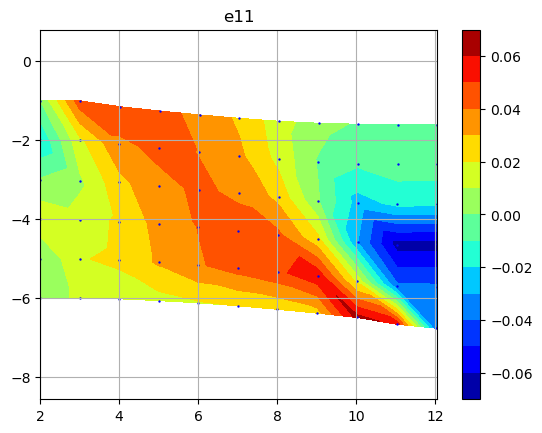

Done.
average_stress =  5.379409902655272
0.0


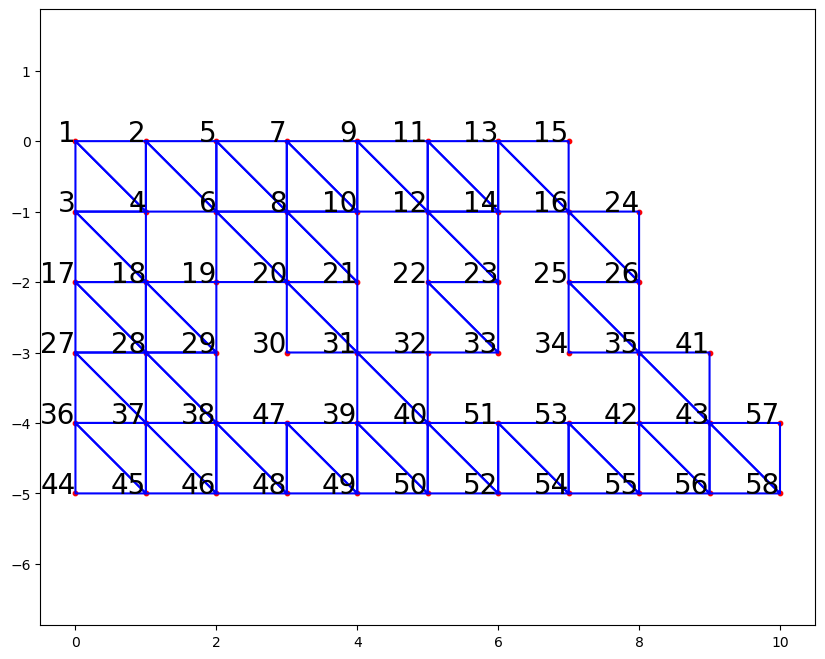

   min strains: e11=-0.1722, e22=-0.08697, e12=-1.038
   max strains: e11=0.1488, e22=0.0989, e12=0.3693
   min stress:  s11=-22, s22=-9.848, s12=-39.92
   max stress:  s11=18.39, s22=14.94, s12=14.21
   average strains: e11=0.05661, e22=0.00459, e12=-0.3306
   average stress:  s11=7.886, s22=3.884, s12=-12.71
   average strain/nodes:  s11=1272, s22=626.5, s12=2051
   average strain/nodes:  e11=9.131, e22=0.7404, e12=53.32

** Plot displacement


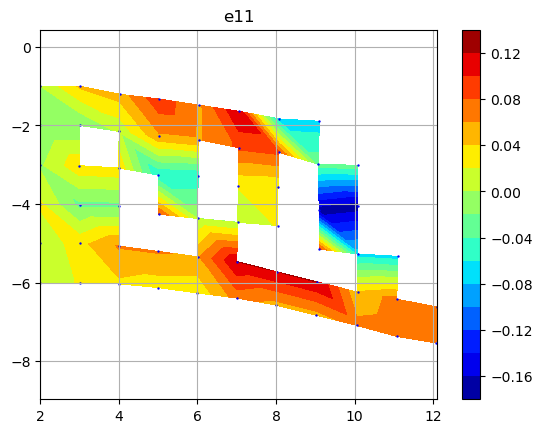

Done.
average_stress =  7.885757592087981
29.779775118359595
   min strains: e11=-0.05606, e22=-0.07419, e12=-0.7759
   max strains: e11=0.08454, e22=0.04417, e12=0.2729
   min stress:  s11=-6.767, s22=-9.174, s12=-29.84
   max stress:  s11=12.65, s22=8.756, s12=10.5
   average strains: e11=0.05218, e22=0.007375, e12=-0.2934
   average stress:  s11=7.45, s22=4.003, s12=-11.29
   average strain/nodes:  s11=1064, s22=571.9, s12=1612
   average strain/nodes:  e11=7.455, e22=1.054, e12=41.92

** Plot displacement


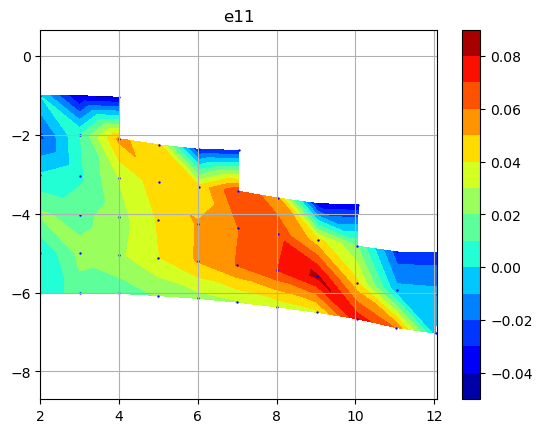

Done.
average_stress =  7.450083817332531
29.90166315451397
   min strains: e11=-0.5969, e22=-0.2161, e12=-2.536
   max strains: e11=0.4291, e22=0.3593, e12=1.542
   min stress:  s11=-68.33, s22=-22.47, s12=-97.55
   max stress:  s11=57.44, s22=51.4, s12=59.3
   average strains: e11=0.06976, e22=0.04641, e12=-0.5206
   average stress:  s11=12.07, s22=10.27, s12=-20.02
   average strain/nodes:  s11=3352, s22=2853, s12=5562
   average strain/nodes:  e11=19.38, e22=12.89, e12=144.6

** Plot displacement


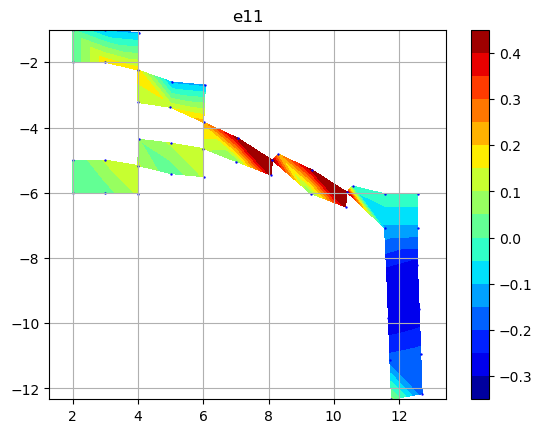

Done.
average_stress =  12.068033165029759
18.493078795140516


In [16]:
# Initialize the design_space as a 3D matrix
design_space = np.zeros((4, HEIGHT, WIDTH))

design_space2= np.zeros((4, HEIGHT, WIDTH))
design_space3= np.zeros((4, HEIGHT, WIDTH))
design_space4= np.zeros((4, HEIGHT, WIDTH))
# Example design matrix
design_matrix = build_truss_design()

half_matrix = build_half_design_matrix()

full_matrix = np.ones((HEIGHT, WIDTH))

bad_design = build_bad_design_matrix()



# Assign the design matrix to the design_space
design_space[DESIGN, :, :] = design_matrix
design_space2[DESIGN, :, :] = half_matrix
design_space3[DESIGN, :, :] = full_matrix
design_space4[DESIGN, :, :] = bad_design
# Example boundary conditions
design_space[BOUND, 0, 0] = 3
design_space[BOUND, -1, 0] = 3
#design_space[BOUND, -1, -1] = 1

design_space2[BOUND, :, :] = design_space[BOUND, :, :]
design_space3[BOUND, :, :] = design_space[BOUND, :, :]
design_space4[BOUND, :, :] = design_space[BOUND, :, :]

# Example loaded elements

design_space[LOADED_Y, -1, -1] = 10

design_space2[LOADED_Y, -1, -1] = 10
design_space3[LOADED_Y, -1, -1] = 10
design_space4[LOADED_Y, -1, -1] = 10

#print(design_space)

#print(extract_fem_data(design_space))

a,b,c, d = extract_fem_data(design_space3)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2, avg_strain_over_nodes = FEM(a, b, c, d, True)
init_stress = average_stress
init_strain = average_strain
init_strain_over_nodes = avg_strain_over_nodes
print("average_stress = ", average_stress)
print(reward_function_2(0.3, HEIGHT, WIDTH, element_count, avg_strain_over_nodes, init_strain_over_nodes))


a,b,c, d = extract_fem_data(design_space)
plot_mesh(a, b)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2, avg_strain_over_nodes = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function_2(0.3, HEIGHT, WIDTH, element_count, avg_strain_over_nodes, init_strain_over_nodes))


a,b,c, d = extract_fem_data(design_space2)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2, avg_strain_over_nodes = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function_2(0.3, HEIGHT, WIDTH, element_count, avg_strain_over_nodes, init_strain_over_nodes))



a,b,c, d = extract_fem_data(design_space4)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2, avg_strain_over_nodes = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function_2(0.3, HEIGHT, WIDTH, element_count, avg_strain_over_nodes, init_strain_over_nodes))

In [17]:
def eliminate_isolated_ones(matrix, main_connected_component):
  """
  Eliminates 1s that are not part of the main connected structure.

  Args:
    matrix: A binary matrix (filled with 0s and 1s).
    main_connected_component: A list of tuples representing the coordinates of the main connected component.

  Returns:
    The modified matrix with non-main structure 1s removed.
  """

  rows, cols = matrix.shape

  # Create a set for efficient membership testing
  main_component_set = set(main_connected_component)

  for i in range(rows):
    for j in range(cols):
      if matrix[i, j] == 1 and (i, j) not in main_component_set:
        matrix[i, j] = 0

  return matrix

In [18]:
def get_scatter_coordinates(bound_list, loaded_list):
    """this is a simple function to provide an easy way to get the coordinates
    used for the scatter plot
    -------
    Parameters:\n
    - matrix : numpy.ndarray
        - The design space.
    -------
    Returns:\n
    - x_bound_positions_for_scatter : list
        - the list of needed x coordinates for the scatter plot of the bound nodes
    - y_bound_positions_for_scatter : list
        - the list of needed y coordinates for the scatter plot of the bound nodes
    - x_loaded_positions_for_scatter : list
        - the list of needed x coordinates for the scatter plot of the loaded nodes
    - y_loaded_positions_for_scatter : list
        - the list of needed y coordinates for the scatter plot of the loaded nodes 
    """
    x_bound_for_scatter = [coord[1] for coord in bound_list]
    y_bound_for_scatter = [coord[0] for coord in bound_list]

    x_loaded_for_scatter = [coord[1] for coord in loaded_list]
    y_loaded_for_scatter = [coord[0] for coord in loaded_list]
    return (x_bound_for_scatter, y_bound_for_scatter,
            x_loaded_for_scatter, y_loaded_for_scatter)

In [19]:
def get_observation_space_range(height,width):
        length = 4*height * width
        dim = height * width
        design_space_low = np.zeros(4*height*width)
        design_space_high = np.zeros(4*height*width)
        for i in range(length):
            if i / dim < 1:
                design_space_low[i] = 0
                design_space_high[i] = 1
            elif i / dim < 2:
                design_space_low[i] = 0
                design_space_high[i] = 3
            elif i / dim < 3:
                design_space_low[i] = -1000
                design_space_high[i] = 1000
            else:
                design_space_low[i] = -1000
                design_space_high[i] = 1000
        shape = (length,)
        return design_space_low, design_space_high, shape

In [20]:
# class TopOptEnv(gym.Env):
#     metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

#     def __init__(self, mode="train", threshold=0.3, 
#                  bound_nodes_list=bound_nodes_list, 
#                  force_nodes_list=loaded_nodes_list, 
#                  height=HEIGHT, width=WIDTH):
#         # The constructor of the environment
#         super().__init__()

#         self.mode = mode
#         self.threshold = threshold

#         self.height = height
#         self.width = width
        
        
#         self.bound_nodes_list = bound_nodes_list
#         self.force_nodes_list = force_nodes_list
#         self.initial_max_strain = 0
#         self.design_space = np.zeros((4, self.height, self.width))
#         low, high, o_space_shape = get_observation_space_range(self.height, self.width)

#         self.action_space = gym.spaces.Discrete(self.height * self.width)
#         self.observation_space = gym.spaces.Box(low=low, 
#                                                 high=high, 
#                                                 shape=o_space_shape, 
#                                                 dtype=int)
        
#         # A Dictionary is used to map each coordinate tuple of the designspace
#         # to a singular distinct integer for use in the optimization
#         # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes=(height,width)
#         self._actions_to_coordinates = {}  
#         k=0
#         for i in range(self.height):
#             for j in range(self.width):
#                 self._actions_to_coordinates[k] = (i,j)
#                 k += 1
        
#         self.reward = 0
#         self.step_count = 0
#         self.episode_count = 0

#         self.reset()
        
#     def _is_illegal_action(self, action):
#         bound_matrix = self.design_space[BOUND, :, :]
#         force_matrix = np.logical_or(self.design_space[LOADED_X, :, :], 
#                                      self.design_space[LOADED_Y,:,:]).astype(int)
#         design_matrix = self.design_space[DESIGN, :, :]

       
#         # Check if the selected Action has already been performed on this state
#         if action in self.performed_actions:
#             if self.mode == "eval":
#                 print("Action already performed")
#             return True
#         #check if the selected Node is either bound or force node
#         if bound_matrix[self._actions_to_coordinates[action]] != 0:
#             if self.mode == "eval":
#                 print("Tried removing Bound Node")
#             return True
#         if force_matrix[self._actions_to_coordinates[action]] != 0:
#             if self.mode == "eval":
#                 print("Tried removing Loaded Node")
#             return True
#         #Check if the selected Node is already removed
#         if design_matrix[self._actions_to_coordinates[action]] < 1:
#             if self.mode == "eval":
#                 print("Tried removing Empty Node")
#             return True
#         if not is_continuous(design_matrix, self.dfs_result):
#             print("Not continuous")
#             return True

#     def step(self, action):
#         #self.print_design(self)
#         design_matrix = self.design_space[DESIGN, :,:]
        
#         self.step_count += 1
#         terminated = False
#         self.dfs_result = dfs(design_matrix, self.bound_nodes_list + self.force_nodes_list)

#         if self._is_illegal_action(action):
#             reward = -(self.height * self.width) *10
#             terminated = True
#             #print("Illegal Action")
#             # print("Action: ", self._actions_to_coordinates[action])
#             return (self.design_space, reward, 
#                     terminated, False, self.get_info())
        
        
        
        
#         #self.last_compliance = self.compliance

#         self._remove_node(action)
#         self.dfs_result = dfs(design_matrix, self.bound_nodes_list + self.force_nodes_list)
#         if not is_continuous(design_matrix, self.dfs_result):
#             terminated = True
#             #print("Illegal Action")
#             # print("Action: ", self._actions_to_coordinates[action])
#             reward = -(self.height * self.width) *10
#             return (self.design_space, reward, 
#                     terminated, False, self.get_info())
        
#         #eliminate_isolated_ones(design_matrix, self.dfs_result)
#         if self.episode_count % 5000 == 0:
#             self.print_design()

#         self.constraint = (self.design_space[DESIGN, :, :].sum() / 
#                           (self.height * self.width))


#         self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
        
        
#         try:
#             self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2 = FEM(self.nodes, self.elements , self.boundary_conditions, self.node_map, False)
#         except np.linalg.LinAlgError as e:
#             terminated = True
#             self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#             plot_mesh(self.nodes, self.elements)
#             print("target coordinates:", self.bound_nodes_list + self.force_nodes_list)
#             print("iscontinuus?:" + is_continuous(self.design_space[DESIGN, :, :], self.dfs_result))
#             print("n", self.design_space[DESIGN, :, :])
#             raise
#         except ValueError as e:
#             terminated = True
#             #self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#             #plot_mesh(self.nodes, self.elements)
#             print("v", self.design_space[DESIGN, :, :])
#             print(self._actions_to_coordinates[action])

#             print("Episode: ", self.episode_count)
#             raise
        
#         self.current_reward = reward_function(self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, average_strain, self.init_strain, self.max_displacement_1, self.max_displacement_2, self.init_stress)
#         self.reward += self.current_reward

#         self.performed_actions.append(action)

#         if self.constraint < self.threshold:
#             terminated = True
#             if self.mode == "train":
#                 self.current_reward += 100

#         self.design_space[DESIGN, :, :] = design_matrix





#         return self.design_space.flatten(), self.current_reward, terminated, False, self.get_info()



#     def _remove_node(self, action):
#         design_matrix = self.design_space[DESIGN, :, :]
#         design_matrix[self._actions_to_coordinates[action]] = 0    
#         self.design_space[DESIGN, :, :] = design_matrix
    



#     def reset(self, seed=None):
#         # The reset function of the environment

#         super().reset(seed=seed)
#         self.episode_count += 1
#         self.step_count = 0
#         self.reward = 0
#         self.performed_actions = []
#         self.design_space = np.zeros((4, self.height, self.width))
#         self.design_space[DESIGN, :, :] += 1

#         design_matrix = self.design_space[DESIGN, :, :]
#         bound_matrix = self.design_space[BOUND, :,:]
#         force_x_matrix = self.design_space[LOADED_X, :,:]
#         force_y_matrix = self.design_space[LOADED_Y, :,:]

#         if self.mode == "train":
#             self.bound_nodes_list = []
#             self.bound_nodes_list.append(self.generate_random_coordinate()) 
#             self.bound_nodes_list.append(self.generate_random_coordinate()) 

#             self.force_nodes_list = []
#             self.force_nodes_list.append(self.generate_random_coordinate())
        
#         if self.mode == "eval":
#             self.bound_nodes_list = bound_nodes_list
#             self.force_nodes_list = loaded_nodes_list
        
#         for coord in convert_all(self.bound_nodes_list, (self.height, self.width)):
#             bound_matrix[coord] = 3
#         for coord in convert_all(self.force_nodes_list, (self.height, self.width)):
#             force_y_matrix[coord] = 10  

        
        


        
#         # self.compliance = self.initial_compliance
#         # self.last_compliance = self.initial_compliance

#         self.design_space[DESIGN, :, :] = design_matrix
#         self.design_space[BOUND, :, :] = bound_matrix
#         self.design_space[LOADED_Y, :,:] = force_y_matrix
#         self.design_space[LOADED_X, :,:] = force_x_matrix

#         # print("\n\nReset Debug ====================================")
#         # print("items in self.bound_nodes_list", len(self.bound_nodes_list))
#         # print("bound_nodes_list", self.bound_nodes_list)
#         # print("Initial Compliance:\n", self.initial_compliance)
#         # print("design_matrix:\n", design_matrix)
#         # print("design_space[:,:,_DESIGN]:\n", self.design_space[:,:, _DESIGN])
#         # print("bound_matrix:\n", bound_matrix)
#         # print("design_space[:,:,_BOUND]:\n", self.design_space[:,:, _BOUND])
#         # print("force_matrix:\n", force_matrix)
#         # print("design_space[:,:,_FORCE]:\n", self.design_space[:,:, _FORCE])
#         # print("compliance_matrix:\n", compliance_matrix)
#         # print("Initial Reward:\n", self.reward)

#         self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#         smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2 = FEM(self.nodes, self.elements , self.boundary_conditions, self.node_map, False)
#         self.init_stress = smax
#         self.init_strain = self.average_stress

#         return self.design_space.flatten(), self.get_info()



#     def is_valid_coordinate(self, coord, node_lists):
#     # Check adjacent positions
#         checking_positions = [
#             (coord[0], coord[1]),  # Current
#             (coord[0] - 1, coord[1]),  # Left
#             (coord[0] + 1, coord[1]),  # Right
#             (coord[0], coord[1] - 1),  # Up
#             (coord[0], coord[1] + 1),  # Down
#         ]
#         # Check if any adjacent position is in the node lists
#         for pos in checking_positions:
#             if any(pos in node_list for node_list in node_lists):
#                 return True
#         return False

#     def generate_random_coordinate(self):
#         axis = random.randint(0, 3)
#         if axis == 0:
#             coord = random.randint(0, self.height-1), 0  # Left edge
#         elif axis == 1:
#             coord = 0, random.randint(0, self.width-1)  # Top edge
#         elif axis == 2:
#             coord = random.randint(0, self.height-1), self.width-1  # Right edge
#         else:
#             coord = self.height-1, random.randint(0, self.width-1)  # Bottom edge

#         # Check if the coordinate is in the lists or next to any node in the lists
#         comp_list = [self.bound_nodes_list, self.force_nodes_list]
    
#         if (coord in self.bound_nodes_list or 
#             coord in self.force_nodes_list or 
#             self.is_valid_coordinate(coord, comp_list)):
        
#             return self.generate_random_coordinate()
#         else:
#             return coord
    

    
#     def print_design(self, mode="human"):
#         # This function is used to render the environment
#         # This function is not necessary for the optimization
#         print("current Design")
#         print(self.force_nodes_list)
#         fig, ax = plt.subplots()
#         ax.imshow(self.design_space[DESIGN, :, :])
#         xb, yb, xl, yl = get_scatter_coordinates(self.bound_nodes_list, 
#                                                  self.force_nodes_list)
#         ax.scatter(xb, yb, s=20, color='k', marker='x')
#         ax.scatter(xl, yl, s=20, color='k', marker='$↓$')
#         plt.show()


#     def get_info(self):
#         # This function returns the information about the environment
#         # This function is used to monitor the environment
#         # The information should be a dictionary
#         # The dictionary should contain the following keys:
#         # - step_count: the number of steps that have been executed
#         # - current Reward: the reward of the current state
#         # - design_space: the current state of the environment
#         return {"step_count": self.step_count, 
#                 "current_reward": self.reward,
#                 "design_space": self.design_space,
#                 }


In [21]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, mode="train", threshold=0.3, bound_nodes_list=bound_nodes_list, force_nodes_list=loaded_nodes_list, height=HEIGHT, width=WIDTH):
        # The constructor of the environment
        super().__init__()

        self.mode = mode
        self.threshold = threshold

        self.height = height
        self.width = width
        
        self.bound_nodes_list = bound_nodes_list
        self.force_nodes_list = force_nodes_list
        self.init_strain = 0
        self.init_stress = 0
        self.design_space = np.zeros((4, self.height, self.width))
        self.design_space[DESIGN, :, :] += 1
        low, high, o_space_shape = get_observation_space_range(self.height, self.width)
        self.observation_space = gym.spaces.Box(low=low, 
                                                high=high, 
                                                shape=o_space_shape, 
                                                dtype=int)        
        self.action_space = gym.spaces.Discrete(self.height * self.width)

        
        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the optimization
        # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes=(height,width)
        self._actions_to_coordinates = {}  
        k=0
        for i in range(self.height):
            for j in range(self.width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1
        
        self.reward = 0
        self.accumulated_reward = 0
        self.step_count = 0
        self.episode_count = 0

        self.reset()
    
    def _is_illegal_action(self, action):
        bound_matrix = self.design_space[BOUND, :, :]
        force_matrix = np.logical_or(self.design_space[LOADED_X, :, :], 
                                     self.design_space[LOADED_Y,:,:]).astype(int)
        design_matrix = self.design_space[DESIGN, :, :]

        # Check if the selected Action has already been performed on this state
        if action in self.performed_actions:
            if self.mode == "eval":
                print("Action already performed")
            return True
        #check if the selected Node is either bound or force node
        if bound_matrix[self._actions_to_coordinates[action]] != 0:
            if self.mode == "eval":
                print("Tried removing Bound Node")
            return True
        if force_matrix[self._actions_to_coordinates[action]] != 0:
            if self.mode == "eval":
                print("Tried removing Loaded Node")
            return True
        #Check if the selected Node is already removed
        if design_matrix[self._actions_to_coordinates[action]] < 1:
            if self.mode == "eval":
                print("Tried removing Empty Node")
            return True
        if not is_continuous(design_matrix, self.dfs_result):
            print("Not continuous")
            return True
    def step(self, action):
        self.step_count += 1
        terminated = False
        self.dfs_result = dfs(self.design_space[DESIGN, :, :], self.bound_nodes_list + self.force_nodes_list)
        if self._is_illegal_action(action):
            self.reward = -(self.height * self.width) *10
            terminated = True
            return (self.design_space.flatten(), self.reward, 
                    terminated, False, self.get_info())
        self._remove_node(action)
        self.dfs_result = dfs(self.design_space[DESIGN, :, :], self.bound_nodes_list + self.force_nodes_list)
        if not is_continuous(self.design_space[DESIGN, :, :], self.dfs_result):
            terminated = True
            self.reward = -(self.height * self.width) *10
            return (self.design_space.flatten(), self.reward, 
                    terminated, False, self.get_info())
        

        nodes, elements , boundary_conditions, node_map = extract_fem_data(self.design_space)

        self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2, self.avg_strain_over_nodes = FEM(nodes, elements , boundary_conditions, node_map, False)


        #self.reward = reward_function(self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.init_strain, self.max_displacement_1, self.max_displacement_2, self.init_stress)
        self.reward = reward_function_2(self.threshold, self.height, self.width, self.element_count, self.avg_strain_over_nodes, self.init_strain_over_nodes)
        
        self.performed_actions.append(action)
        constraint = (self.design_space[DESIGN, :, :].sum() / 
                          (self.height * self.width))
        if constraint < self.threshold:
            terminated = True
            if self.mode == "train":
                self.reward += 100
            return self.design_space.flatten(), self.reward, terminated, False, self.get_info()

        if self.episode_count % 5000 == 0:
            self.print_design()
            print("curr_reward", self.reward)
            print("accumulated_reward", self.accumulated_reward)
        return self.design_space.flatten(), self.reward, terminated, False, self.get_info()
        
    def _remove_node(self, action):	
        design_matrix = self.design_space[DESIGN, :, :]
        design_matrix[self._actions_to_coordinates[action]] = 0    
        self.design_space[DESIGN, :, :] = design_matrix
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.step_count = 0
        self.reward = 0
        self.performed_actions = []
        self.design_space = np.zeros((4, self.height, self.width))
        self.design_space[DESIGN, :, :] += 1
        
        design_matrix = self.design_space[DESIGN, :, :]
        bound_matrix = self.design_space[BOUND, :,:]
        force_x_matrix = self.design_space[LOADED_X, :,:]
        force_y_matrix = self.design_space[LOADED_Y, :,:]

        if self.mode == "train":
            self.bound_nodes_list = []
            self.force_nodes_list = []
            
            self.bound_nodes_list.append(self.generate_random_coordinate()) 
            self.bound_nodes_list.append(self.generate_random_coordinate()) 
            self.force_nodes_list.append(self.generate_random_coordinate())
        
        elif self.mode == "eval":
            self.bound_nodes_list = self.bound_nodes_list
            self.force_nodes_list = self.force_nodes_list
        
        for coord in convert_all(self.bound_nodes_list, (self.height, self.width)):
            bound_matrix[coord] = 3
        for coord in convert_all(self.force_nodes_list, (self.height, self.width)):
            force_y_matrix[coord] = 10

        self.design_space[DESIGN, :, :] = design_matrix
        self.design_space[BOUND, :, :] = bound_matrix
        self.design_space[LOADED_Y, :,:] = force_y_matrix
        self.design_space[LOADED_X, :,:] = force_x_matrix

        nodes, elements , boundary_conditions, node_map = extract_fem_data(self.design_space)
        self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2, self.avg_strain_over_nodes = FEM(nodes, elements , boundary_conditions, node_map, False)
        self.init_strain = self.average_strain
        self.init_strain_over_nodes = self.avg_strain_over_nodes
        return self.design_space.flatten(), self.get_info()

    def is_valid_coordinate(self, coord, node_lists):
    # Check adjacent positions
        checking_positions = [
            (coord[0], coord[1]),  # Current
            (coord[0] - 1, coord[1]),  # Left
            (coord[0] + 1, coord[1]),  # Right
            (coord[0], coord[1] - 1),  # Up
            (coord[0], coord[1] + 1),  # Down
        ]
        # Check if any adjacent position is in the node lists
        for pos in checking_positions:
            if any(pos in node_list for node_list in node_lists):
                return True
        return False

    def generate_random_coordinate(self):
        axis = random.randint(0, 3)
        if axis == 0:
            coord = random.randint(0, self.height-1), 0  # Left edge
        elif axis == 1:
            coord = 0, random.randint(0, self.width-1)  # Top edge
        elif axis == 2:
            coord = random.randint(0, self.height-1), self.width-1  # Right edge
        else:
            coord = self.height-1, random.randint(0, self.width-1)  # Bottom edge

        # Check if the coordinate is in the lists or next to any node in the lists
        comp_list = [self.bound_nodes_list, self.force_nodes_list]
    
        if (coord in self.bound_nodes_list or 
            coord in self.force_nodes_list or 
            self.is_valid_coordinate(coord, comp_list)):
        
            return self.generate_random_coordinate()
        else:
            return coord

    def print_design(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        print(self.force_nodes_list)
        fig, ax = plt.subplots()
        ax.imshow(self.design_space[DESIGN, :, :])
        xb, yb, xl, yl = get_scatter_coordinates(self.bound_nodes_list, 
                                                 self.force_nodes_list)
        ax.scatter(xb, yb, s=20, color='k', marker='x')
        ax.scatter(xl, yl, s=20, color='k', marker='$↓$')
        plt.show()

    def get_info(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space,
                }


In [22]:
def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("get_info")
    fig, axs = plt.subplots(1, NUMBER_SUBPROCESSES)
    fig.set_size_inches(20, 3)

    fig.subplots_adjust(hspace=0.05)
    
    
    for i in range(NUMBER_SUBPROCESSES * 1):
        row = i // NUMBER_SUBPROCESSES
        col = i % NUMBER_SUBPROCESSES
        
        if row == 0:
            space_index = i
        else:
            space_index = i - NUMBER_SUBPROCESSES

        # if len(design_spaces[space_index]["design_space"].shape) != 2:
        #     raise ValueError(f"Expected a 2D array, but got shape {design_spaces[space_index]['design_space'].shape}")


        current_design_space = design_spaces[space_index]["design_space"]
        current_bound_matrix = current_design_space[BOUND, :, :, ]
        current_force_matrix = np.logical_or(current_design_space[LOADED_X, :, :], 
                                     current_design_space[LOADED_Y,:,:]).astype(int)
        
        #print(current_bound_matrix)
        current_bound_list = matrix_to_node_list(current_bound_matrix)
        current_force_list = matrix_to_node_list(current_force_matrix)
        
        #print(current_bound_list, "\n", current_force_list)
        if row == 0:
            axs[col].imshow(current_design_space[DESIGN, :, :], 
                                 vmin=0, vmax=1)
            current_reward = design_spaces[space_index]["current_reward"]
            title = f"{i + 1}\nReward= {round(current_reward, 1)}"
        # else:
        #     axs[row, col].imshow(current_design_space[:, :, _COMPLIANCE], 
        #                          vmin=0, vmax=1)
        #     current_compliance = design_spaces[space_index]["compliance"]
        #     title = f"Compliance= {round(current_compliance, 1)}"
        
        xb, yb, xl, yl = get_scatter_coordinates(current_bound_list, 
                                                 current_force_list)
        axs[col].scatter(xb, yb, s=20, color='k', marker='x')
        axs[col].scatter(xl, yl, s=20, color='k', marker='$↓$')
        axs[col].set_title(title, fontsize=11, pad=10) 
    plt.show()
    


def matrix_to_node_list(matrix):
    """
    Finds the coordinates of all the 1s in a given matrix.

    :param matrix: A 2D list or numpy array containing 0s and 1s.
    :return: A list of tuples, where each tuple represents the 
    coordinates (row, column) of a 1 in the matrix.
    """
    coordinates = []
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value != 0:
                coordinates.append((i, j))
    return coordinates

def node_list_to_matrix(coordinates, rows, cols):
    """
    Creates a matrix from a list of coordinates, setting the positions 
    of the coordinates to 1.

    :param coordinates: A list of tuples, where each tuple represents 
    the coordinates (row, column) of a 1.
    :param rows: The number of rows in the matrix.
    :param cols: The number of columns in the matrix.
    :return: A 2D list (matrix) with 1s at the specified coordinates and 
    0s elsewhere.
    """
    matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    for (i, j) in coordinates:
        matrix[i][j] = 1
    return matrix

In [23]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` 
    steps)based on the training reward (in practice, we recommend using 
    ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be 
    saved. It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        print("callback baby")
        if self.save_path is not None:
            # os.makedirs(self.save_path, exist_ok=True
            return

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            print("hello hello")
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("--------------------------------------------------")
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                if NUMBER_SUBPROCESSES > 1:
                    vecenv_render(env)
                else:
                    env.print_design()
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [24]:
def make_env():
    return TopOptEnv()

In [25]:
if NUMBER_SUBPROCESSES == 1:
    env = make_env()
    #check_env(env, warn=True)
    env = Monitor(env, LOG_DIR)
if NUMBER_SUBPROCESSES > 1:
    env = SubprocVecEnv([make_env for _ in range(NUMBER_SUBPROCESSES)])
    env = VecMonitor(env, LOG_DIR)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=LOG_DIR)

sess = tf.compat.v1.Session()
file_writer = tf.summary.create_file_writer(TS_BOARD_DIR)
with file_writer.as_default():
    tf.summary.graph(sess.graph)


2024-12-06 01:54:47.618368: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-12-06 01:54:47.618989: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Tensorboard


In [26]:
%tensorboard --logdir /home/adrian_2/Documents/Bachelorarbeit/topology_optimization_RL_BA/src/ts_board

Reusing TensorBoard on port 6006 (pid 17836), started 1 day, 8:56:20 ago. (Use '!kill 17836' to kill it.)

# Training

callback baby
hello hello
--------------------------------------------------
Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: -424.06
current Design
[(0, 8)]


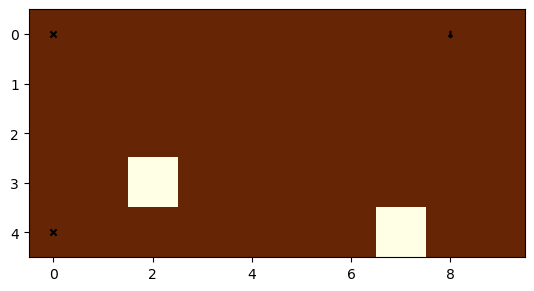

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 20000
Best mean reward: -424.06 - Last mean reward per episode: -410.94
current Design
[(0, 5)]


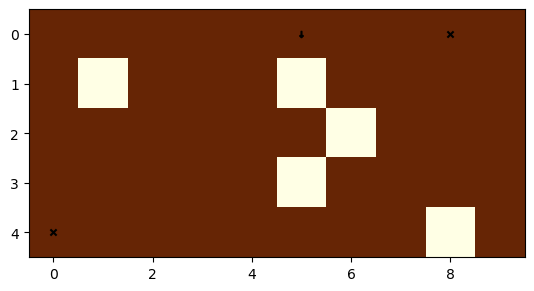

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 30000
Best mean reward: -410.94 - Last mean reward per episode: -408.95
current Design
[(2, 0)]


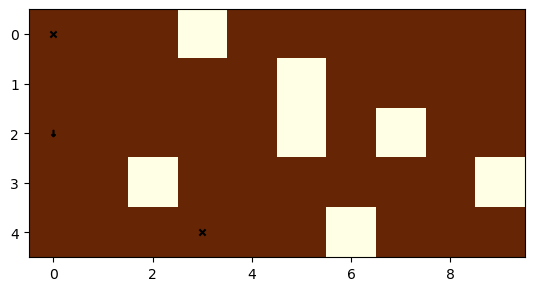

Saving new best model to log/best_model.zip
current Design
[(4, 0)]


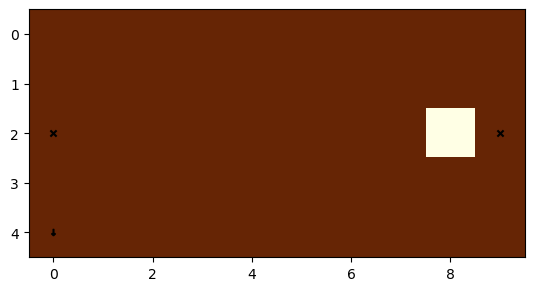

curr_reward 3.832144659360413
accumulated_reward 0
current Design
[(4, 0)]


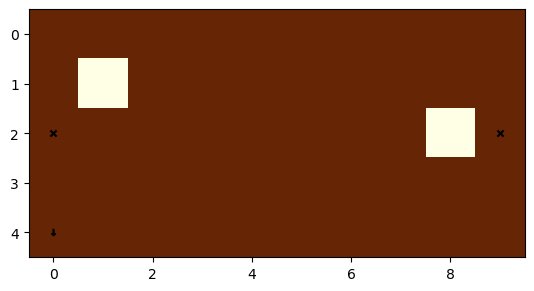

curr_reward 7.368367169269119
accumulated_reward 0
current Design
[(4, 0)]


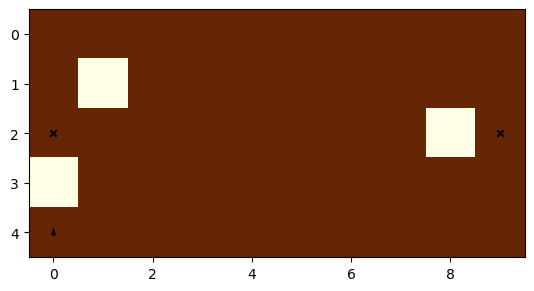

curr_reward 14.21864697683577
accumulated_reward 0
current Design
[(4, 0)]


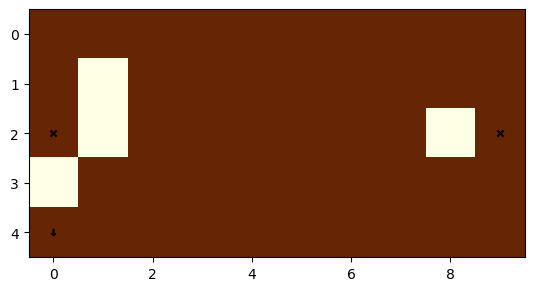

curr_reward 21.535998531495302
accumulated_reward 0
current Design
[(4, 0)]


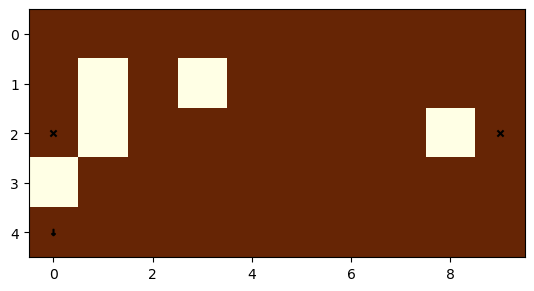

curr_reward 25.657561585062822
accumulated_reward 0
current Design
[(4, 0)]


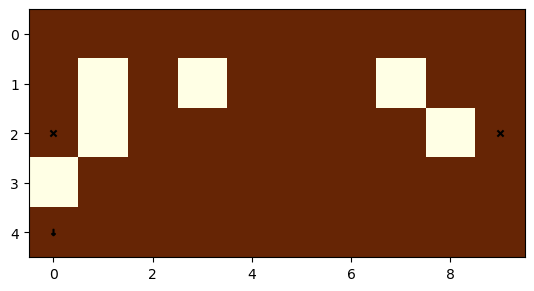

curr_reward 29.146406520556877
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 40000
Best mean reward: -408.95 - Last mean reward per episode: -422.36
current Design
[(4, 1)]


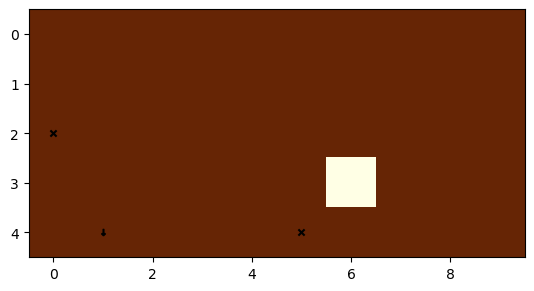

hello hello
--------------------------------------------------
Num timesteps: 50000
Best mean reward: -408.95 - Last mean reward per episode: -412.65
current Design
[(3, 0)]


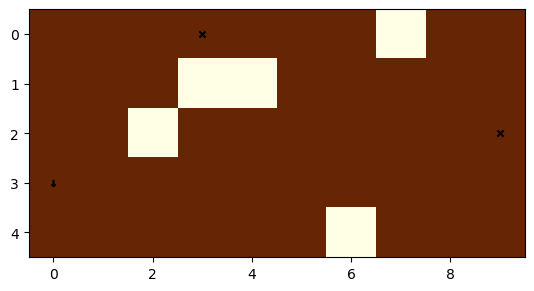

hello hello
--------------------------------------------------
Num timesteps: 60000
Best mean reward: -408.95 - Last mean reward per episode: -415.46
current Design
[(4, 1)]


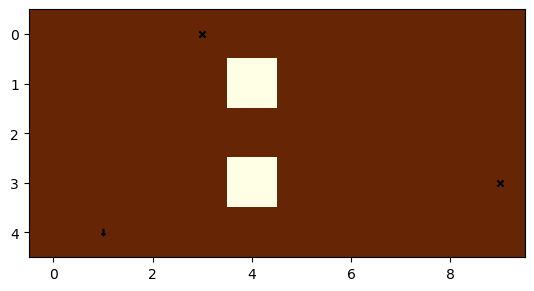

current Design
[(4, 0)]


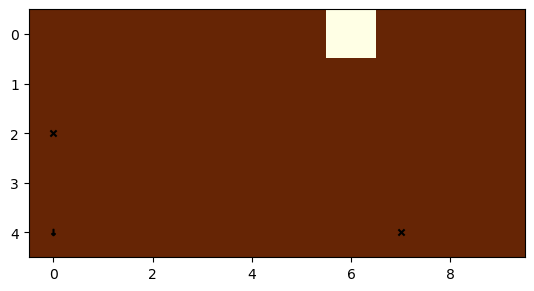

curr_reward 3.8396476840301954
accumulated_reward 0
current Design
[(4, 0)]


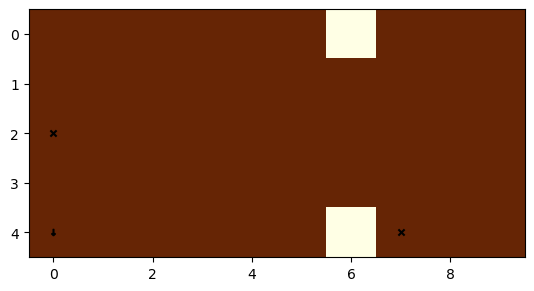

curr_reward 7.28971089420021
accumulated_reward 0
current Design
[(4, 0)]


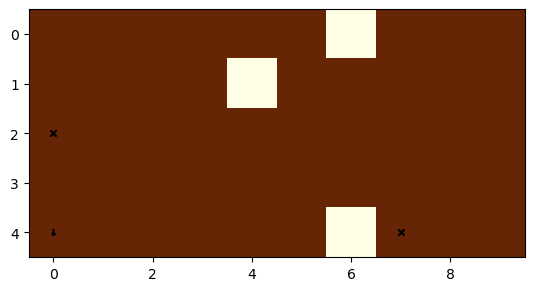

curr_reward 10.467204949020841
accumulated_reward 0
current Design
[(4, 0)]


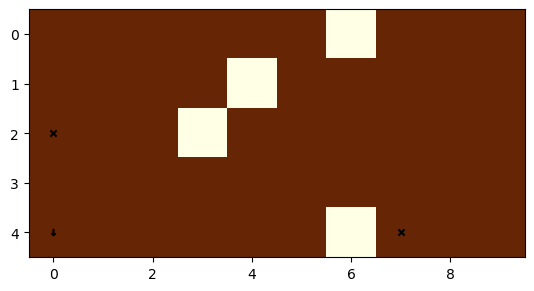

curr_reward 13.371889016506028
accumulated_reward 0
current Design
[(4, 0)]


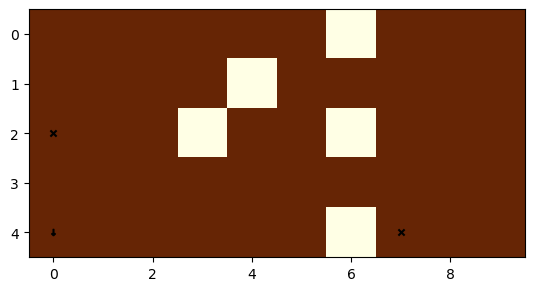

curr_reward 15.9574883054515
accumulated_reward 0
current Design
[(4, 0)]


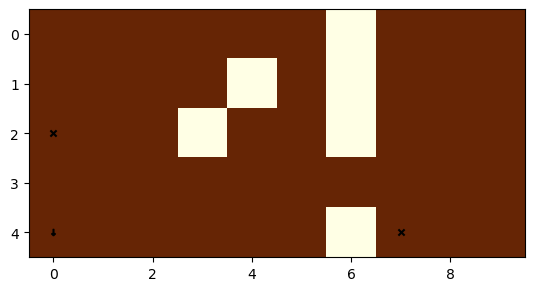

curr_reward 18.175446292797876
accumulated_reward 0
current Design
[(4, 0)]


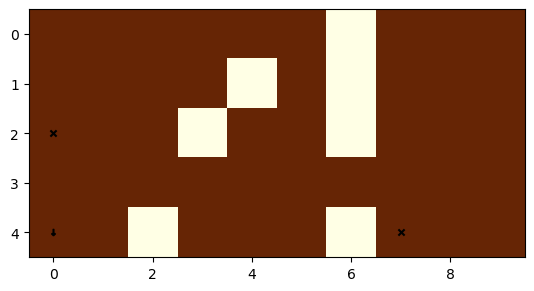

curr_reward 20.777416723405636
accumulated_reward 0
current Design
[(4, 0)]


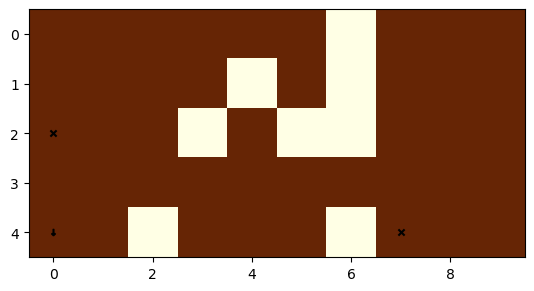

curr_reward 22.602617026843937
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 70000
Best mean reward: -408.95 - Last mean reward per episode: -399.41
current Design
[(3, 0)]


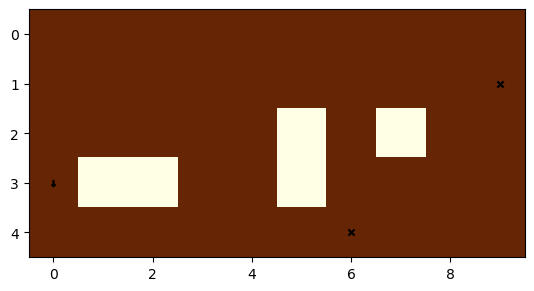

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 80000
Best mean reward: -399.41 - Last mean reward per episode: -415.14
current Design
[(4, 4)]


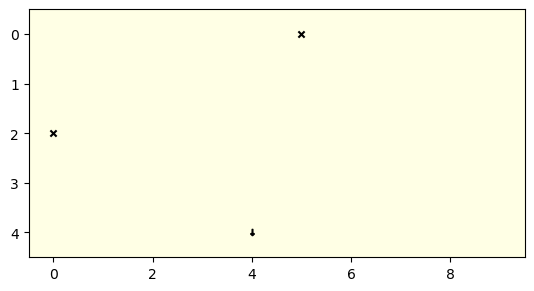

hello hello
--------------------------------------------------
Num timesteps: 90000
Best mean reward: -399.41 - Last mean reward per episode: -414.75
current Design
[(4, 3)]


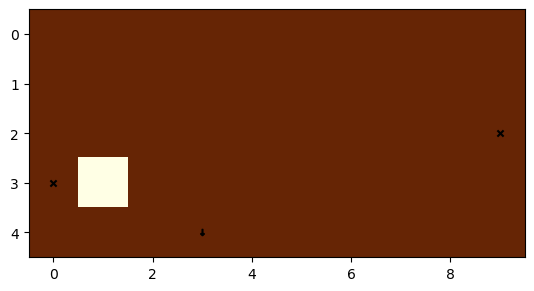

hello hello
--------------------------------------------------
Num timesteps: 100000
Best mean reward: -399.41 - Last mean reward per episode: -410.74
current Design
[(0, 6)]


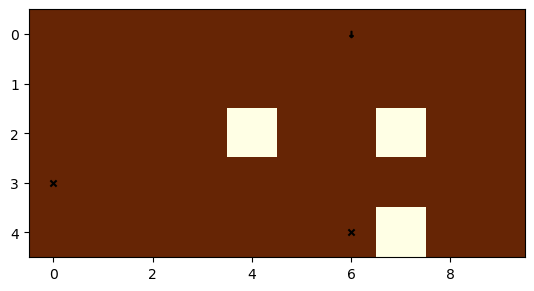

current Design
[(4, 9)]


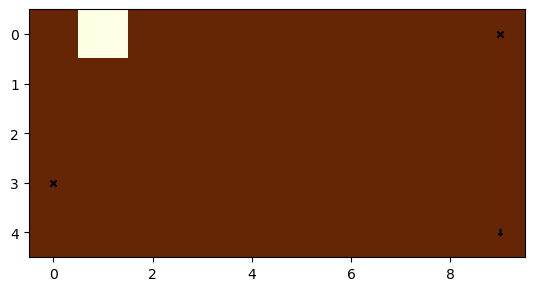

curr_reward 3.915736427270658
accumulated_reward 0
current Design
[(4, 9)]


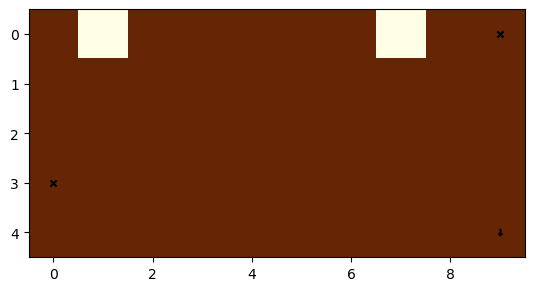

curr_reward 7.0623708054262755
accumulated_reward 0
current Design
[(4, 9)]


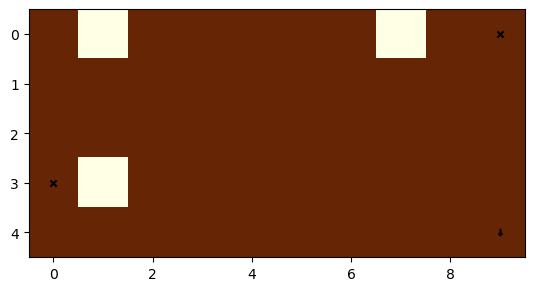

curr_reward 10.700537831288365
accumulated_reward 0
current Design
[(4, 9)]


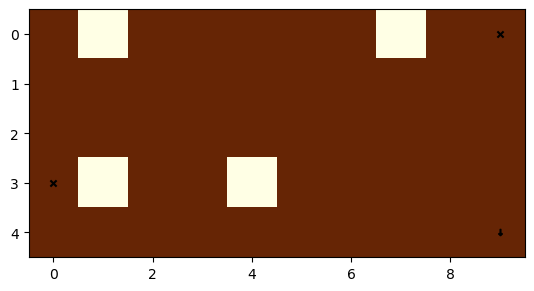

curr_reward 13.829676087668275
accumulated_reward 0
current Design
[(4, 9)]


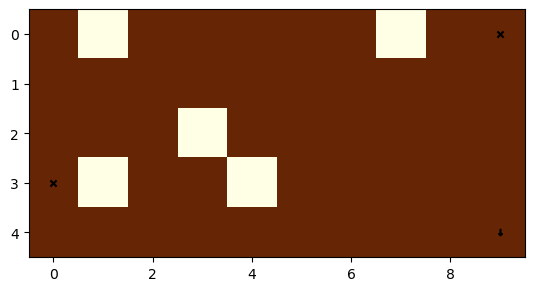

curr_reward 16.835684744830143
accumulated_reward 0
current Design
[(4, 9)]


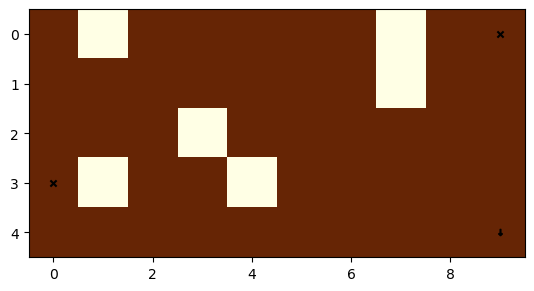

curr_reward 18.32503332208495
accumulated_reward 0
current Design
[(4, 9)]


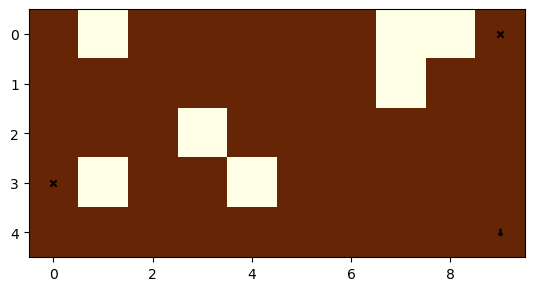

curr_reward 21.142156868483973
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 110000
Best mean reward: -399.41 - Last mean reward per episode: -408.20
current Design
[(1, 0)]


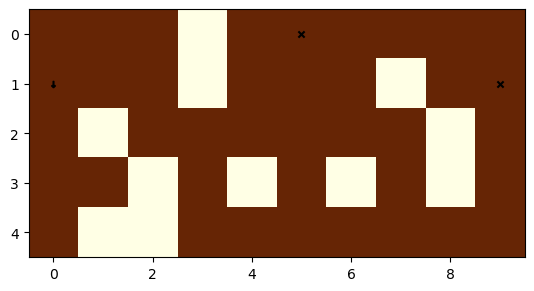

hello hello
--------------------------------------------------
Num timesteps: 120000
Best mean reward: -399.41 - Last mean reward per episode: -392.23
current Design
[(4, 3)]


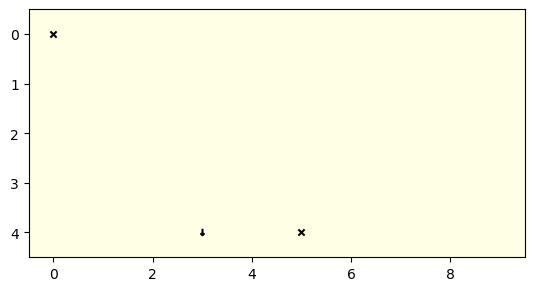

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 130000
Best mean reward: -392.23 - Last mean reward per episode: -409.35
current Design
[(0, 9)]


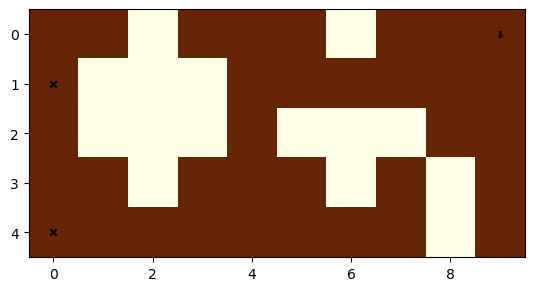

hello hello
--------------------------------------------------
Num timesteps: 140000
Best mean reward: -392.23 - Last mean reward per episode: -398.01
current Design
[(0, 2)]


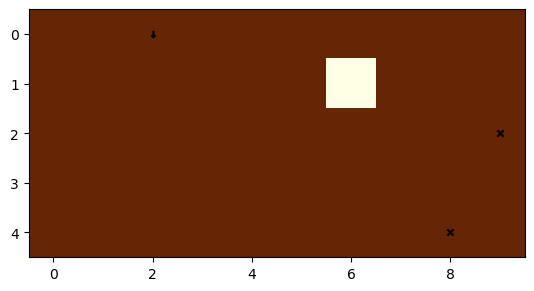

current Design
[(0, 9)]


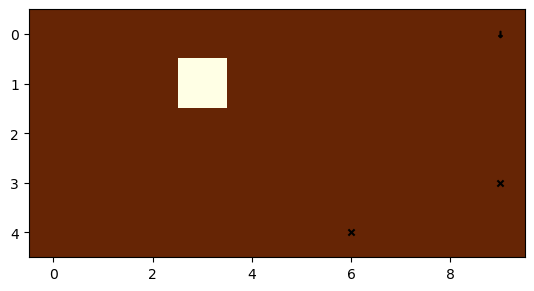

curr_reward 3.8186596651835214
accumulated_reward 0
current Design
[(0, 9)]


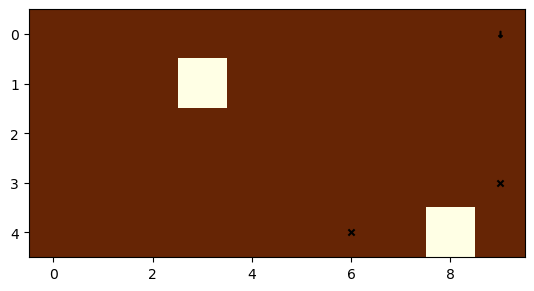

curr_reward 7.7013650870416885
accumulated_reward 0
current Design
[(0, 9)]


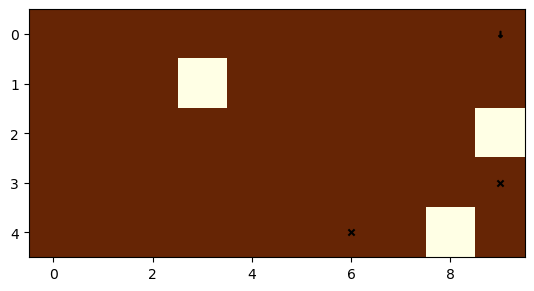

curr_reward 19.890719146136725
accumulated_reward 0
current Design
[(0, 9)]


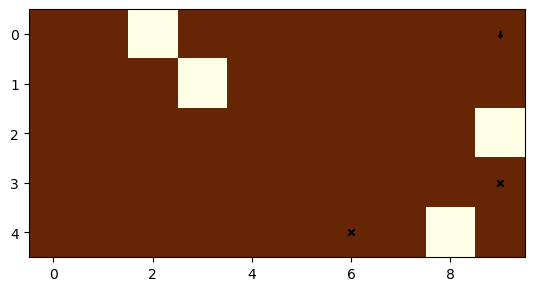

curr_reward 25.774359779993503
accumulated_reward 0
current Design
[(0, 9)]


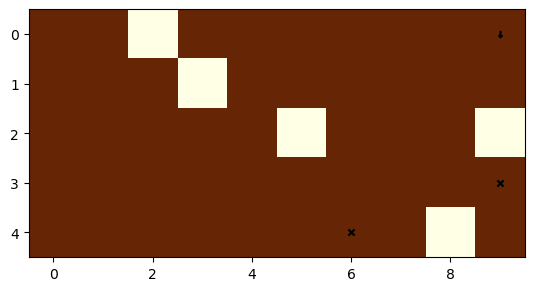

curr_reward 31.944598282062273
accumulated_reward 0
current Design
[(0, 9)]


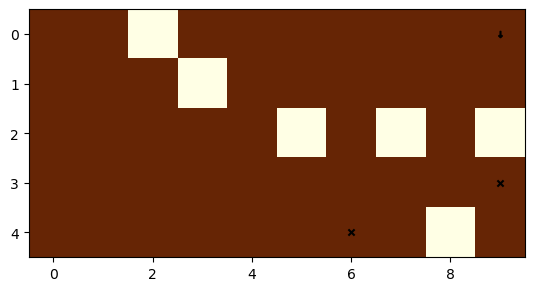

curr_reward 37.65366955547297
accumulated_reward 0
current Design
[(0, 9)]


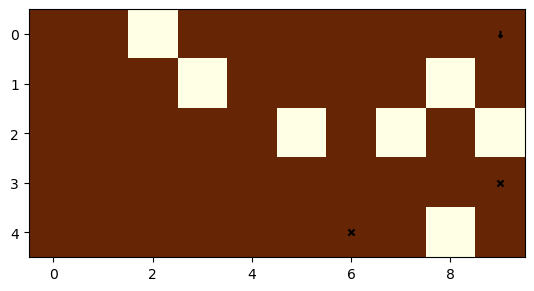

curr_reward 36.10387140139534
accumulated_reward 0
current Design
[(0, 9)]


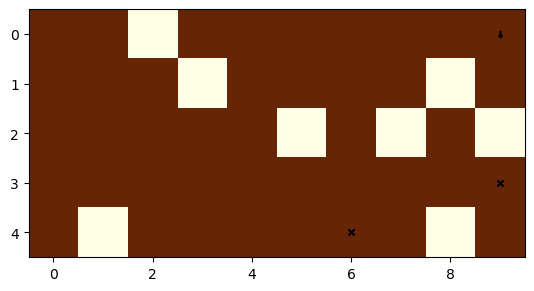

curr_reward 39.383117771472925
accumulated_reward 0
current Design
[(0, 9)]


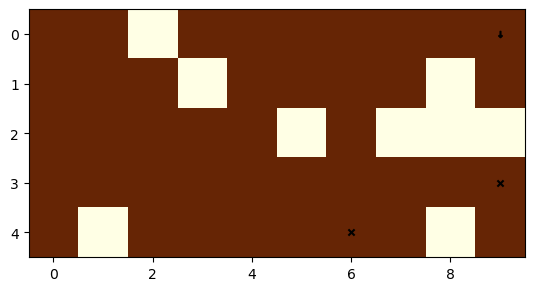

curr_reward 28.5123333012021
accumulated_reward 0
current Design
[(0, 9)]


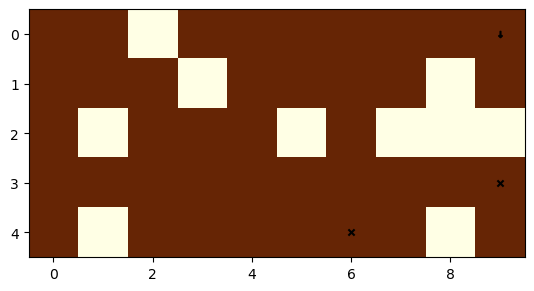

curr_reward 30.207322234309135
accumulated_reward 0
current Design
[(0, 9)]


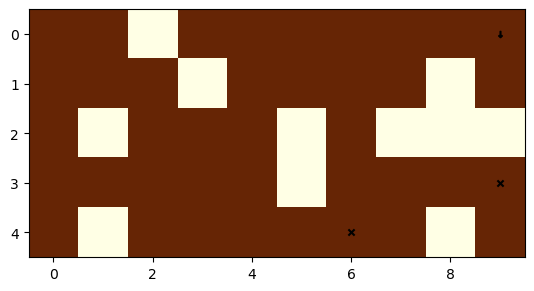

curr_reward 32.720354633529745
accumulated_reward 0
current Design
[(0, 9)]


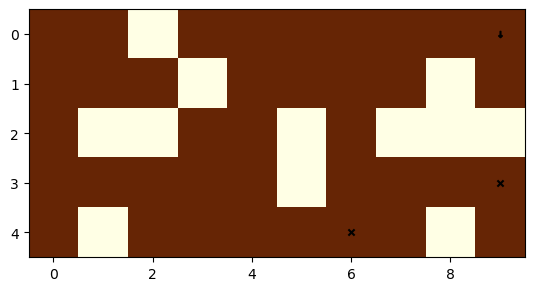

curr_reward 34.271277900251675
accumulated_reward 0
current Design
[(0, 9)]


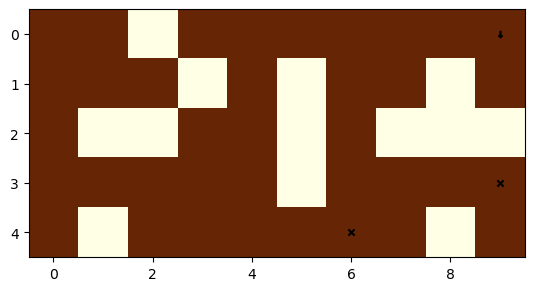

curr_reward 39.16184995157359
accumulated_reward 0
current Design
[(0, 9)]


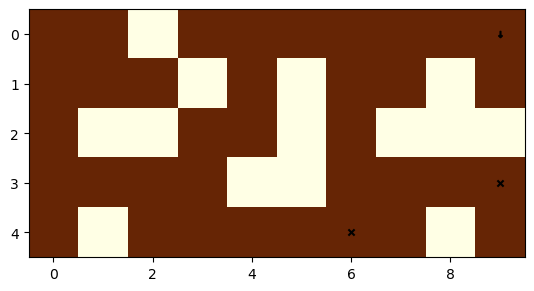

curr_reward 45.86477338433439
accumulated_reward 0
current Design
[(0, 9)]


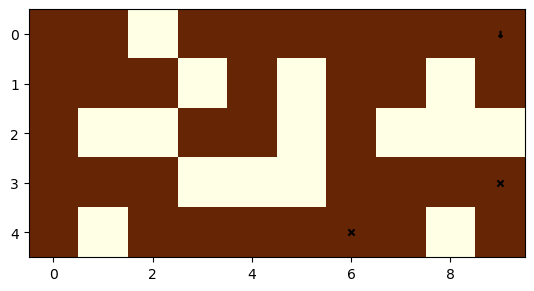

curr_reward 52.37809569556739
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 150000
Best mean reward: -392.23 - Last mean reward per episode: -415.29
current Design
[(3, 9)]


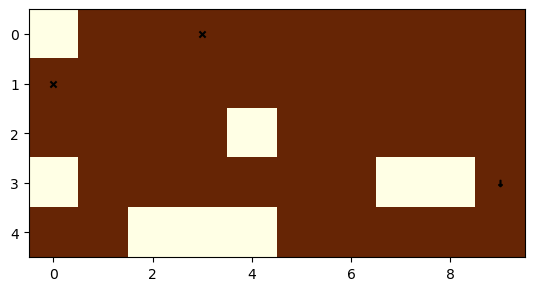

hello hello
--------------------------------------------------
Num timesteps: 160000
Best mean reward: -392.23 - Last mean reward per episode: -402.51
current Design
[(0, 9)]


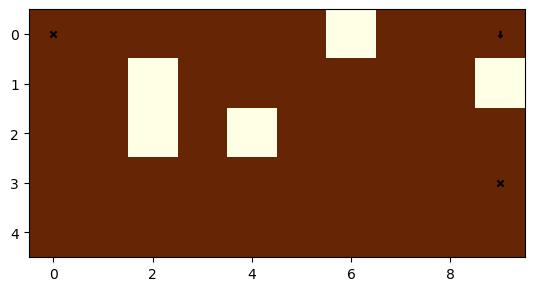

hello hello
--------------------------------------------------
Num timesteps: 170000
Best mean reward: -392.23 - Last mean reward per episode: -401.04
current Design
[(0, 4)]


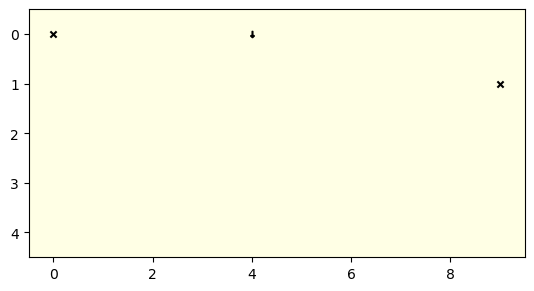

current Design
[(0, 7)]


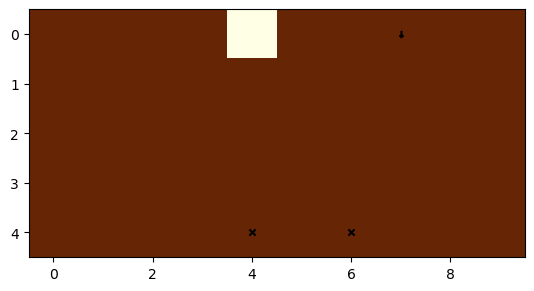

curr_reward 3.4320295383319217
accumulated_reward 0
current Design
[(0, 7)]


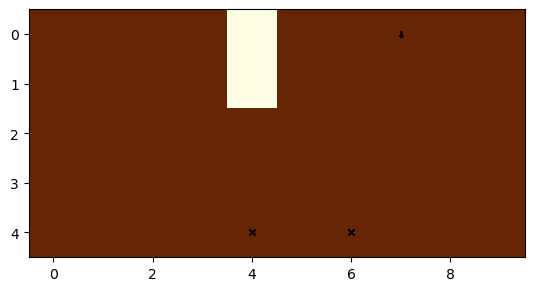

curr_reward 5.859251966996342
accumulated_reward 0
current Design
[(0, 7)]


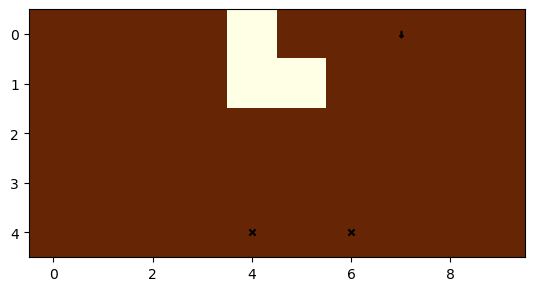

curr_reward 8.262190040421395
accumulated_reward 0
current Design
[(0, 7)]


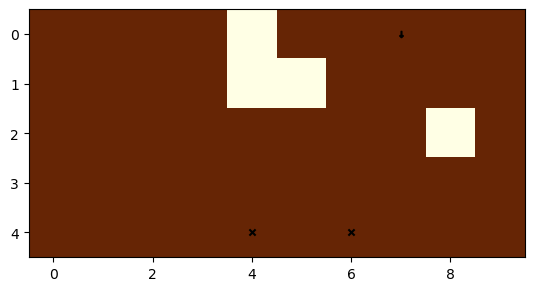

curr_reward 11.091769058093158
accumulated_reward 0
current Design
[(0, 7)]


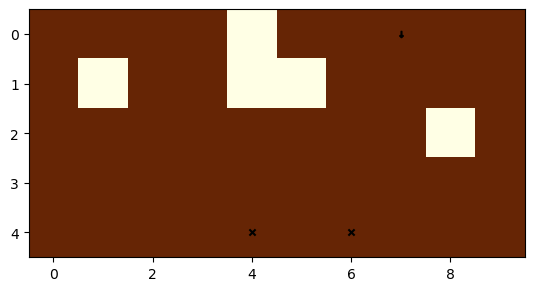

curr_reward 13.251919237233375
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 180000
Best mean reward: -392.23 - Last mean reward per episode: -398.64
current Design
[(0, 6)]


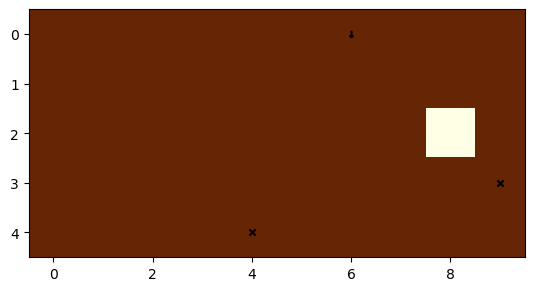

hello hello
--------------------------------------------------
Num timesteps: 190000
Best mean reward: -392.23 - Last mean reward per episode: -402.80
current Design
[(4, 6)]


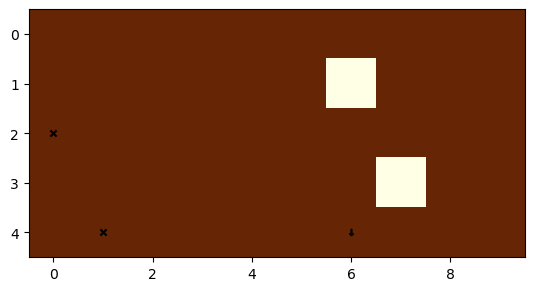

hello hello
--------------------------------------------------
Num timesteps: 200000
Best mean reward: -392.23 - Last mean reward per episode: -410.19
current Design
[(3, 0)]


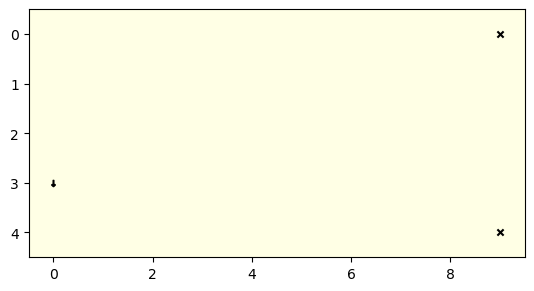

hello hello
--------------------------------------------------
Num timesteps: 210000
Best mean reward: -392.23 - Last mean reward per episode: -405.84
current Design
[(0, 7)]


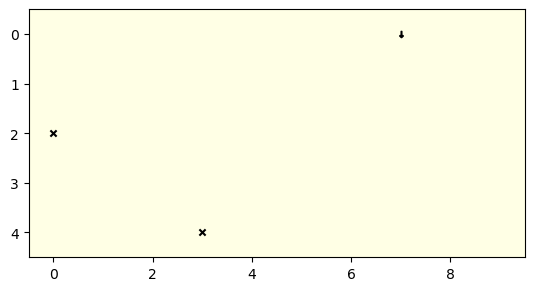

current Design
[(1, 0)]


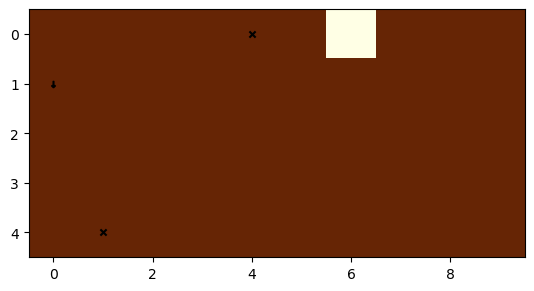

curr_reward 3.836085726490755
accumulated_reward 0
current Design
[(1, 0)]


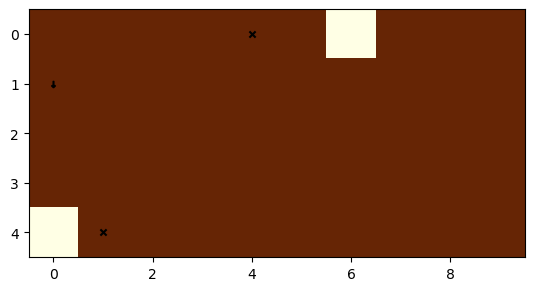

curr_reward 7.5170456597937605
accumulated_reward 0
current Design
[(1, 0)]


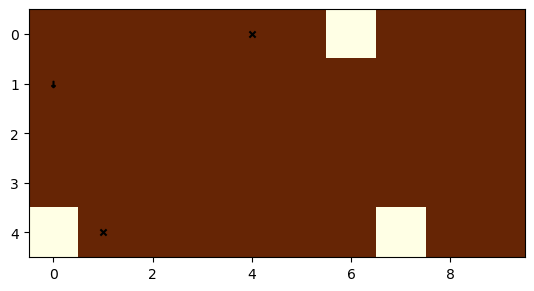

curr_reward 10.772536542619363
accumulated_reward 0
current Design
[(1, 0)]


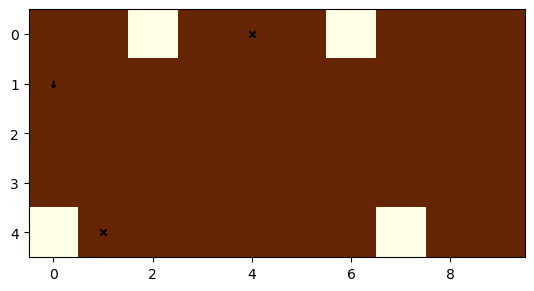

curr_reward 13.910456957362953
accumulated_reward 0
current Design
[(1, 0)]


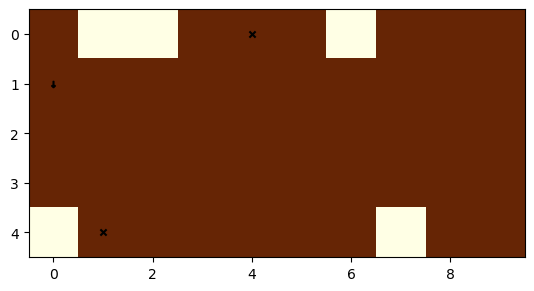

curr_reward 16.39814019694435
accumulated_reward 0
current Design
[(1, 0)]


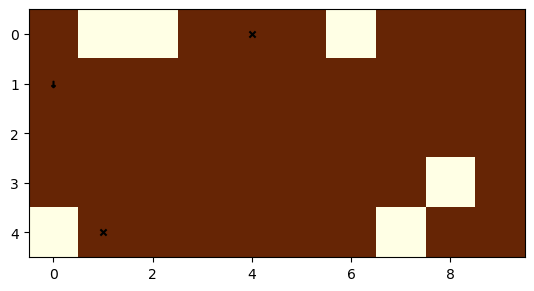

curr_reward 18.804873973042703
accumulated_reward 0
current Design
[(1, 0)]


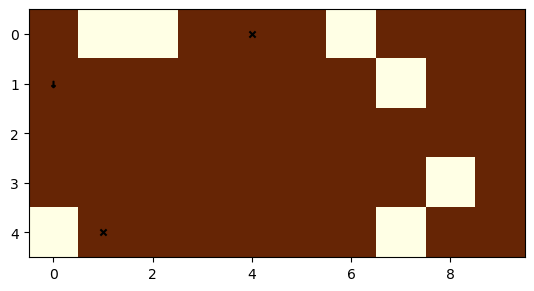

curr_reward 20.940595540468685
accumulated_reward 0
current Design
[(1, 0)]


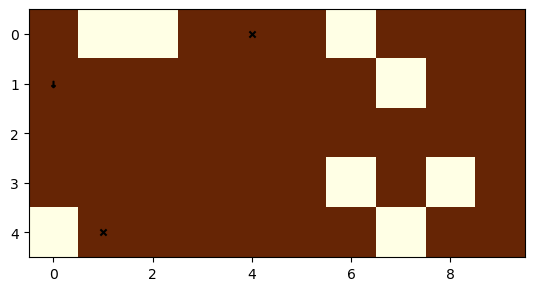

curr_reward 22.813604172376323
accumulated_reward 0
current Design
[(1, 0)]


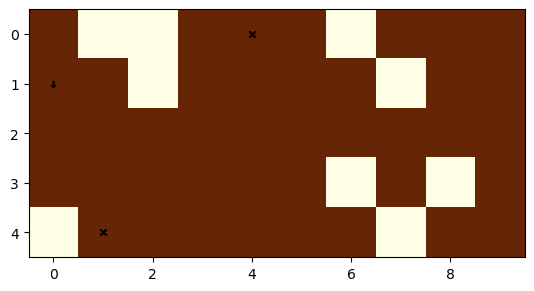

curr_reward 24.902500643790436
accumulated_reward 0
current Design
[(1, 0)]


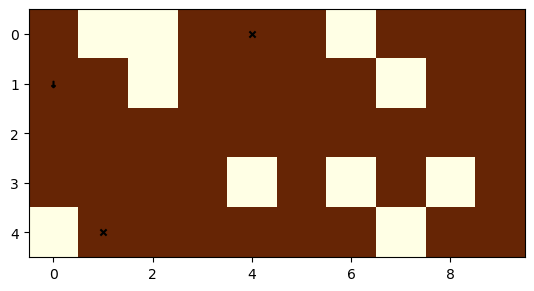

curr_reward 26.45946742163035
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 220000
Best mean reward: -392.23 - Last mean reward per episode: -404.70
current Design
[(4, 5)]


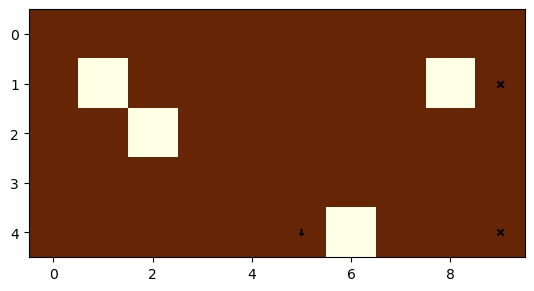

hello hello
--------------------------------------------------
Num timesteps: 230000
Best mean reward: -392.23 - Last mean reward per episode: -389.68
current Design
[(0, 0)]


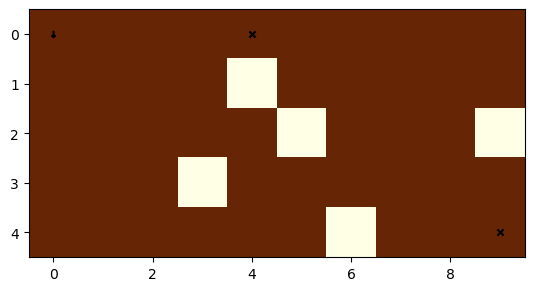

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 240000
Best mean reward: -389.68 - Last mean reward per episode: -391.47
current Design
[(2, 0)]


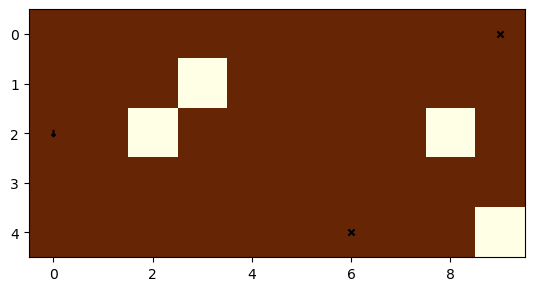

hello hello
--------------------------------------------------
Num timesteps: 250000
Best mean reward: -389.68 - Last mean reward per episode: -384.35
current Design
[(4, 3)]


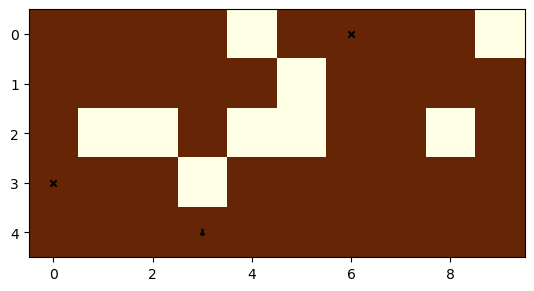

Saving new best model to log/best_model.zip
current Design
[(3, 9)]


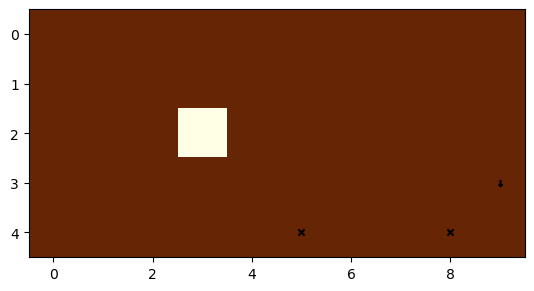

curr_reward 3.897795935721675
accumulated_reward 0
current Design
[(3, 9)]


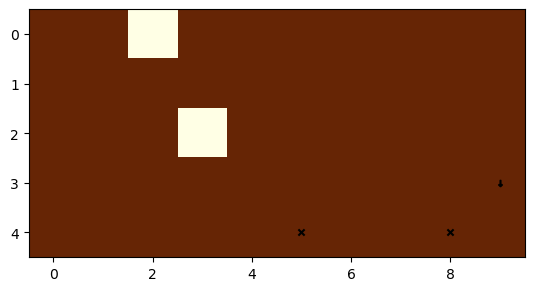

curr_reward 7.620627368031787
accumulated_reward 0
current Design
[(3, 9)]


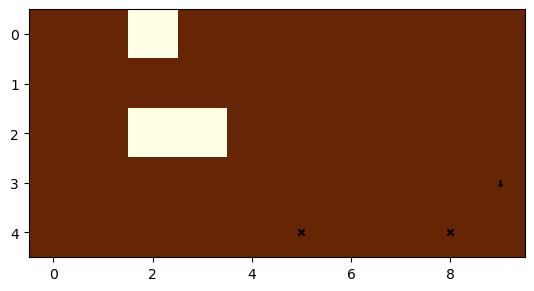

curr_reward 11.05407500184026
accumulated_reward 0
current Design
[(3, 9)]


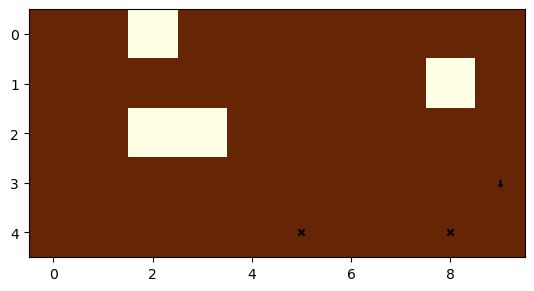

curr_reward 13.602802457301003
accumulated_reward 0
current Design
[(3, 9)]


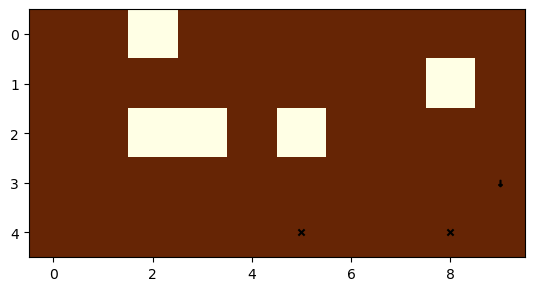

curr_reward 16.86752418745724
accumulated_reward 0
current Design
[(3, 9)]


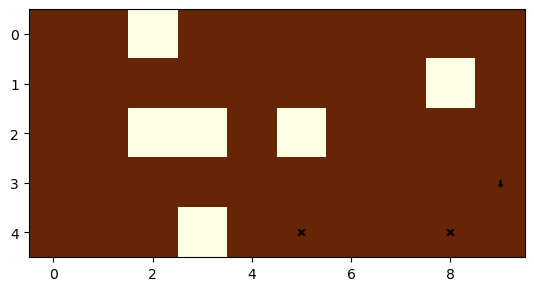

curr_reward 19.396945285761444
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 260000
Best mean reward: -384.35 - Last mean reward per episode: -403.49
current Design
[(1, 9)]


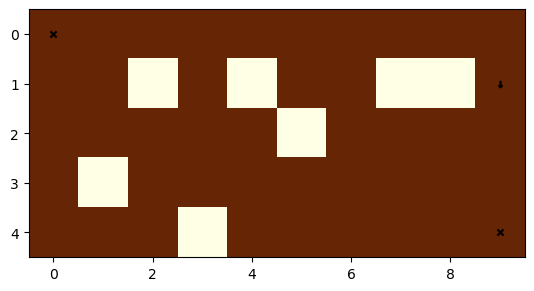

hello hello
--------------------------------------------------
Num timesteps: 270000
Best mean reward: -384.35 - Last mean reward per episode: -382.82
current Design
[(0, 9)]


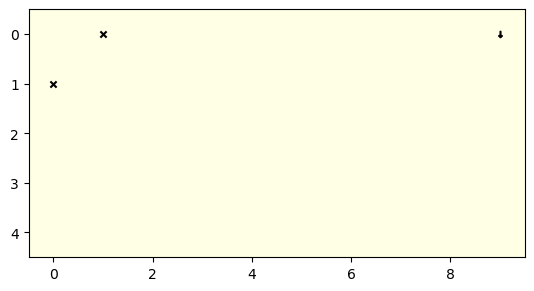

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 280000
Best mean reward: -382.82 - Last mean reward per episode: -392.82
current Design
[(3, 0)]


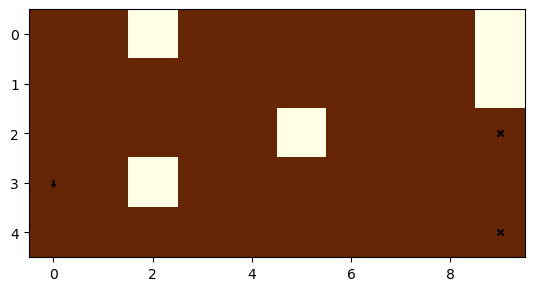

hello hello
--------------------------------------------------
Num timesteps: 290000
Best mean reward: -382.82 - Last mean reward per episode: -398.46
current Design
[(3, 9)]


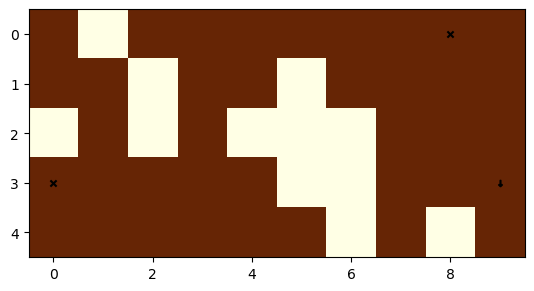

current Design
[(4, 3)]


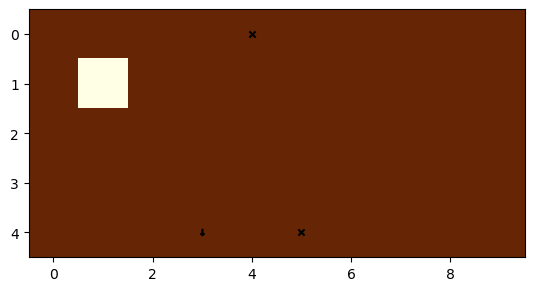

curr_reward 3.8239786319333464
accumulated_reward 0
current Design
[(4, 3)]


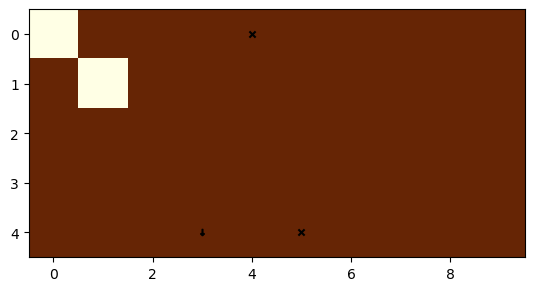

curr_reward 7.7257927619305615
accumulated_reward 0
current Design
[(4, 3)]


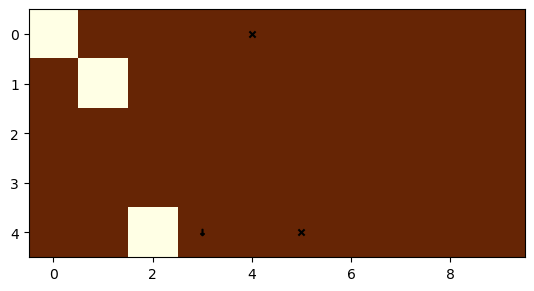

curr_reward 19.46268257518286
accumulated_reward 0
current Design
[(4, 3)]


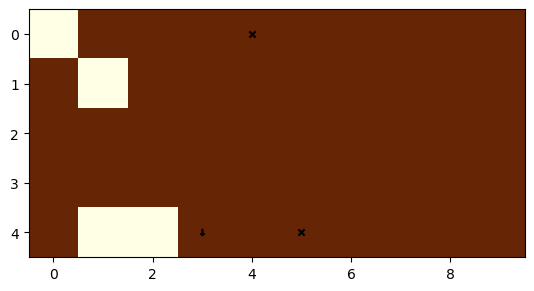

curr_reward 25.242242029115445
accumulated_reward 0
current Design
[(4, 3)]


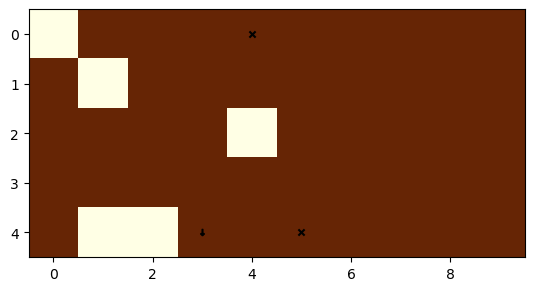

curr_reward 28.68910256351511
accumulated_reward 0
current Design
[(4, 3)]


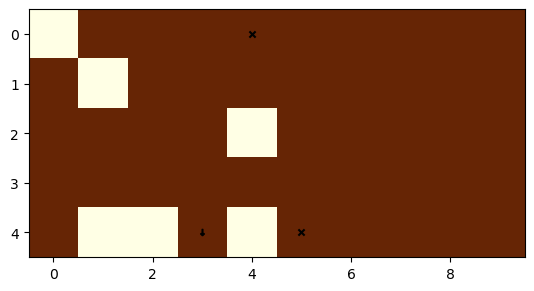

curr_reward 5.349114421086232
accumulated_reward 0
current Design
[(4, 3)]


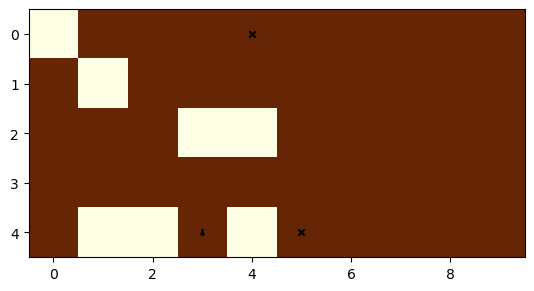

curr_reward 8.122368851096265
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 300000
Best mean reward: -382.82 - Last mean reward per episode: -368.44
current Design
[(0, 4)]


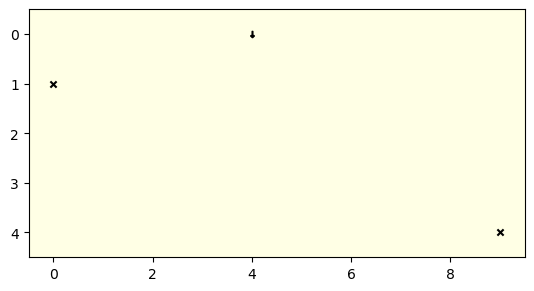

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 310000
Best mean reward: -368.44 - Last mean reward per episode: -382.02
current Design
[(2, 9)]


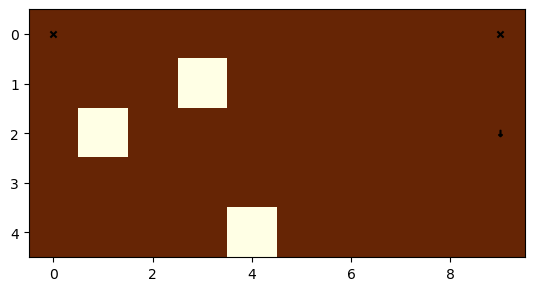

hello hello
--------------------------------------------------
Num timesteps: 320000
Best mean reward: -368.44 - Last mean reward per episode: -369.71
current Design
[(1, 0)]


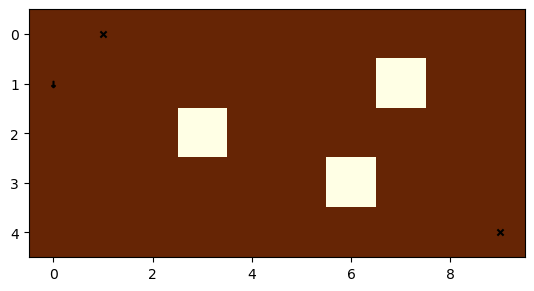

hello hello
--------------------------------------------------
Num timesteps: 330000
Best mean reward: -368.44 - Last mean reward per episode: -377.81
current Design
[(0, 0)]


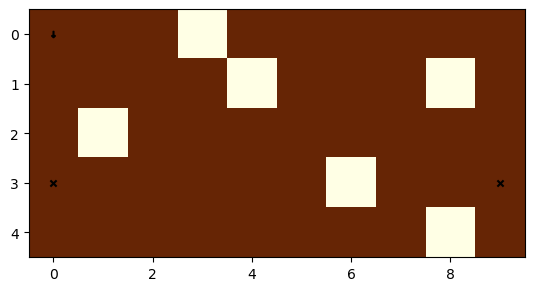

current Design
[(1, 0)]


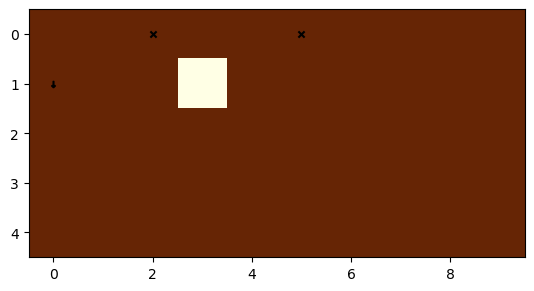

curr_reward 3.689954619764046
accumulated_reward 0
current Design
[(1, 0)]


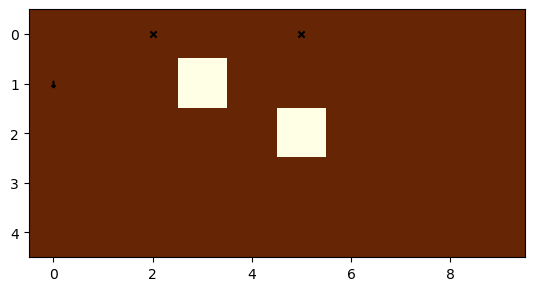

curr_reward 7.099108016225651
accumulated_reward 0
current Design
[(1, 0)]


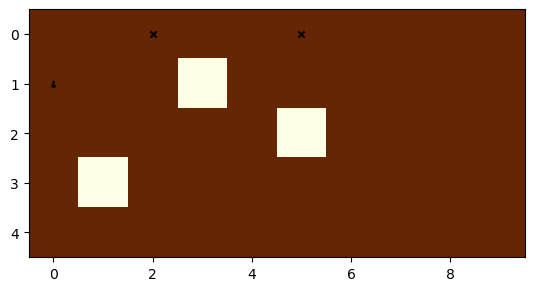

curr_reward 11.215909541817432
accumulated_reward 0
current Design
[(1, 0)]


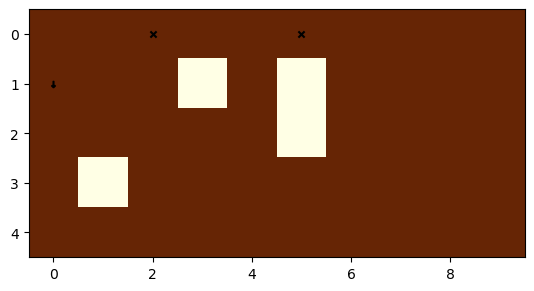

curr_reward 14.548550753766815
accumulated_reward 0
current Design
[(1, 0)]


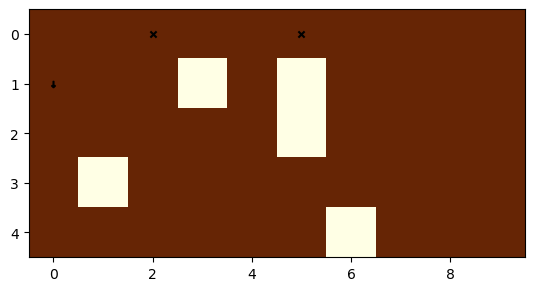

curr_reward 17.485307988475366
accumulated_reward 0
current Design
[(1, 0)]


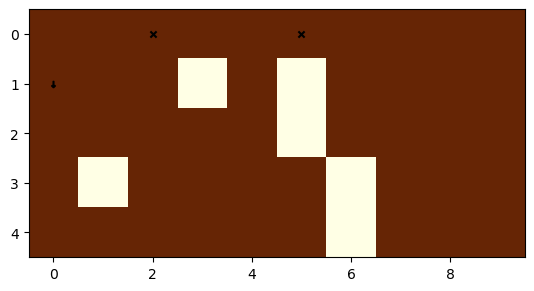

curr_reward 20.836589894555452
accumulated_reward 0
current Design
[(1, 0)]


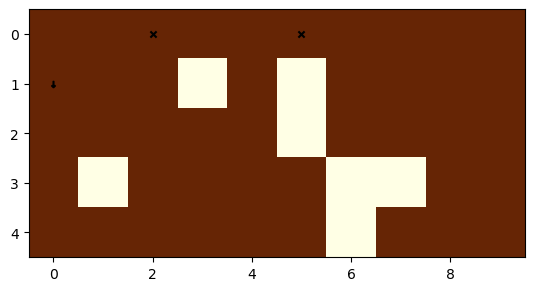

curr_reward 23.2858845889069
accumulated_reward 0
current Design
[(1, 0)]


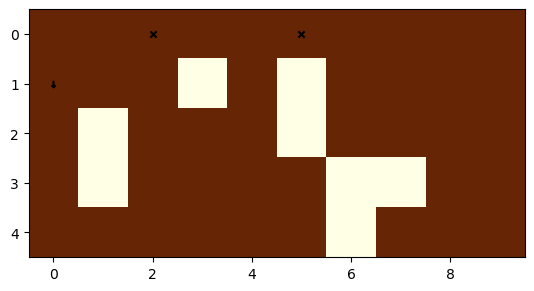

curr_reward 32.51515427672407
accumulated_reward 0
current Design
[(1, 0)]


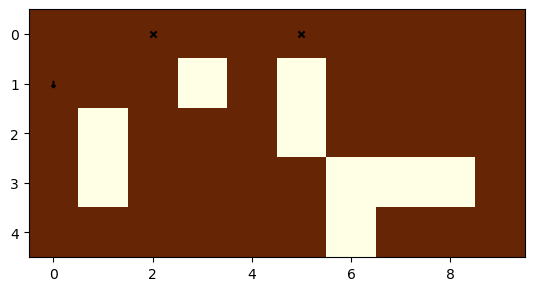

curr_reward 34.87725334269571
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 340000
Best mean reward: -368.44 - Last mean reward per episode: -371.06
current Design
[(4, 9)]


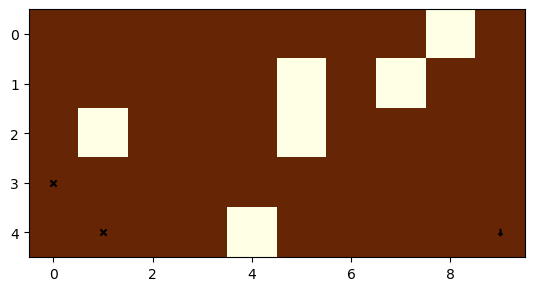

hello hello
--------------------------------------------------
Num timesteps: 350000
Best mean reward: -368.44 - Last mean reward per episode: -380.39
current Design
[(4, 1)]


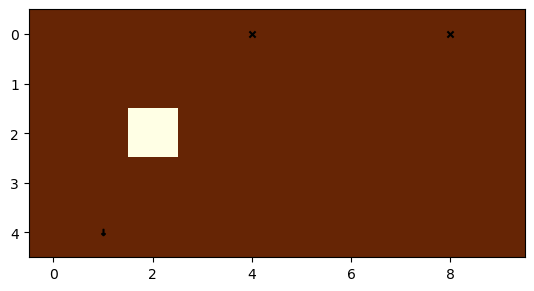

hello hello
--------------------------------------------------
Num timesteps: 360000
Best mean reward: -368.44 - Last mean reward per episode: -364.12
current Design
[(0, 6)]


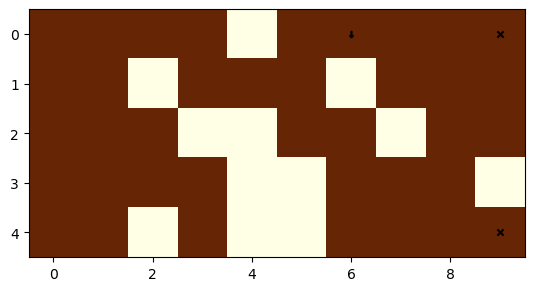

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 370000
Best mean reward: -364.12 - Last mean reward per episode: -373.32
current Design
[(4, 3)]


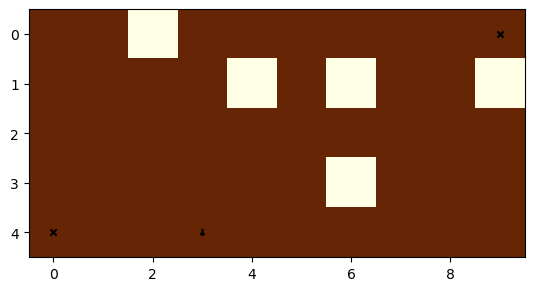

current Design
[(0, 4)]


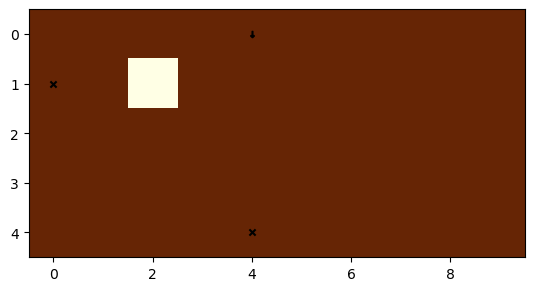

curr_reward 3.4206840861931602
accumulated_reward 0
current Design
[(0, 4)]


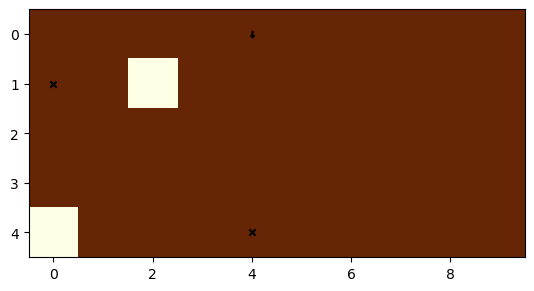

curr_reward 6.560668153765757
accumulated_reward 0
current Design
[(0, 4)]


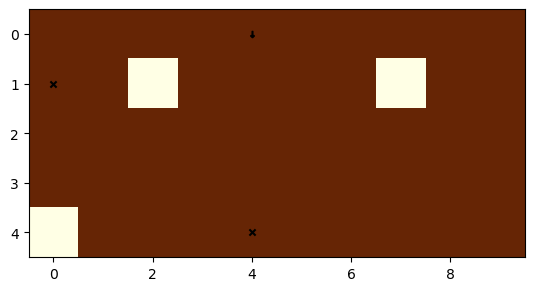

curr_reward 9.539334583374945
accumulated_reward 0
current Design
[(0, 4)]


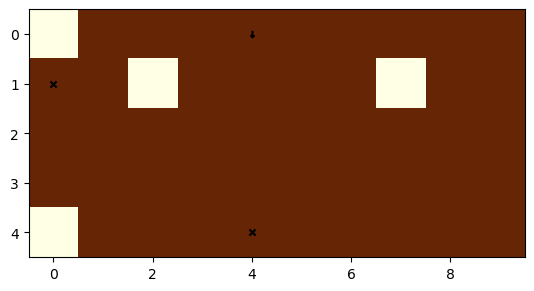

curr_reward 11.301841803031014
accumulated_reward 0
current Design
[(0, 4)]


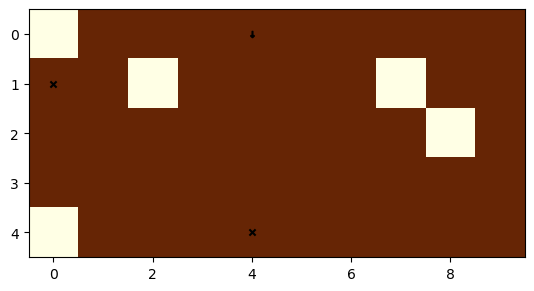

curr_reward 13.599632341726235
accumulated_reward 0
current Design
[(0, 4)]


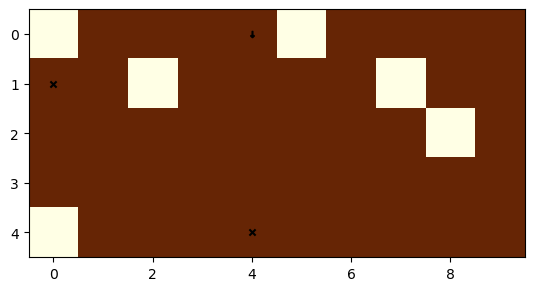

curr_reward 18.35975613841294
accumulated_reward 0
current Design
[(0, 4)]


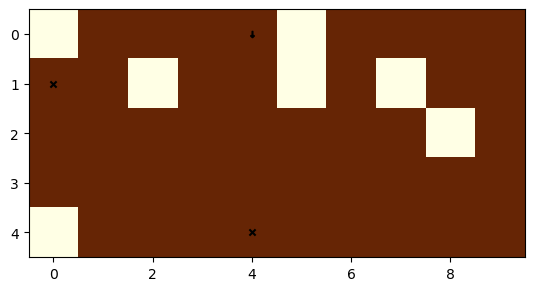

curr_reward 28.618359353522905
accumulated_reward 0
current Design
[(0, 4)]


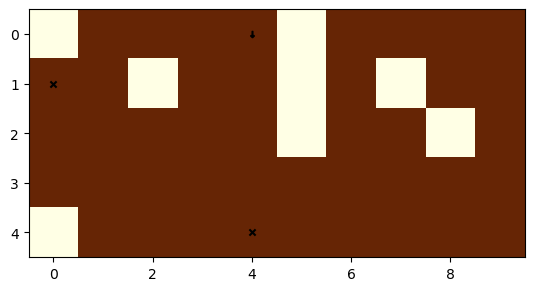

curr_reward 53.4886300029114
accumulated_reward 0
current Design
[(0, 4)]


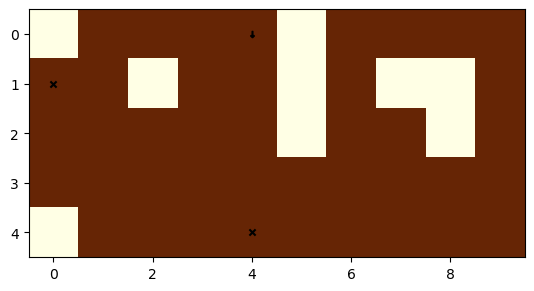

curr_reward 57.342006904079305
accumulated_reward 0
current Design
[(0, 4)]


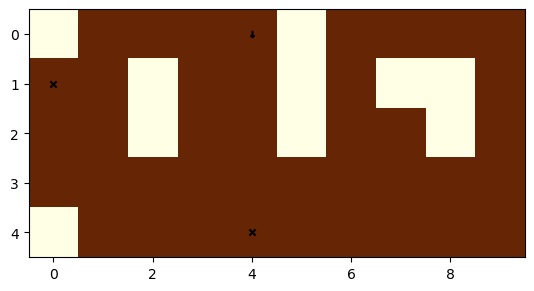

curr_reward 42.26444267737007
accumulated_reward 0
current Design
[(0, 4)]


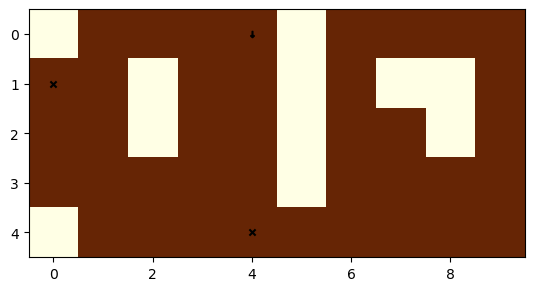

curr_reward 95.26677179100047
accumulated_reward 0
current Design
[(0, 4)]


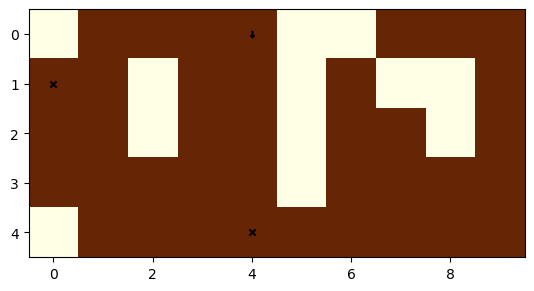

curr_reward 98.66610612602724
accumulated_reward 0
current Design
[(0, 4)]


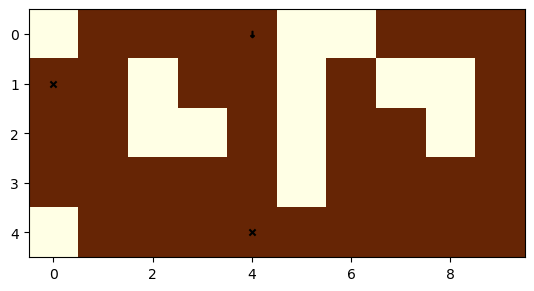

curr_reward 90.05816772795886
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 380000
Best mean reward: -364.12 - Last mean reward per episode: -354.02
current Design
[(2, 9)]


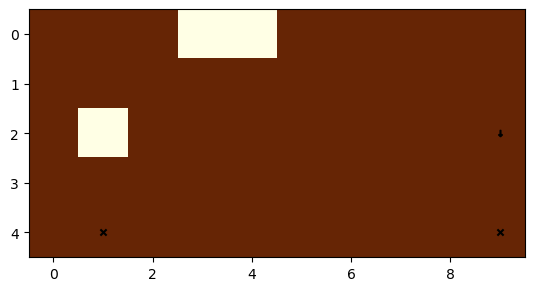

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 390000
Best mean reward: -354.02 - Last mean reward per episode: -368.00
current Design
[(2, 9)]


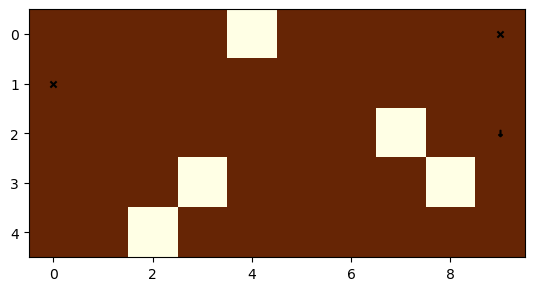

hello hello
--------------------------------------------------
Num timesteps: 400000
Best mean reward: -354.02 - Last mean reward per episode: -359.48
current Design
[(4, 0)]


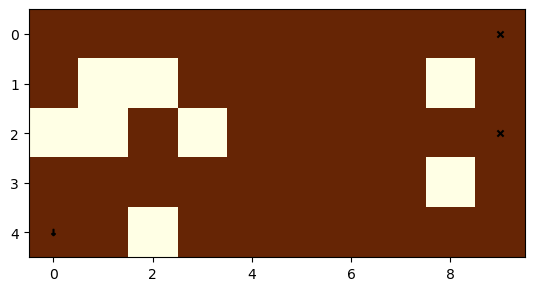

hello hello
--------------------------------------------------
Num timesteps: 410000
Best mean reward: -354.02 - Last mean reward per episode: -349.46
current Design
[(0, 2)]


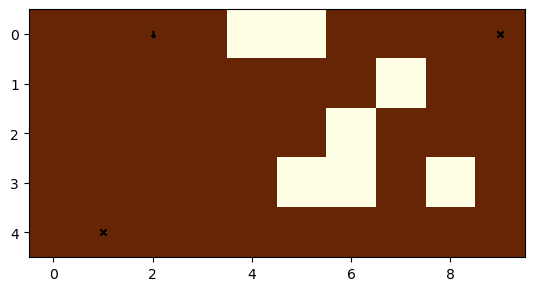

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 420000
Best mean reward: -349.46 - Last mean reward per episode: -357.58
current Design
[(0, 0)]


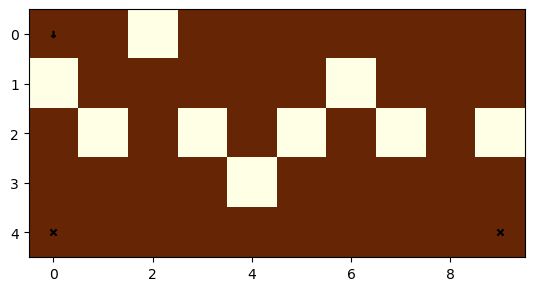

current Design
[(1, 9)]


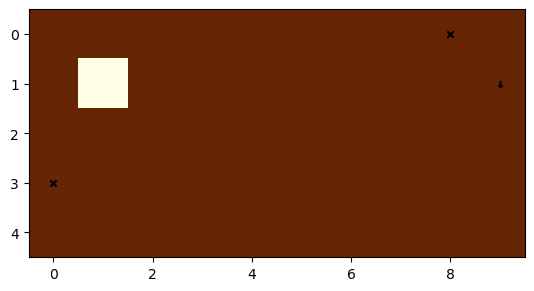

curr_reward 3.848024608081851
accumulated_reward 0
current Design
[(1, 9)]


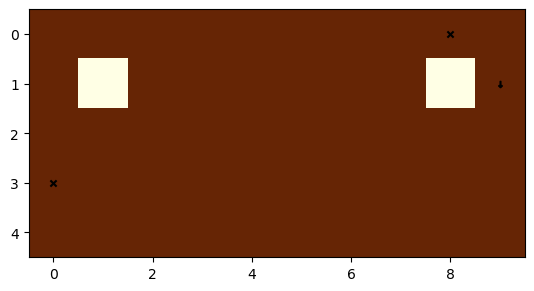

curr_reward 6.9613428575570975
accumulated_reward 0
current Design
[(1, 9)]


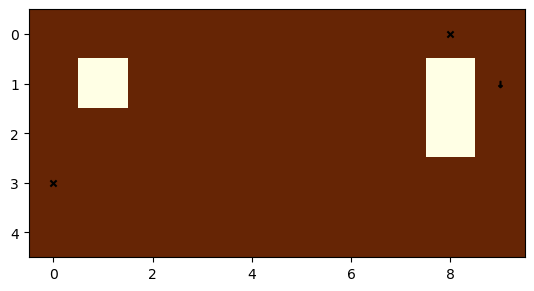

curr_reward 10.761007723070783
accumulated_reward 0
current Design
[(1, 9)]


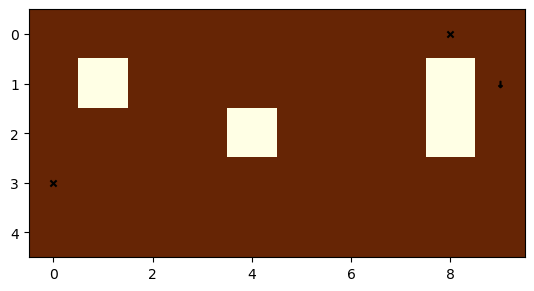

curr_reward 13.802195953372841
accumulated_reward 0
current Design
[(1, 9)]


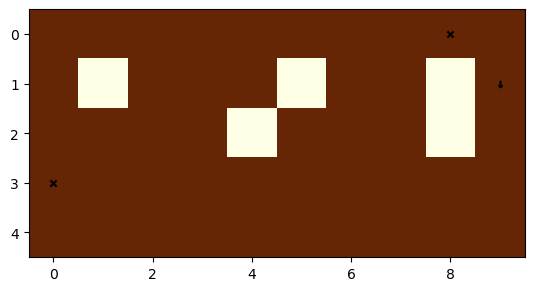

curr_reward 16.52934702253557
accumulated_reward 0
current Design
[(1, 9)]


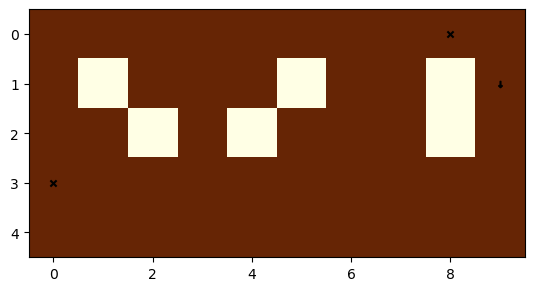

curr_reward 19.082683758511152
accumulated_reward 0
current Design
[(1, 9)]


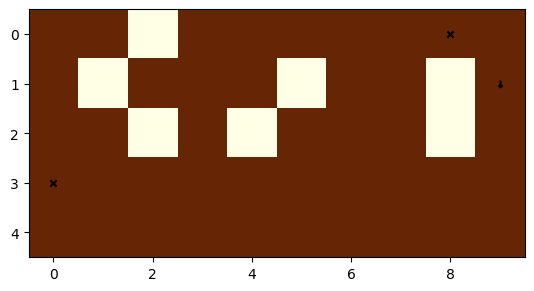

curr_reward 21.4599039435147
accumulated_reward 0
current Design
[(1, 9)]


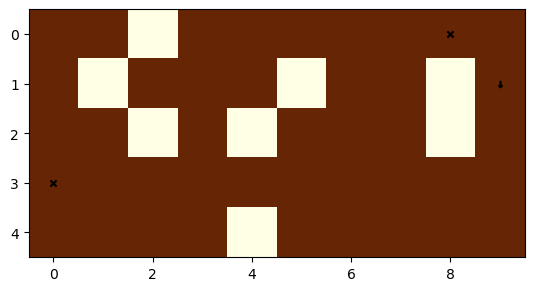

curr_reward 23.54055319947372
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 430000
Best mean reward: -349.46 - Last mean reward per episode: -371.45
current Design
[(4, 9)]


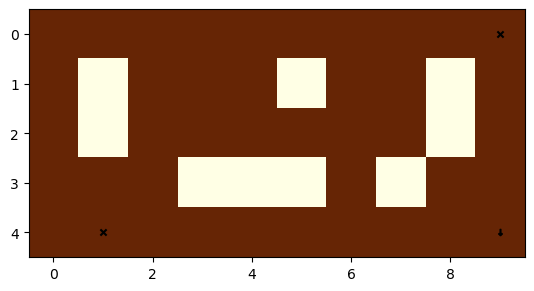

hello hello
--------------------------------------------------
Num timesteps: 440000
Best mean reward: -349.46 - Last mean reward per episode: -338.43
current Design
[(4, 5)]


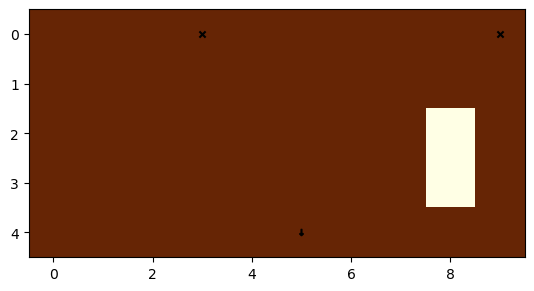

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 450000
Best mean reward: -338.43 - Last mean reward per episode: -352.93
current Design
[(4, 9)]


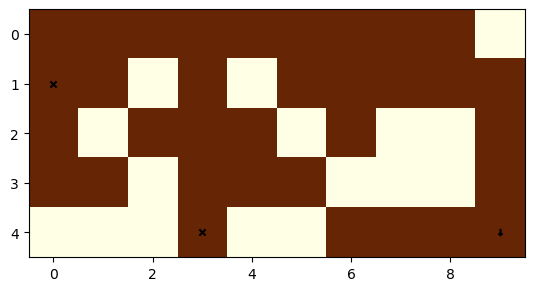

hello hello
--------------------------------------------------
Num timesteps: 460000
Best mean reward: -338.43 - Last mean reward per episode: -344.78
current Design
[(4, 0)]


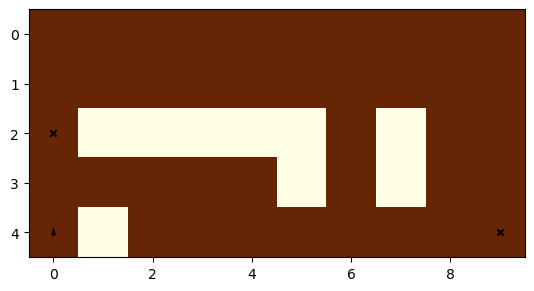

current Design
[(0, 8)]


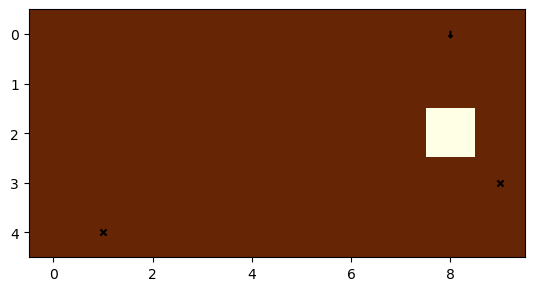

curr_reward 3.93664549630315
accumulated_reward 0
current Design
[(0, 8)]


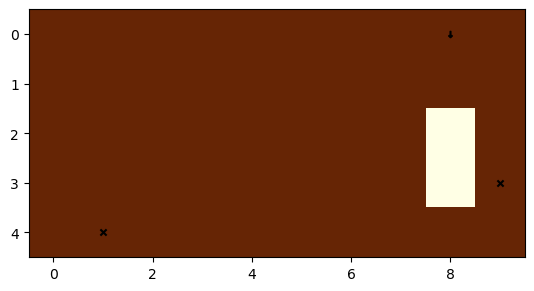

curr_reward 8.945263134753132
accumulated_reward 0
current Design
[(0, 8)]


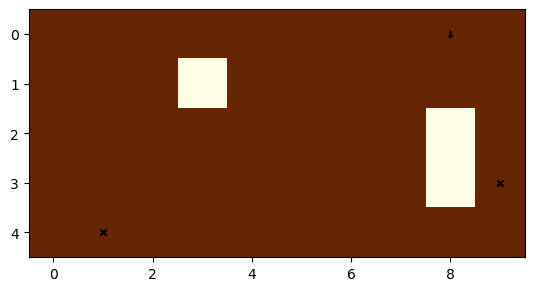

curr_reward 12.630574363237779
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 470000
Best mean reward: -338.43 - Last mean reward per episode: -341.70
current Design
[(0, 8)]


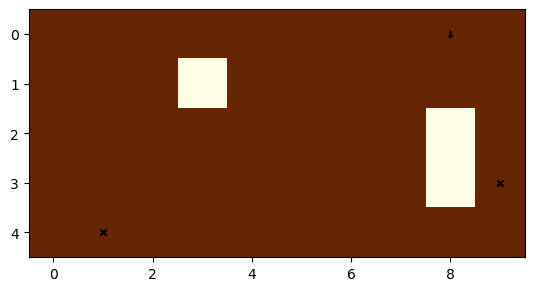

current Design
[(0, 8)]


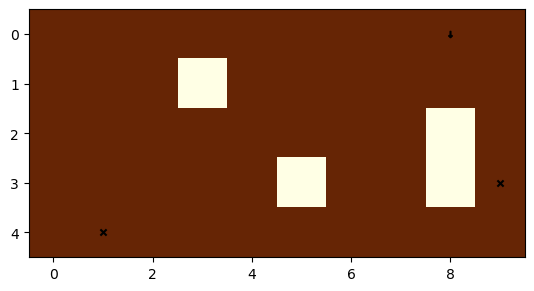

curr_reward 15.908390545121959
accumulated_reward 0
current Design
[(0, 8)]


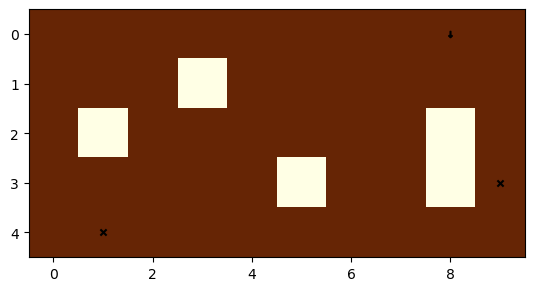

curr_reward 18.735378866968503
accumulated_reward 0
current Design
[(0, 8)]


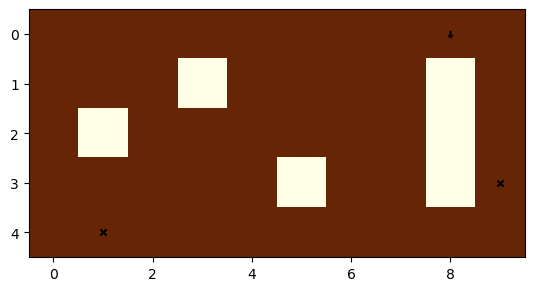

curr_reward 25.80391443711638
accumulated_reward 0
current Design
[(0, 8)]


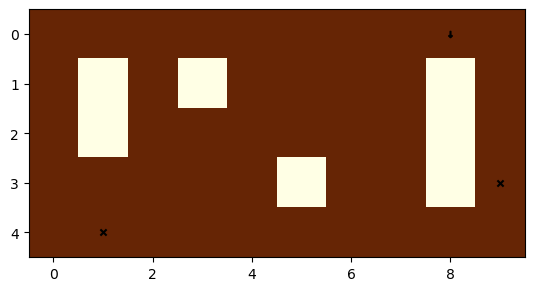

curr_reward 28.282649306062574
accumulated_reward 0
current Design
[(0, 8)]


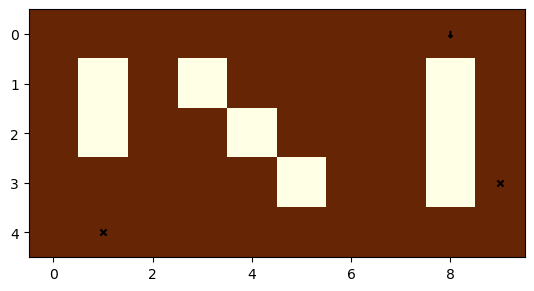

curr_reward 29.652211093253293
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 480000
Best mean reward: -338.43 - Last mean reward per episode: -332.32
current Design
[(1, 9)]


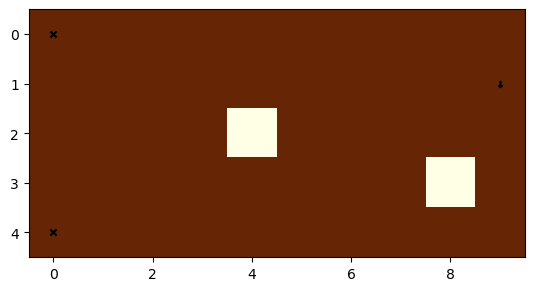

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 490000
Best mean reward: -332.32 - Last mean reward per episode: -348.90
current Design
[(4, 9)]


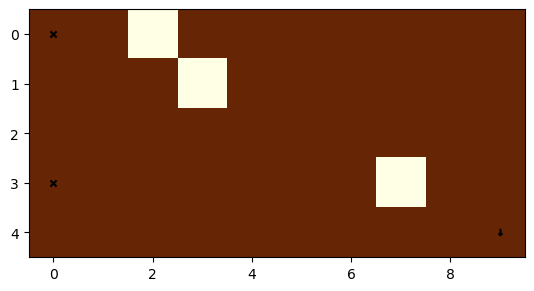

hello hello
--------------------------------------------------
Num timesteps: 500000
Best mean reward: -332.32 - Last mean reward per episode: -335.23
current Design
[(0, 2)]


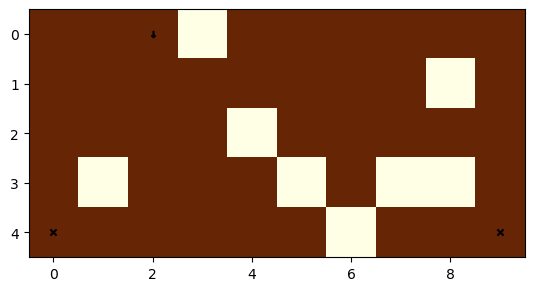

hello hello
--------------------------------------------------
Num timesteps: 510000
Best mean reward: -332.32 - Last mean reward per episode: -335.60
current Design
[(4, 0)]


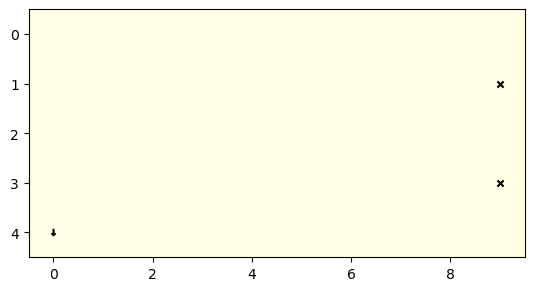

hello hello
--------------------------------------------------
Num timesteps: 520000
Best mean reward: -332.32 - Last mean reward per episode: -302.20
current Design
[(3, 0)]


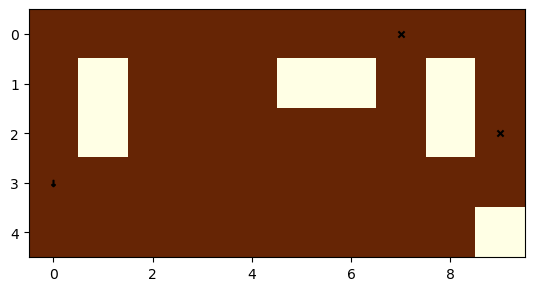

Saving new best model to log/best_model.zip
current Design
[(3, 0)]


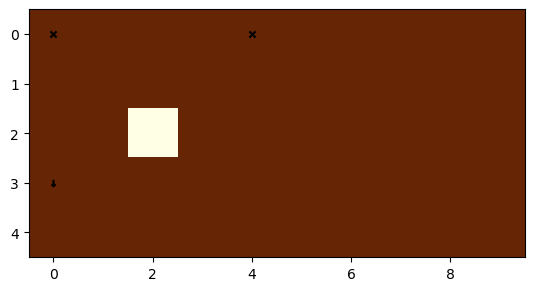

curr_reward 4.000863949104209
accumulated_reward 0
current Design
[(3, 0)]


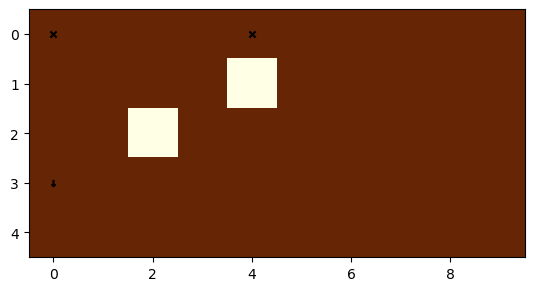

curr_reward 7.587355758113831
accumulated_reward 0
current Design
[(3, 0)]


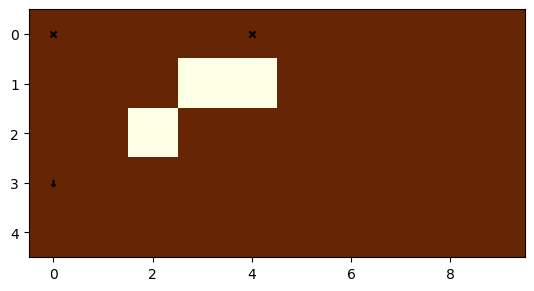

curr_reward 10.712187117599086
accumulated_reward 0
current Design
[(3, 0)]


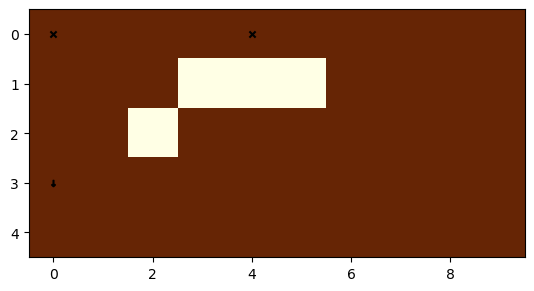

curr_reward 12.822865030820116
accumulated_reward 0
current Design
[(3, 0)]


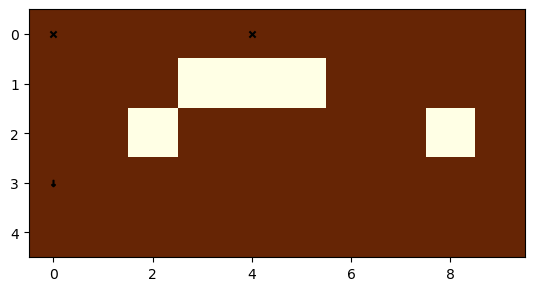

curr_reward 15.367162644957288
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 530000
Best mean reward: -302.20 - Last mean reward per episode: -287.25
current Design
[(0, 7)]


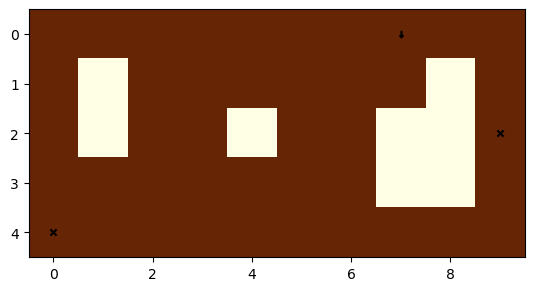

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 540000
Best mean reward: -287.25 - Last mean reward per episode: -289.41
current Design
[(0, 7)]


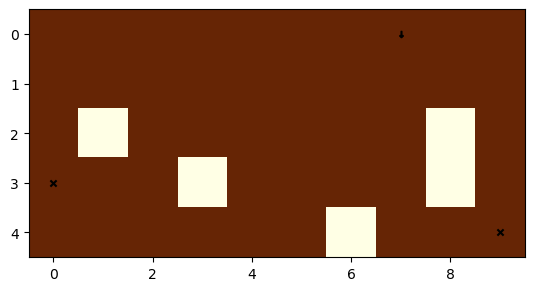

hello hello
--------------------------------------------------
Num timesteps: 550000
Best mean reward: -287.25 - Last mean reward per episode: -282.63
current Design
[(4, 3)]


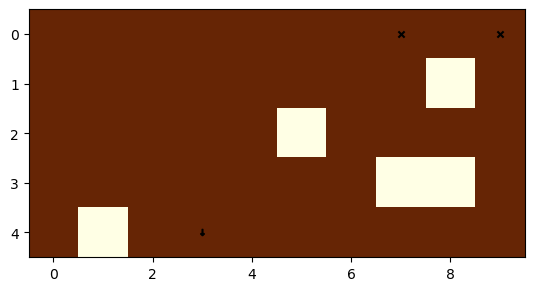

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 560000
Best mean reward: -282.63 - Last mean reward per episode: -276.46
current Design
[(4, 6)]


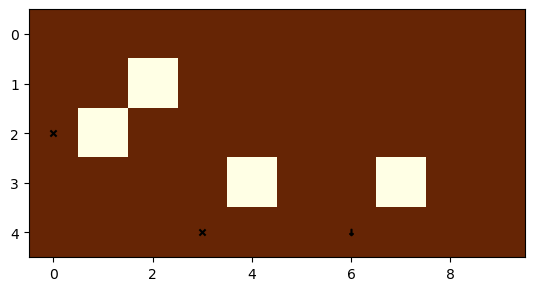

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 570000
Best mean reward: -276.46 - Last mean reward per episode: -289.75
current Design
[(4, 2)]


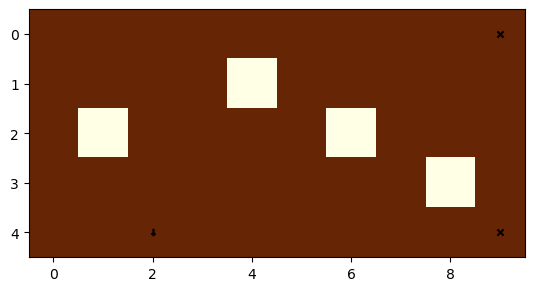

current Design
[(2, 9)]


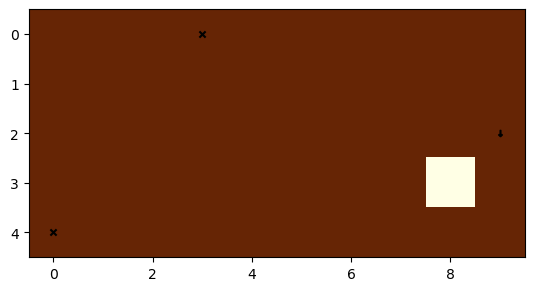

curr_reward 3.8966464046556104
accumulated_reward 0
current Design
[(2, 9)]


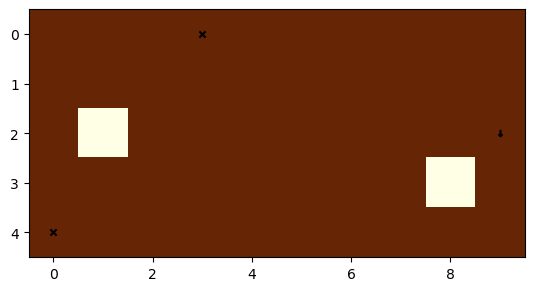

curr_reward 7.4736084752062855
accumulated_reward 0
current Design
[(2, 9)]


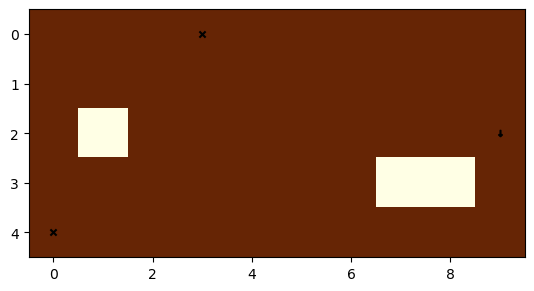

curr_reward 10.794253920483554
accumulated_reward 0
current Design
[(2, 9)]


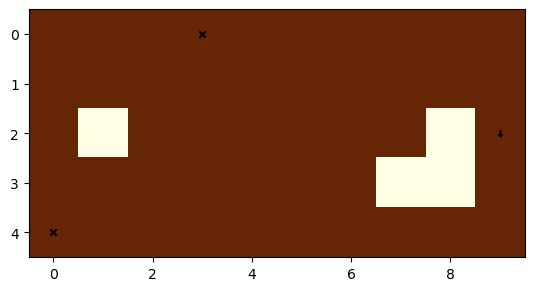

curr_reward 13.842222494636548
accumulated_reward 0
current Design
[(2, 9)]


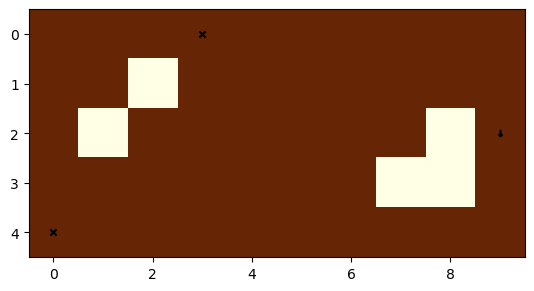

curr_reward 16.521936003429794
accumulated_reward 0
current Design
[(2, 9)]


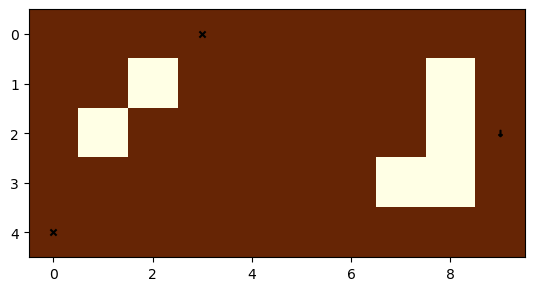

curr_reward 18.66141952507902
accumulated_reward 0
current Design
[(2, 9)]


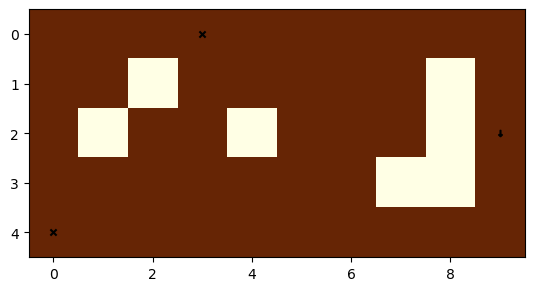

curr_reward 21.020274484137488
accumulated_reward 0
current Design
[(2, 9)]


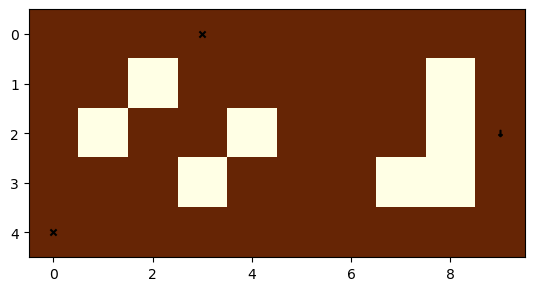

curr_reward 22.97996681706364
accumulated_reward 0
current Design
[(2, 9)]


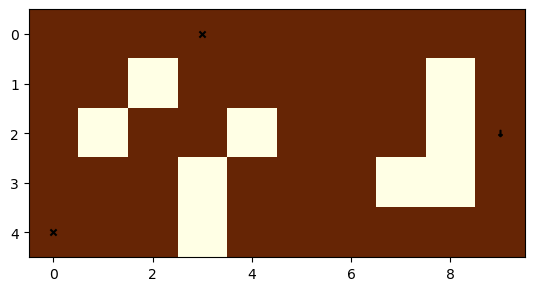

curr_reward 24.439526647553002
accumulated_reward 0
current Design
[(2, 9)]


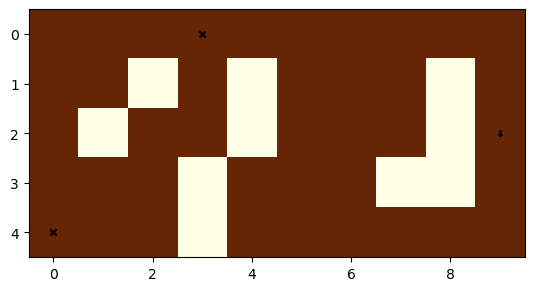

curr_reward 24.725153723545173
accumulated_reward 0
current Design
[(2, 9)]


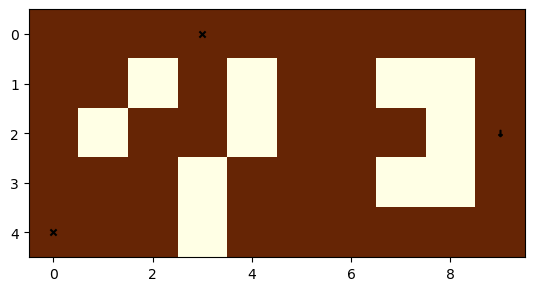

curr_reward 26.391774690094703
accumulated_reward 0
current Design
[(2, 9)]


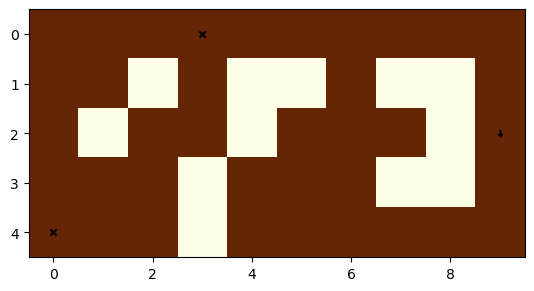

curr_reward 28.219008295301336
accumulated_reward 0
current Design
[(2, 9)]


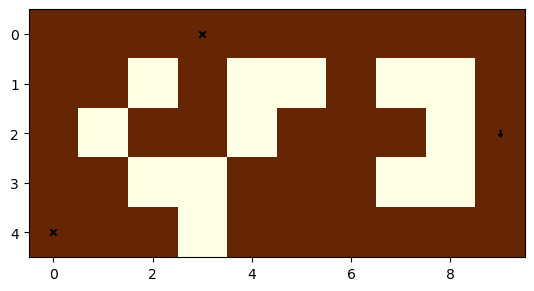

curr_reward 29.114162251949015
accumulated_reward 0
current Design
[(2, 9)]


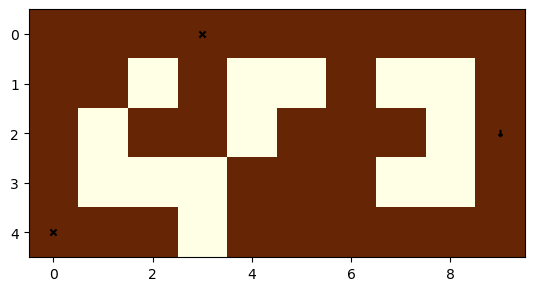

curr_reward 29.518220375887676
accumulated_reward 0
current Design
[(2, 9)]


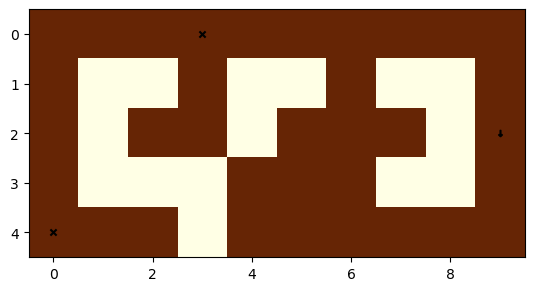

curr_reward 29.520259933328276
accumulated_reward 0
current Design
[(2, 9)]


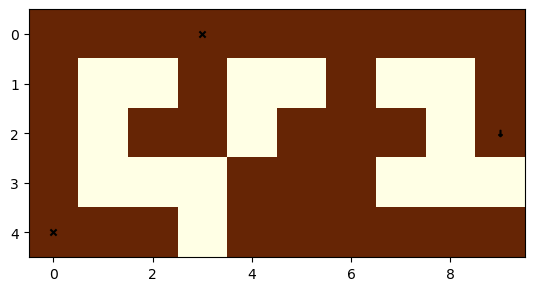

curr_reward 27.249212089620634
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 580000
Best mean reward: -276.46 - Last mean reward per episode: -287.52
current Design
[(0, 6)]


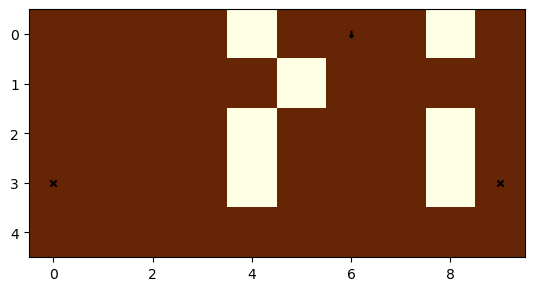

hello hello
--------------------------------------------------
Num timesteps: 590000
Best mean reward: -276.46 - Last mean reward per episode: -304.59
current Design
[(4, 7)]


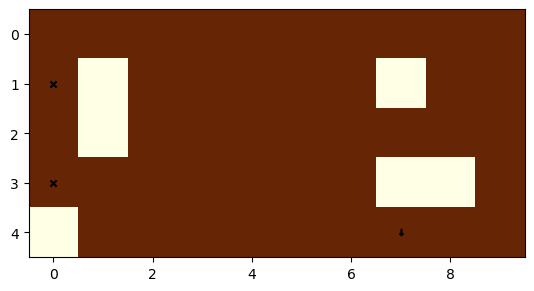

hello hello
--------------------------------------------------
Num timesteps: 600000
Best mean reward: -276.46 - Last mean reward per episode: -285.04
current Design
[(0, 9)]


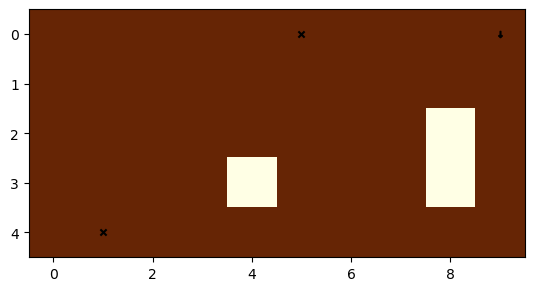

hello hello
--------------------------------------------------
Num timesteps: 610000
Best mean reward: -276.46 - Last mean reward per episode: -291.71
current Design
[(3, 0)]


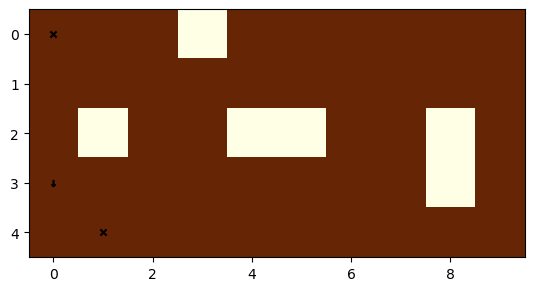

hello hello
--------------------------------------------------
Num timesteps: 620000
Best mean reward: -276.46 - Last mean reward per episode: -279.58
current Design
[(4, 1)]


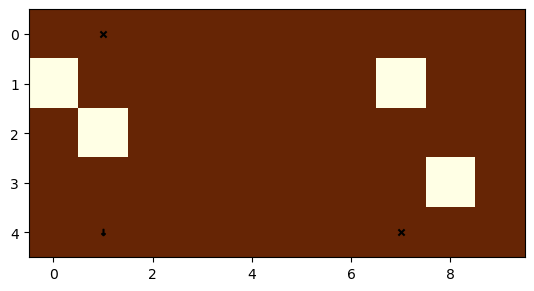

hello hello
--------------------------------------------------
Num timesteps: 630000
Best mean reward: -276.46 - Last mean reward per episode: -280.10
current Design
[(2, 9)]


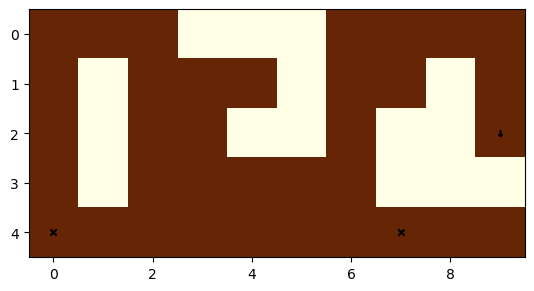

current Design
[(4, 9)]


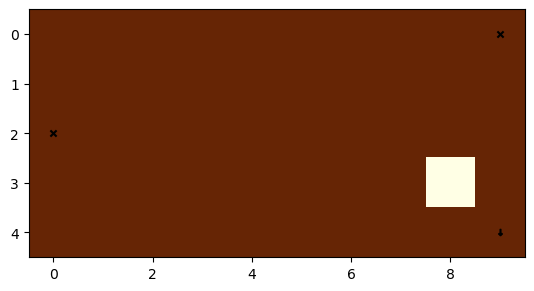

curr_reward 3.8592256751033074
accumulated_reward 0
current Design
[(4, 9)]


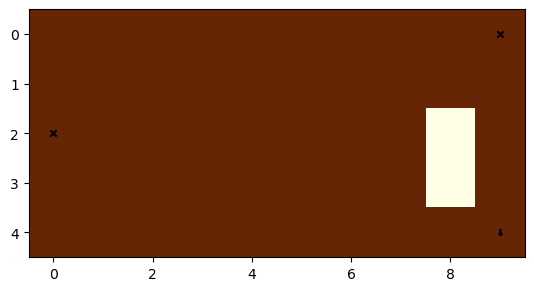

curr_reward 7.34763759975499
accumulated_reward 0
current Design
[(4, 9)]


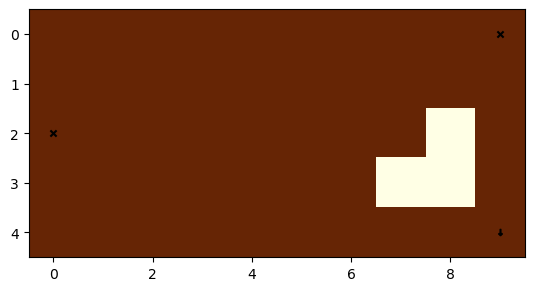

curr_reward 10.596404130212298
accumulated_reward 0
current Design
[(4, 9)]


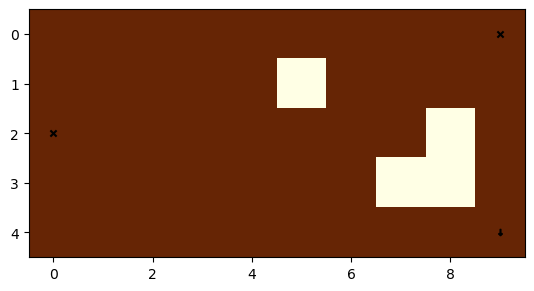

curr_reward 13.510930557680199
accumulated_reward 0
current Design
[(4, 9)]


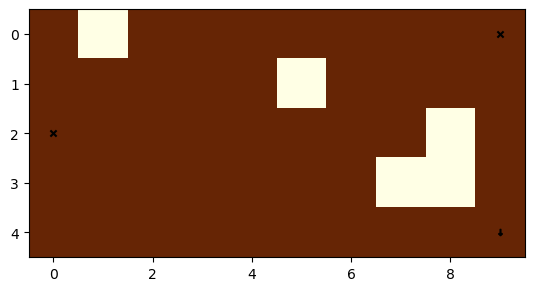

curr_reward 16.49551663502138
accumulated_reward 0
current Design
[(4, 9)]


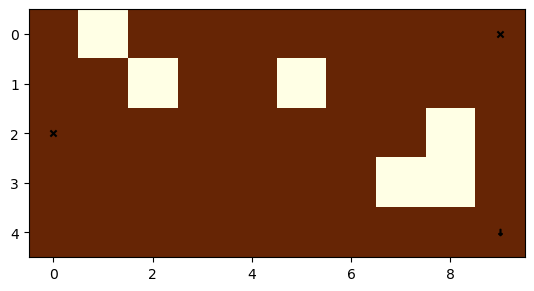

curr_reward 19.258584083793995
accumulated_reward 0
current Design
[(4, 9)]


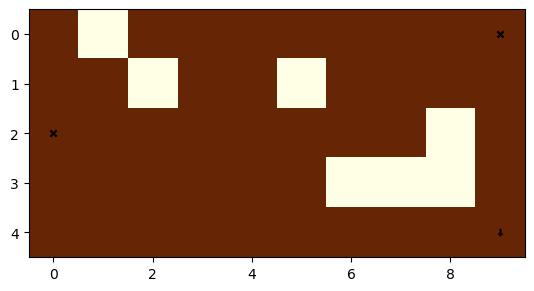

curr_reward 21.46440434029406
accumulated_reward 0
current Design
[(4, 9)]


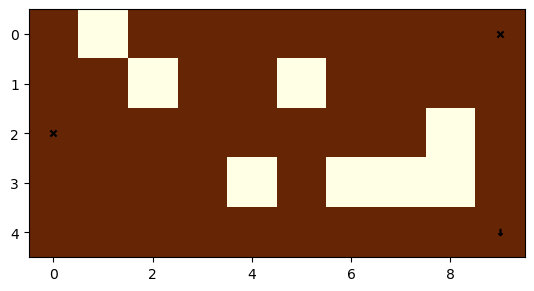

curr_reward 23.843819099639255
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 640000
Best mean reward: -276.46 - Last mean reward per episode: -289.92
current Design
[(4, 9)]


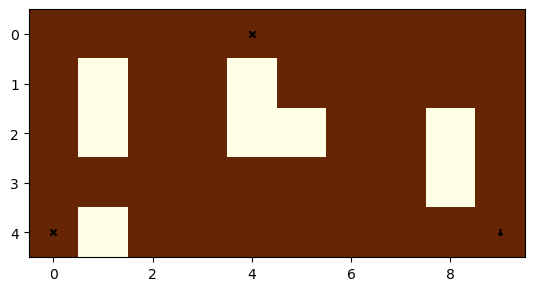

hello hello
--------------------------------------------------
Num timesteps: 650000
Best mean reward: -276.46 - Last mean reward per episode: -251.28
current Design
[(4, 9)]


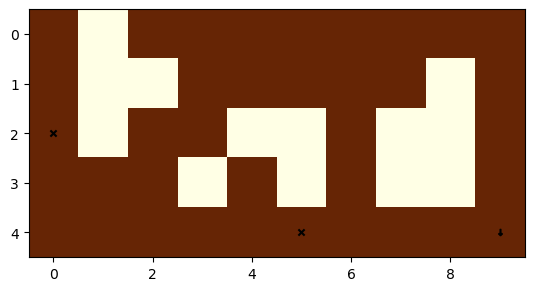

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 660000
Best mean reward: -251.28 - Last mean reward per episode: -249.73
current Design
[(1, 0)]


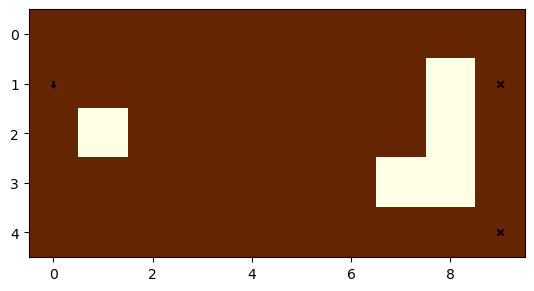

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 670000
Best mean reward: -249.73 - Last mean reward per episode: -246.07
current Design
[(2, 9)]


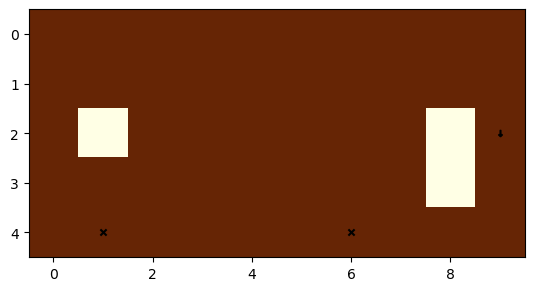

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 680000
Best mean reward: -246.07 - Last mean reward per episode: -252.18
current Design
[(3, 9)]


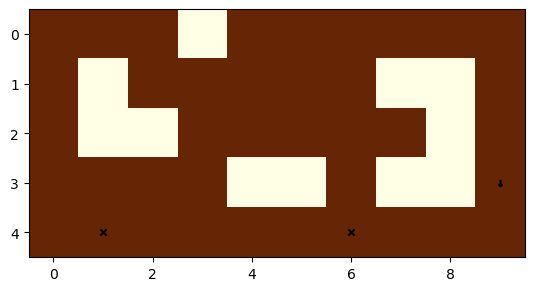

hello hello
--------------------------------------------------
Num timesteps: 690000
Best mean reward: -246.07 - Last mean reward per episode: -241.97
current Design
[(0, 5)]


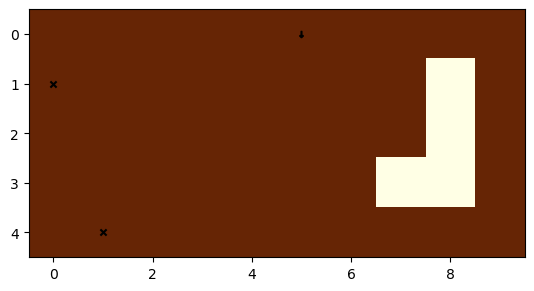

Saving new best model to log/best_model.zip
current Design
[(4, 9)]


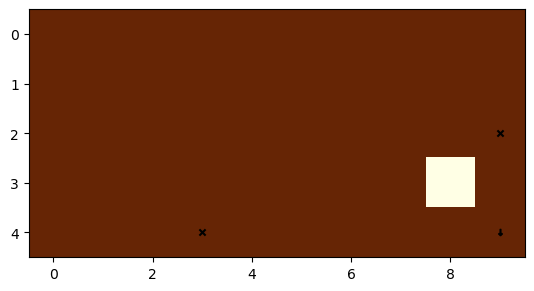

curr_reward 3.581603606252905
accumulated_reward 0
current Design
[(4, 9)]


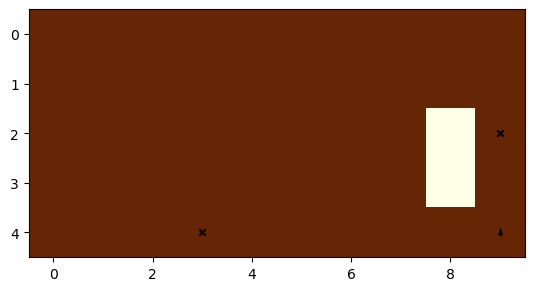

curr_reward 6.566757415725434
accumulated_reward 0
current Design
[(4, 9)]


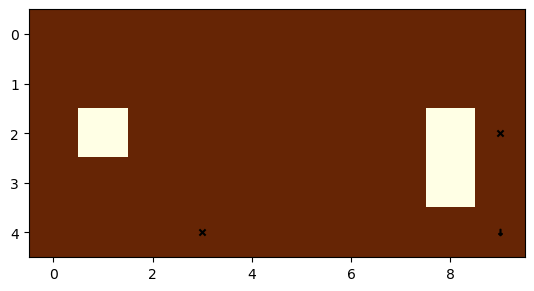

curr_reward 9.503319436590449
accumulated_reward 0
current Design
[(4, 9)]


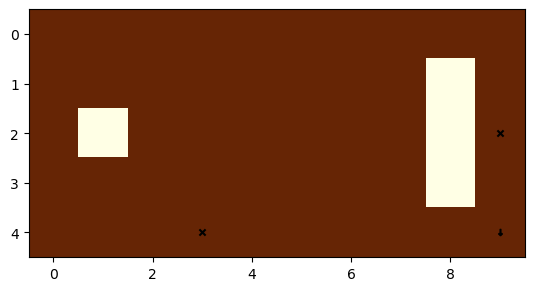

curr_reward 11.886267059388782
accumulated_reward 0
current Design
[(4, 9)]


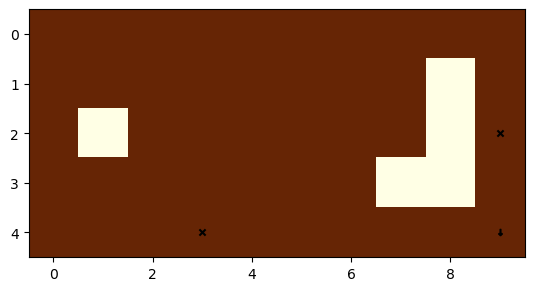

curr_reward 14.76661395285739
accumulated_reward 0
current Design
[(4, 9)]


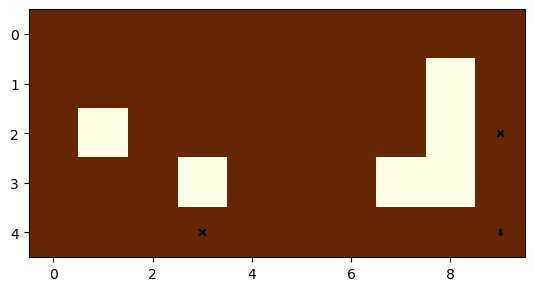

curr_reward 17.364805865542333
accumulated_reward 0
current Design
[(4, 9)]


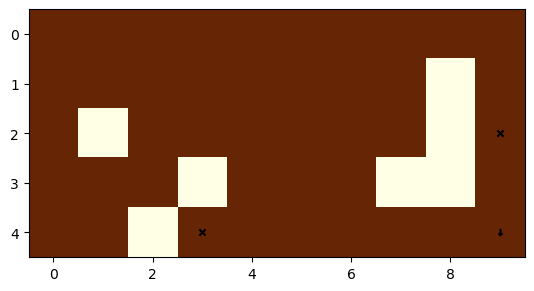

curr_reward 19.30518928695018
accumulated_reward 0
current Design
[(4, 9)]


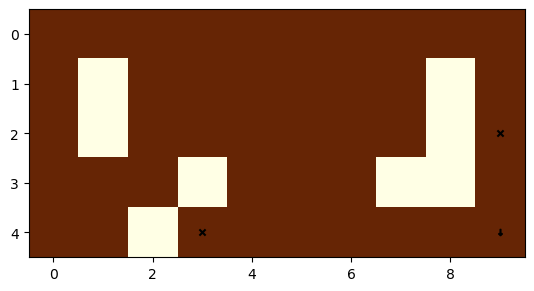

curr_reward 21.174555241102254
accumulated_reward 0
current Design
[(4, 9)]


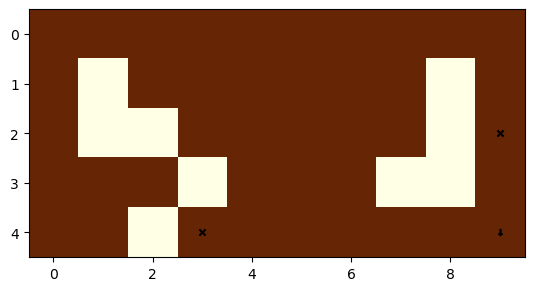

curr_reward 23.036940997749618
accumulated_reward 0
current Design
[(4, 9)]


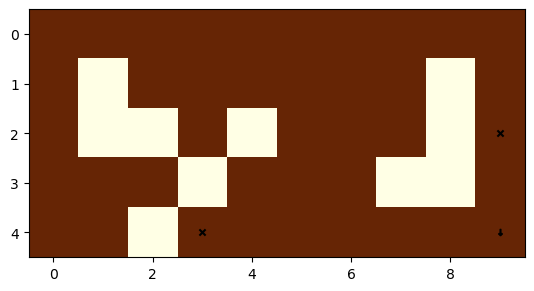

curr_reward 24.400151917609932
accumulated_reward 0
current Design
[(4, 9)]


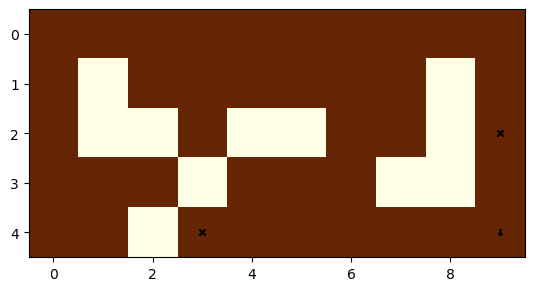

curr_reward 25.253309313930917
accumulated_reward 0
current Design
[(4, 9)]


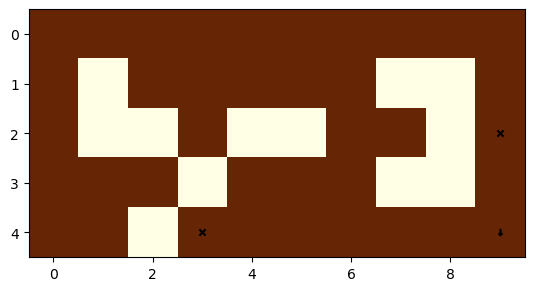

curr_reward 25.810114232332996
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 700000
Best mean reward: -241.97 - Last mean reward per episode: -247.09
current Design
[(2, 9)]


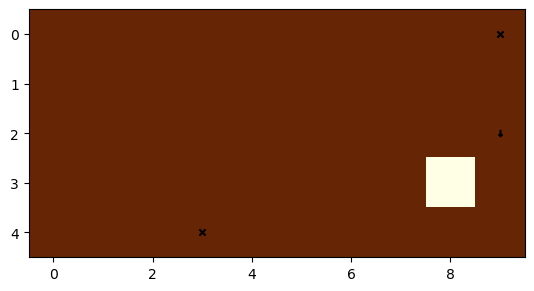

hello hello
--------------------------------------------------
Num timesteps: 710000
Best mean reward: -241.97 - Last mean reward per episode: -258.60
current Design
[(4, 1)]


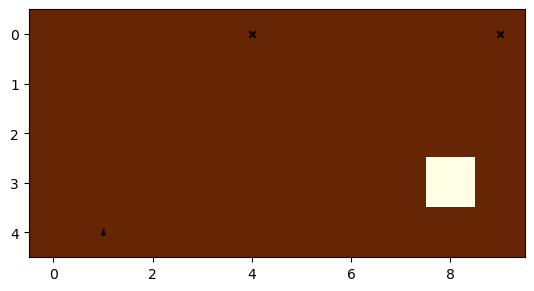

hello hello
--------------------------------------------------
Num timesteps: 720000
Best mean reward: -241.97 - Last mean reward per episode: -231.10
current Design
[(4, 4)]


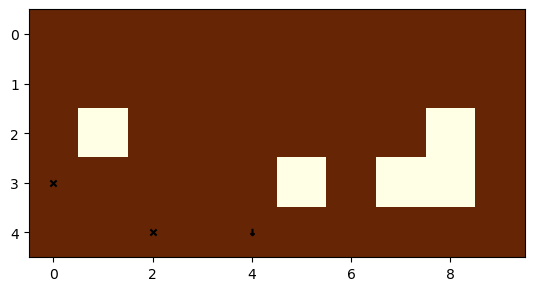

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 730000
Best mean reward: -231.10 - Last mean reward per episode: -238.38
current Design
[(4, 9)]


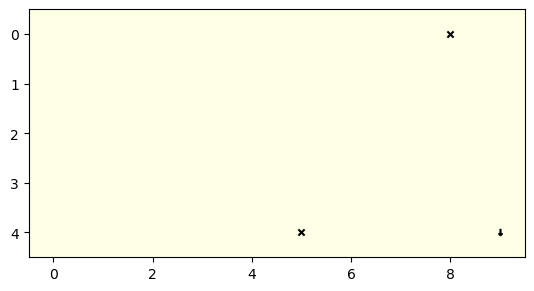

hello hello
--------------------------------------------------
Num timesteps: 740000
Best mean reward: -231.10 - Last mean reward per episode: -253.30
current Design
[(2, 0)]


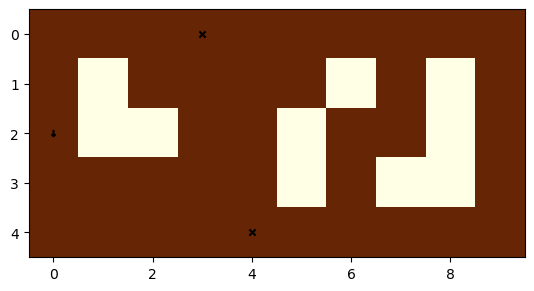

hello hello
--------------------------------------------------
Num timesteps: 750000
Best mean reward: -231.10 - Last mean reward per episode: -242.56
current Design
[(0, 9)]


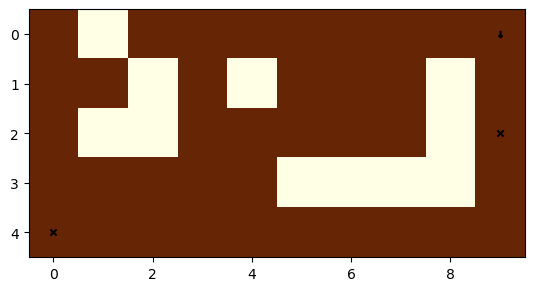

current Design
[(1, 9)]


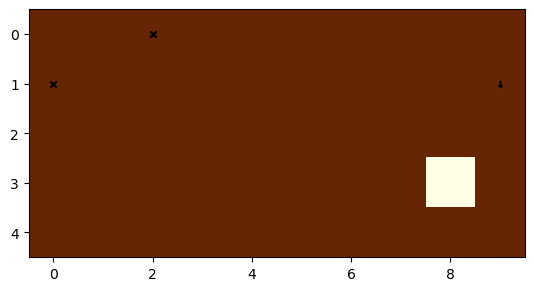

curr_reward 3.867014188944025
accumulated_reward 0
current Design
[(1, 9)]


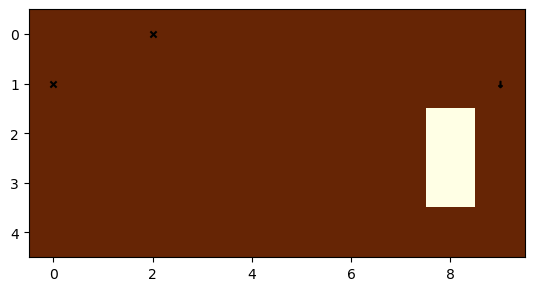

curr_reward 7.498097536331941
accumulated_reward 0
current Design
[(1, 9)]


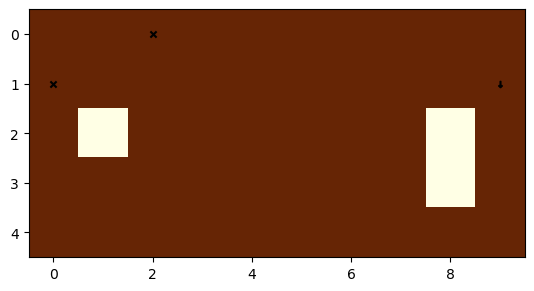

curr_reward 10.753666437785848
accumulated_reward 0
current Design
[(1, 9)]


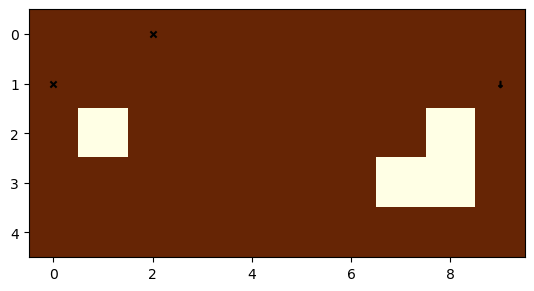

curr_reward 13.743523647782986
accumulated_reward 0
current Design
[(1, 9)]


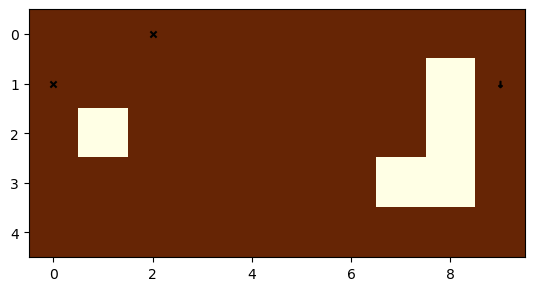

curr_reward 16.40015087402318
accumulated_reward 0
current Design
[(1, 9)]


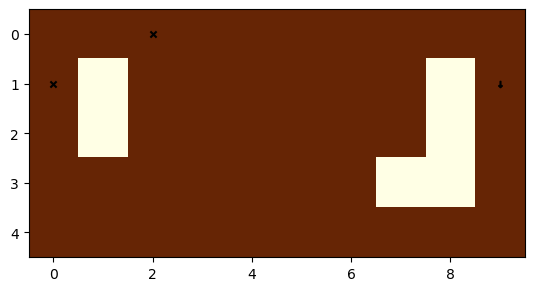

curr_reward 18.83883297072682
accumulated_reward 0
current Design
[(1, 9)]


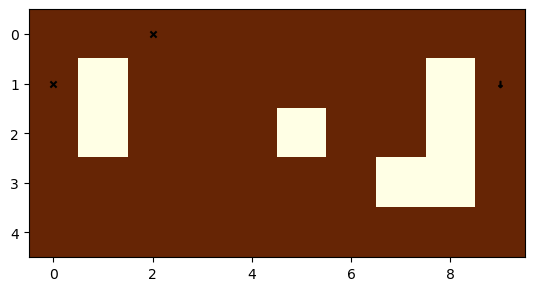

curr_reward 21.124518150176716
accumulated_reward 0
current Design
[(1, 9)]


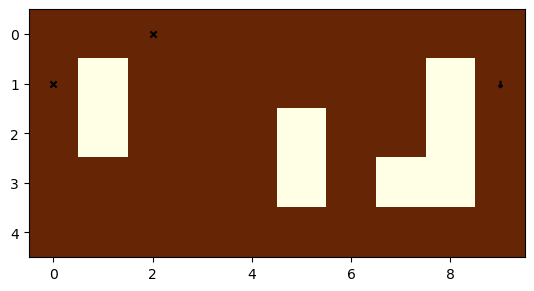

curr_reward 23.134434744286136
accumulated_reward 0
current Design
[(1, 9)]


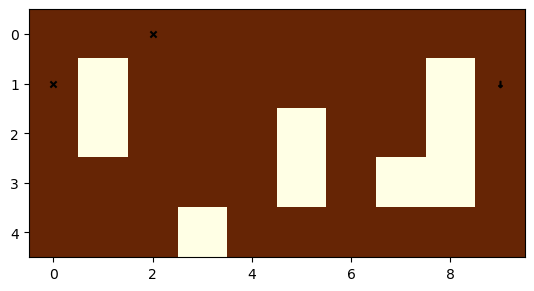

curr_reward 24.90069809474212
accumulated_reward 0
current Design
[(1, 9)]


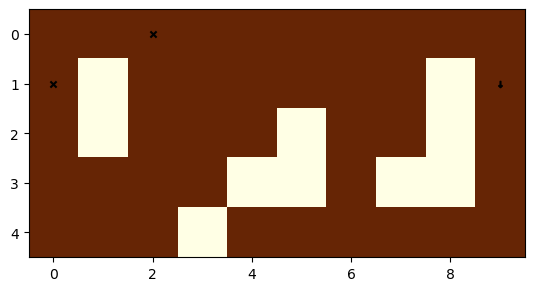

curr_reward 26.056508444133883
accumulated_reward 0
current Design
[(1, 9)]


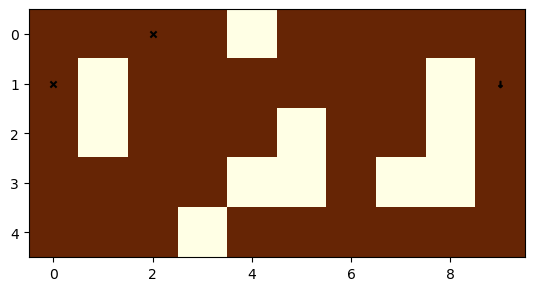

curr_reward 28.661135019939888
accumulated_reward 0
current Design
[(1, 9)]


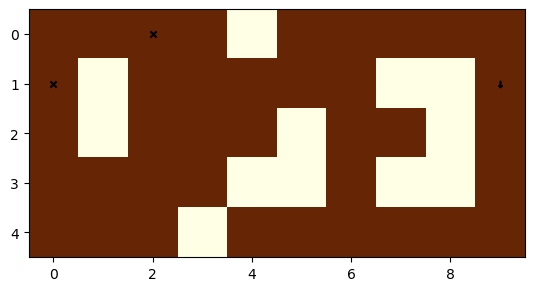

curr_reward 30.352161880641404
accumulated_reward 0
current Design
[(1, 9)]


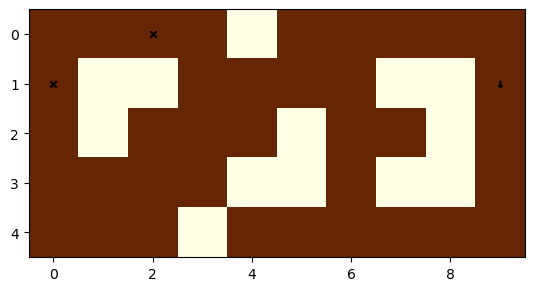

curr_reward 31.18477322915772
accumulated_reward 0
current Design
[(1, 9)]


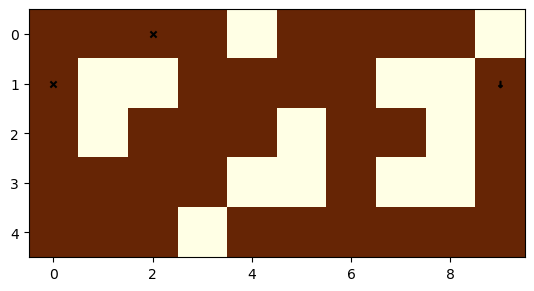

curr_reward 31.544990047533872
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 760000
Best mean reward: -231.10 - Last mean reward per episode: -278.45
current Design
[(1, 9)]


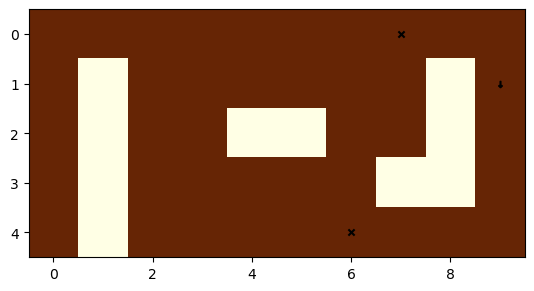

hello hello
--------------------------------------------------
Num timesteps: 770000
Best mean reward: -231.10 - Last mean reward per episode: -182.53
current Design
[(4, 0)]


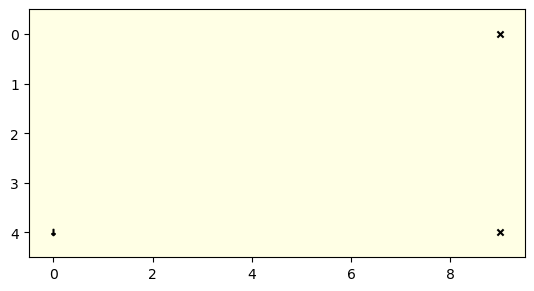

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 780000
Best mean reward: -182.53 - Last mean reward per episode: -197.19
current Design
[(0, 1)]


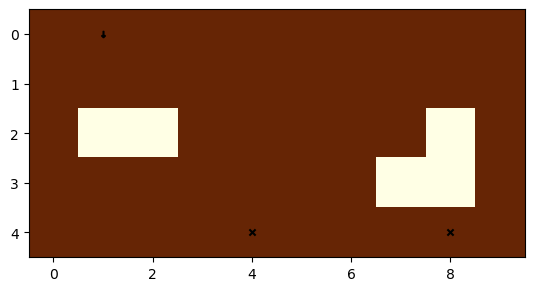

hello hello
--------------------------------------------------
Num timesteps: 790000
Best mean reward: -182.53 - Last mean reward per episode: -242.35
current Design
[(2, 0)]


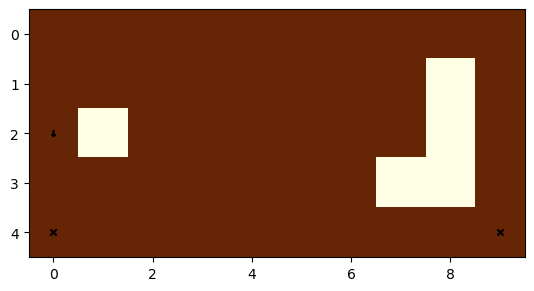

hello hello
--------------------------------------------------
Num timesteps: 800000
Best mean reward: -182.53 - Last mean reward per episode: -246.89
current Design
[(4, 0)]


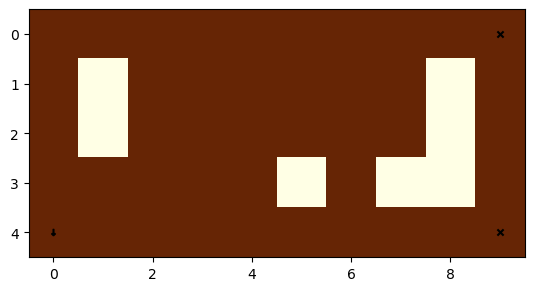

hello hello
--------------------------------------------------
Num timesteps: 810000
Best mean reward: -182.53 - Last mean reward per episode: -230.57
current Design
[(4, 0)]


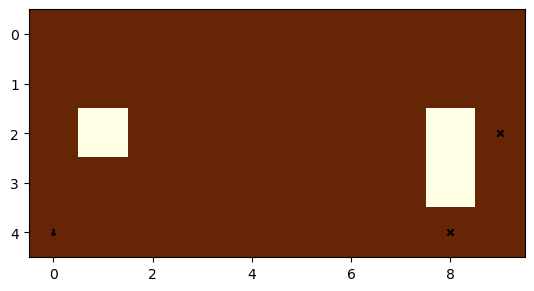

current Design
[(0, 3)]


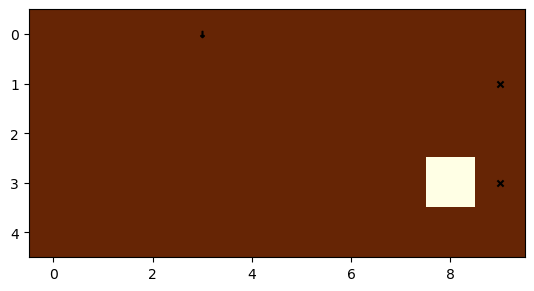

curr_reward 3.964608781990749
accumulated_reward 0
current Design
[(0, 3)]


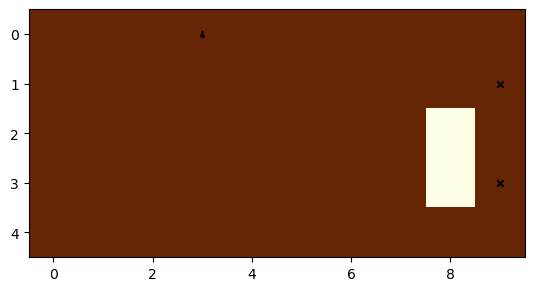

curr_reward 7.689824803440924
accumulated_reward 0
current Design
[(0, 3)]


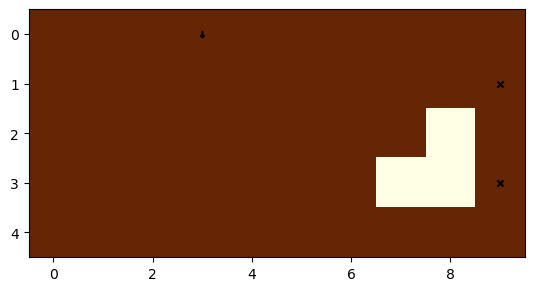

curr_reward 11.271773407744236
accumulated_reward 0
current Design
[(0, 3)]


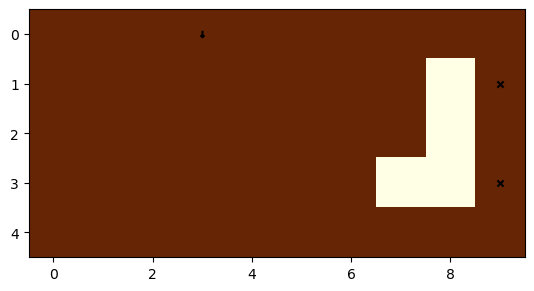

curr_reward 14.052649114592164
accumulated_reward 0
current Design
[(0, 3)]


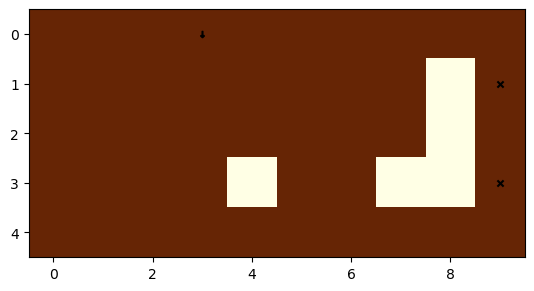

curr_reward 16.919198263065105
accumulated_reward 0
current Design
[(0, 3)]


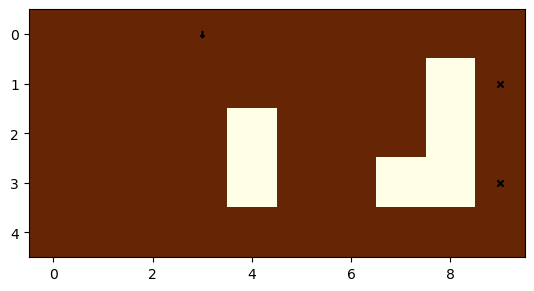

curr_reward 19.64330744746742
accumulated_reward 0
current Design
[(0, 3)]


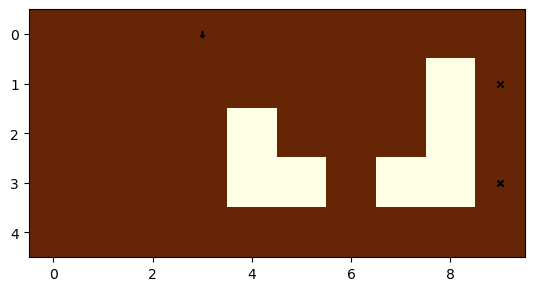

curr_reward 21.965631531140154
accumulated_reward 0
current Design
[(0, 3)]


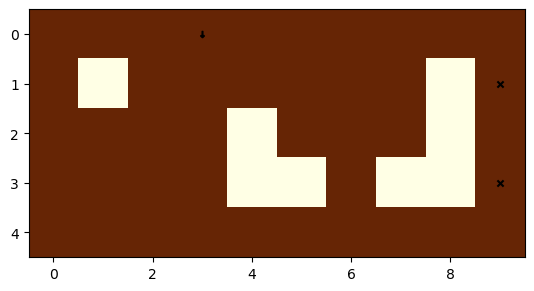

curr_reward 23.88288227612069
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 820000
Best mean reward: -182.53 - Last mean reward per episode: -246.50
current Design
[(1, 9)]


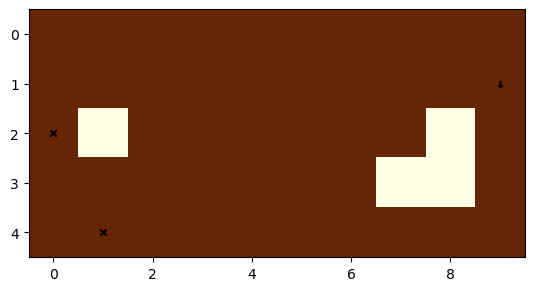

hello hello
--------------------------------------------------
Num timesteps: 830000
Best mean reward: -182.53 - Last mean reward per episode: -250.19
current Design
[(2, 0)]


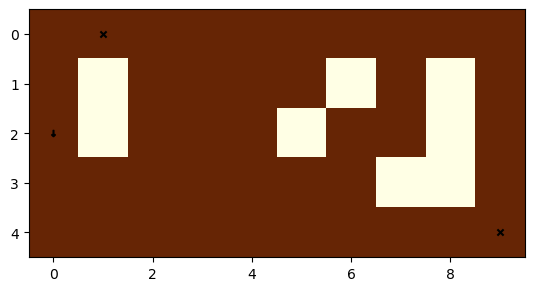

hello hello
--------------------------------------------------
Num timesteps: 840000
Best mean reward: -182.53 - Last mean reward per episode: -240.87
current Design
[(2, 0)]


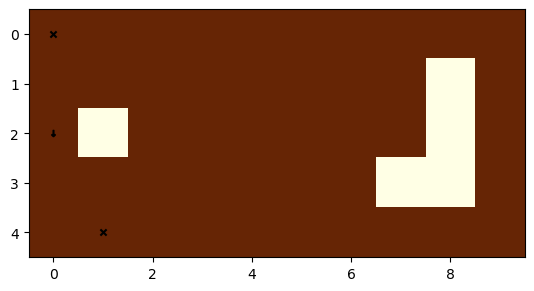

hello hello
--------------------------------------------------
Num timesteps: 850000
Best mean reward: -182.53 - Last mean reward per episode: -225.99
current Design
[(0, 9)]


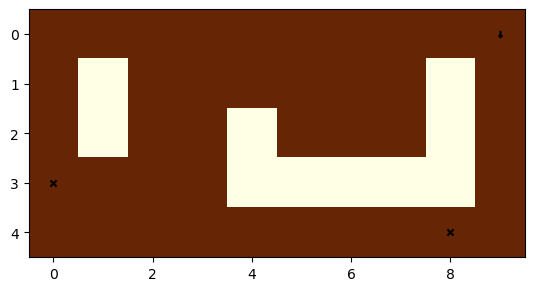

hello hello
--------------------------------------------------
Num timesteps: 860000
Best mean reward: -182.53 - Last mean reward per episode: -202.23
current Design
[(2, 9)]


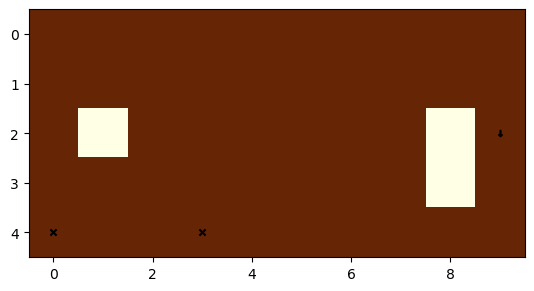

hello hello
--------------------------------------------------
Num timesteps: 870000
Best mean reward: -182.53 - Last mean reward per episode: -215.82
current Design
[(0, 0)]


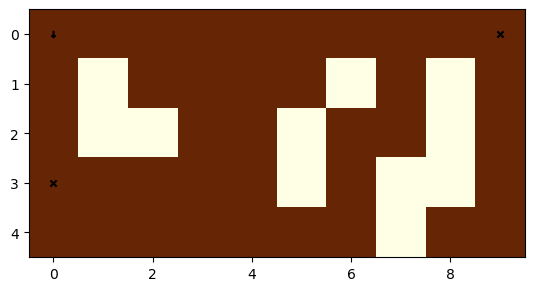

hello hello
--------------------------------------------------
Num timesteps: 880000
Best mean reward: -182.53 - Last mean reward per episode: -218.84
current Design
[(4, 9)]


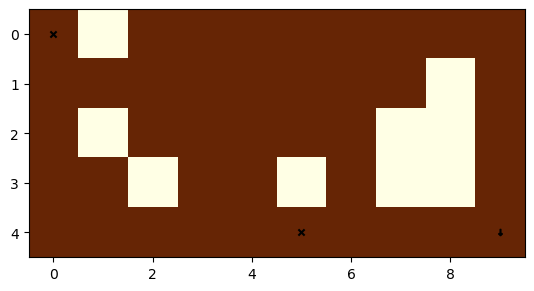

current Design
[(4, 2)]


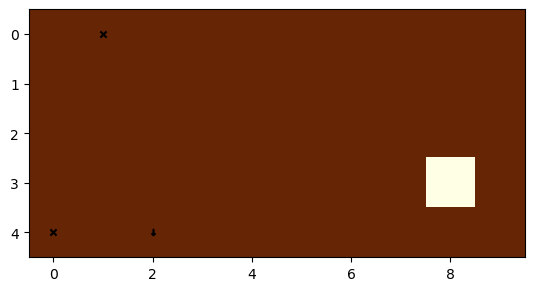

curr_reward 3.8426813493178056
accumulated_reward 0
current Design
[(4, 2)]


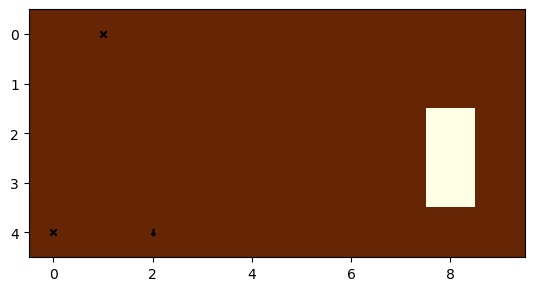

curr_reward 7.375808093564241
accumulated_reward 0
current Design
[(4, 2)]


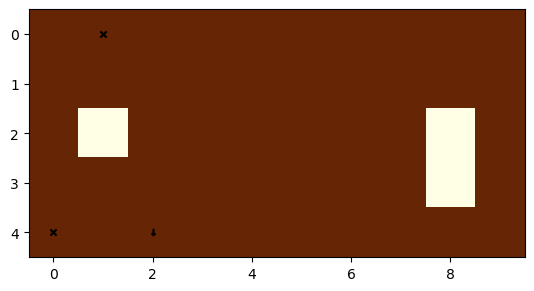

curr_reward 10.822943854873659
accumulated_reward 0
current Design
[(4, 2)]


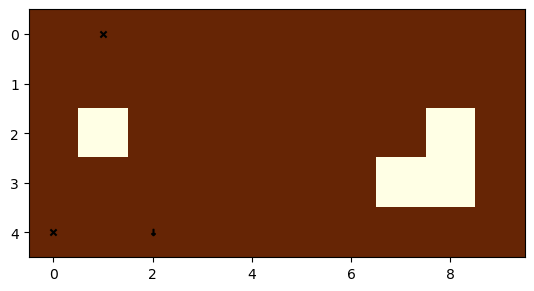

curr_reward 13.833282942319816
accumulated_reward 0
current Design
[(4, 2)]


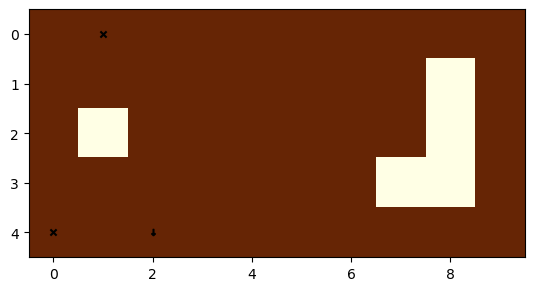

curr_reward 16.546736926395635
accumulated_reward 0
current Design
[(4, 2)]


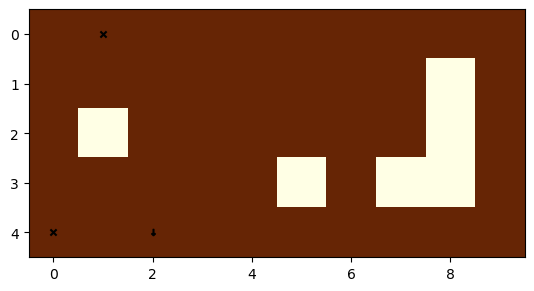

curr_reward 19.095747011790337
accumulated_reward 0
current Design
[(4, 2)]


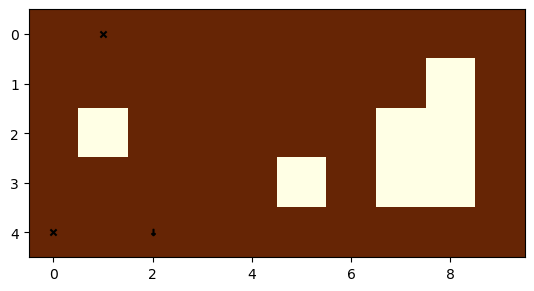

curr_reward 21.289669901090026
accumulated_reward 0
current Design
[(4, 2)]


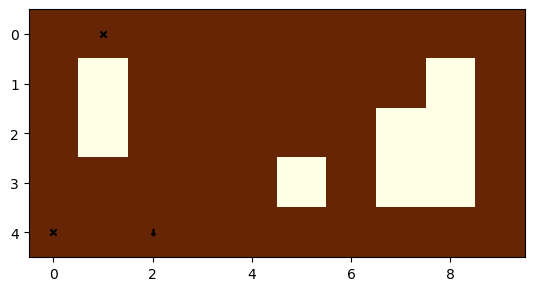

curr_reward 24.08067327857406
accumulated_reward 0
current Design
[(4, 2)]


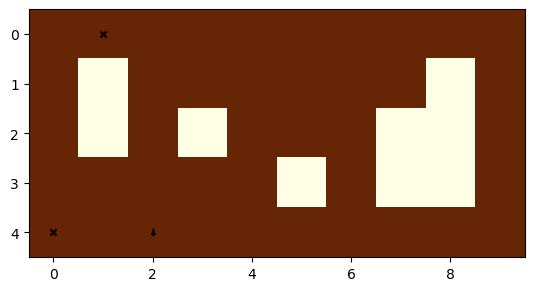

curr_reward 26.731052677649295
accumulated_reward 0
current Design
[(4, 2)]


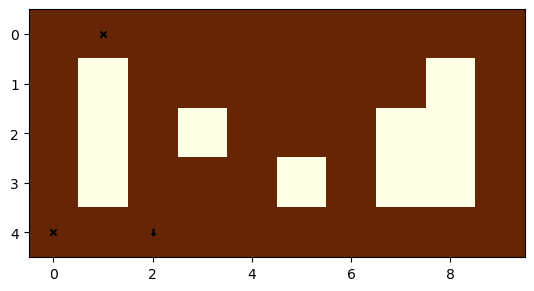

curr_reward 25.734163207284666
accumulated_reward 0
current Design
[(4, 2)]


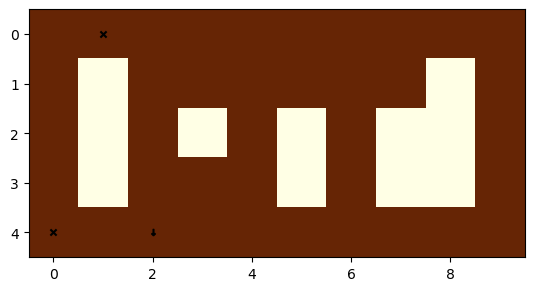

curr_reward 27.12366311361599
accumulated_reward 0
current Design
[(4, 2)]


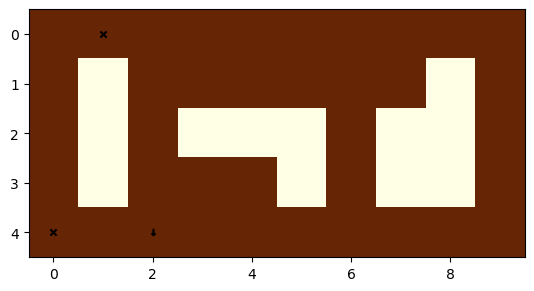

curr_reward 28.802146248097042
accumulated_reward 0
current Design
[(4, 2)]


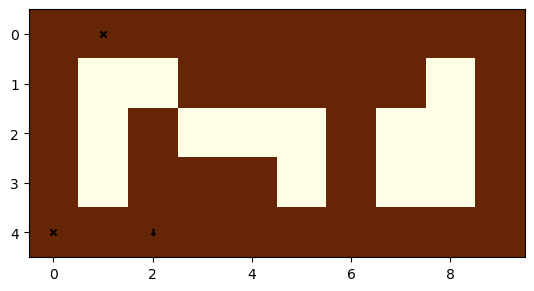

curr_reward 31.293215208094
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 890000
Best mean reward: -182.53 - Last mean reward per episode: -197.75
current Design
[(3, 9)]


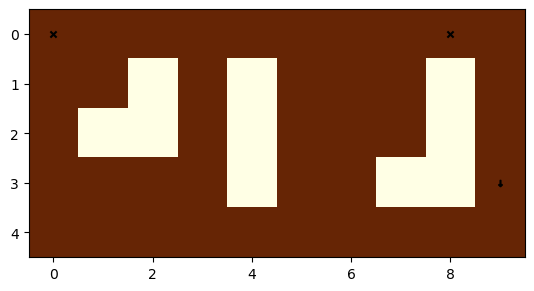

hello hello
--------------------------------------------------
Num timesteps: 900000
Best mean reward: -182.53 - Last mean reward per episode: -156.54
current Design
[(1, 9)]


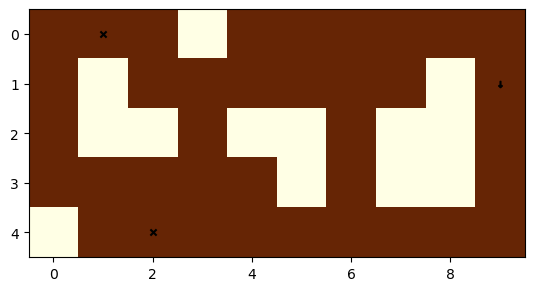

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 910000
Best mean reward: -156.54 - Last mean reward per episode: -215.86
current Design
[(0, 6)]


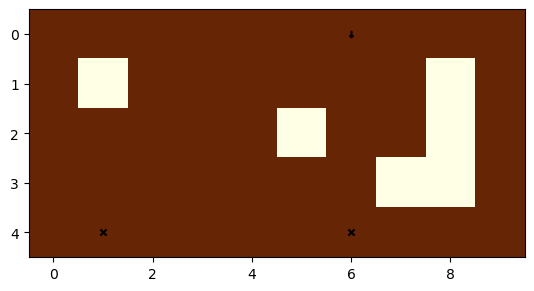

hello hello
--------------------------------------------------
Num timesteps: 920000
Best mean reward: -156.54 - Last mean reward per episode: -195.97
current Design
[(4, 5)]


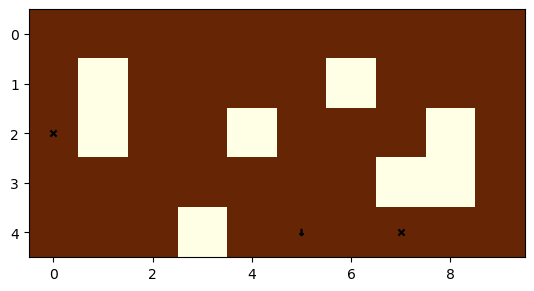

hello hello
--------------------------------------------------
Num timesteps: 930000
Best mean reward: -156.54 - Last mean reward per episode: -223.00
current Design
[(0, 9)]


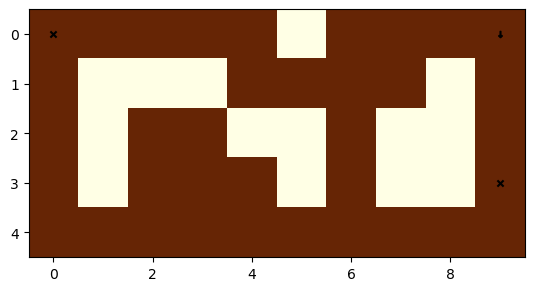

hello hello
--------------------------------------------------
Num timesteps: 940000
Best mean reward: -156.54 - Last mean reward per episode: -170.70
current Design
[(0, 7)]


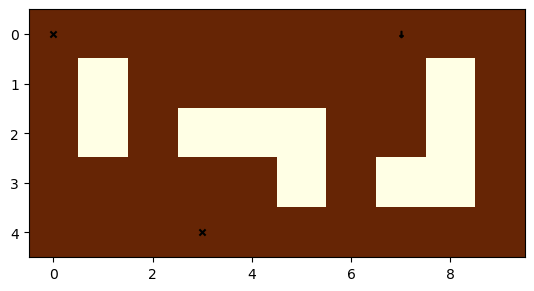

hello hello
--------------------------------------------------
Num timesteps: 950000
Best mean reward: -156.54 - Last mean reward per episode: -203.96
current Design
[(0, 4)]


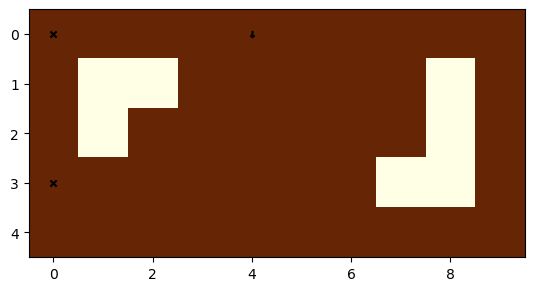

current Design
[(1, 9)]


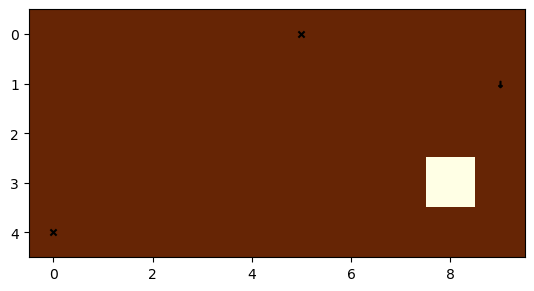

curr_reward 3.9104111081097845
accumulated_reward 0
current Design
[(1, 9)]


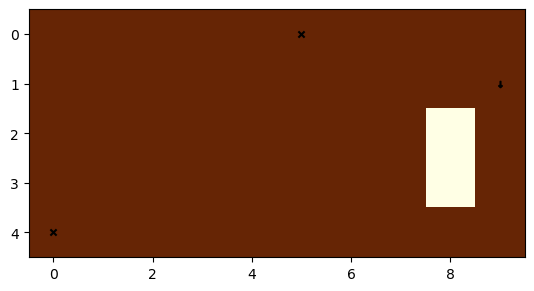

curr_reward 7.687001831518126
accumulated_reward 0
current Design
[(1, 9)]


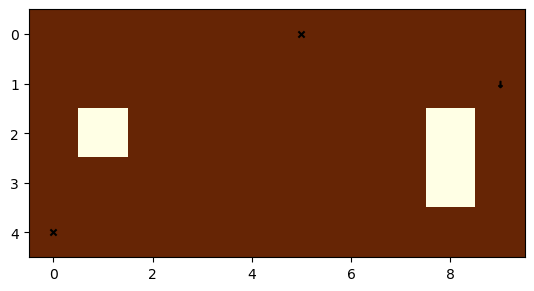

curr_reward 11.058168157847367
accumulated_reward 0
current Design
[(1, 9)]


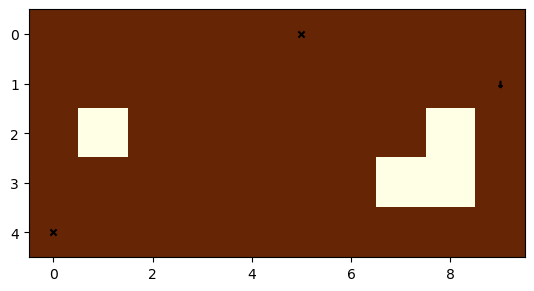

curr_reward 14.075427811337015
accumulated_reward 0
current Design
[(1, 9)]


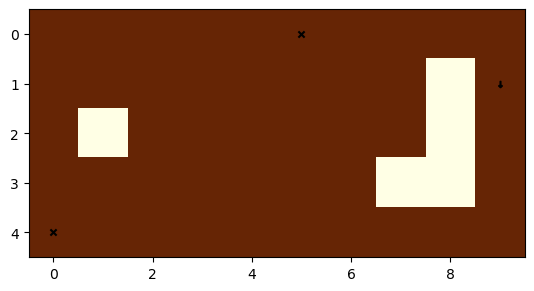

curr_reward 16.5923602768283
accumulated_reward 0
current Design
[(1, 9)]


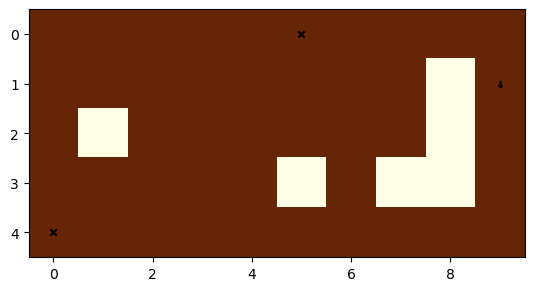

curr_reward 19.132519111356434
accumulated_reward 0
current Design
[(1, 9)]


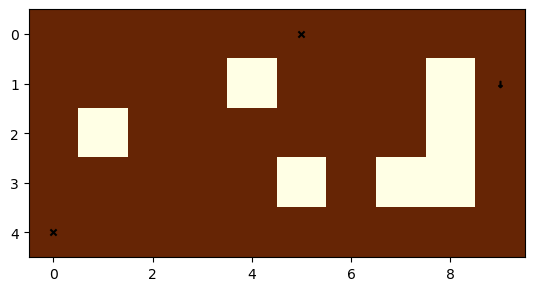

curr_reward 21.12252376990985
accumulated_reward 0
current Design
[(1, 9)]


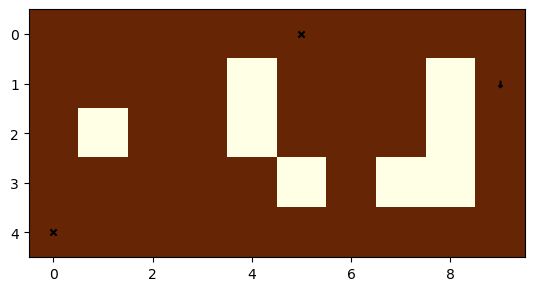

curr_reward 23.088667166249945
accumulated_reward 0
current Design
[(1, 9)]


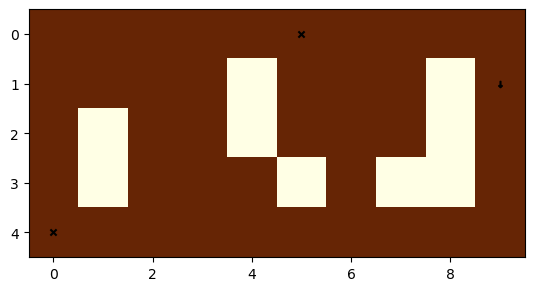

curr_reward 24.770222064380512
accumulated_reward 0
current Design
[(1, 9)]


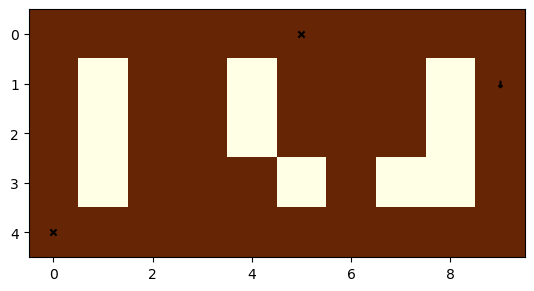

curr_reward 26.17873005098996
accumulated_reward 0
current Design
[(1, 9)]


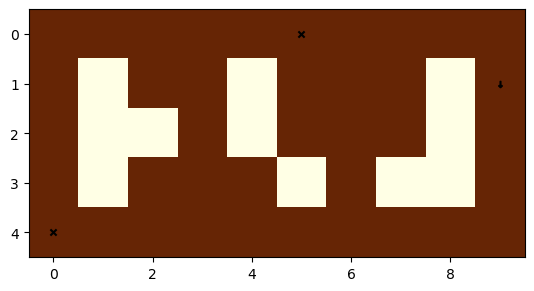

curr_reward 27.359053109876523
accumulated_reward 0
current Design
[(1, 9)]


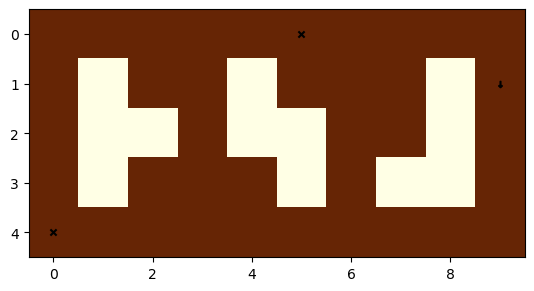

curr_reward 28.47899973268351
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 960000
Best mean reward: -156.54 - Last mean reward per episode: -167.92
current Design
[(0, 9)]


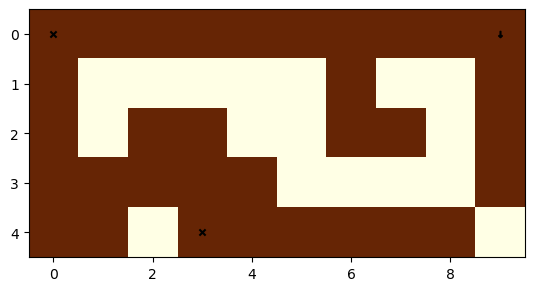

hello hello
--------------------------------------------------
Num timesteps: 970000
Best mean reward: -156.54 - Last mean reward per episode: -162.36
current Design
[(0, 2)]


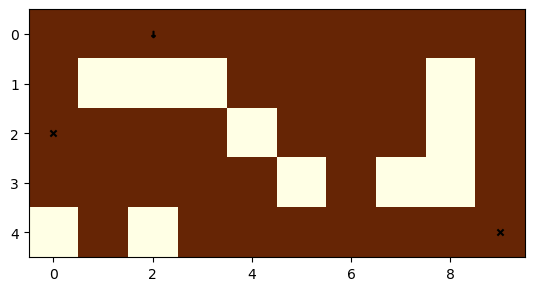

hello hello
--------------------------------------------------
Num timesteps: 980000
Best mean reward: -156.54 - Last mean reward per episode: -155.20
current Design
[(0, 9)]


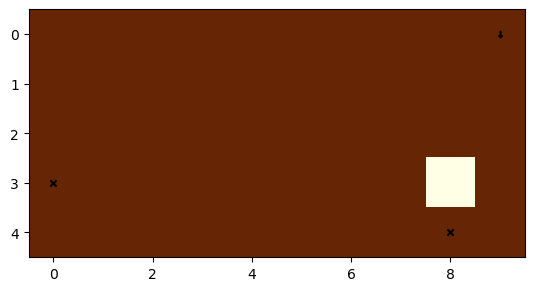

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 990000
Best mean reward: -155.20 - Last mean reward per episode: -149.53
current Design
[(0, 5)]


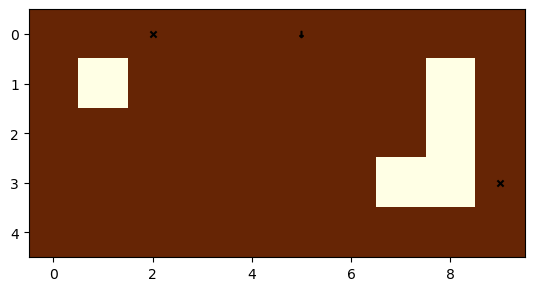

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1000000
Best mean reward: -149.53 - Last mean reward per episode: -177.00
current Design
[(4, 9)]


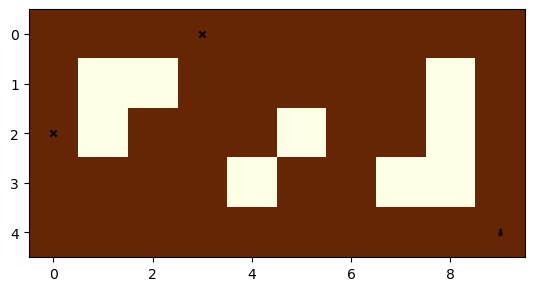

hello hello
--------------------------------------------------
Num timesteps: 1010000
Best mean reward: -149.53 - Last mean reward per episode: -214.65
current Design
[(2, 9)]


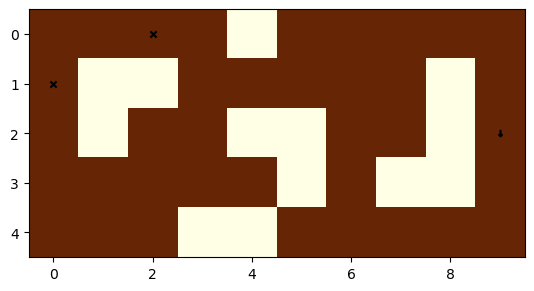

hello hello
--------------------------------------------------
Num timesteps: 1020000
Best mean reward: -149.53 - Last mean reward per episode: -163.25
current Design
[(3, 0)]


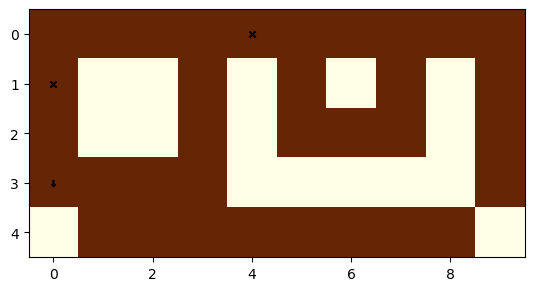

current Design
[(0, 3)]


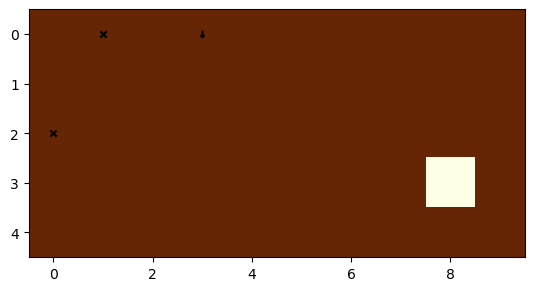

curr_reward 3.8214091272248276
accumulated_reward 0
current Design
[(0, 3)]


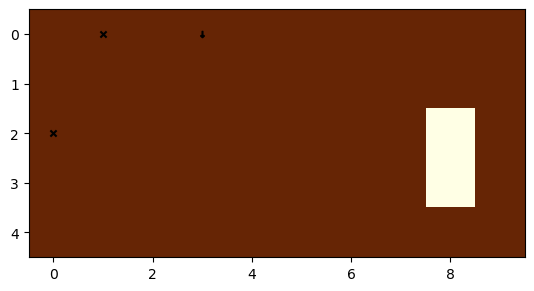

curr_reward 7.3141020773594345
accumulated_reward 0
current Design
[(0, 3)]


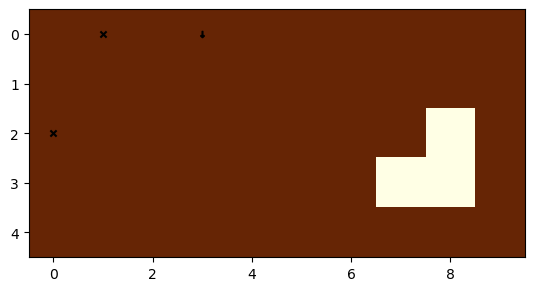

curr_reward 10.409197749585093
accumulated_reward 0
current Design
[(0, 3)]


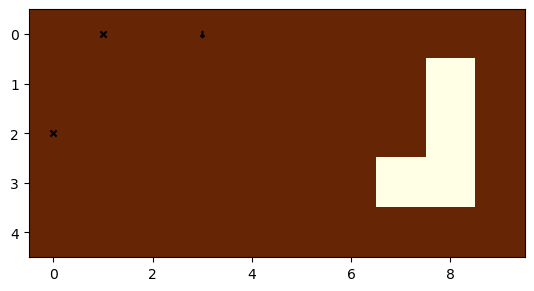

curr_reward 13.310202376981998
accumulated_reward 0
current Design
[(0, 3)]


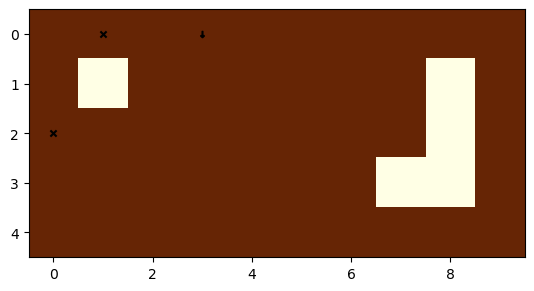

curr_reward 15.926530283768441
accumulated_reward 0
current Design
[(0, 3)]


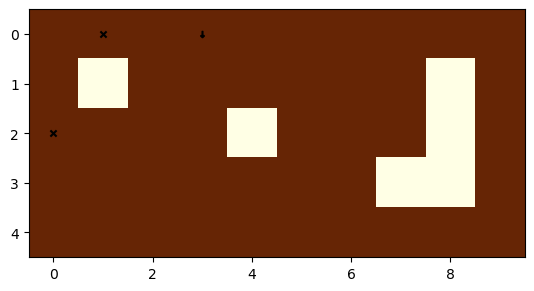

curr_reward 18.181428289294782
accumulated_reward 0
current Design
[(0, 3)]


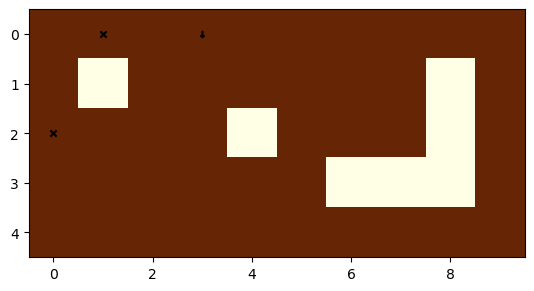

curr_reward 19.815021110611205
accumulated_reward 0
current Design
[(0, 3)]


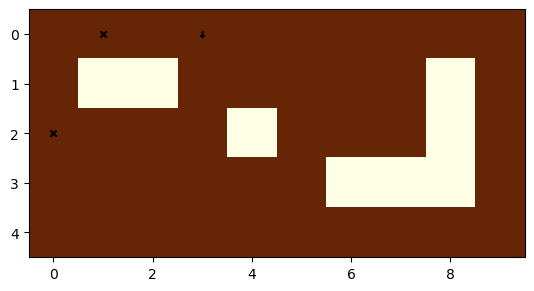

curr_reward 21.264785861255685
accumulated_reward 0
current Design
[(0, 3)]


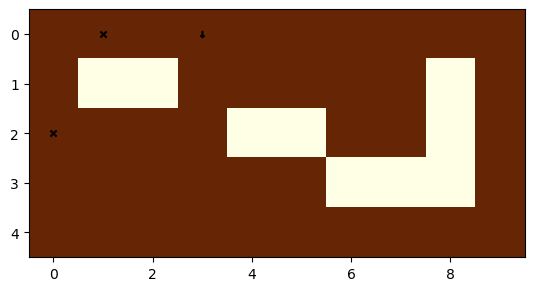

curr_reward 22.52712039067808
accumulated_reward 0
current Design
[(0, 3)]


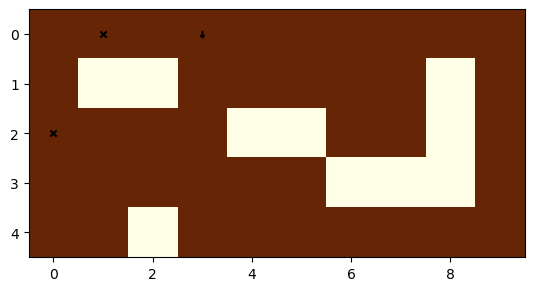

curr_reward 23.128778527558907
accumulated_reward 0
current Design
[(0, 3)]


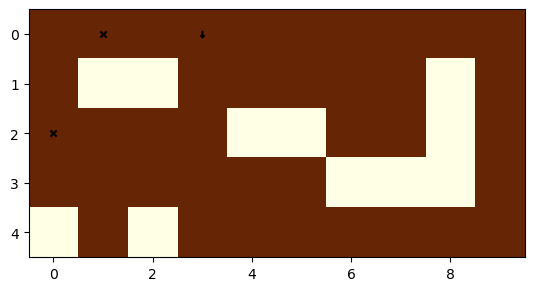

curr_reward 24.24586097978653
accumulated_reward 0
current Design
[(0, 3)]


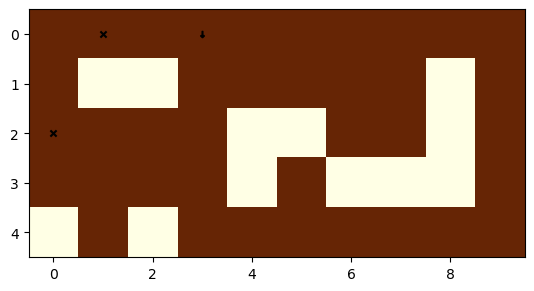

curr_reward 25.05391889440039
accumulated_reward 0
current Design
[(0, 3)]


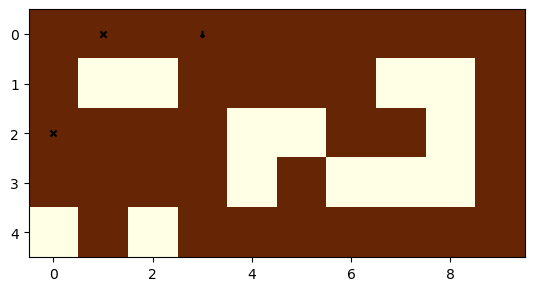

curr_reward 25.59186485878401
accumulated_reward 0
current Design
[(0, 3)]


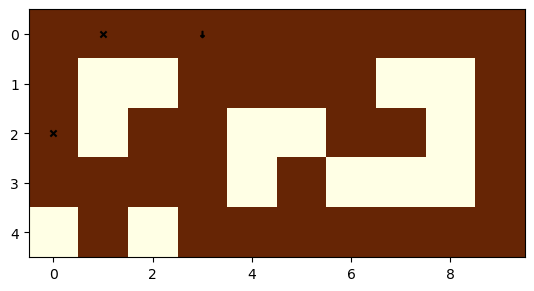

curr_reward 27.512944043248037
accumulated_reward 0
current Design
[(0, 3)]


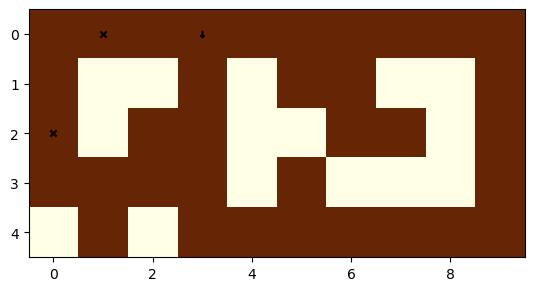

curr_reward 25.076959581972947
accumulated_reward 0
current Design
[(0, 3)]


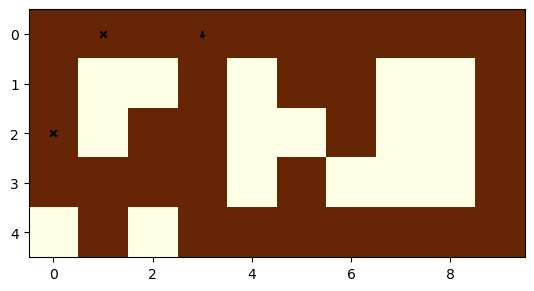

curr_reward 25.202297216523363
accumulated_reward 0
current Design
[(0, 3)]


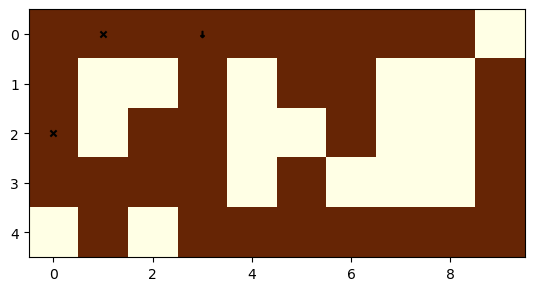

curr_reward 25.160990885638743
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1030000
Best mean reward: -149.53 - Last mean reward per episode: -173.22
current Design
[(4, 3)]


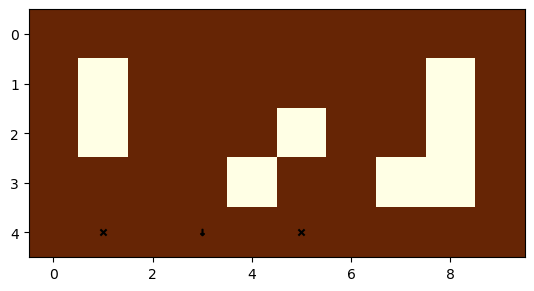

hello hello
--------------------------------------------------
Num timesteps: 1040000
Best mean reward: -149.53 - Last mean reward per episode: -149.27
current Design
[(0, 0)]


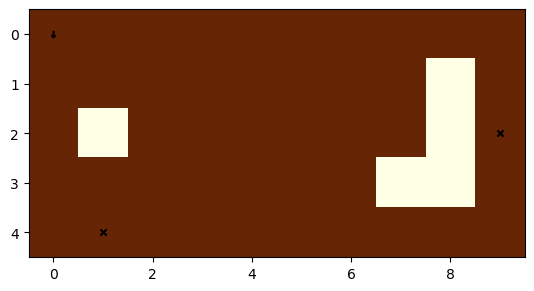

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1050000
Best mean reward: -149.27 - Last mean reward per episode: -160.17
current Design
[(4, 4)]


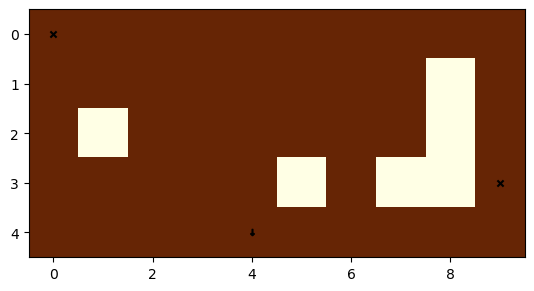

hello hello
--------------------------------------------------
Num timesteps: 1060000
Best mean reward: -149.27 - Last mean reward per episode: -106.78
current Design
[(4, 4)]


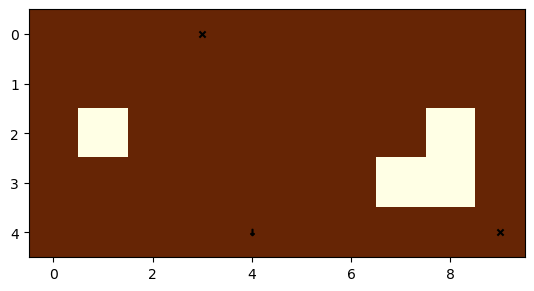

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1070000
Best mean reward: -106.78 - Last mean reward per episode: -186.20
current Design
[(4, 9)]


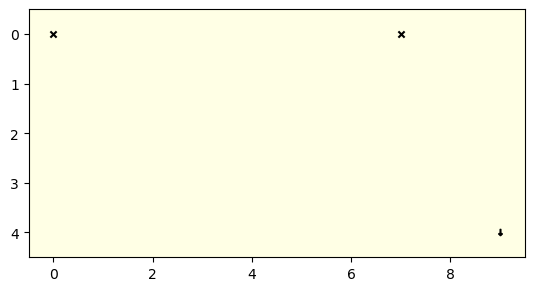

hello hello
--------------------------------------------------
Num timesteps: 1080000
Best mean reward: -106.78 - Last mean reward per episode: -157.42
current Design
[(3, 0)]


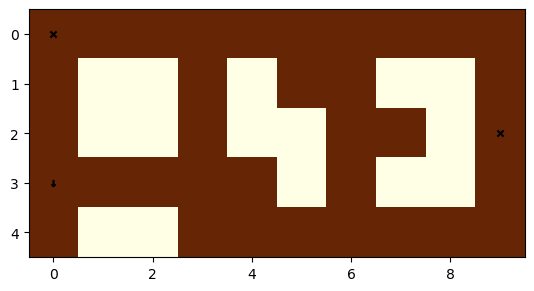

hello hello
--------------------------------------------------
Num timesteps: 1090000
Best mean reward: -106.78 - Last mean reward per episode: -135.89
current Design
[(0, 1)]


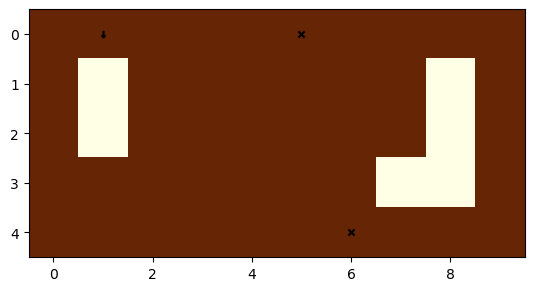

hello hello
--------------------------------------------------
Num timesteps: 1100000
Best mean reward: -106.78 - Last mean reward per episode: -122.56
current Design
[(0, 0)]


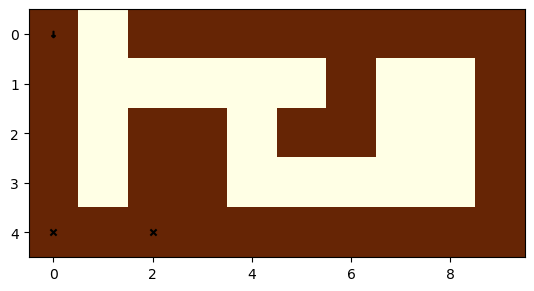

current Design
[(0, 8)]


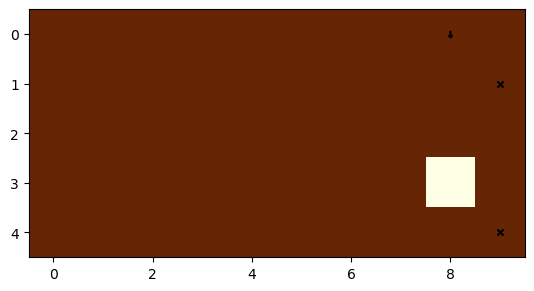

curr_reward 3.9358757370556066
accumulated_reward 0
current Design
[(0, 8)]


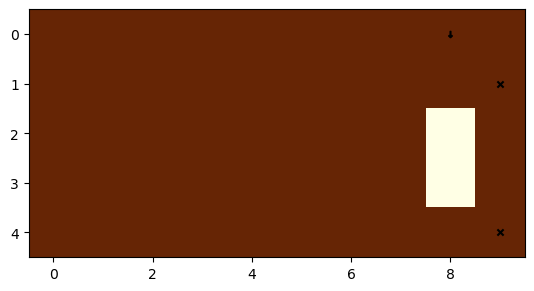

curr_reward 8.029114224481695
accumulated_reward 0
current Design
[(0, 8)]


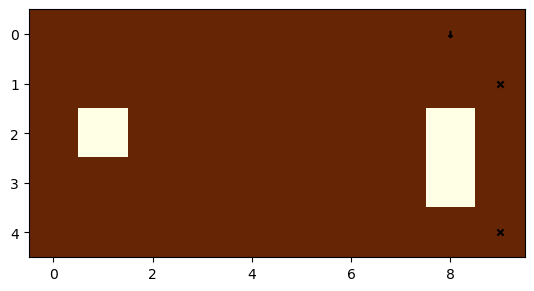

curr_reward 11.546700843845558
accumulated_reward 0
current Design
[(0, 8)]


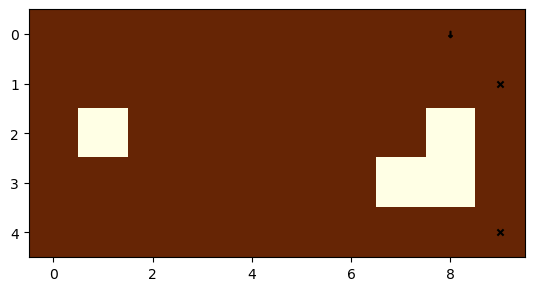

curr_reward 15.220187449415217
accumulated_reward 0
current Design
[(0, 8)]


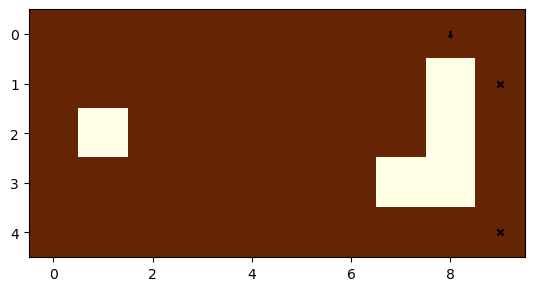

curr_reward 18.740685831293828
accumulated_reward 0
current Design
[(0, 8)]


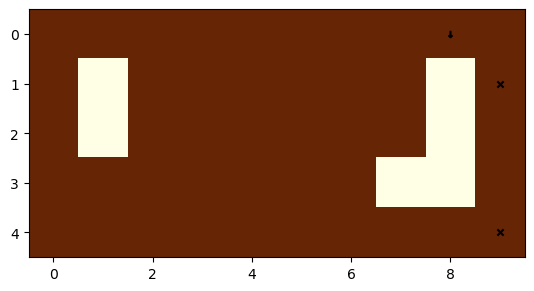

curr_reward 21.48883075216631
accumulated_reward 0
current Design
[(0, 8)]


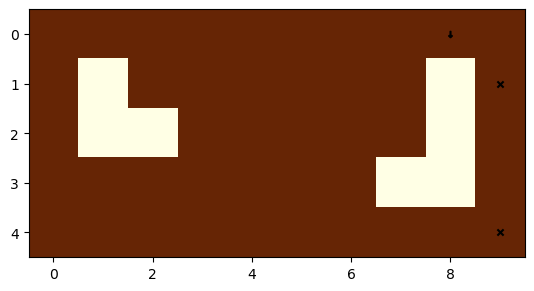

curr_reward 23.944285647191084
accumulated_reward 0
current Design
[(0, 8)]


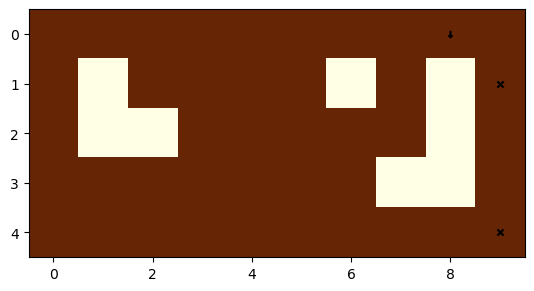

curr_reward 26.205843925517552
accumulated_reward 0
current Design
[(0, 8)]


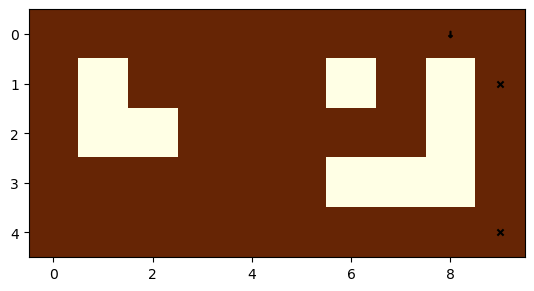

curr_reward 29.066938861725042
accumulated_reward 0
current Design
[(0, 8)]


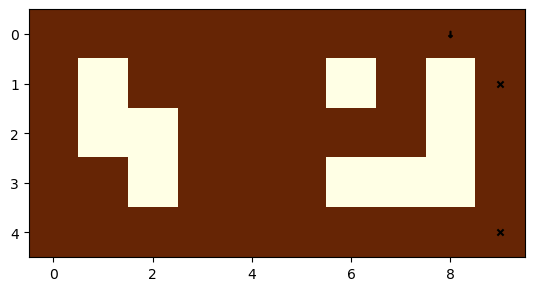

curr_reward 30.744282020105203
accumulated_reward 0
current Design
[(0, 8)]


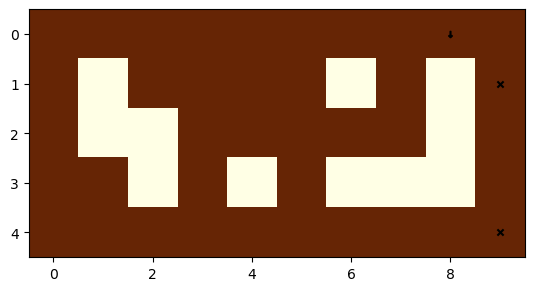

curr_reward 32.155191163436285
accumulated_reward 0
current Design
[(0, 8)]


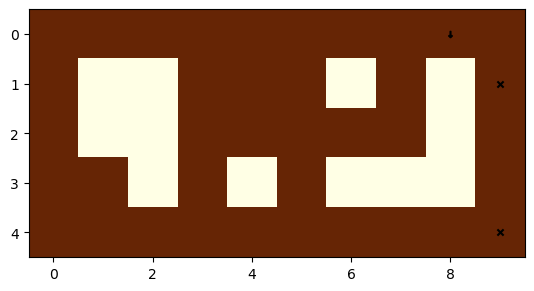

curr_reward 33.189665845875226
accumulated_reward 0
current Design
[(0, 8)]


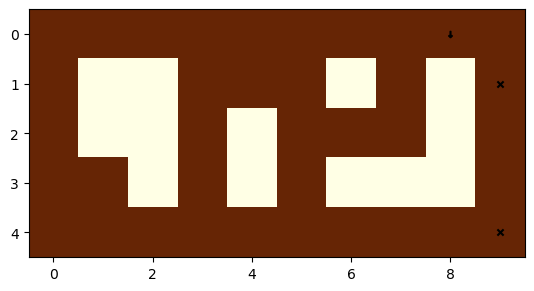

curr_reward 33.87644247706885
accumulated_reward 0
current Design
[(0, 8)]


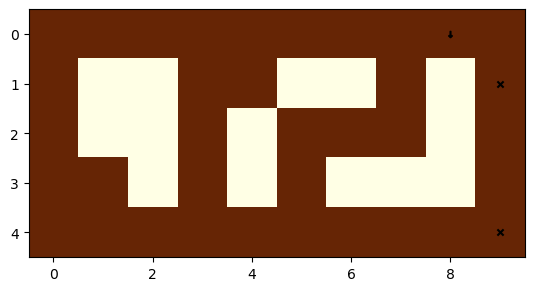

curr_reward 34.871947594245874
accumulated_reward 0
current Design
[(0, 8)]


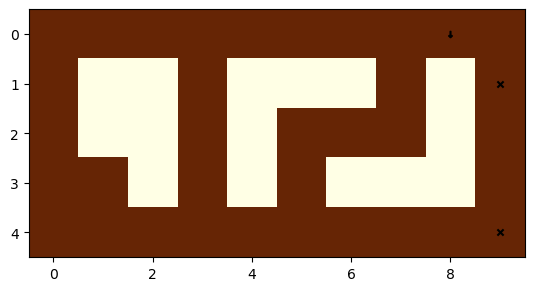

curr_reward 35.509258497225126
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1110000
Best mean reward: -106.78 - Last mean reward per episode: -147.36
current Design
[(2, 9)]


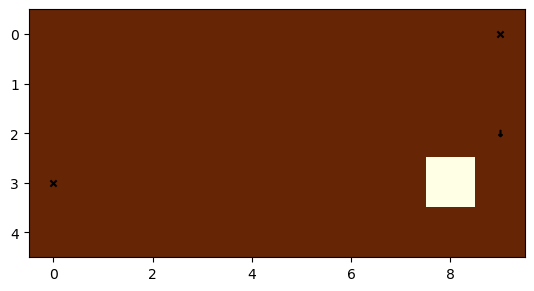

hello hello
--------------------------------------------------
Num timesteps: 1120000
Best mean reward: -106.78 - Last mean reward per episode: -80.66
current Design
[(0, 9)]


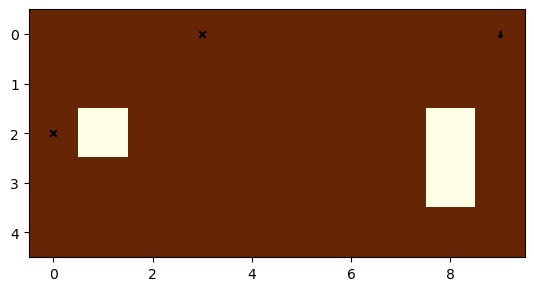

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1130000
Best mean reward: -80.66 - Last mean reward per episode: -159.84
current Design
[(4, 1)]


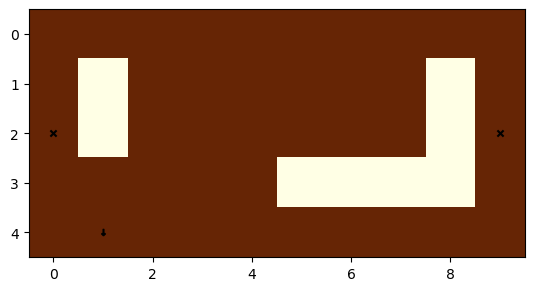

hello hello
--------------------------------------------------
Num timesteps: 1140000
Best mean reward: -80.66 - Last mean reward per episode: -165.22
current Design
[(4, 1)]


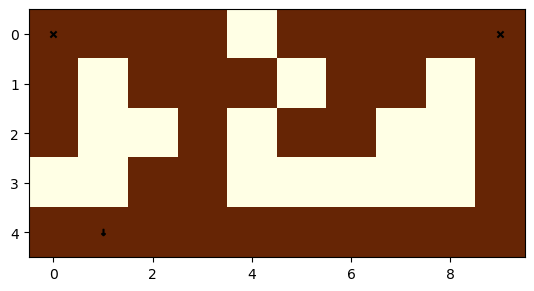

hello hello
--------------------------------------------------
Num timesteps: 1150000
Best mean reward: -80.66 - Last mean reward per episode: -103.93
current Design
[(3, 9)]


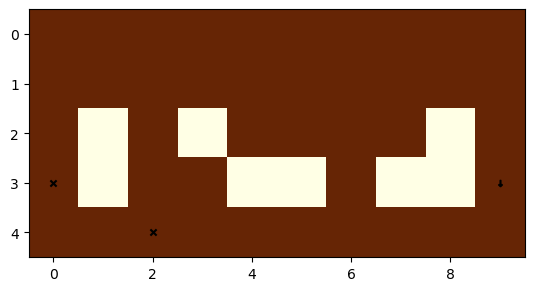

hello hello
--------------------------------------------------
Num timesteps: 1160000
Best mean reward: -80.66 - Last mean reward per episode: -156.48
current Design
[(0, 7)]


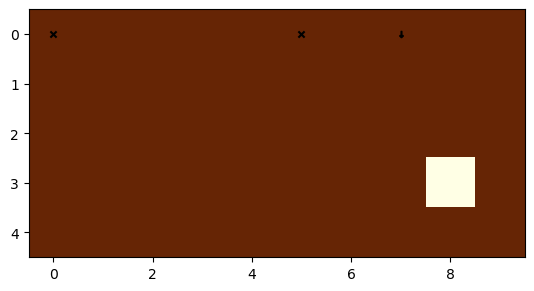

hello hello
--------------------------------------------------
Num timesteps: 1170000
Best mean reward: -80.66 - Last mean reward per episode: -131.97
current Design
[(0, 2)]


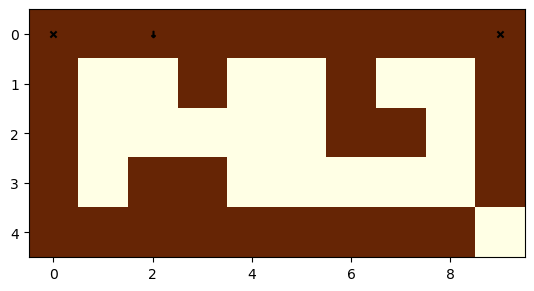

hello hello
--------------------------------------------------
Num timesteps: 1180000
Best mean reward: -80.66 - Last mean reward per episode: -112.65
current Design
[(0, 5)]


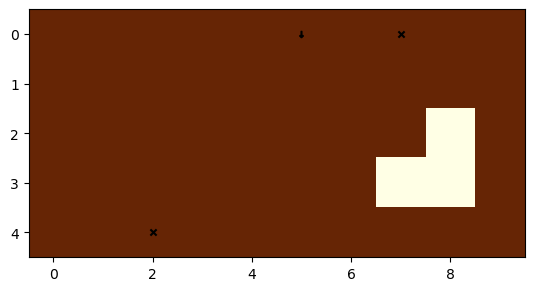

current Design
[(2, 9)]


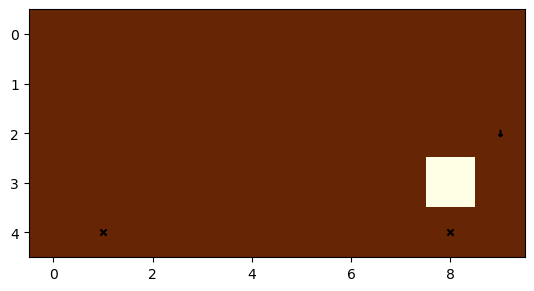

curr_reward 2.909283227815252
accumulated_reward 0
current Design
[(2, 9)]


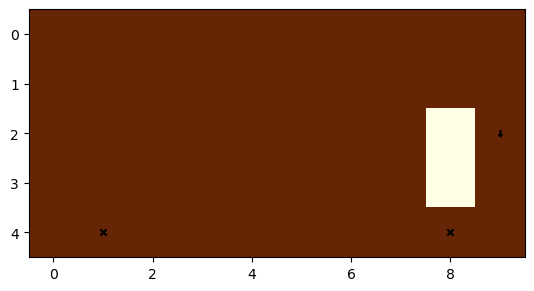

curr_reward 8.345842896594137
accumulated_reward 0
current Design
[(2, 9)]


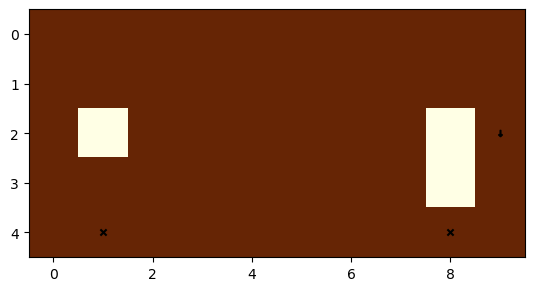

curr_reward 12.266116248204034
accumulated_reward 0
current Design
[(2, 9)]


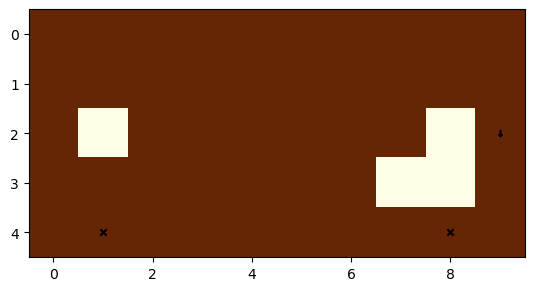

curr_reward 9.754674324008253
accumulated_reward 0
current Design
[(2, 9)]


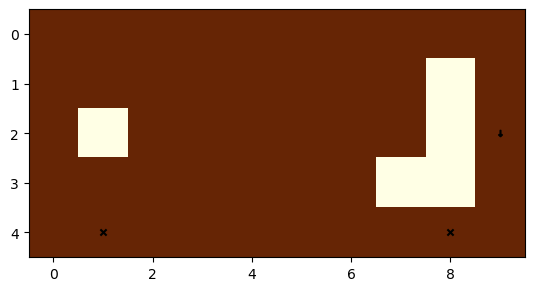

curr_reward 20.322428876679695
accumulated_reward 0
current Design
[(2, 9)]


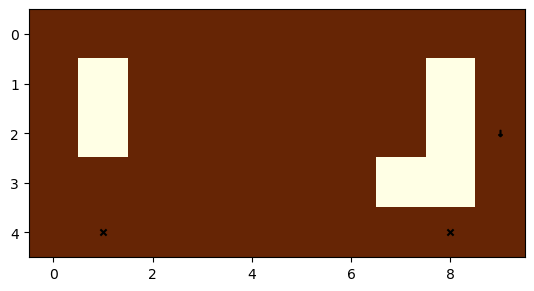

curr_reward 23.749369150690107
accumulated_reward 0
current Design
[(2, 9)]


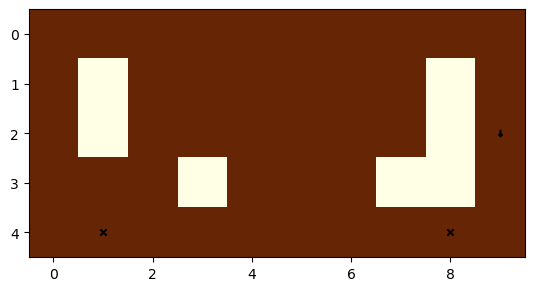

curr_reward 27.01577001398288
accumulated_reward 0
current Design
[(2, 9)]


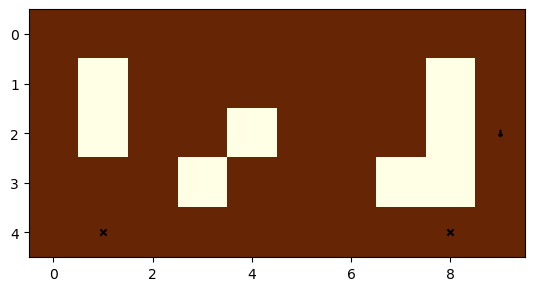

curr_reward 30.549924320261518
accumulated_reward 0
current Design
[(2, 9)]


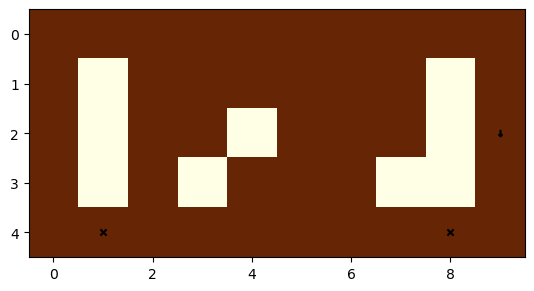

curr_reward 35.50000124358872
accumulated_reward 0
current Design
[(2, 9)]


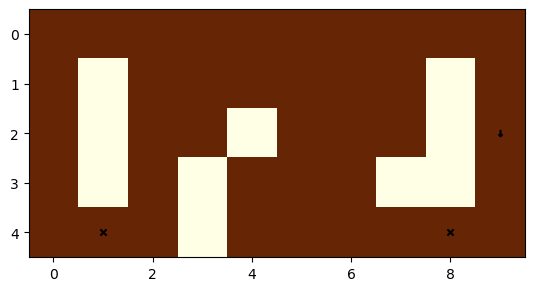

curr_reward 37.60156003514463
accumulated_reward 0
current Design
[(2, 9)]


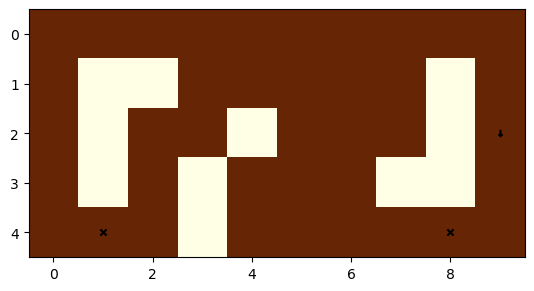

curr_reward 39.841185623832224
accumulated_reward 0
current Design
[(2, 9)]


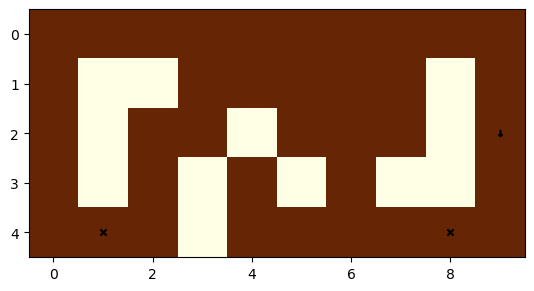

curr_reward 41.76992640188224
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1190000
Best mean reward: -80.66 - Last mean reward per episode: -147.13
current Design
[(2, 9)]


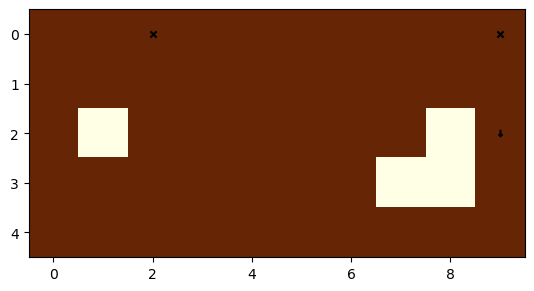

hello hello
--------------------------------------------------
Num timesteps: 1200000
Best mean reward: -80.66 - Last mean reward per episode: -137.80
current Design
[(1, 0)]


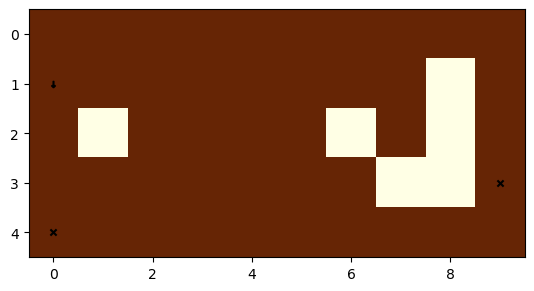

hello hello
--------------------------------------------------
Num timesteps: 1210000
Best mean reward: -80.66 - Last mean reward per episode: -94.47
current Design
[(4, 0)]


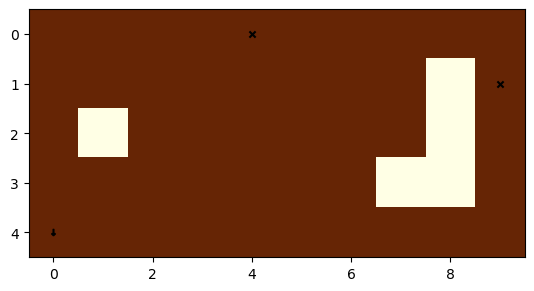

hello hello
--------------------------------------------------
Num timesteps: 1220000
Best mean reward: -80.66 - Last mean reward per episode: -109.65
current Design
[(2, 9)]


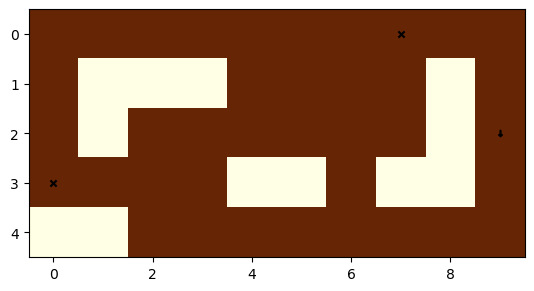

hello hello
--------------------------------------------------
Num timesteps: 1230000
Best mean reward: -80.66 - Last mean reward per episode: -83.48
current Design
[(2, 9)]


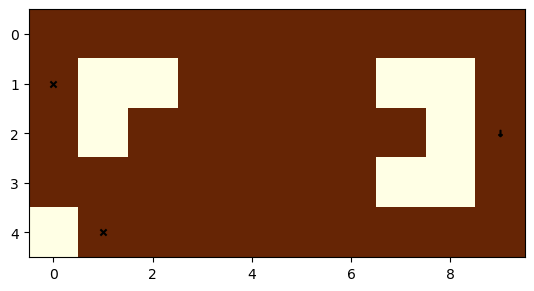

hello hello
--------------------------------------------------
Num timesteps: 1240000
Best mean reward: -80.66 - Last mean reward per episode: -99.78
current Design
[(0, 3)]


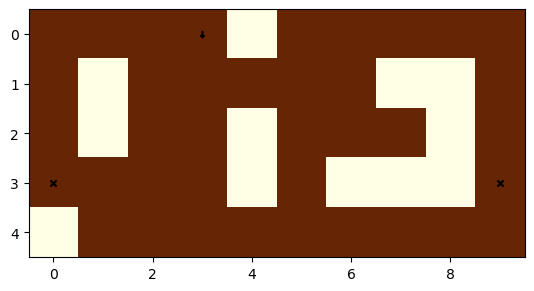

hello hello
--------------------------------------------------
Num timesteps: 1250000
Best mean reward: -80.66 - Last mean reward per episode: -90.14
current Design
[(4, 9)]


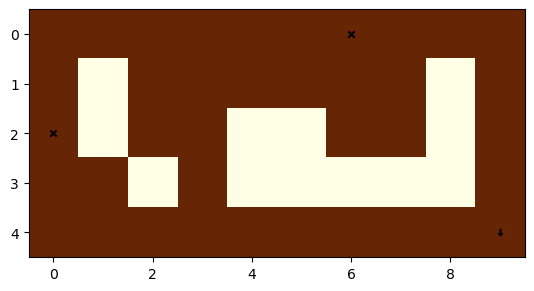

hello hello
--------------------------------------------------
Num timesteps: 1260000
Best mean reward: -80.66 - Last mean reward per episode: -61.19
current Design
[(2, 9)]


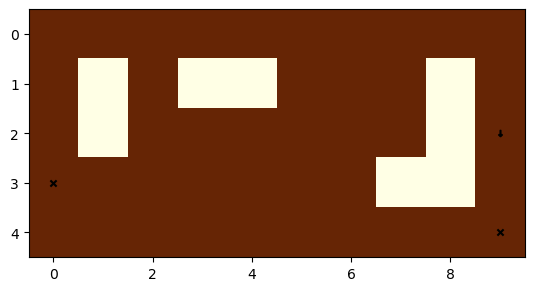

Saving new best model to log/best_model.zip
current Design
[(1, 0)]


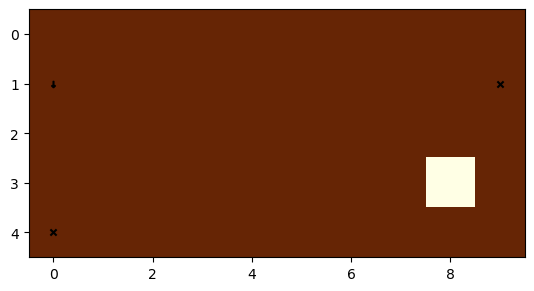

curr_reward 3.881996832374495
accumulated_reward 0
current Design
[(1, 0)]


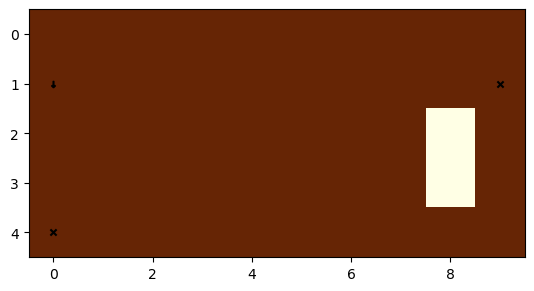

curr_reward 7.661973006722124
accumulated_reward 0
current Design
[(1, 0)]


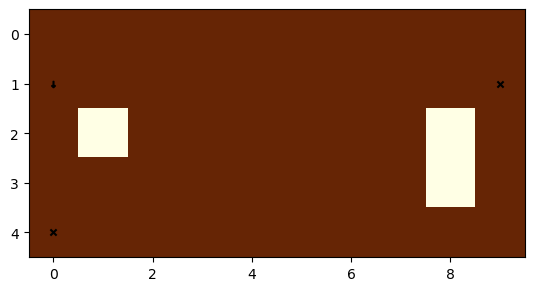

curr_reward 11.239238533198671
accumulated_reward 0
current Design
[(1, 0)]


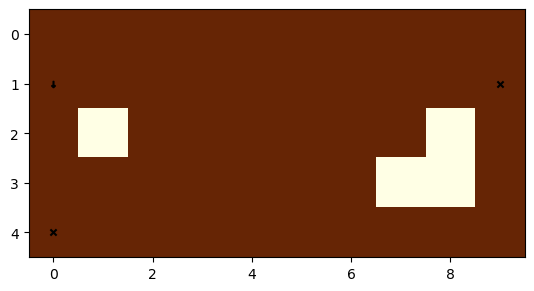

curr_reward 14.424372251403442
accumulated_reward 0
current Design
[(1, 0)]


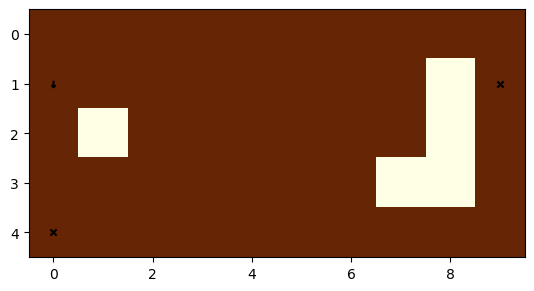

curr_reward 18.006587079113043
accumulated_reward 0
current Design
[(1, 0)]


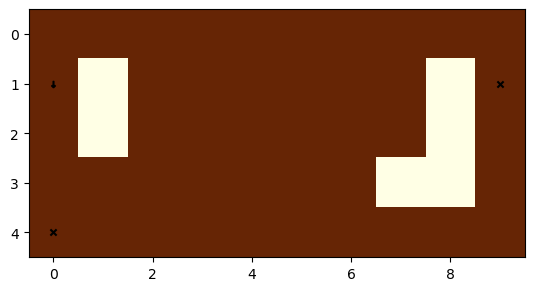

curr_reward 21.19542877754528
accumulated_reward 0
current Design
[(1, 0)]


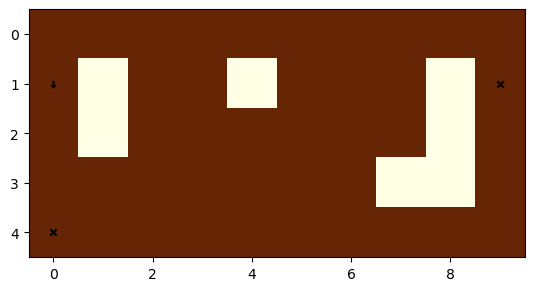

curr_reward 23.813048244594547
accumulated_reward 0
current Design
[(1, 0)]


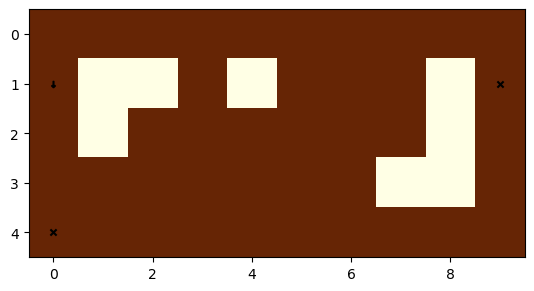

curr_reward 26.58931210511338
accumulated_reward 0
current Design
[(1, 0)]


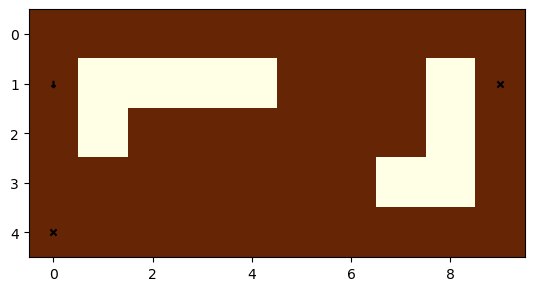

curr_reward 28.906433479497956
accumulated_reward 0
current Design
[(1, 0)]


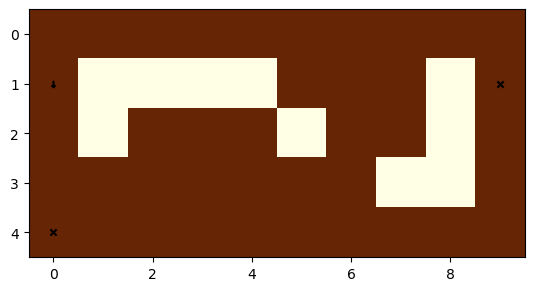

curr_reward 30.700593783793455
accumulated_reward 0
current Design
[(1, 0)]


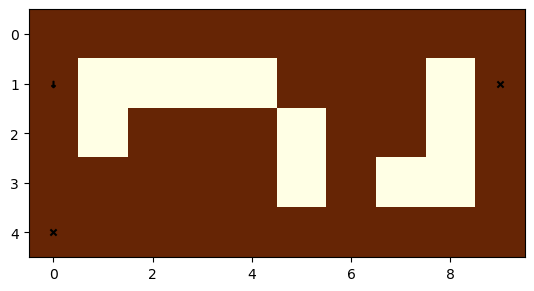

curr_reward 32.250116990631525
accumulated_reward 0
current Design
[(1, 0)]


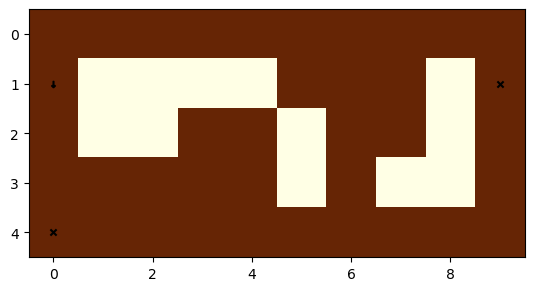

curr_reward 33.359285383443485
accumulated_reward 0
current Design
[(1, 0)]


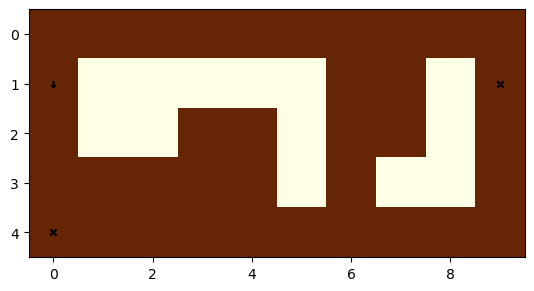

curr_reward 34.1794969295083
accumulated_reward 0
current Design
[(1, 0)]


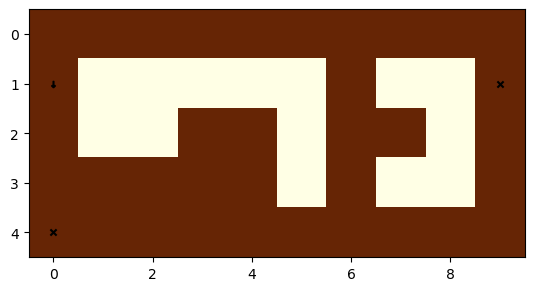

curr_reward 35.49485015045723
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1270000
Best mean reward: -61.19 - Last mean reward per episode: -101.25
current Design
[(4, 5)]


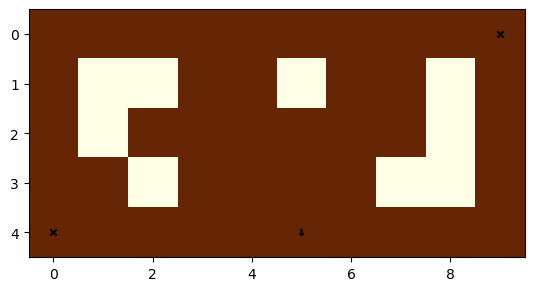

hello hello
--------------------------------------------------
Num timesteps: 1280000
Best mean reward: -61.19 - Last mean reward per episode: -107.30
current Design
[(4, 2)]


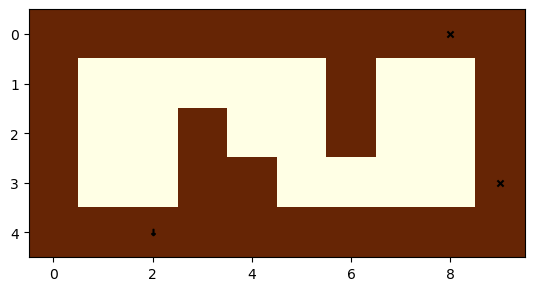

hello hello
--------------------------------------------------
Num timesteps: 1290000
Best mean reward: -61.19 - Last mean reward per episode: -95.26
current Design
[(4, 0)]


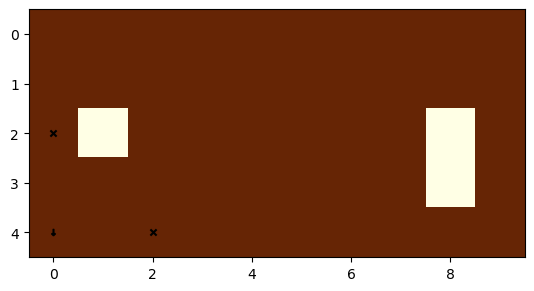

hello hello
--------------------------------------------------
Num timesteps: 1300000
Best mean reward: -61.19 - Last mean reward per episode: -132.75
current Design
[(3, 0)]


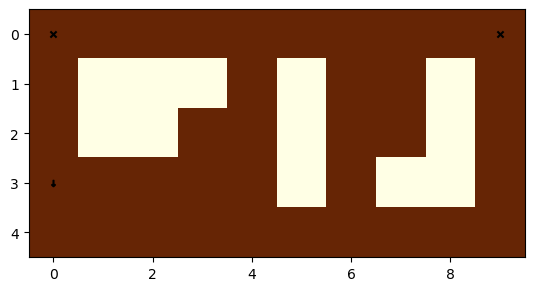

hello hello
--------------------------------------------------
Num timesteps: 1310000
Best mean reward: -61.19 - Last mean reward per episode: -124.45
current Design
[(4, 6)]


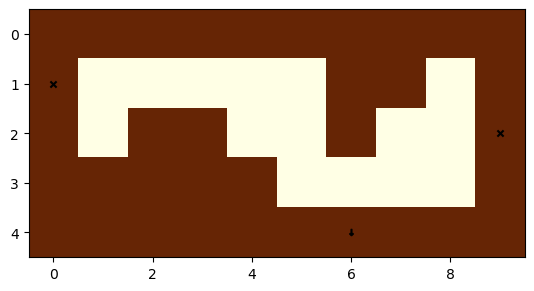

hello hello
--------------------------------------------------
Num timesteps: 1320000
Best mean reward: -61.19 - Last mean reward per episode: -131.41
current Design
[(2, 0)]


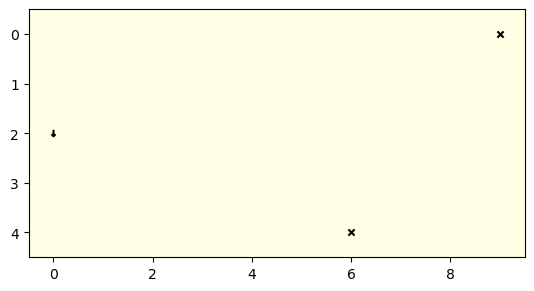

hello hello
--------------------------------------------------
Num timesteps: 1330000
Best mean reward: -61.19 - Last mean reward per episode: -118.08
current Design
[(0, 9)]


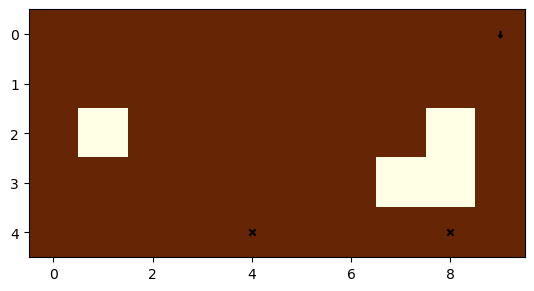

hello hello
--------------------------------------------------
Num timesteps: 1340000
Best mean reward: -61.19 - Last mean reward per episode: -69.23
current Design
[(4, 9)]


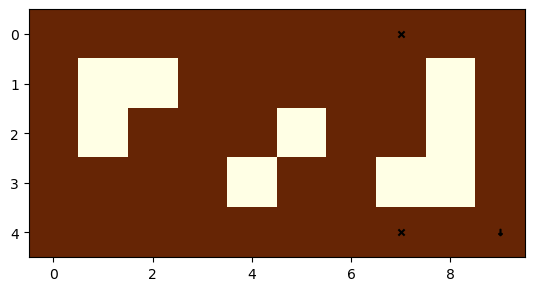

current Design
[(0, 0)]


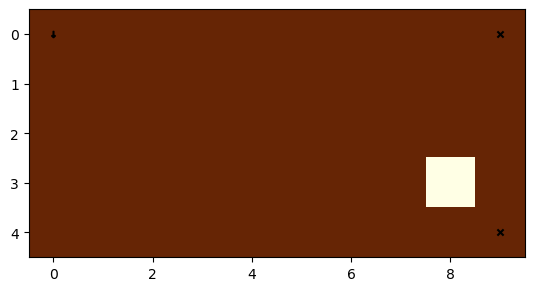

curr_reward 3.875730267730938
accumulated_reward 0
current Design
[(0, 0)]


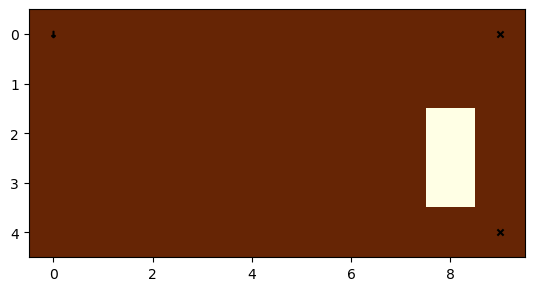

curr_reward 7.531072278096085
accumulated_reward 0
current Design
[(0, 0)]


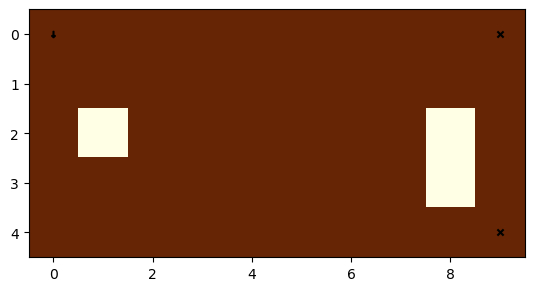

curr_reward 10.907570942035752
accumulated_reward 0
current Design
[(0, 0)]


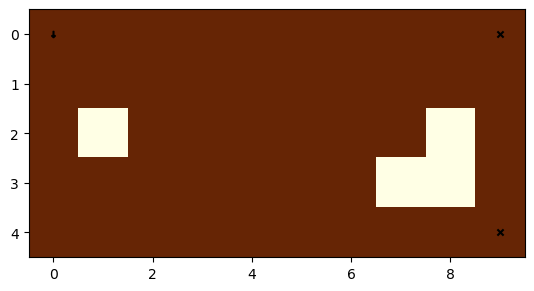

curr_reward 14.23749352259027
accumulated_reward 0
current Design
[(0, 0)]


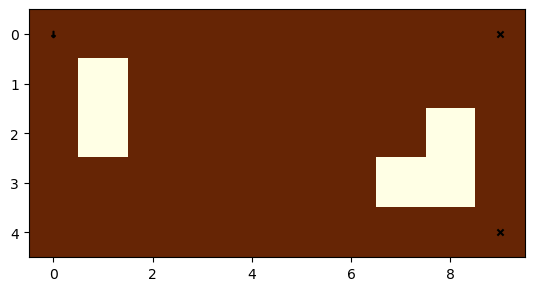

curr_reward 17.141664451332943
accumulated_reward 0
current Design
[(0, 0)]


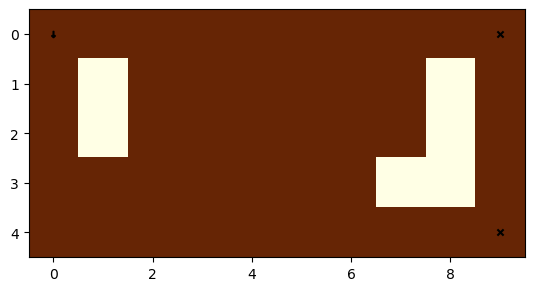

curr_reward 19.58424110456548
accumulated_reward 0
current Design
[(0, 0)]


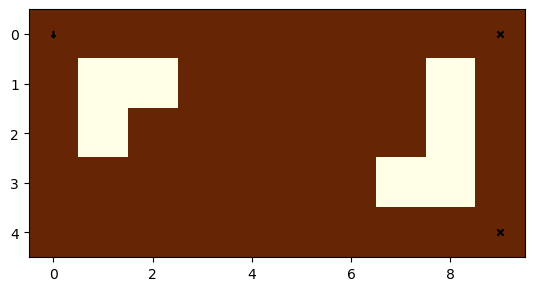

curr_reward 22.02107515457621
accumulated_reward 0
current Design
[(0, 0)]


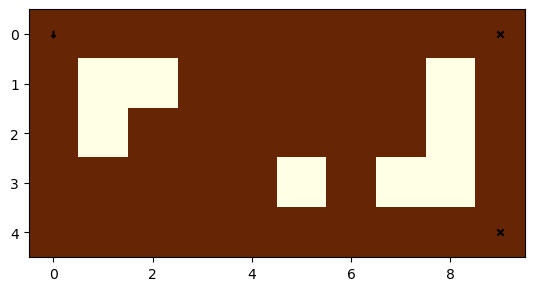

curr_reward 24.212688067561526
accumulated_reward 0
current Design
[(0, 0)]


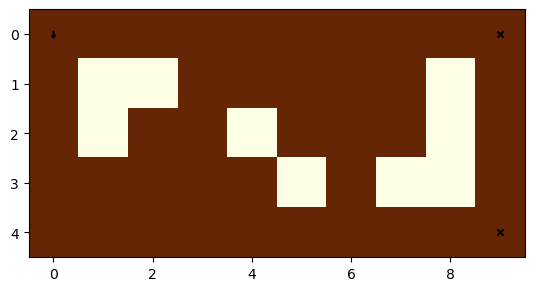

curr_reward 26.23917830124744
accumulated_reward 0
current Design
[(0, 0)]


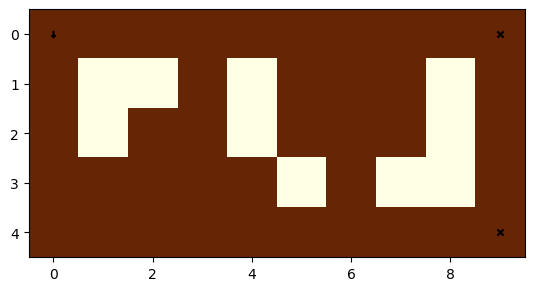

curr_reward 27.72541809374677
accumulated_reward 0
current Design
[(0, 0)]


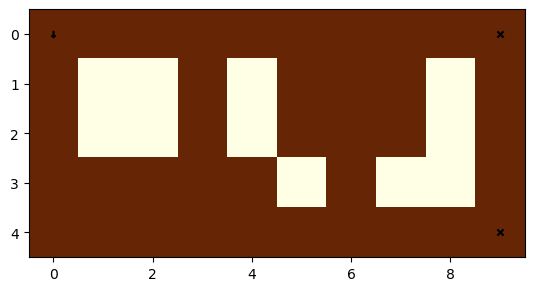

curr_reward 28.819451893211294
accumulated_reward 0
current Design
[(0, 0)]


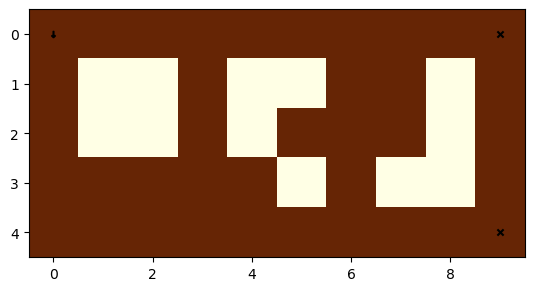

curr_reward 30.118998070012182
accumulated_reward 0
current Design
[(0, 0)]


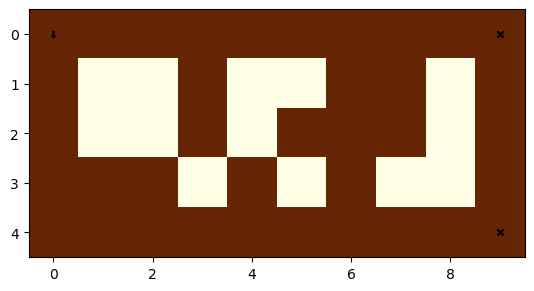

curr_reward 31.42679411955823
accumulated_reward 0
current Design
[(0, 0)]


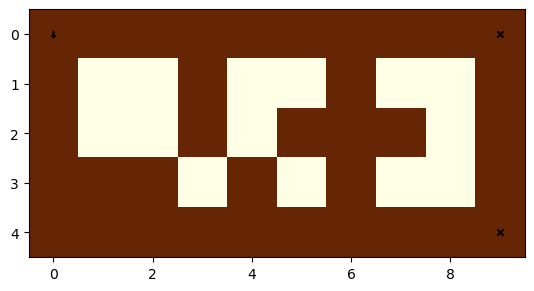

curr_reward 31.919023390109754
accumulated_reward 0
current Design
[(0, 0)]


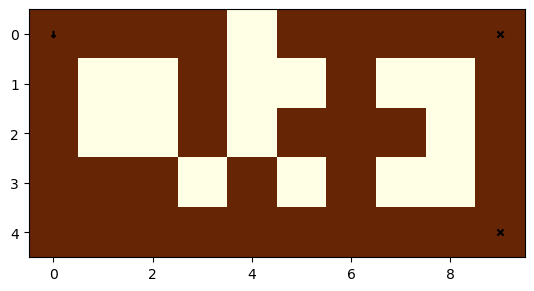

curr_reward 33.163663842728646
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1350000
Best mean reward: -61.19 - Last mean reward per episode: -83.55
current Design
[(4, 0)]


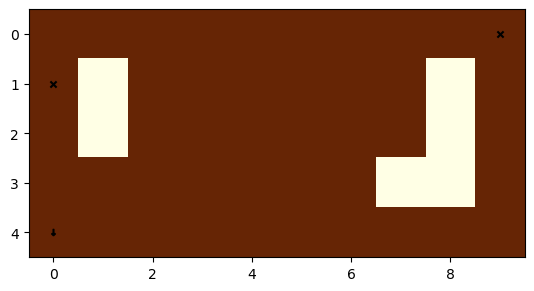

hello hello
--------------------------------------------------
Num timesteps: 1360000
Best mean reward: -61.19 - Last mean reward per episode: -129.66
current Design
[(4, 9)]


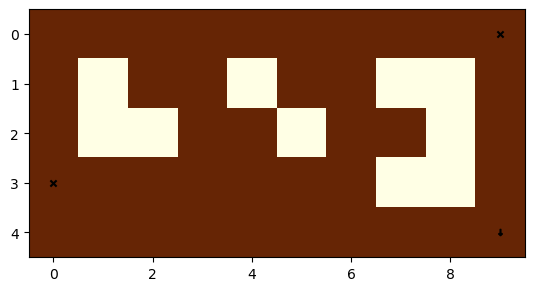

hello hello
--------------------------------------------------
Num timesteps: 1370000
Best mean reward: -61.19 - Last mean reward per episode: -129.04
current Design
[(1, 0)]


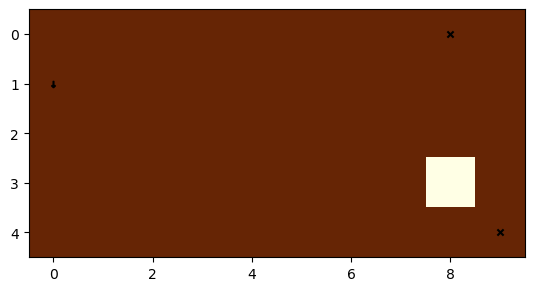

hello hello
--------------------------------------------------
Num timesteps: 1380000
Best mean reward: -61.19 - Last mean reward per episode: -29.38
current Design
[(4, 9)]


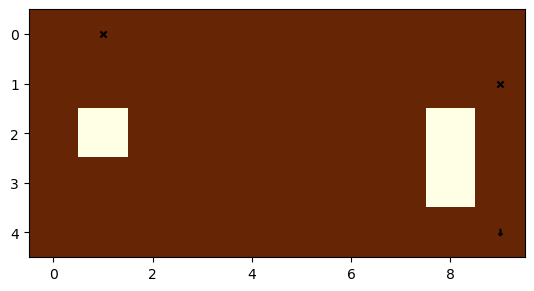

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1390000
Best mean reward: -29.38 - Last mean reward per episode: -55.43
current Design
[(4, 5)]


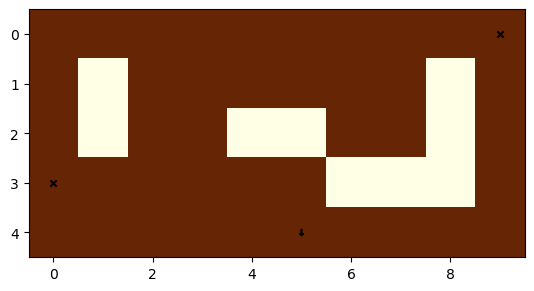

hello hello
--------------------------------------------------
Num timesteps: 1400000
Best mean reward: -29.38 - Last mean reward per episode: -103.69
current Design
[(0, 1)]


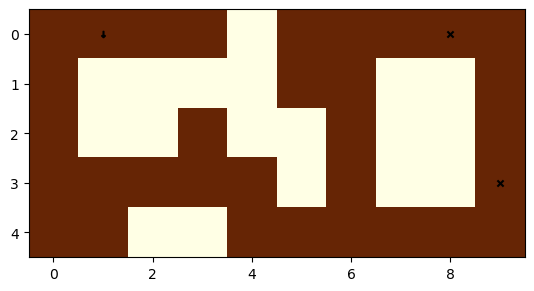

hello hello
--------------------------------------------------
Num timesteps: 1410000
Best mean reward: -29.38 - Last mean reward per episode: -92.69
current Design
[(4, 7)]


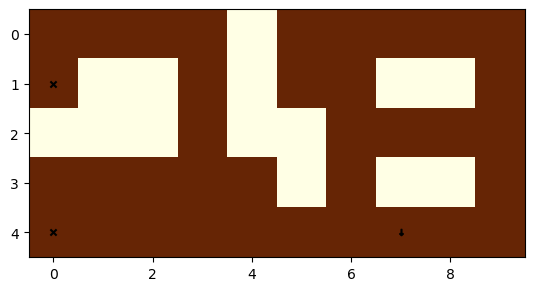

hello hello
--------------------------------------------------
Num timesteps: 1420000
Best mean reward: -29.38 - Last mean reward per episode: -89.34
current Design
[(3, 0)]


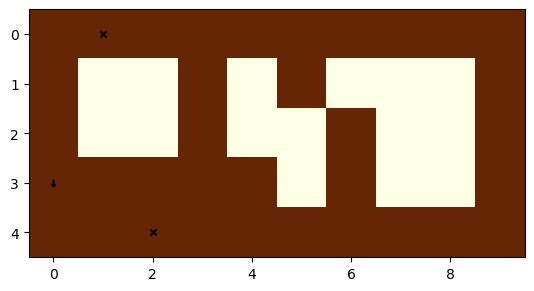

current Design
[(0, 0)]


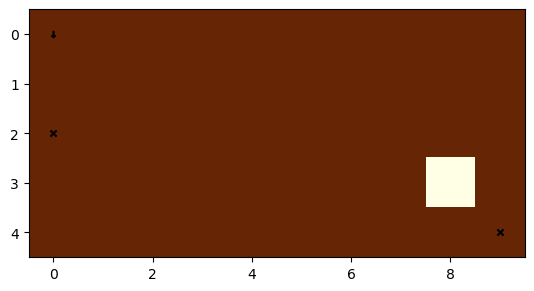

curr_reward 3.9261225662295756
accumulated_reward 0
current Design
[(0, 0)]


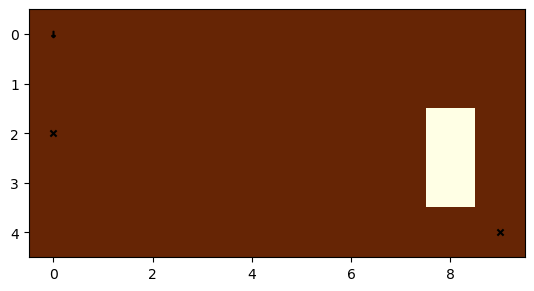

curr_reward 7.70982738938111
accumulated_reward 0
current Design
[(0, 0)]


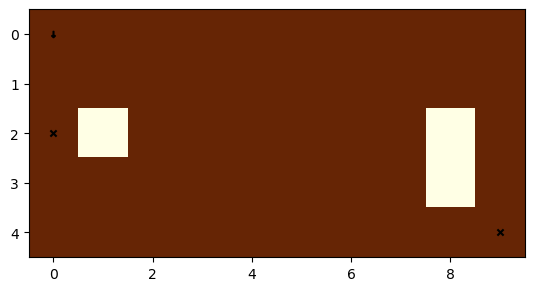

curr_reward 9.670912322483124
accumulated_reward 0
current Design
[(0, 0)]


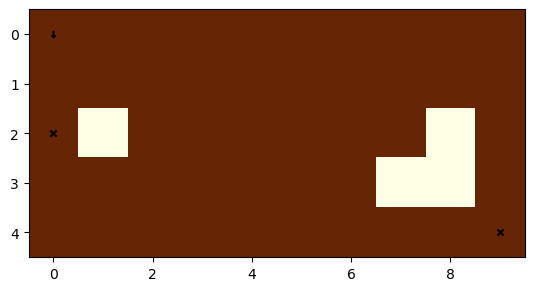

curr_reward 12.848131538541429
accumulated_reward 0
current Design
[(0, 0)]


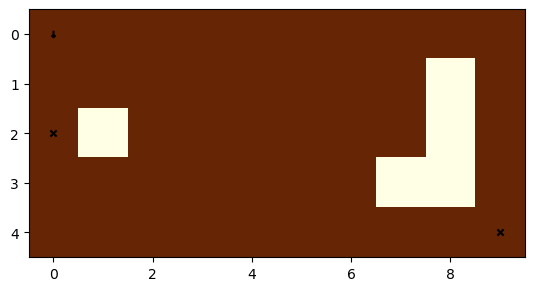

curr_reward 15.783116091820856
accumulated_reward 0
current Design
[(0, 0)]


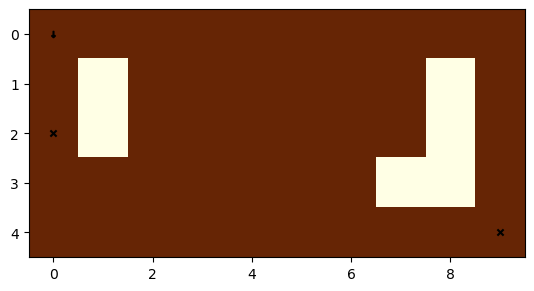

curr_reward 19.052025829760492
accumulated_reward 0
current Design
[(0, 0)]


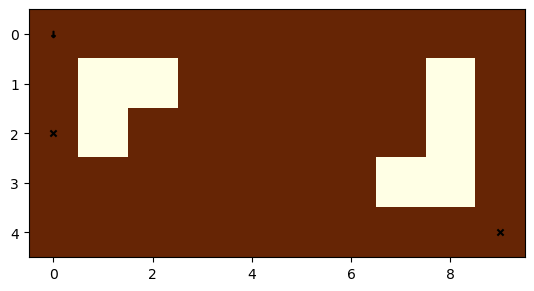

curr_reward 23.060625648432204
accumulated_reward 0
current Design
[(0, 0)]


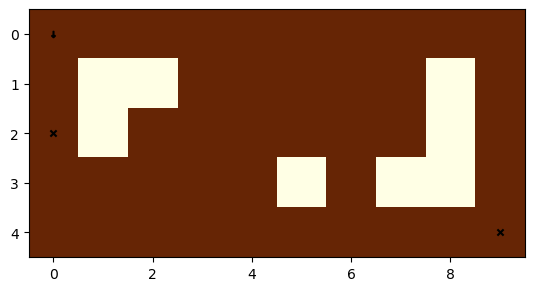

curr_reward 25.562504548693713
accumulated_reward 0
current Design
[(0, 0)]


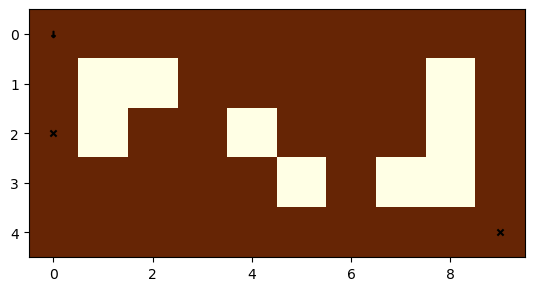

curr_reward 27.799472981099438
accumulated_reward 0
current Design
[(0, 0)]


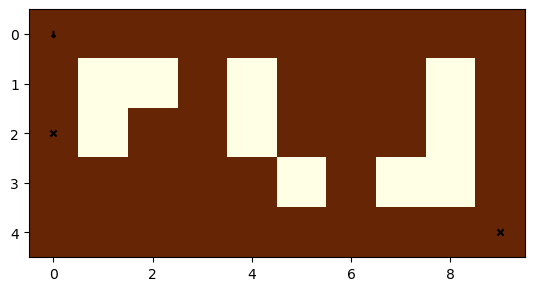

curr_reward 30.588985495307863
accumulated_reward 0
current Design
[(0, 0)]


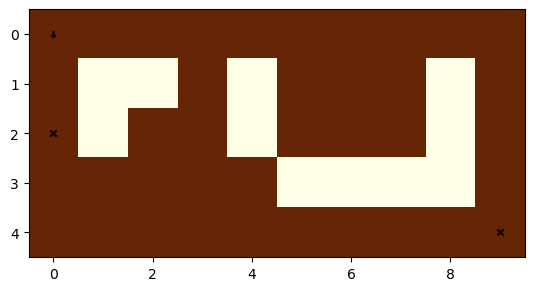

curr_reward 33.12608731566677
accumulated_reward 0
current Design
[(0, 0)]


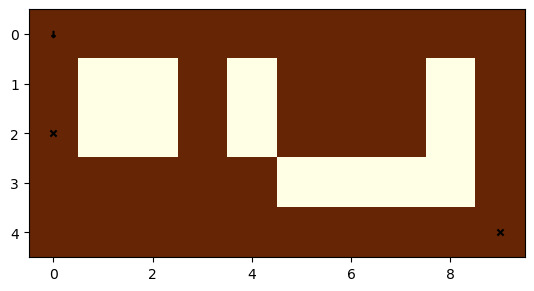

curr_reward 33.51395076314246
accumulated_reward 0
current Design
[(0, 0)]


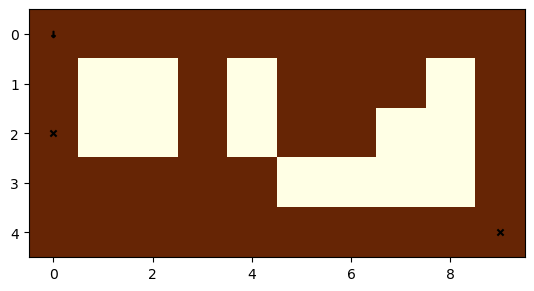

curr_reward 34.550992437073134
accumulated_reward 0
current Design
[(0, 0)]


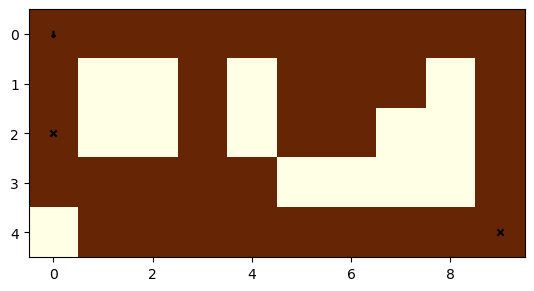

curr_reward 35.11269297724494
accumulated_reward 0
current Design
[(0, 0)]


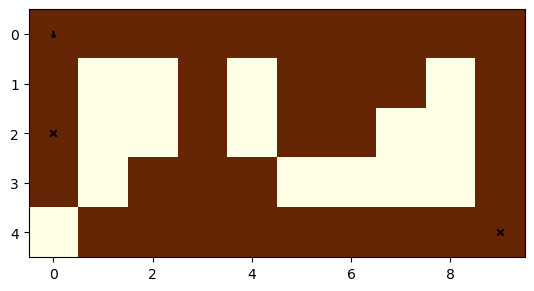

curr_reward 32.80779798689313
accumulated_reward 0
current Design
[(0, 0)]


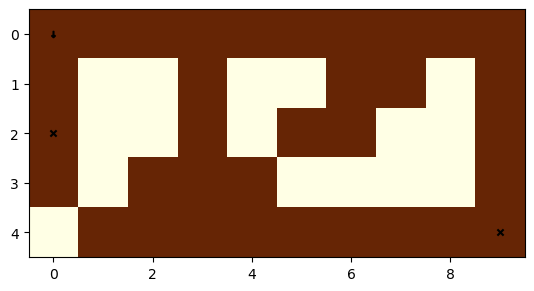

curr_reward 33.587274826494706
accumulated_reward 0
current Design
[(0, 0)]


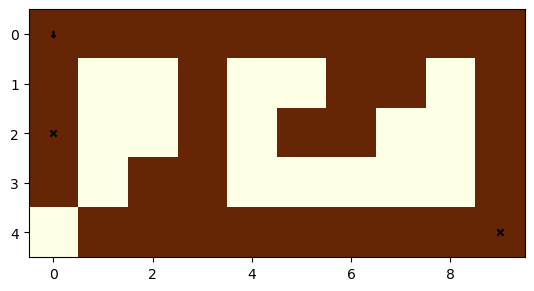

curr_reward 34.950773024975504
accumulated_reward 0
current Design
[(0, 0)]


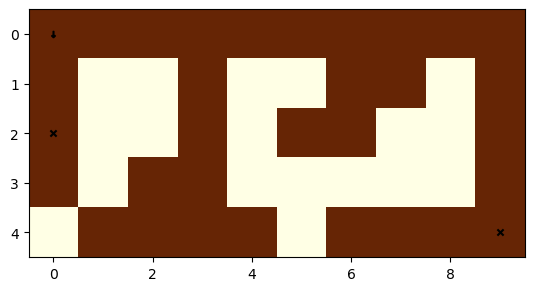

curr_reward 39.573547430127014
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1430000
Best mean reward: -29.38 - Last mean reward per episode: -13.92
current Design
[(3, 0)]


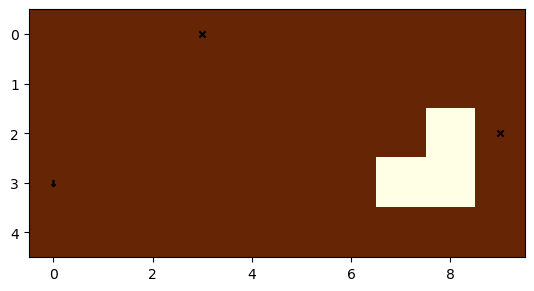

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1440000
Best mean reward: -13.92 - Last mean reward per episode: -93.15
current Design
[(4, 3)]


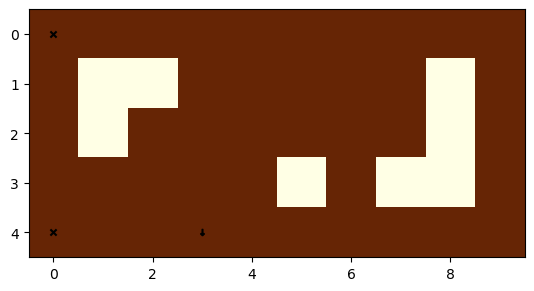

hello hello
--------------------------------------------------
Num timesteps: 1450000
Best mean reward: -13.92 - Last mean reward per episode: -125.56
current Design
[(2, 0)]


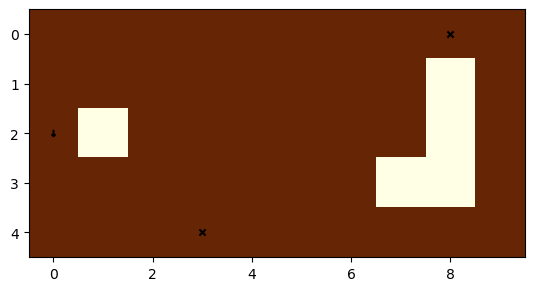

hello hello
--------------------------------------------------
Num timesteps: 1460000
Best mean reward: -13.92 - Last mean reward per episode: -67.03
current Design
[(4, 3)]


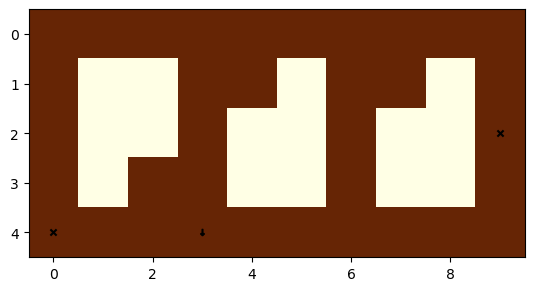

hello hello
--------------------------------------------------
Num timesteps: 1470000
Best mean reward: -13.92 - Last mean reward per episode: -53.46
current Design
[(4, 0)]


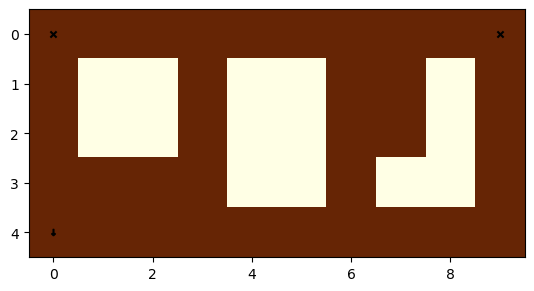

hello hello
--------------------------------------------------
Num timesteps: 1480000
Best mean reward: -13.92 - Last mean reward per episode: -140.56
current Design
[(4, 0)]


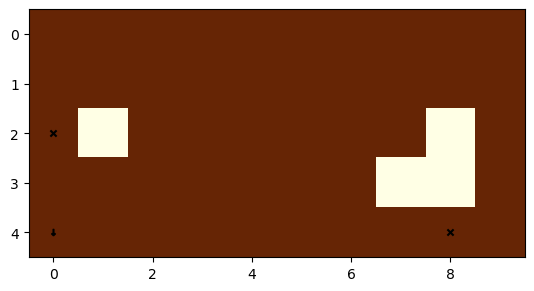

hello hello
--------------------------------------------------
Num timesteps: 1490000
Best mean reward: -13.92 - Last mean reward per episode: -101.61
current Design
[(2, 9)]


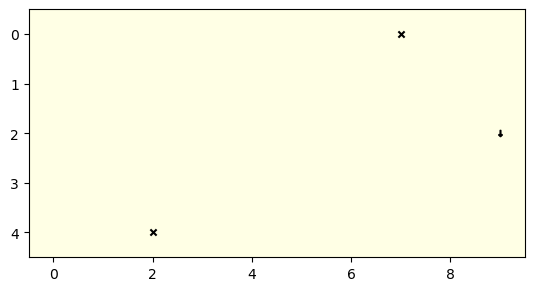

hello hello
--------------------------------------------------
Num timesteps: 1500000
Best mean reward: -13.92 - Last mean reward per episode: -60.21
current Design
[(4, 6)]


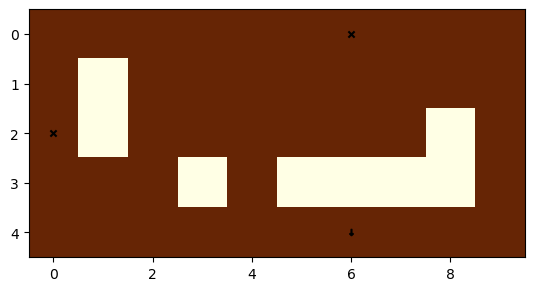

hello hello
--------------------------------------------------
Num timesteps: 1510000
Best mean reward: -13.92 - Last mean reward per episode: -77.45
current Design
[(2, 9)]


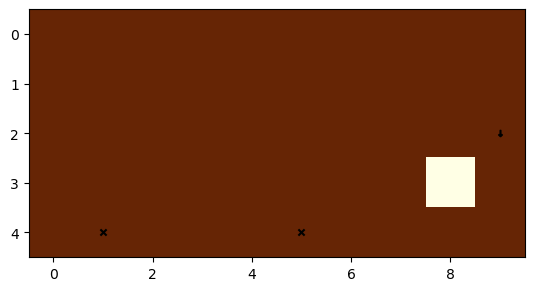

current Design
[(4, 9)]


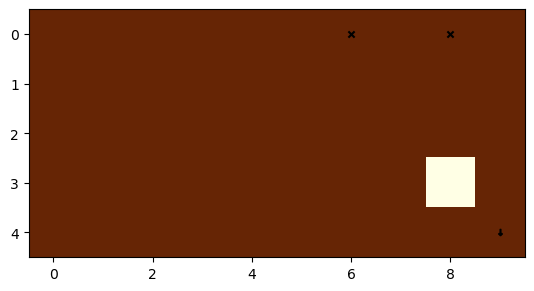

curr_reward 3.9576241460739348
accumulated_reward 0
current Design
[(4, 9)]


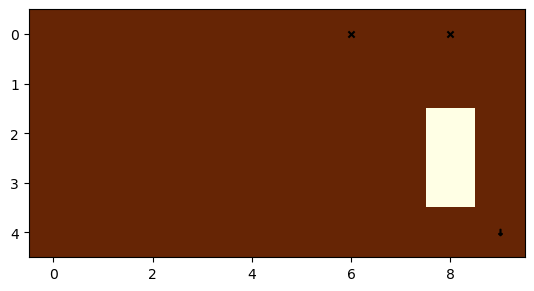

curr_reward 7.860006833860377
accumulated_reward 0
current Design
[(4, 9)]


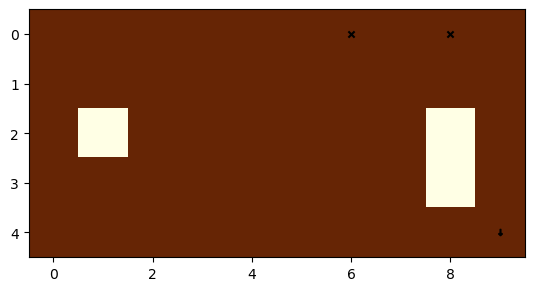

curr_reward 11.302753133416196
accumulated_reward 0
current Design
[(4, 9)]


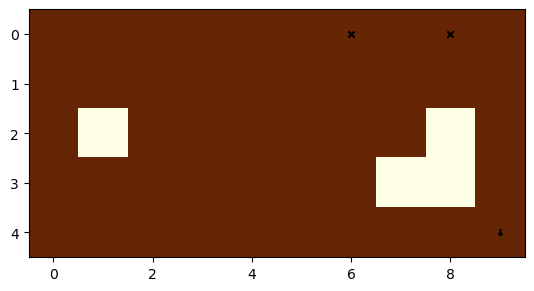

curr_reward 14.854726508450018
accumulated_reward 0
current Design
[(4, 9)]


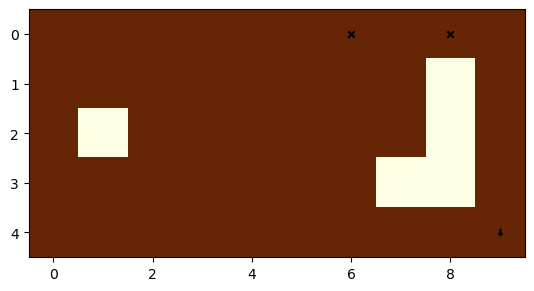

curr_reward 17.62743152909628
accumulated_reward 0
current Design
[(4, 9)]


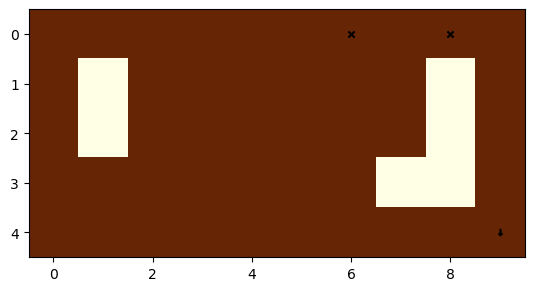

curr_reward 20.209613117240078
accumulated_reward 0
current Design
[(4, 9)]


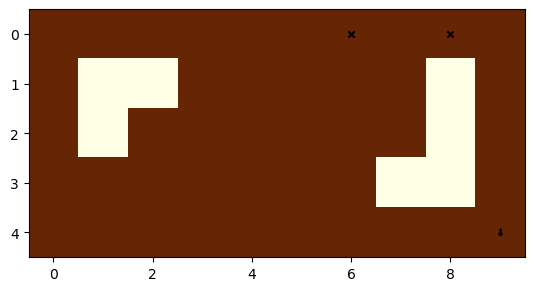

curr_reward 22.483177199907118
accumulated_reward 0
current Design
[(4, 9)]


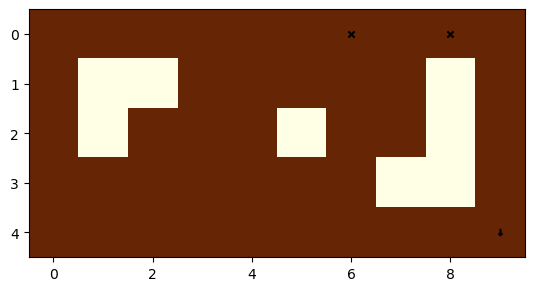

curr_reward 24.3418636455131
accumulated_reward 0
current Design
[(4, 9)]


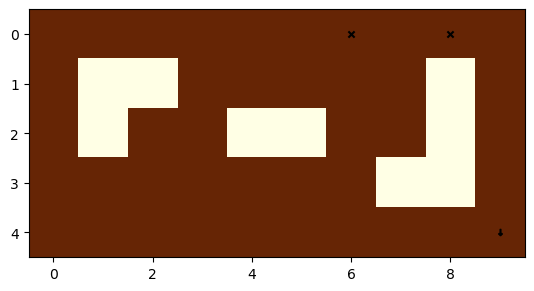

curr_reward 26.026412977554553
accumulated_reward 0
current Design
[(4, 9)]


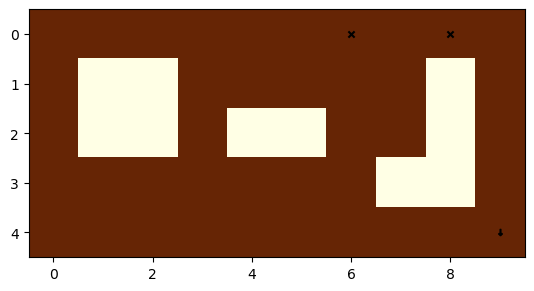

curr_reward 27.432710119749416
accumulated_reward 0
current Design
[(4, 9)]


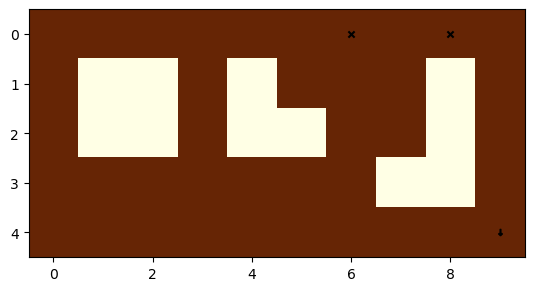

curr_reward 28.979510881133617
accumulated_reward 0
current Design
[(4, 9)]


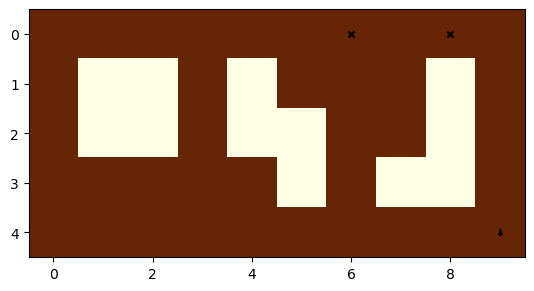

curr_reward 29.946055250062575
accumulated_reward 0
current Design
[(4, 9)]


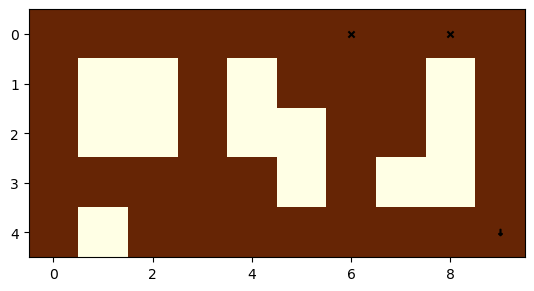

curr_reward 30.765858383585993
accumulated_reward 0
current Design
[(4, 9)]


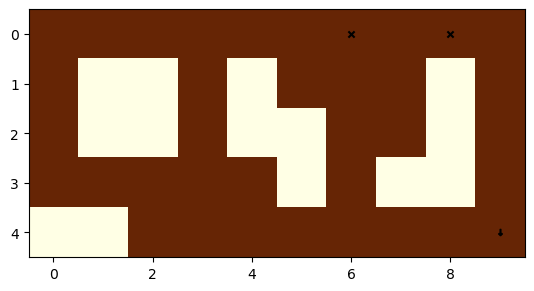

curr_reward 31.36954724501571
accumulated_reward 0
current Design
[(4, 9)]


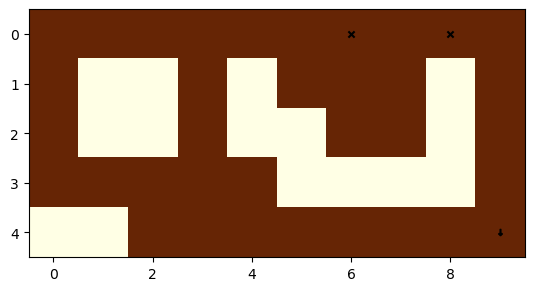

curr_reward 35.2432165011405
accumulated_reward 0
current Design
[(4, 9)]


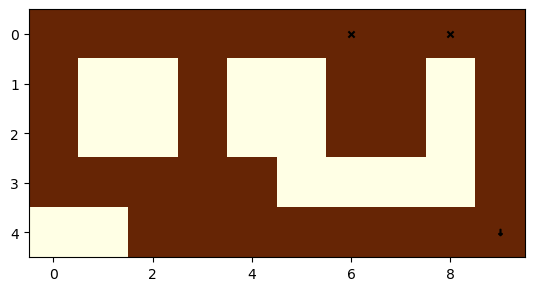

curr_reward 35.288531594915305
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1520000
Best mean reward: -13.92 - Last mean reward per episode: -74.75
current Design
[(4, 9)]


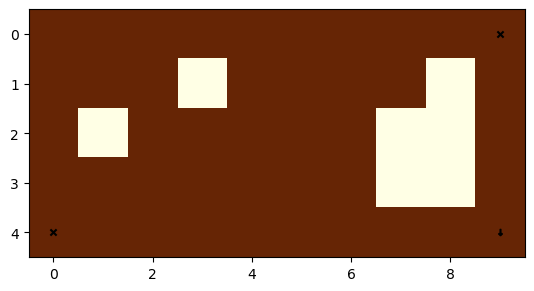

hello hello
--------------------------------------------------
Num timesteps: 1530000
Best mean reward: -13.92 - Last mean reward per episode: -97.86
current Design
[(0, 9)]


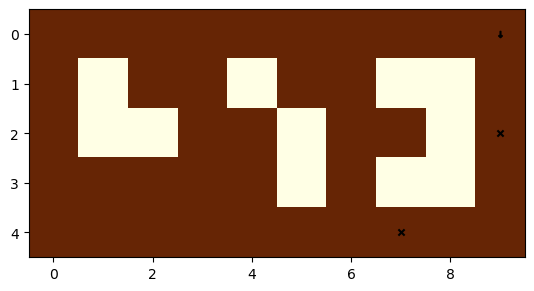

hello hello
--------------------------------------------------
Num timesteps: 1540000
Best mean reward: -13.92 - Last mean reward per episode: -66.38
current Design
[(4, 2)]


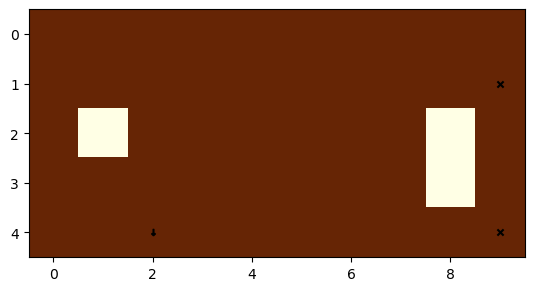

hello hello
--------------------------------------------------
Num timesteps: 1550000
Best mean reward: -13.92 - Last mean reward per episode: -58.14
current Design
[(1, 0)]


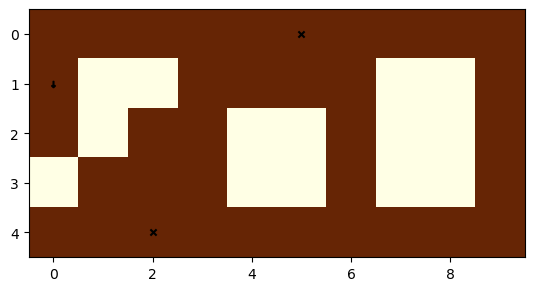

hello hello
--------------------------------------------------
Num timesteps: 1560000
Best mean reward: -13.92 - Last mean reward per episode: -68.70
current Design
[(4, 5)]


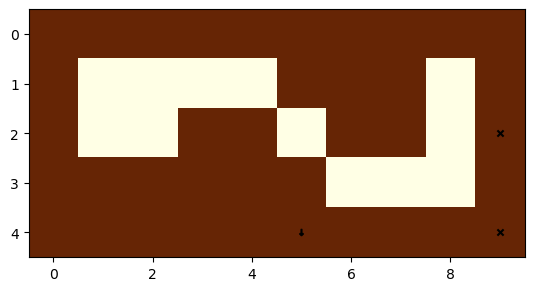

hello hello
--------------------------------------------------
Num timesteps: 1570000
Best mean reward: -13.92 - Last mean reward per episode: -77.60
current Design
[(3, 0)]


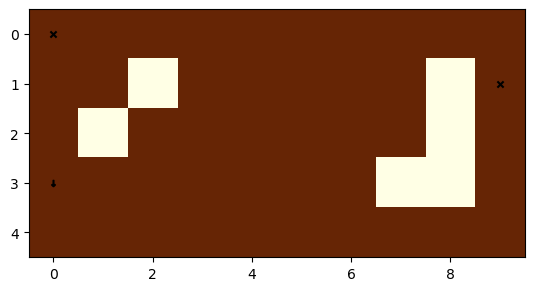

hello hello
--------------------------------------------------
Num timesteps: 1580000
Best mean reward: -13.92 - Last mean reward per episode: -32.79
current Design
[(0, 0)]


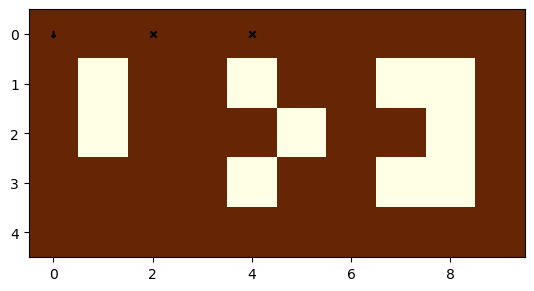

hello hello
--------------------------------------------------
Num timesteps: 1590000
Best mean reward: -13.92 - Last mean reward per episode: 4.92
current Design
[(4, 9)]


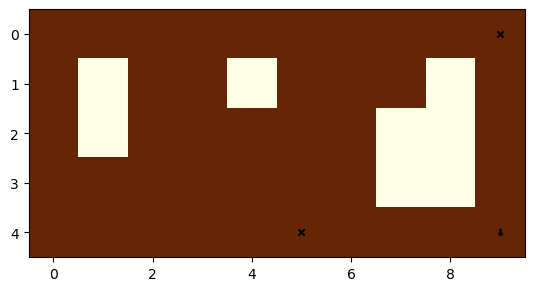

Saving new best model to log/best_model.zip
current Design
[(0, 8)]


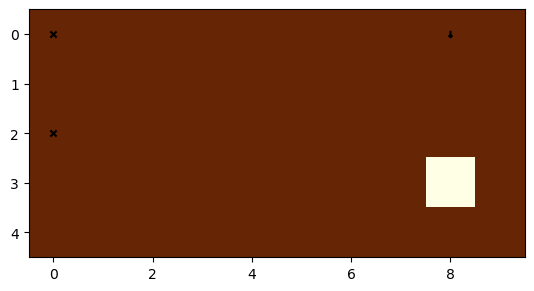

curr_reward 3.8559532849659623
accumulated_reward 0
current Design
[(0, 8)]


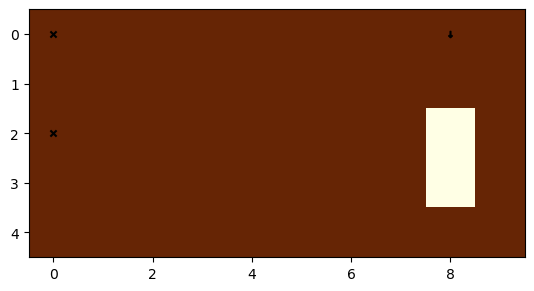

curr_reward 7.407459401168381
accumulated_reward 0
current Design
[(0, 8)]


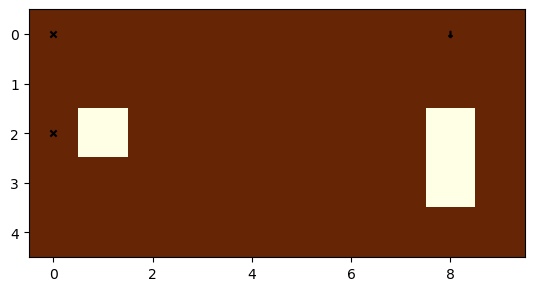

curr_reward 10.57777450555606
accumulated_reward 0
current Design
[(0, 8)]


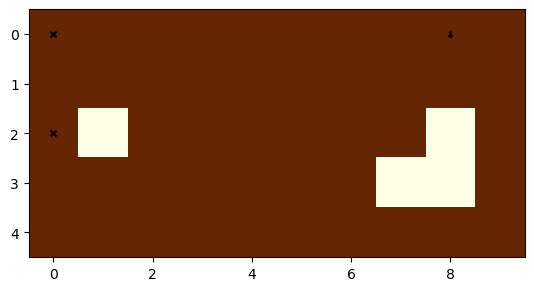

curr_reward 13.520447628038614
accumulated_reward 0
current Design
[(0, 8)]


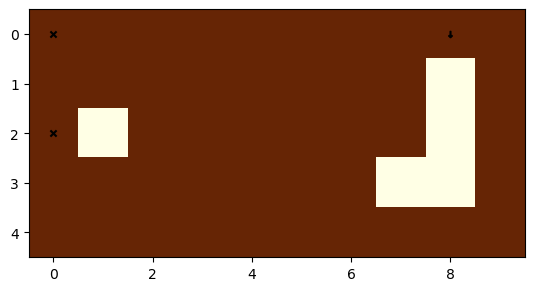

curr_reward 15.950725117901653
accumulated_reward 0
current Design
[(0, 8)]


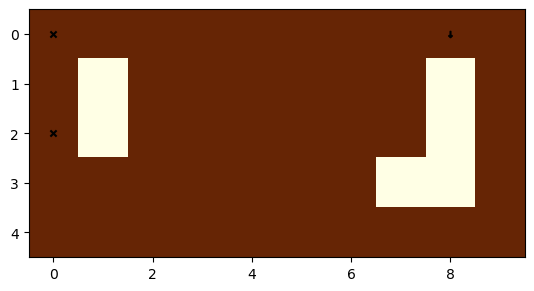

curr_reward 18.525439691127637
accumulated_reward 0
current Design
[(0, 8)]


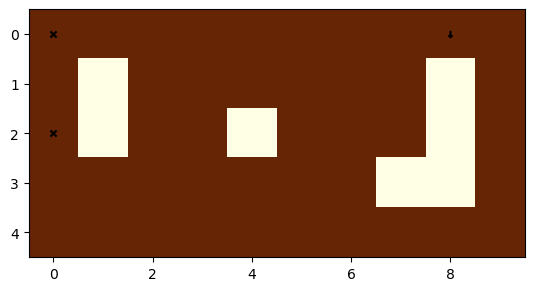

curr_reward 20.831343582094952
accumulated_reward 0
current Design
[(0, 8)]


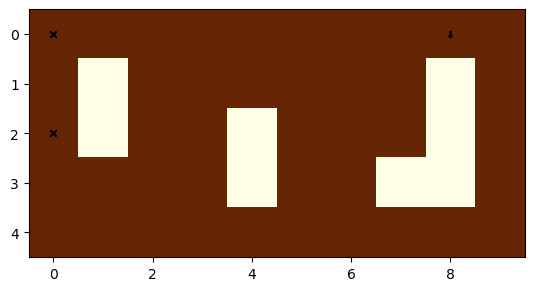

curr_reward 22.831946700144037
accumulated_reward 0
current Design
[(0, 8)]


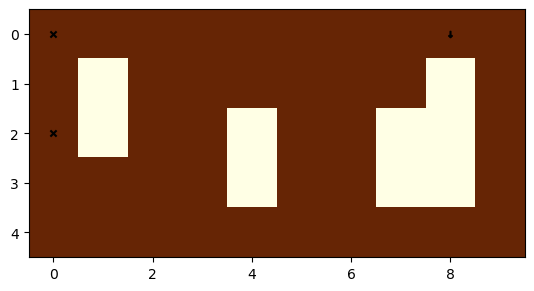

curr_reward 24.635738384964444
accumulated_reward 0
current Design
[(0, 8)]


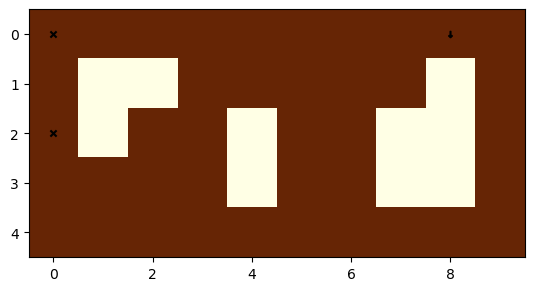

curr_reward 27.904819295267018
accumulated_reward 0
current Design
[(0, 8)]


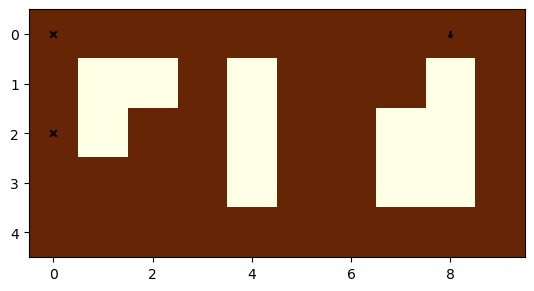

curr_reward 29.736203370944
accumulated_reward 0
current Design
[(0, 8)]


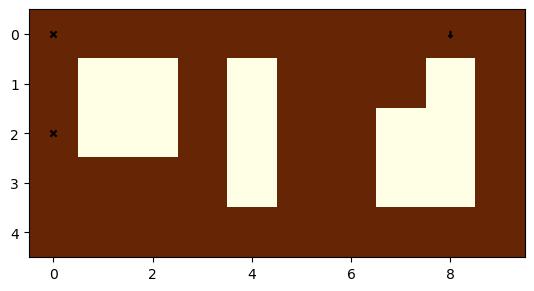

curr_reward 30.086729480245864
accumulated_reward 0
current Design
[(0, 8)]


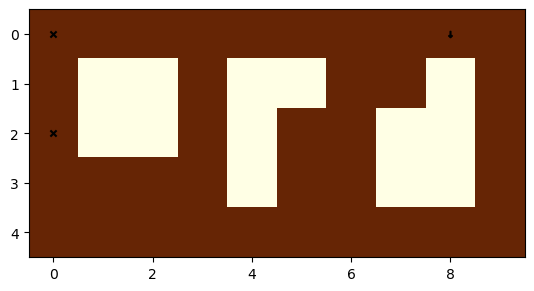

curr_reward 31.894677233969425
accumulated_reward 0
current Design
[(0, 8)]


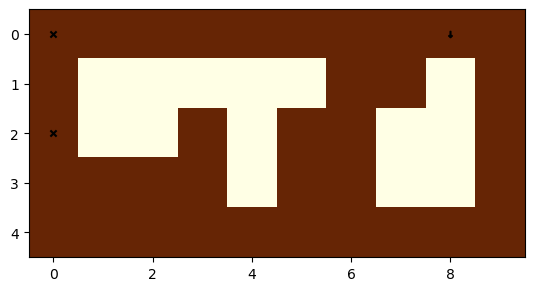

curr_reward 33.63174346350876
accumulated_reward 0
current Design
[(0, 8)]


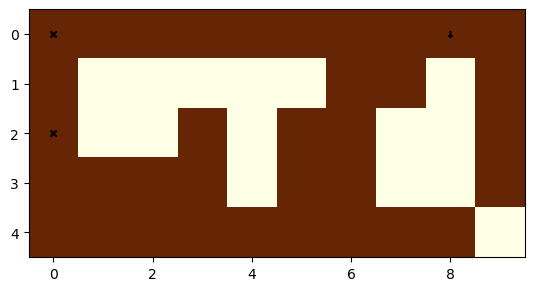

curr_reward 34.39850304367011
accumulated_reward 0
current Design
[(0, 8)]


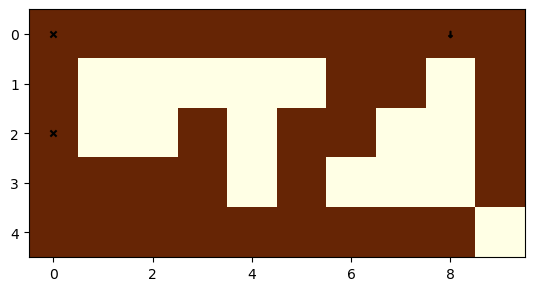

curr_reward 34.289571524220655
accumulated_reward 0
current Design
[(0, 8)]


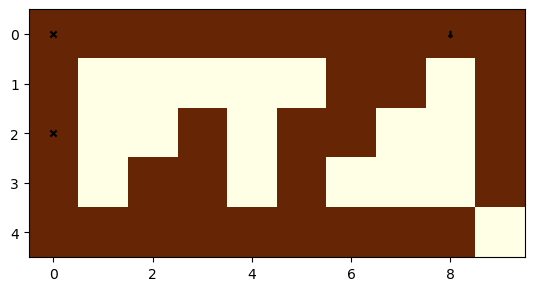

curr_reward 32.97882246425415
accumulated_reward 0
current Design
[(0, 8)]


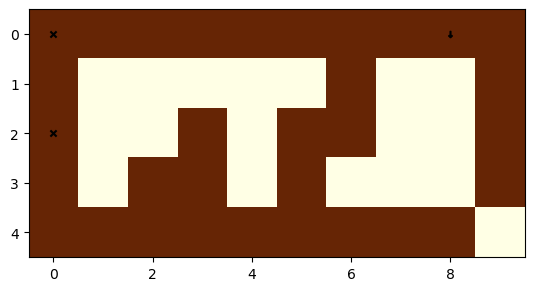

curr_reward 33.24989399542929
accumulated_reward 0
current Design
[(0, 8)]


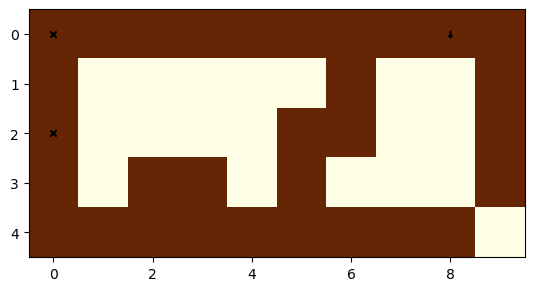

curr_reward 32.734539699751956
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1600000
Best mean reward: 4.92 - Last mean reward per episode: -6.28
current Design
[(0, 9)]


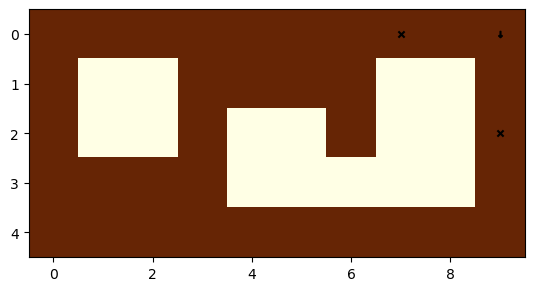

hello hello
--------------------------------------------------
Num timesteps: 1610000
Best mean reward: 4.92 - Last mean reward per episode: -37.18
current Design
[(0, 9)]


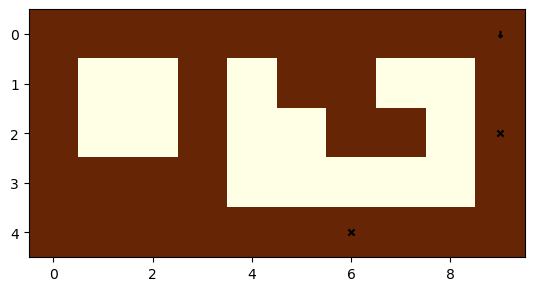

hello hello
--------------------------------------------------
Num timesteps: 1620000
Best mean reward: 4.92 - Last mean reward per episode: -55.13
current Design
[(4, 7)]


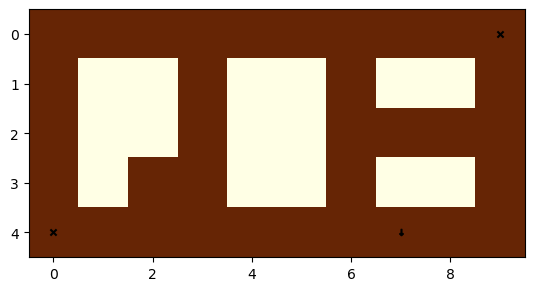

hello hello
--------------------------------------------------
Num timesteps: 1630000
Best mean reward: 4.92 - Last mean reward per episode: -104.66
current Design
[(4, 9)]


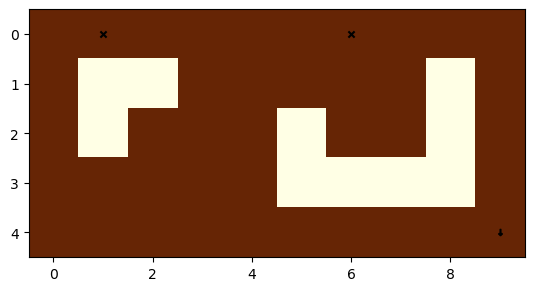

hello hello
--------------------------------------------------
Num timesteps: 1640000
Best mean reward: 4.92 - Last mean reward per episode: -52.09
current Design
[(2, 9)]


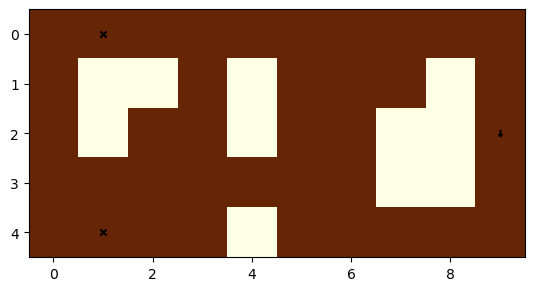

hello hello
--------------------------------------------------
Num timesteps: 1650000
Best mean reward: 4.92 - Last mean reward per episode: -62.10
current Design
[(0, 9)]


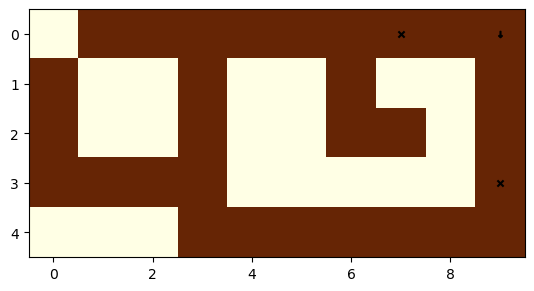

hello hello
--------------------------------------------------
Num timesteps: 1660000
Best mean reward: 4.92 - Last mean reward per episode: 2.27
current Design
[(0, 6)]


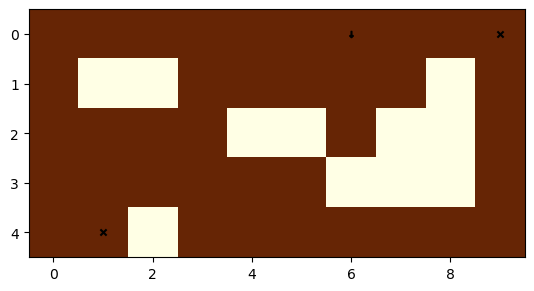

hello hello
--------------------------------------------------
Num timesteps: 1670000
Best mean reward: 4.92 - Last mean reward per episode: 0.02
current Design
[(4, 0)]


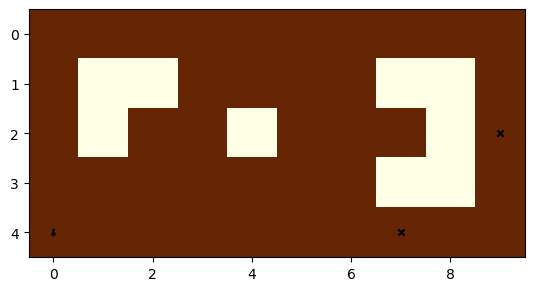

hello hello
--------------------------------------------------
Num timesteps: 1680000
Best mean reward: 4.92 - Last mean reward per episode: -13.89
current Design
[(0, 4)]


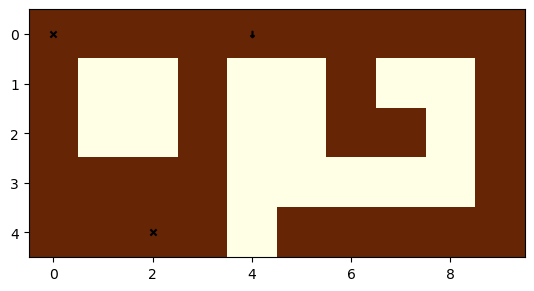

current Design
[(0, 5)]


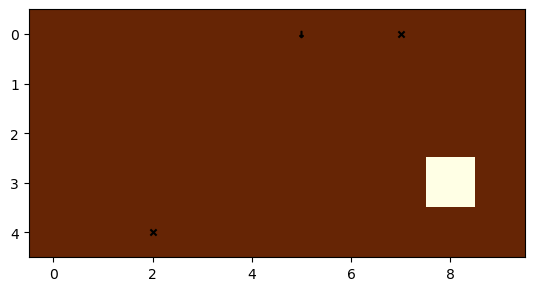

curr_reward 3.9103306991608817
accumulated_reward 0
current Design
[(0, 5)]


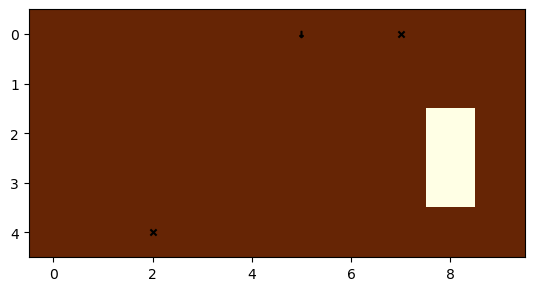

curr_reward 7.366931680983545
accumulated_reward 0
current Design
[(0, 5)]


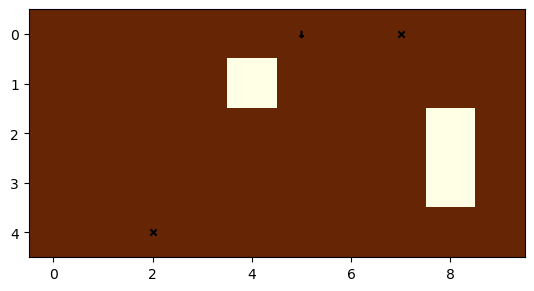

curr_reward 10.149226697495212
accumulated_reward 0
current Design
[(0, 5)]


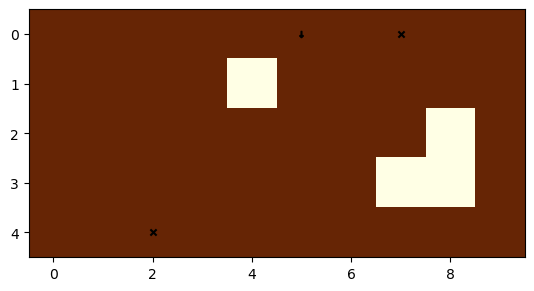

curr_reward 13.382387868078014
accumulated_reward 0
current Design
[(0, 5)]


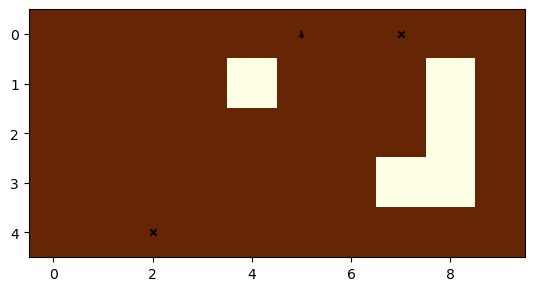

curr_reward 16.24650159249383
accumulated_reward 0
current Design
[(0, 5)]


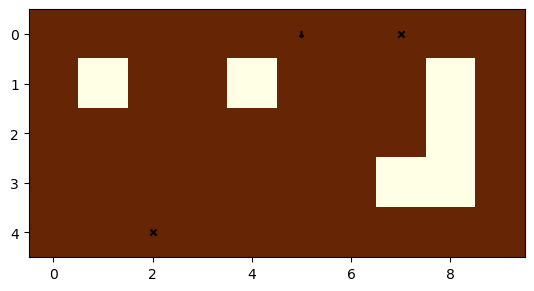

curr_reward 18.42340951701104
accumulated_reward 0
current Design
[(0, 5)]


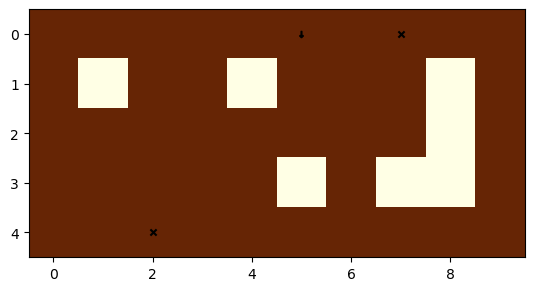

curr_reward 20.453914168037958
accumulated_reward 0
current Design
[(0, 5)]


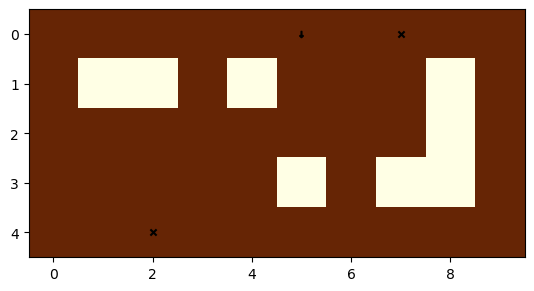

curr_reward 22.081617492165503
accumulated_reward 0
current Design
[(0, 5)]


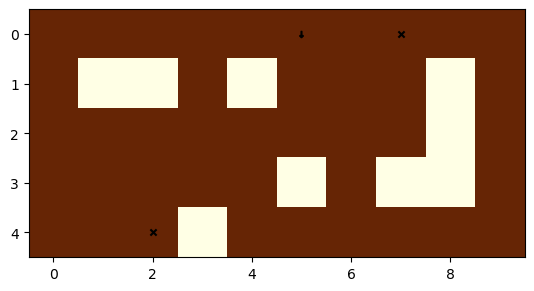

curr_reward 23.232077967936306
accumulated_reward 0
current Design
[(0, 5)]


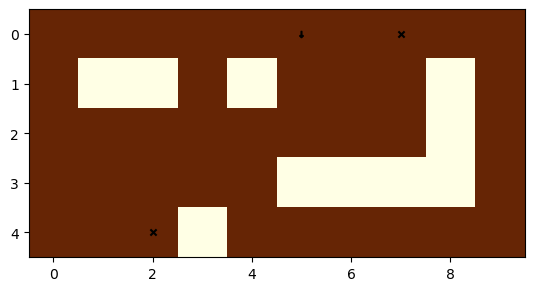

curr_reward 24.76471180102725
accumulated_reward 0
current Design
[(0, 5)]


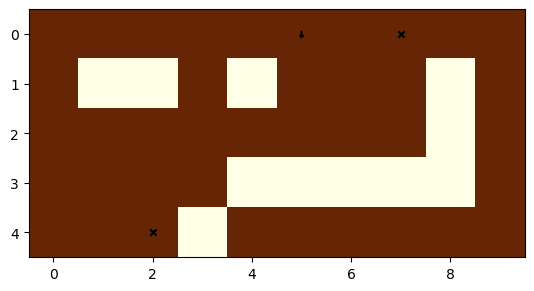

curr_reward 25.48222979968696
accumulated_reward 0
current Design
[(0, 5)]


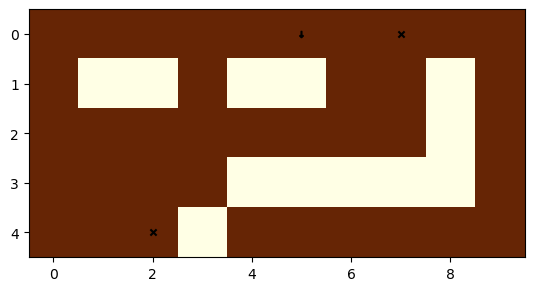

curr_reward 27.597190013300928
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1690000
Best mean reward: 4.92 - Last mean reward per episode: -36.32
current Design
[(3, 9)]


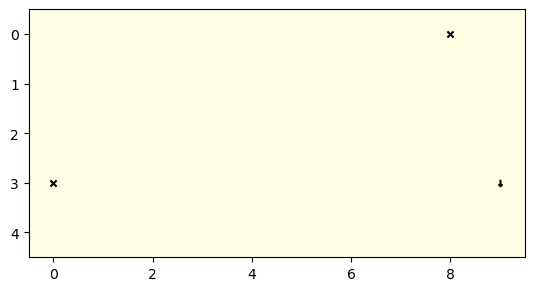

hello hello
--------------------------------------------------
Num timesteps: 1700000
Best mean reward: 4.92 - Last mean reward per episode: -99.88
current Design
[(0, 4)]


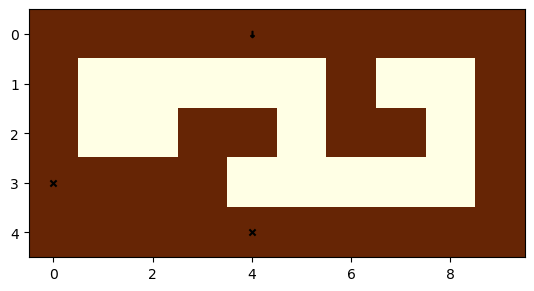

hello hello
--------------------------------------------------
Num timesteps: 1710000
Best mean reward: 4.92 - Last mean reward per episode: -89.49
current Design
[(0, 4)]


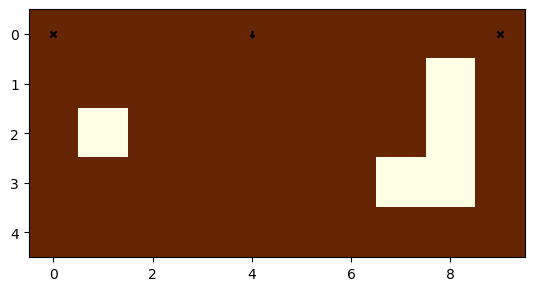

hello hello
--------------------------------------------------
Num timesteps: 1720000
Best mean reward: 4.92 - Last mean reward per episode: -25.73
current Design
[(0, 2)]


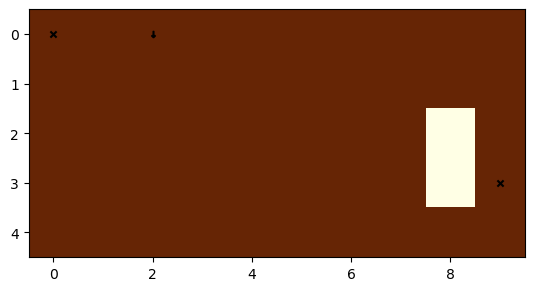

hello hello
--------------------------------------------------
Num timesteps: 1730000
Best mean reward: 4.92 - Last mean reward per episode: -84.52
current Design
[(0, 0)]


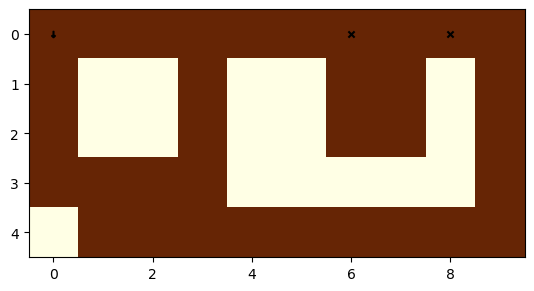

hello hello
--------------------------------------------------
Num timesteps: 1740000
Best mean reward: 4.92 - Last mean reward per episode: -48.24
current Design
[(4, 8)]


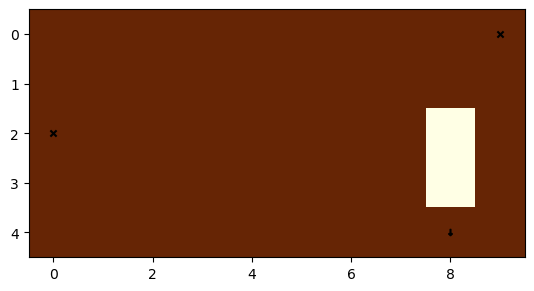

hello hello
--------------------------------------------------
Num timesteps: 1750000
Best mean reward: 4.92 - Last mean reward per episode: -92.22
current Design
[(0, 5)]


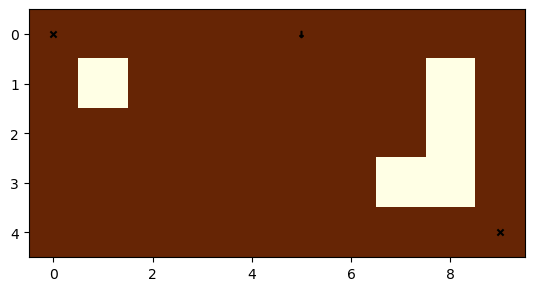

hello hello
--------------------------------------------------
Num timesteps: 1760000
Best mean reward: 4.92 - Last mean reward per episode: -8.75
current Design
[(4, 9)]


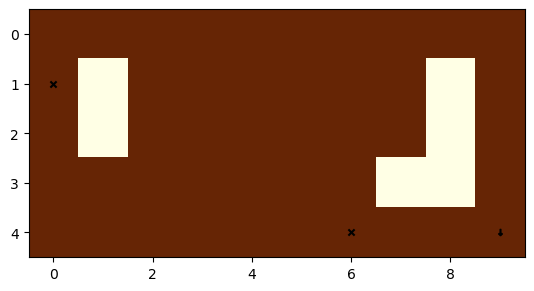

hello hello
--------------------------------------------------
Num timesteps: 1770000
Best mean reward: 4.92 - Last mean reward per episode: -82.79
current Design
[(4, 0)]


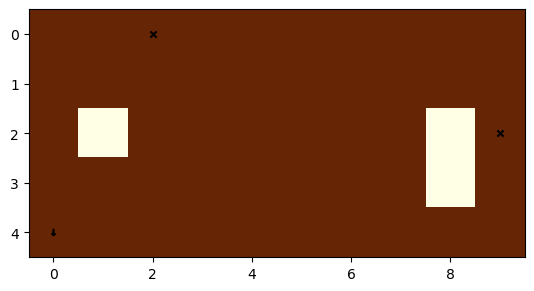

current Design
[(4, 2)]


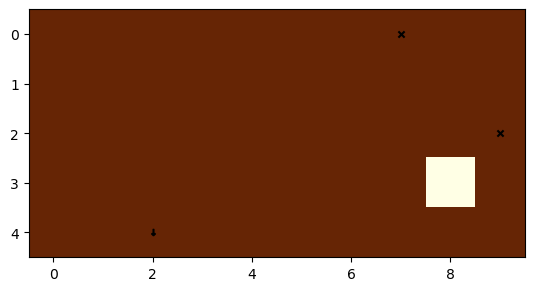

curr_reward 4.3327816093208344
accumulated_reward 0
current Design
[(4, 2)]


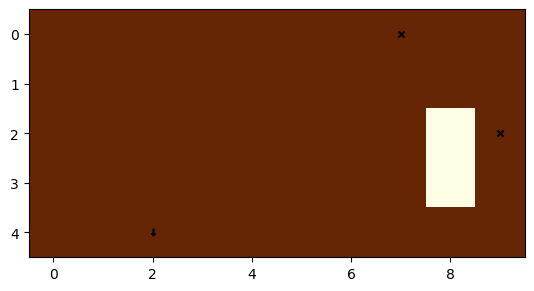

curr_reward 8.77357503542725
accumulated_reward 0
current Design
[(4, 2)]


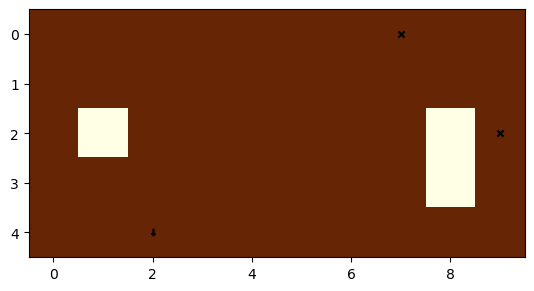

curr_reward 13.119333830795538
accumulated_reward 0
current Design
[(4, 2)]


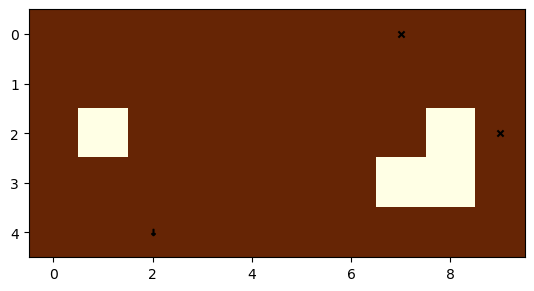

curr_reward 16.62034099657872
accumulated_reward 0
current Design
[(4, 2)]


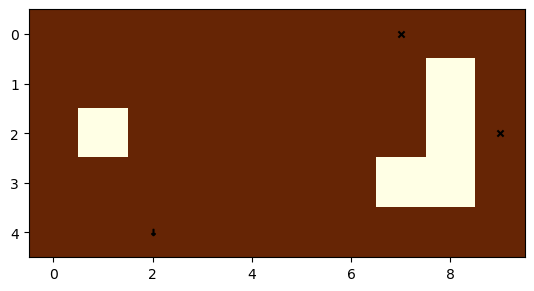

curr_reward 19.643342525579882
accumulated_reward 0
current Design
[(4, 2)]


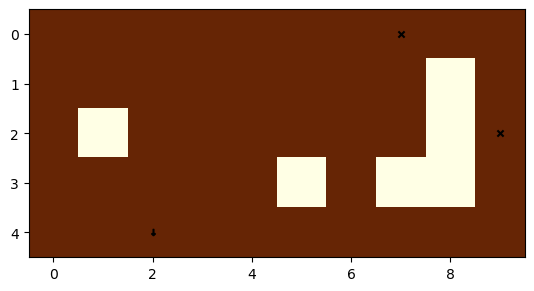

curr_reward 23.189731402438046
accumulated_reward 0
current Design
[(4, 2)]


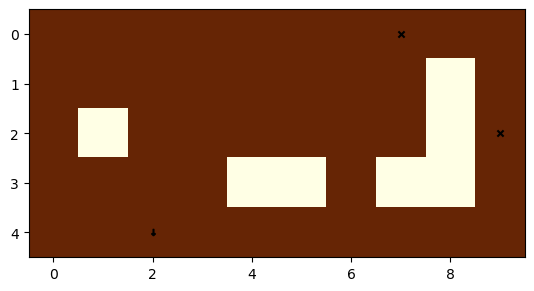

curr_reward 25.448437641580586
accumulated_reward 0
current Design
[(4, 2)]


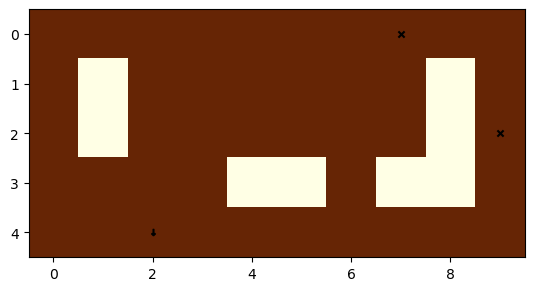

curr_reward 28.207136038056426
accumulated_reward 0
current Design
[(4, 2)]


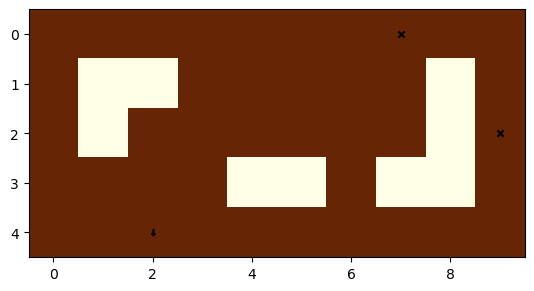

curr_reward 30.440410092369376
accumulated_reward 0
current Design
[(4, 2)]


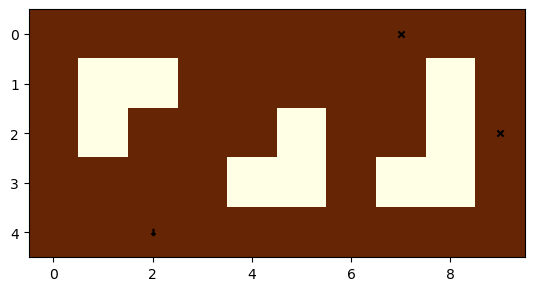

curr_reward 32.71171023830603
accumulated_reward 0
current Design
[(4, 2)]


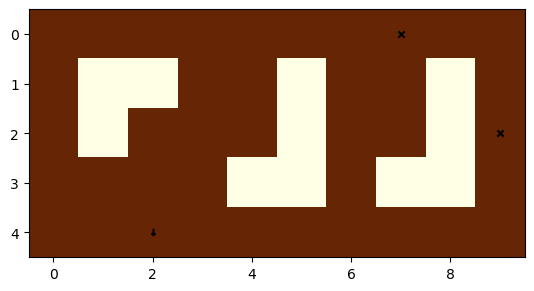

curr_reward 33.20288983534438
accumulated_reward 0
current Design
[(4, 2)]


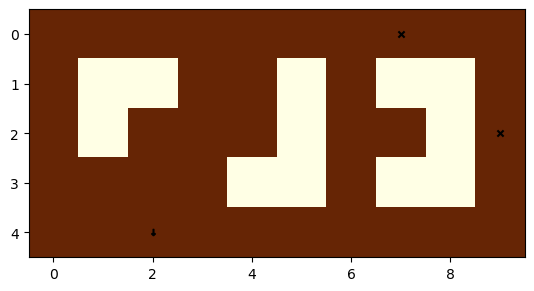

curr_reward 29.84947785114261
accumulated_reward 0
current Design
[(4, 2)]


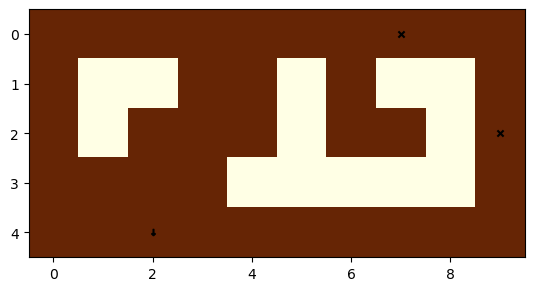

curr_reward 22.903172171292685
accumulated_reward 0
current Design
[(4, 2)]


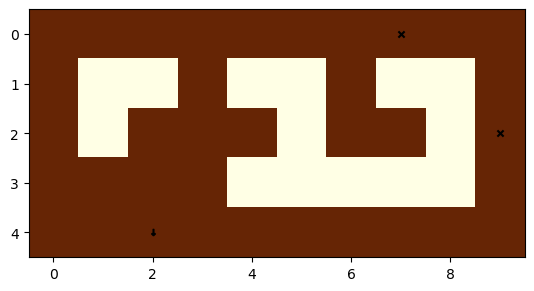

curr_reward 23.362895598004012
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1780000
Best mean reward: 4.92 - Last mean reward per episode: -49.15
current Design
[(1, 9)]


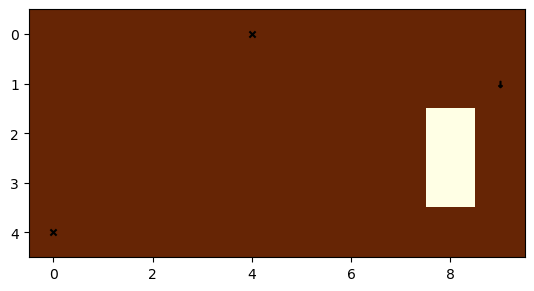

hello hello
--------------------------------------------------
Num timesteps: 1790000
Best mean reward: 4.92 - Last mean reward per episode: -30.27
current Design
[(2, 0)]


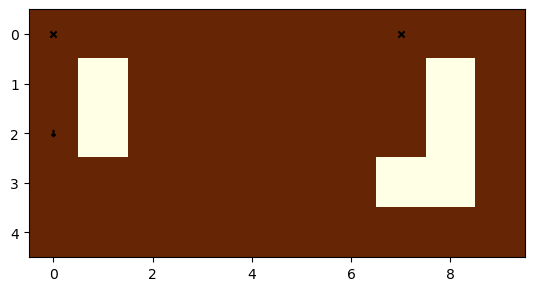

hello hello
--------------------------------------------------
Num timesteps: 1800000
Best mean reward: 4.92 - Last mean reward per episode: -2.42
current Design
[(4, 8)]


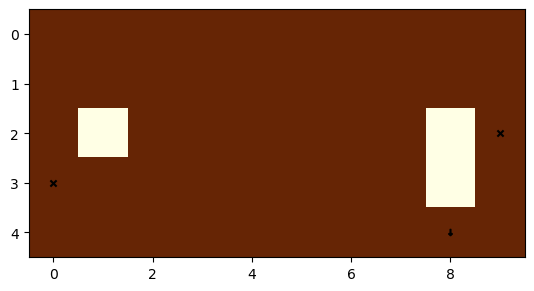

hello hello
--------------------------------------------------
Num timesteps: 1810000
Best mean reward: 4.92 - Last mean reward per episode: -31.98
current Design
[(3, 9)]


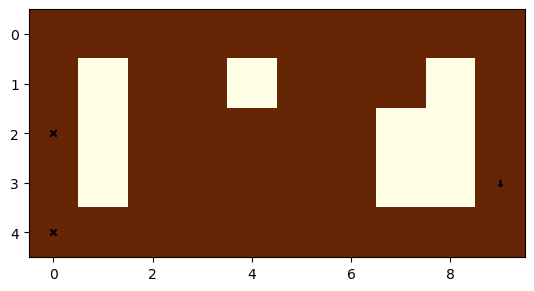

hello hello
--------------------------------------------------
Num timesteps: 1820000
Best mean reward: 4.92 - Last mean reward per episode: -19.50
current Design
[(1, 0)]


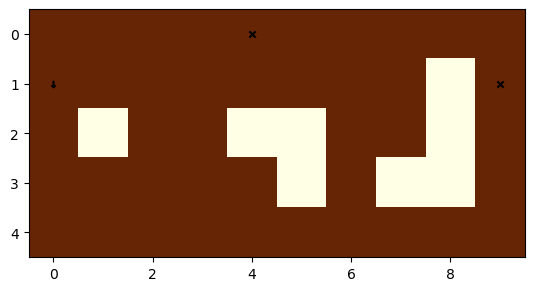

hello hello
--------------------------------------------------
Num timesteps: 1830000
Best mean reward: 4.92 - Last mean reward per episode: -45.52
current Design
[(0, 4)]


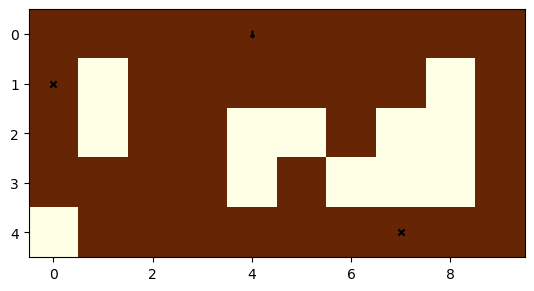

hello hello
--------------------------------------------------
Num timesteps: 1840000
Best mean reward: 4.92 - Last mean reward per episode: -111.04
current Design
[(3, 9)]


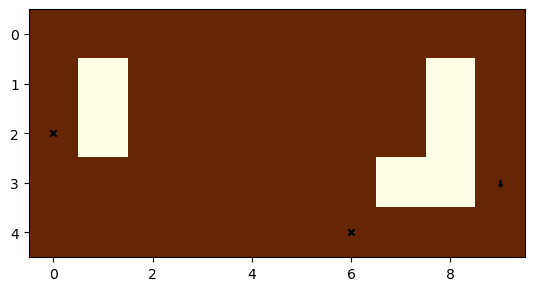

hello hello
--------------------------------------------------
Num timesteps: 1850000
Best mean reward: 4.92 - Last mean reward per episode: -37.51
current Design
[(4, 0)]


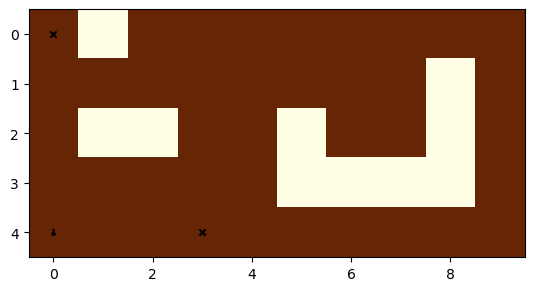

hello hello
--------------------------------------------------
Num timesteps: 1860000
Best mean reward: 4.92 - Last mean reward per episode: -24.29
current Design
[(2, 0)]


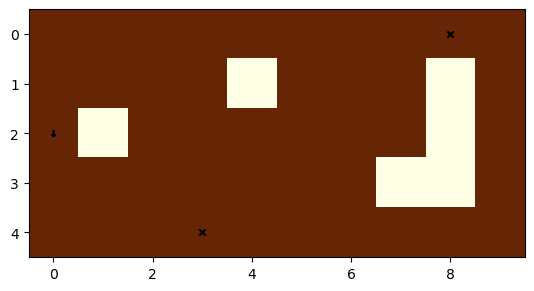

current Design
[(4, 1)]


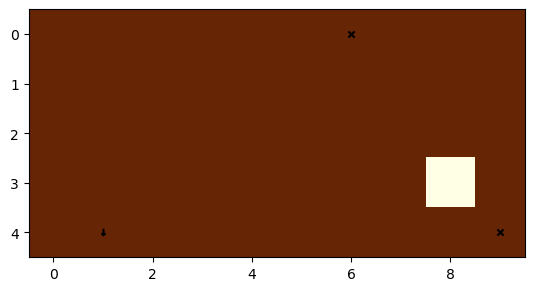

curr_reward 4.1044730453845135
accumulated_reward 0
current Design
[(4, 1)]


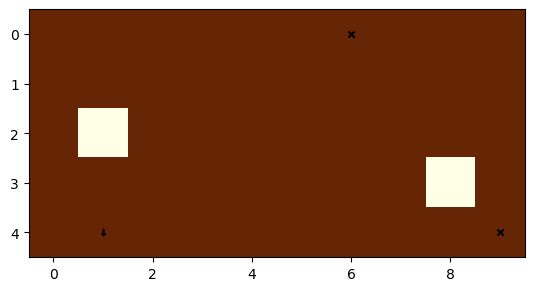

curr_reward 7.968687282772159
accumulated_reward 0
current Design
[(4, 1)]


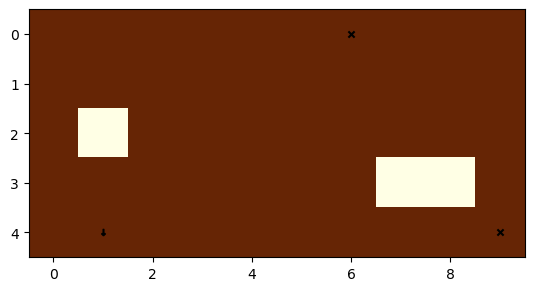

curr_reward 11.820562513526358
accumulated_reward 0
current Design
[(4, 1)]


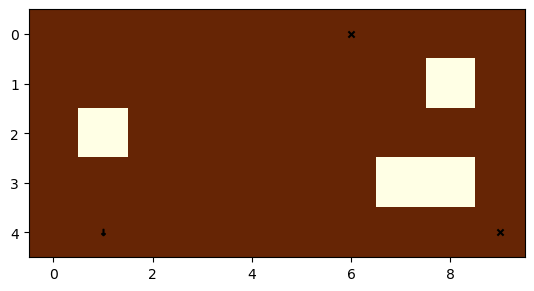

curr_reward 14.950491202640015
accumulated_reward 0
current Design
[(4, 1)]


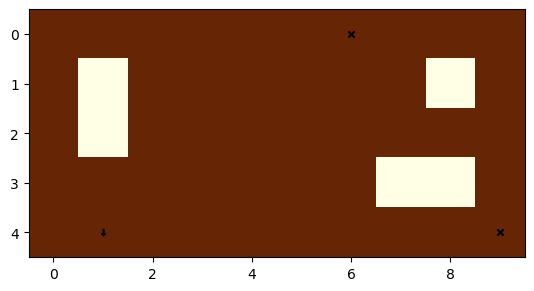

curr_reward 17.834830607498432
accumulated_reward 0
current Design
[(4, 1)]


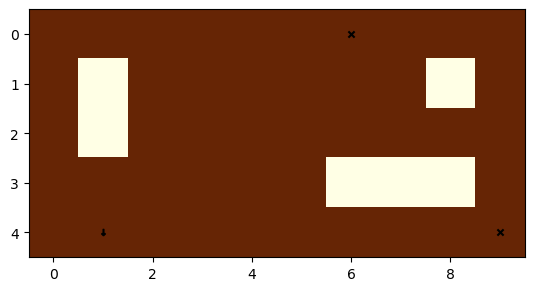

curr_reward 19.960568273304634
accumulated_reward 0
current Design
[(4, 1)]


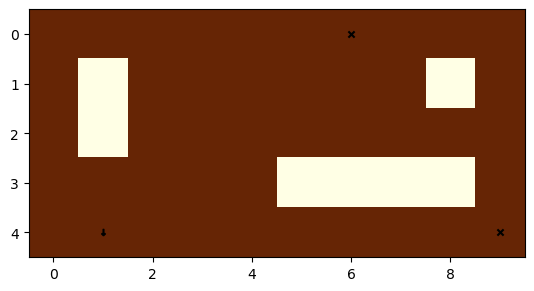

curr_reward 21.573606106222833
accumulated_reward 0
current Design
[(4, 1)]


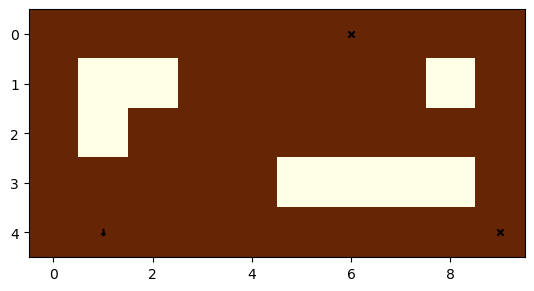

curr_reward 23.29482922435972
accumulated_reward 0
current Design
[(4, 1)]


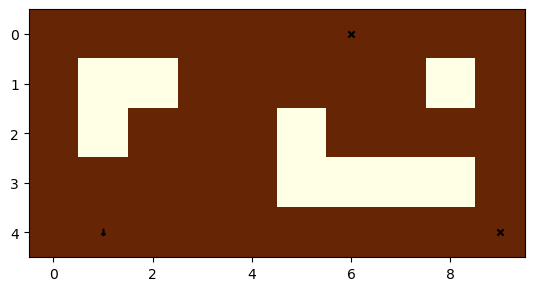

curr_reward 21.65650326684441
accumulated_reward 0
current Design
[(4, 1)]


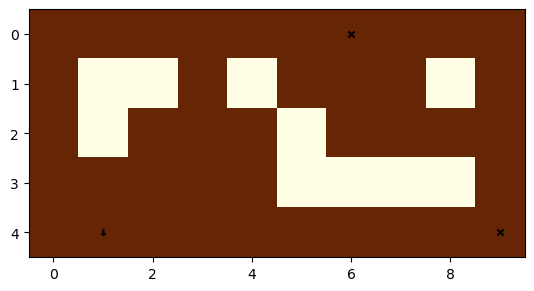

curr_reward 22.092597921027398
accumulated_reward 0
current Design
[(4, 1)]


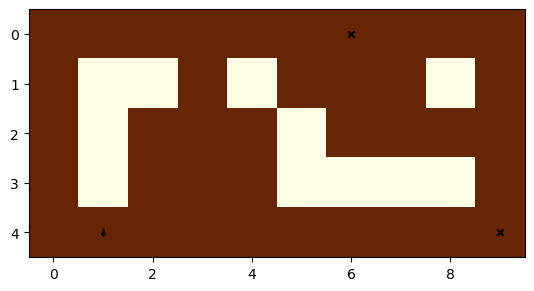

curr_reward 24.319359345205264
accumulated_reward 0
current Design
[(4, 1)]


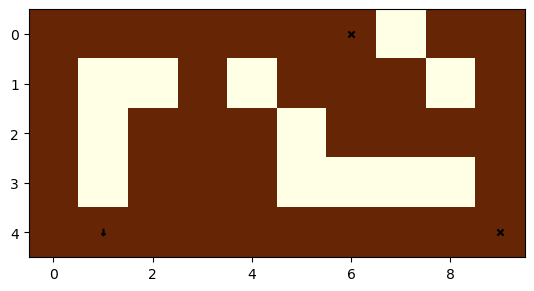

curr_reward 25.14191352421567
accumulated_reward 0
current Design
[(4, 1)]


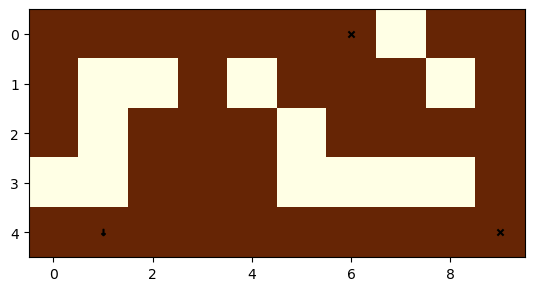

curr_reward 26.1964881276724
accumulated_reward 0
current Design
[(4, 1)]


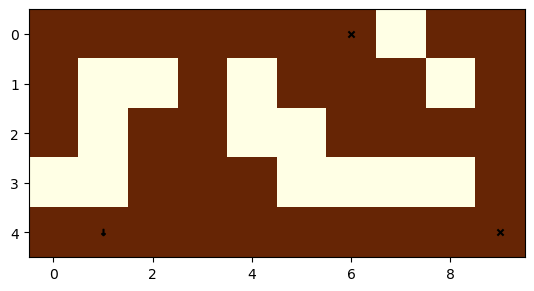

curr_reward 20.2599589237634
accumulated_reward 0
current Design
[(4, 1)]


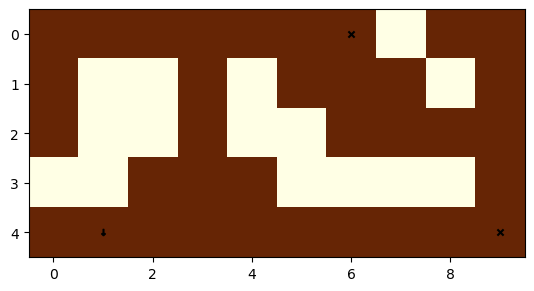

curr_reward 20.18136983237377
accumulated_reward 0
current Design
[(4, 1)]


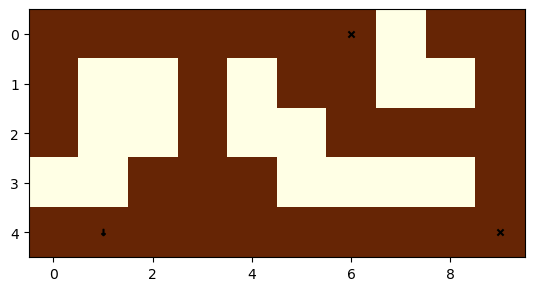

curr_reward 19.99119690932256
accumulated_reward 0
current Design
[(4, 1)]


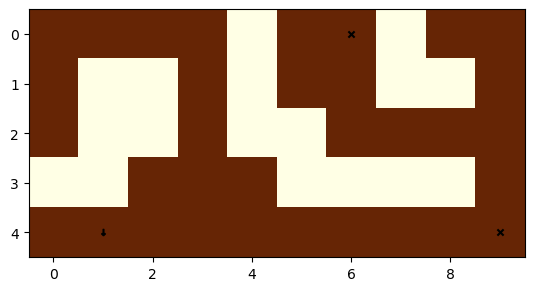

curr_reward 10.895775874740036
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1870000
Best mean reward: 4.92 - Last mean reward per episode: -5.12
current Design
[(3, 0)]


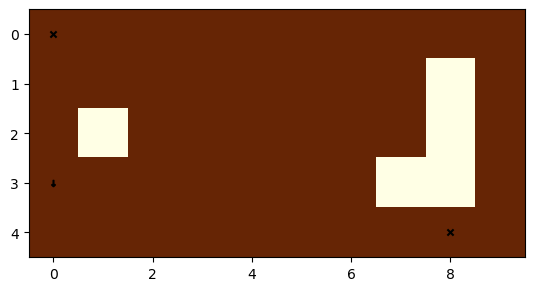

hello hello
--------------------------------------------------
Num timesteps: 1880000
Best mean reward: 4.92 - Last mean reward per episode: 36.76
current Design
[(0, 6)]


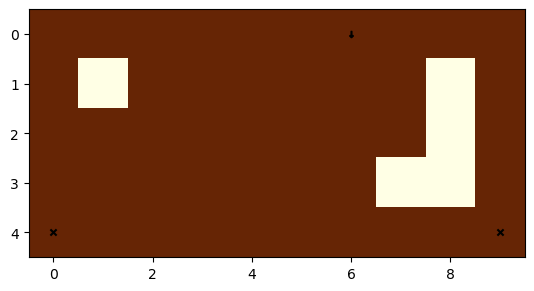

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 1890000
Best mean reward: 36.76 - Last mean reward per episode: -12.96
current Design
[(1, 0)]


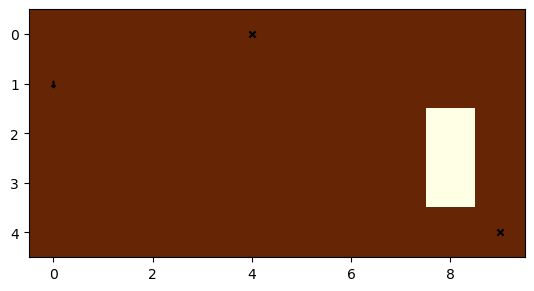

hello hello
--------------------------------------------------
Num timesteps: 1900000
Best mean reward: 36.76 - Last mean reward per episode: -27.64
current Design
[(4, 9)]


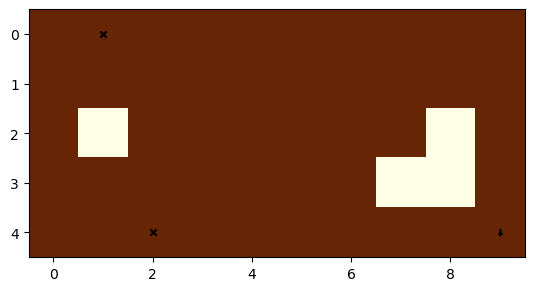

hello hello
--------------------------------------------------
Num timesteps: 1910000
Best mean reward: 36.76 - Last mean reward per episode: -41.58
current Design
[(4, 0)]


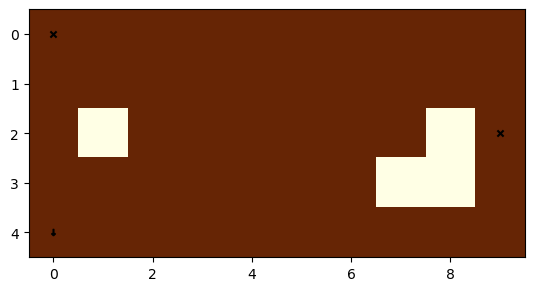

hello hello
--------------------------------------------------
Num timesteps: 1920000
Best mean reward: 36.76 - Last mean reward per episode: -52.77
current Design
[(4, 4)]


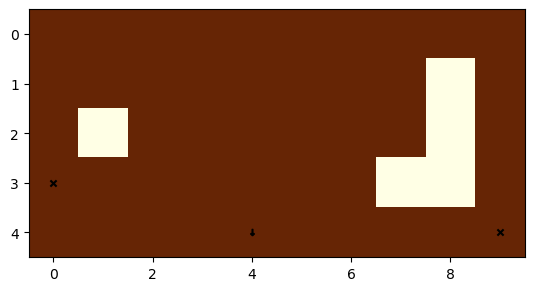

hello hello
--------------------------------------------------
Num timesteps: 1930000
Best mean reward: 36.76 - Last mean reward per episode: -21.52
current Design
[(3, 9)]


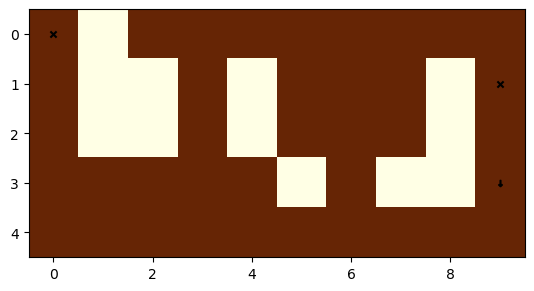

hello hello
--------------------------------------------------
Num timesteps: 1940000
Best mean reward: 36.76 - Last mean reward per episode: -50.68
current Design
[(4, 3)]


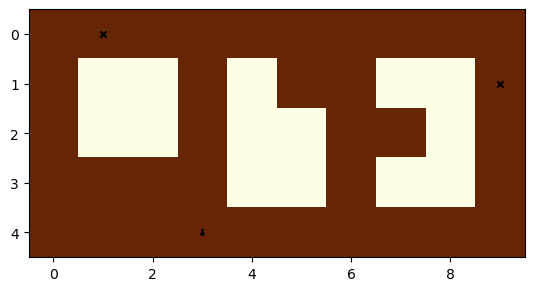

hello hello
--------------------------------------------------
Num timesteps: 1950000
Best mean reward: 36.76 - Last mean reward per episode: -27.38
current Design
[(2, 9)]


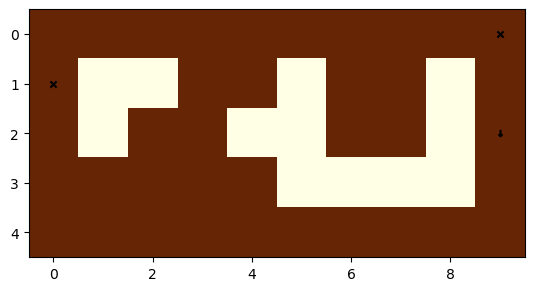

current Design
[(3, 0)]


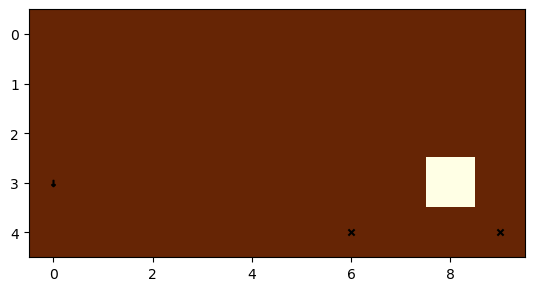

curr_reward 3.8797284271636214
accumulated_reward 0
current Design
[(3, 0)]


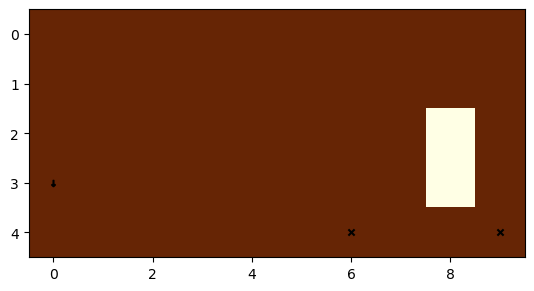

curr_reward 7.51635171179652
accumulated_reward 0
current Design
[(3, 0)]


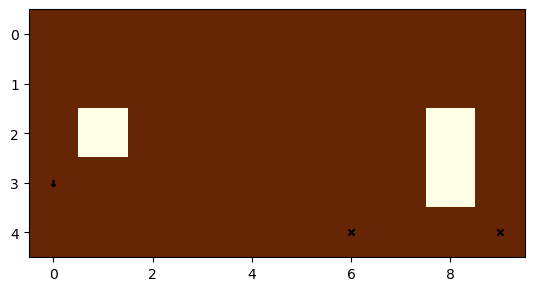

curr_reward 10.78645356826527
accumulated_reward 0
current Design
[(3, 0)]


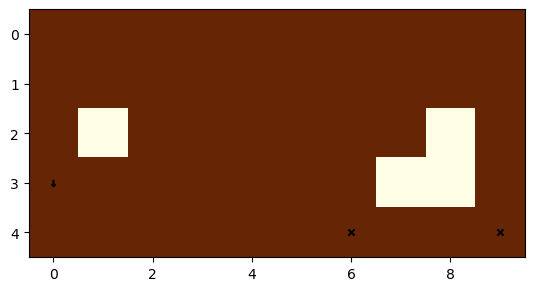

curr_reward 14.09351963207461
accumulated_reward 0
current Design
[(3, 0)]


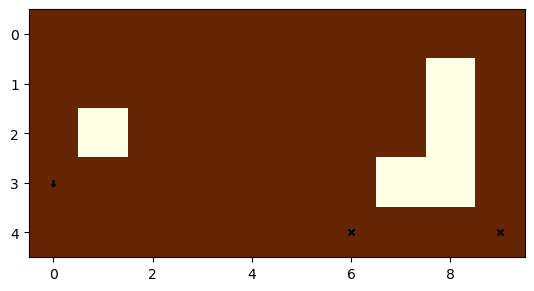

curr_reward 17.01723684690676
accumulated_reward 0
current Design
[(3, 0)]


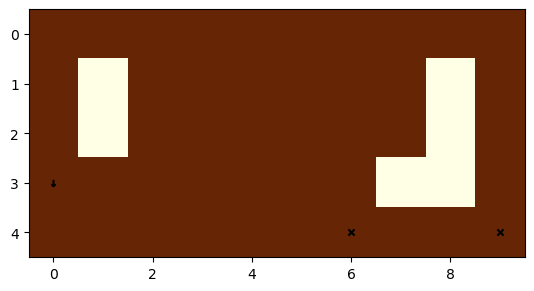

curr_reward 19.401128765971034
accumulated_reward 0
current Design
[(3, 0)]


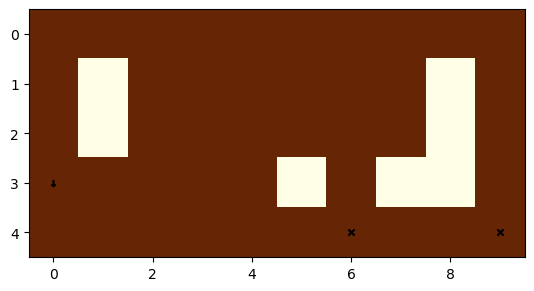

curr_reward 20.688327202472838
accumulated_reward 0
current Design
[(3, 0)]


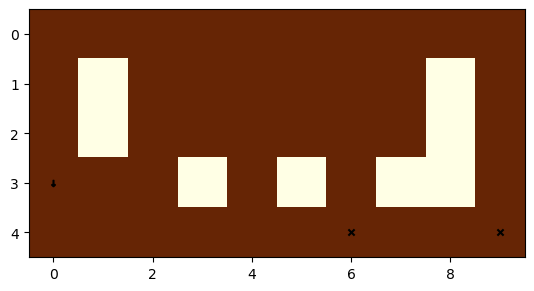

curr_reward 22.595591162855573
accumulated_reward 0
current Design
[(3, 0)]


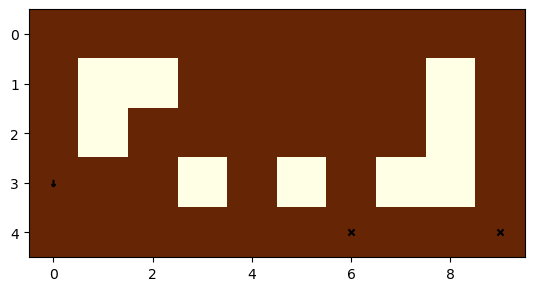

curr_reward 24.11368457980608
accumulated_reward 0
current Design
[(3, 0)]


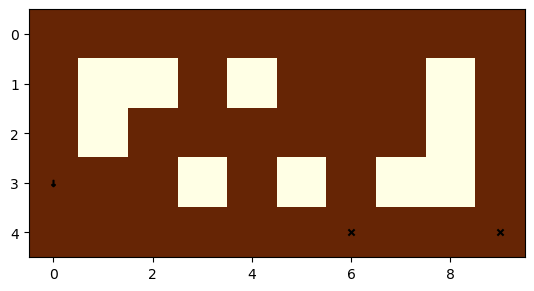

curr_reward 25.44960409864772
accumulated_reward 0
current Design
[(3, 0)]


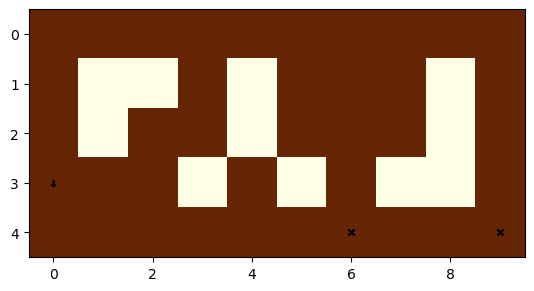

curr_reward 26.650330370752606
accumulated_reward 0
current Design
[(3, 0)]


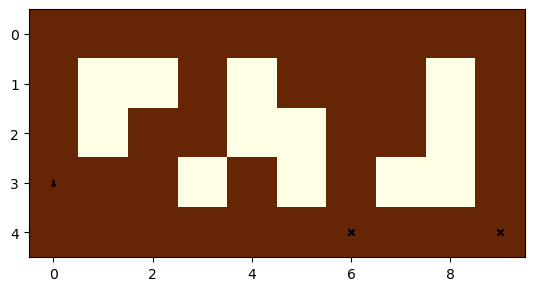

curr_reward 27.23571873362972
accumulated_reward 0
current Design
[(3, 0)]


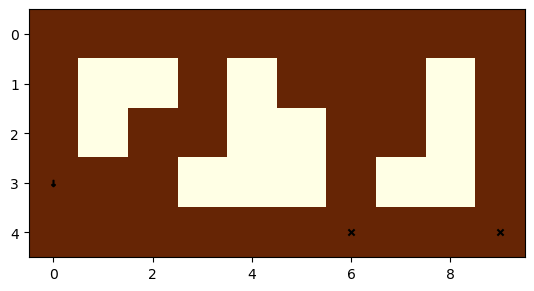

curr_reward 25.860434562743883
accumulated_reward 0
current Design
[(3, 0)]


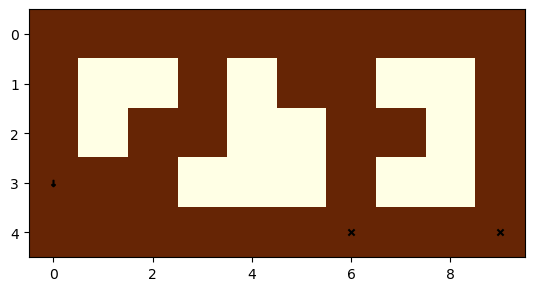

curr_reward 26.611791801694846
accumulated_reward 0
current Design
[(3, 0)]


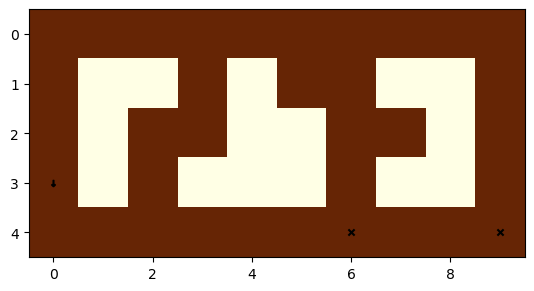

curr_reward 27.33319015025351
accumulated_reward 0
current Design
[(3, 0)]


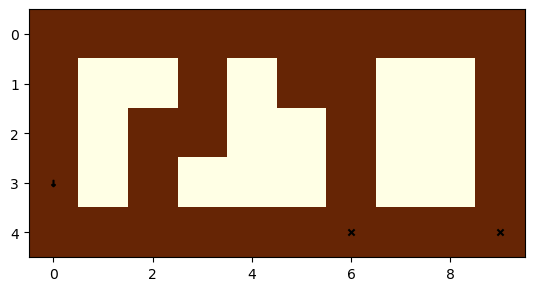

curr_reward 27.764556190162022
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 1960000
Best mean reward: 36.76 - Last mean reward per episode: -28.64
current Design
[(4, 5)]


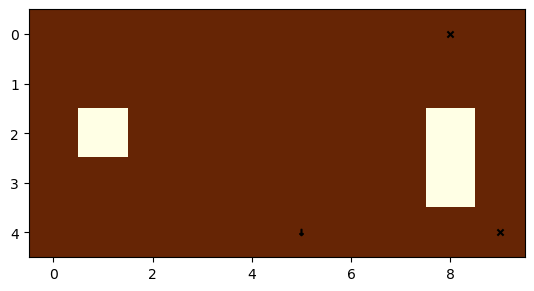

hello hello
--------------------------------------------------
Num timesteps: 1970000
Best mean reward: 36.76 - Last mean reward per episode: -19.38
current Design
[(1, 0)]


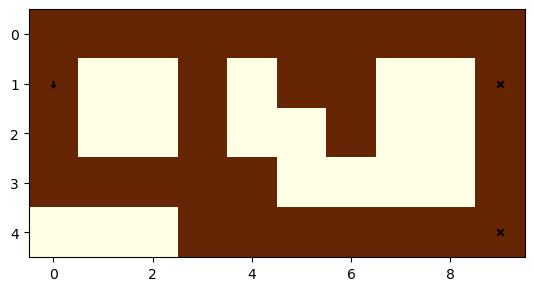

hello hello
--------------------------------------------------
Num timesteps: 1980000
Best mean reward: 36.76 - Last mean reward per episode: -51.60
current Design
[(3, 9)]


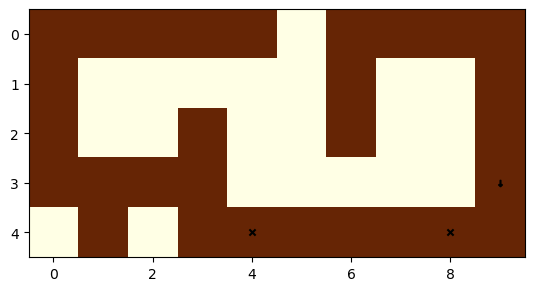

hello hello
--------------------------------------------------
Num timesteps: 1990000
Best mean reward: 36.76 - Last mean reward per episode: -7.77
current Design
[(4, 3)]


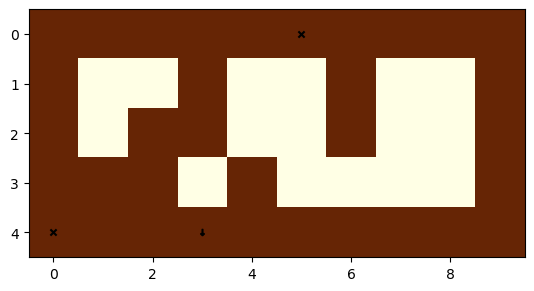

hello hello
--------------------------------------------------
Num timesteps: 2000000
Best mean reward: 36.76 - Last mean reward per episode: -42.31
current Design
[(0, 6)]


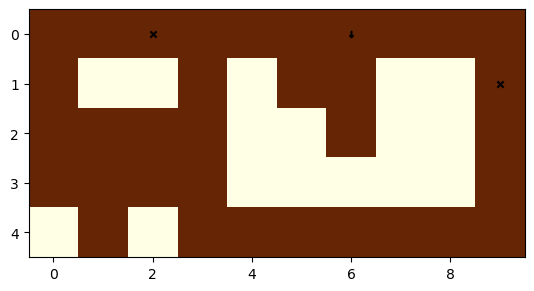

hello hello
--------------------------------------------------
Num timesteps: 2010000
Best mean reward: 36.76 - Last mean reward per episode: -41.71
current Design
[(3, 9)]


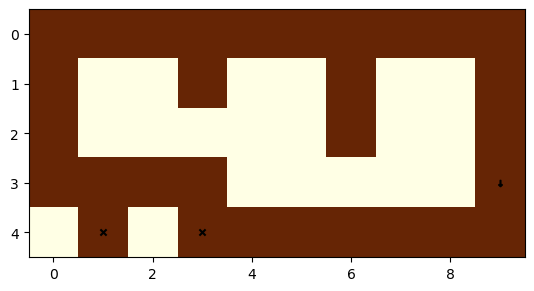

hello hello
--------------------------------------------------
Num timesteps: 2020000
Best mean reward: 36.76 - Last mean reward per episode: 62.07
current Design
[(0, 3)]


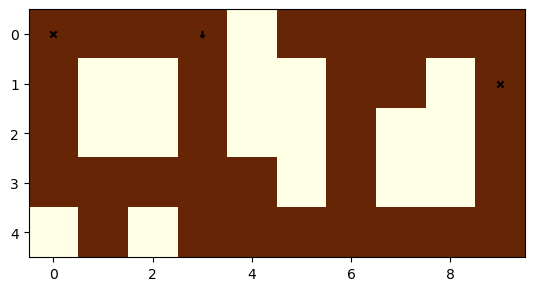

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 2030000
Best mean reward: 62.07 - Last mean reward per episode: -68.02
current Design
[(0, 3)]


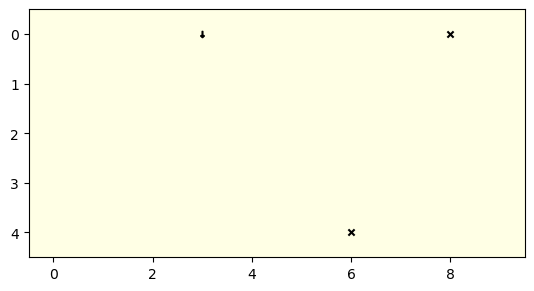

hello hello
--------------------------------------------------
Num timesteps: 2040000
Best mean reward: 62.07 - Last mean reward per episode: -15.19
current Design
[(4, 8)]


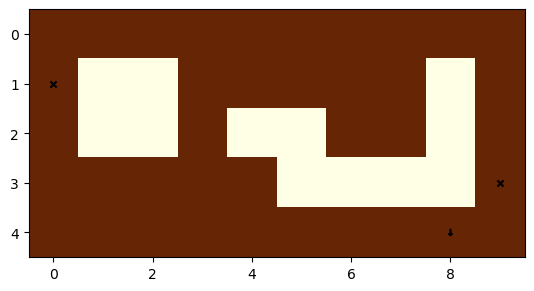

current Design
[(4, 3)]


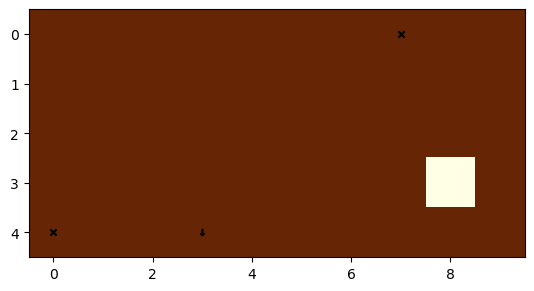

curr_reward 3.834392160876737
accumulated_reward 0
current Design
[(4, 3)]


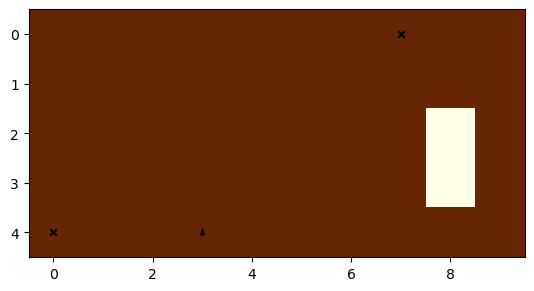

curr_reward 7.460948527986422
accumulated_reward 0
current Design
[(4, 3)]


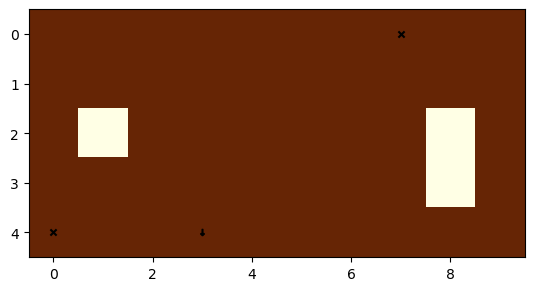

curr_reward 10.454803854539728
accumulated_reward 0
current Design
[(4, 3)]


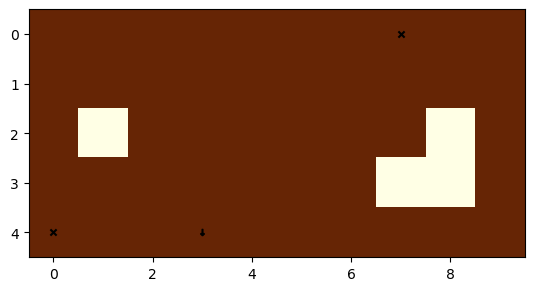

curr_reward 13.135995902828249
accumulated_reward 0
current Design
[(4, 3)]


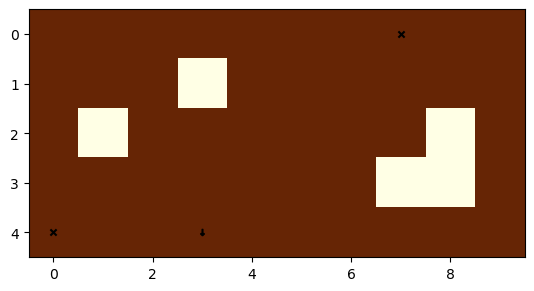

curr_reward 15.475728850420627
accumulated_reward 0
current Design
[(4, 3)]


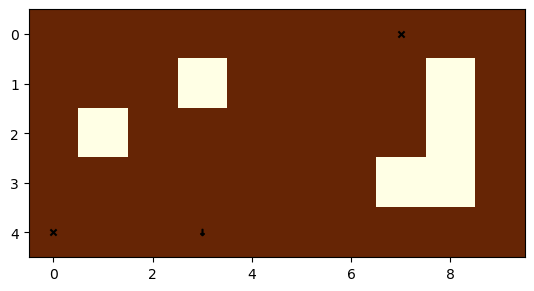

curr_reward 17.233209294824633
accumulated_reward 0
current Design
[(4, 3)]


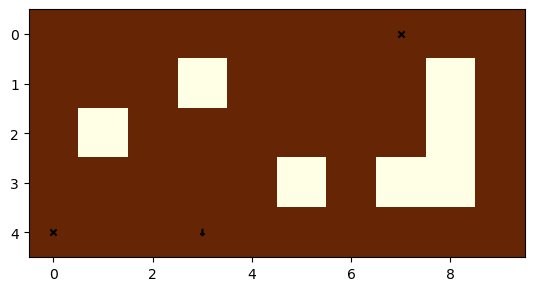

curr_reward 18.822170234298593
accumulated_reward 0
current Design
[(4, 3)]


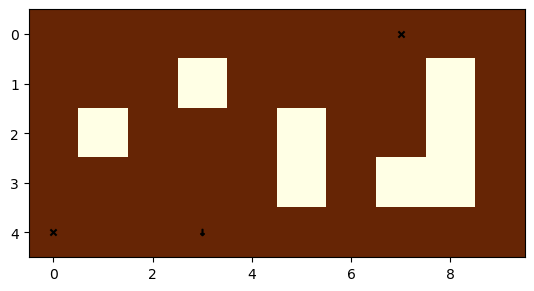

curr_reward 19.818218252922428
accumulated_reward 0
current Design
[(4, 3)]


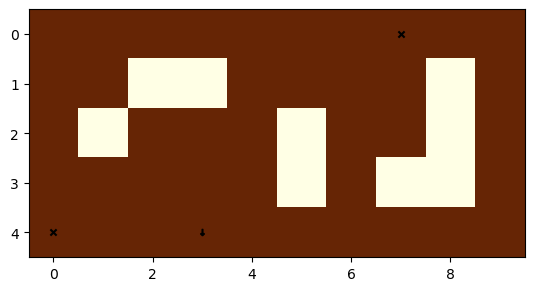

curr_reward 21.204757202707285
accumulated_reward 0
current Design
[(4, 3)]


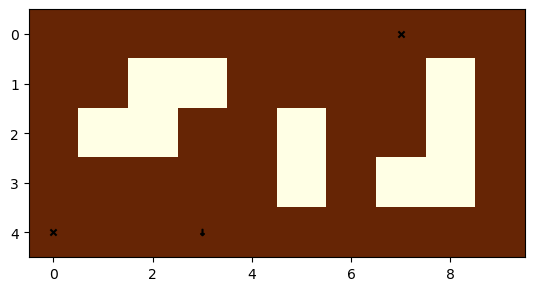

curr_reward 20.858452131537152
accumulated_reward 0
current Design
[(4, 3)]


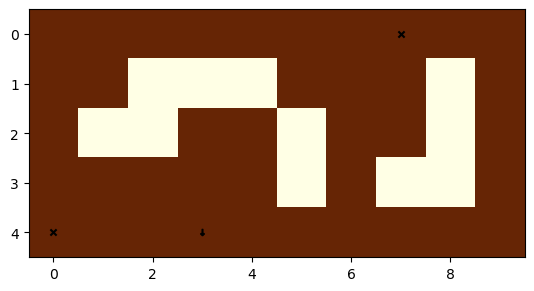

curr_reward 20.231752637882074
accumulated_reward 0
current Design
[(4, 3)]


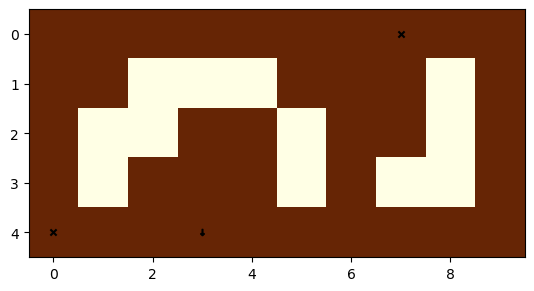

curr_reward 23.49733149570111
accumulated_reward 0
current Design
[(4, 3)]


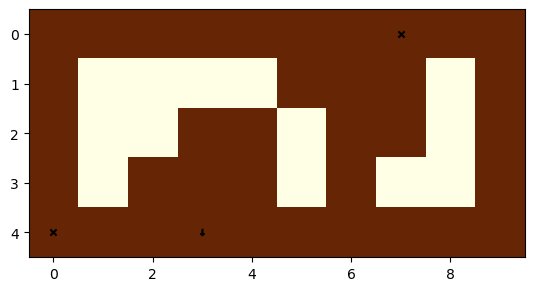

curr_reward 24.25984017037465
accumulated_reward 0
current Design
[(4, 3)]


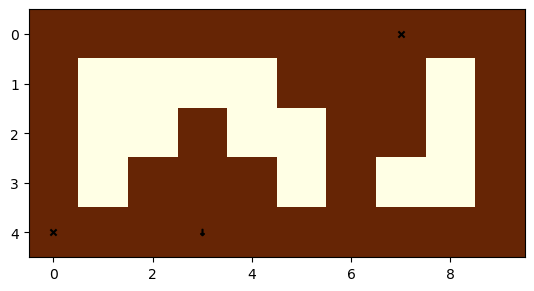

curr_reward 21.7297255968843
accumulated_reward 0
current Design
[(4, 3)]


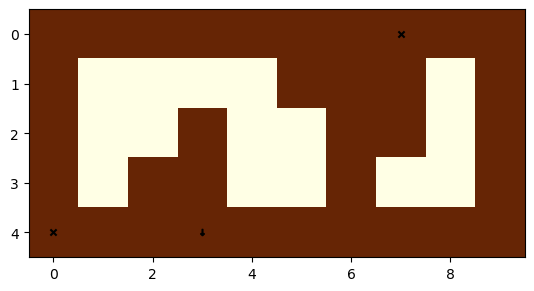

curr_reward 22.617964388609746
accumulated_reward 0
current Design
[(4, 3)]


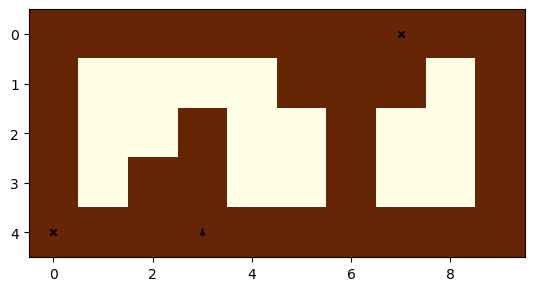

curr_reward 22.75391121229181
accumulated_reward 0
current Design
[(4, 3)]


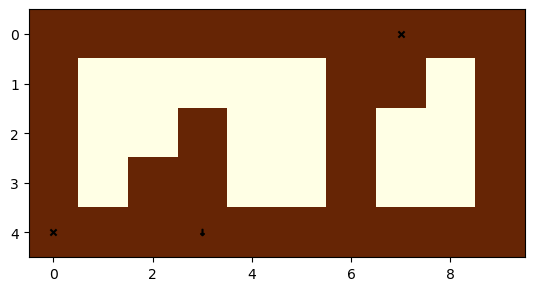

curr_reward 22.026747613736042
accumulated_reward 0
current Design
[(4, 3)]


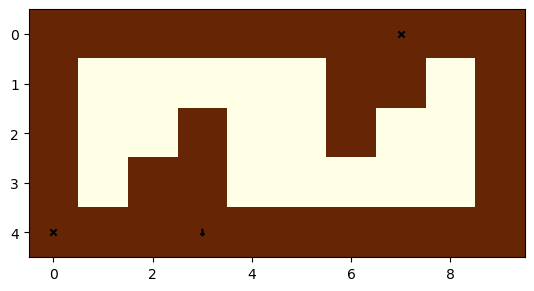

curr_reward 20.92681022167937
accumulated_reward 0
current Design
[(4, 3)]


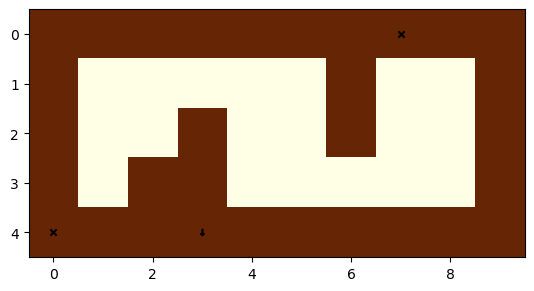

curr_reward 20.73039430542545
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2050000
Best mean reward: 62.07 - Last mean reward per episode: -2.10
current Design
[(0, 4)]


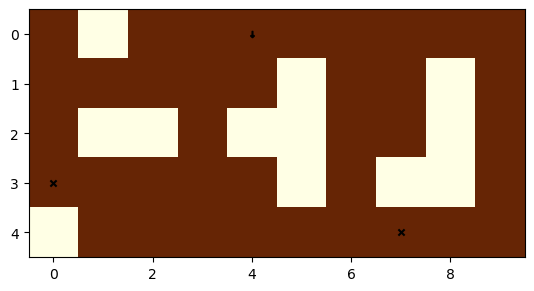

hello hello
--------------------------------------------------
Num timesteps: 2060000
Best mean reward: 62.07 - Last mean reward per episode: 29.90
current Design
[(4, 4)]


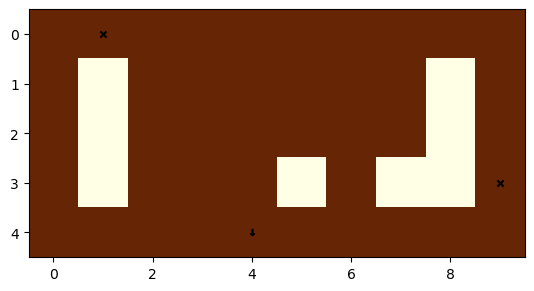

hello hello
--------------------------------------------------
Num timesteps: 2070000
Best mean reward: 62.07 - Last mean reward per episode: 6.37
current Design
[(0, 5)]


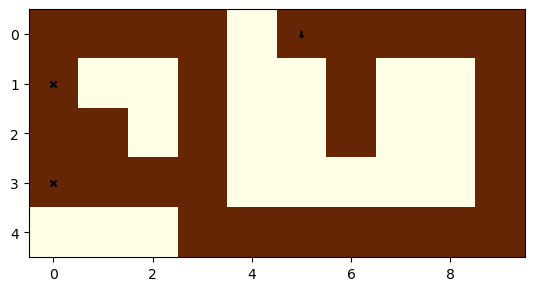

hello hello
--------------------------------------------------
Num timesteps: 2080000
Best mean reward: 62.07 - Last mean reward per episode: -61.73
current Design
[(1, 9)]


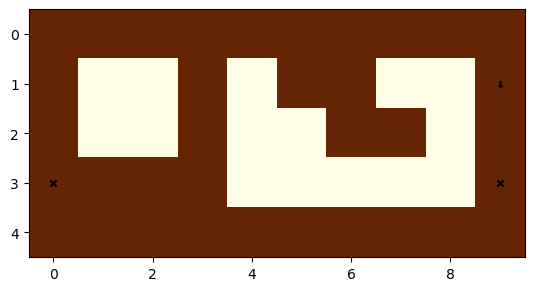

hello hello
--------------------------------------------------
Num timesteps: 2090000
Best mean reward: 62.07 - Last mean reward per episode: -62.72
current Design
[(0, 0)]


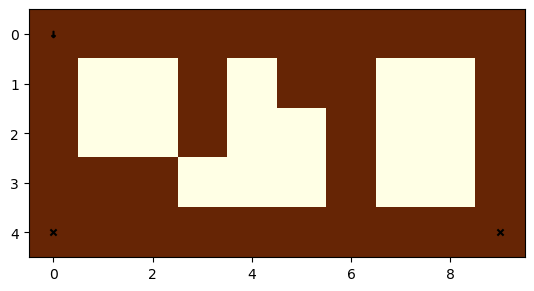

hello hello
--------------------------------------------------
Num timesteps: 2100000
Best mean reward: 62.07 - Last mean reward per episode: -33.24
current Design
[(1, 9)]


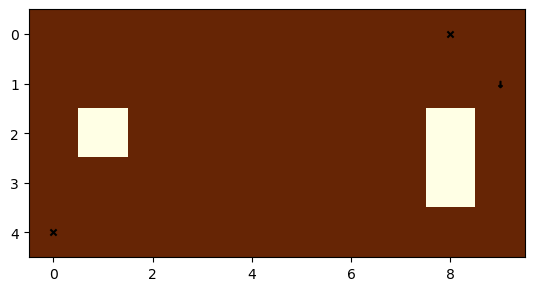

hello hello
--------------------------------------------------
Num timesteps: 2110000
Best mean reward: 62.07 - Last mean reward per episode: 39.58
current Design
[(0, 8)]


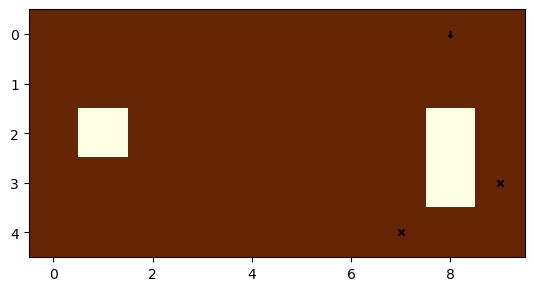

hello hello
--------------------------------------------------
Num timesteps: 2120000
Best mean reward: 62.07 - Last mean reward per episode: -17.63
current Design
[(3, 9)]


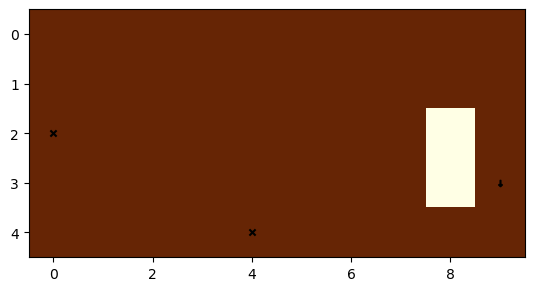

hello hello
--------------------------------------------------
Num timesteps: 2130000
Best mean reward: 62.07 - Last mean reward per episode: 1.35
current Design
[(4, 5)]


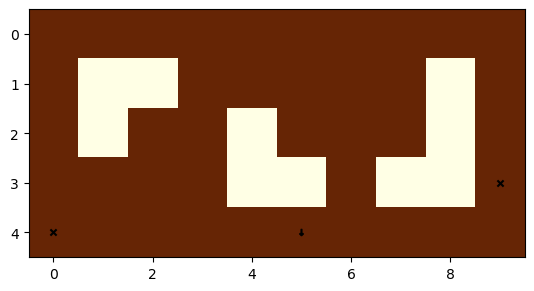

hello hello
--------------------------------------------------
Num timesteps: 2140000
Best mean reward: 62.07 - Last mean reward per episode: 14.11
current Design
[(1, 0)]


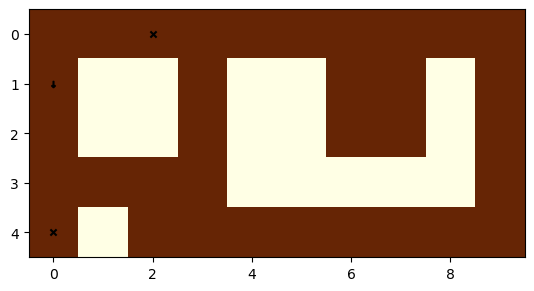

current Design
[(4, 2)]


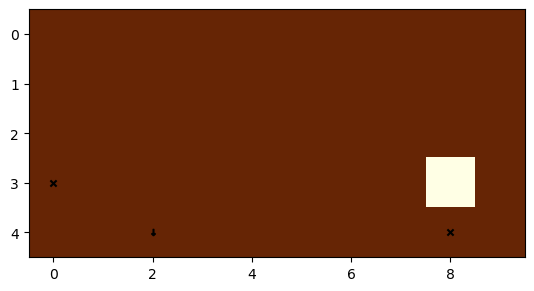

curr_reward 3.6682424922349948
accumulated_reward 0
current Design
[(4, 2)]


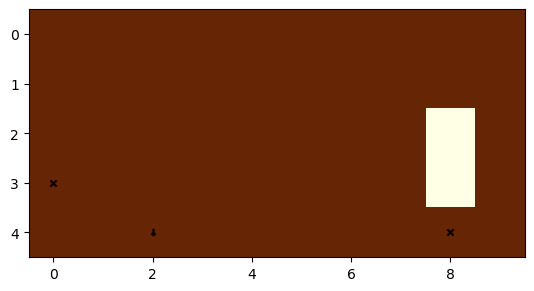

curr_reward 6.918741750744571
accumulated_reward 0
current Design
[(4, 2)]


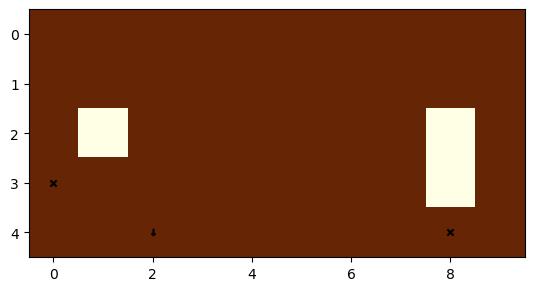

curr_reward 10.312186358707956
accumulated_reward 0
current Design
[(4, 2)]


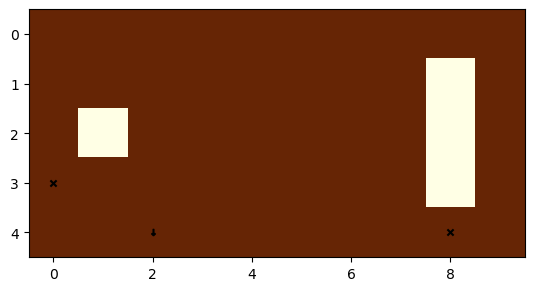

curr_reward 13.01807449321645
accumulated_reward 0
current Design
[(4, 2)]


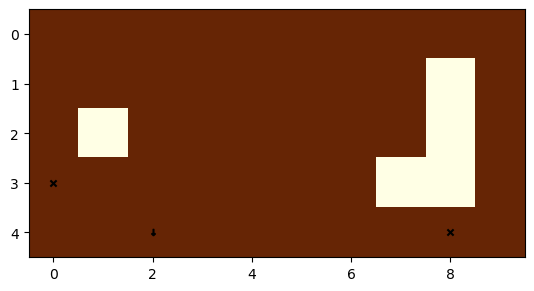

curr_reward 14.169919619273148
accumulated_reward 0
current Design
[(4, 2)]


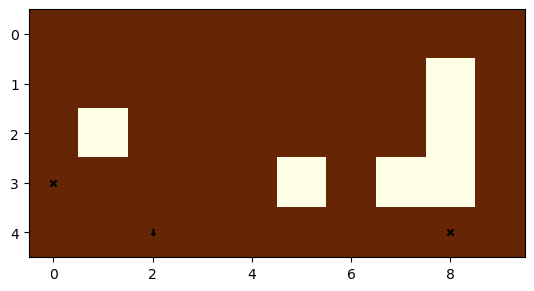

curr_reward 15.70930879969365
accumulated_reward 0
current Design
[(4, 2)]


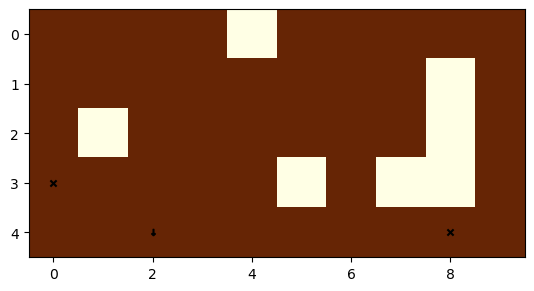

curr_reward 17.110795146208154
accumulated_reward 0
current Design
[(4, 2)]


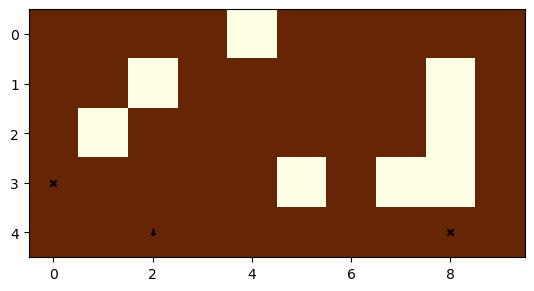

curr_reward 18.842155574522096
accumulated_reward 0
current Design
[(4, 2)]


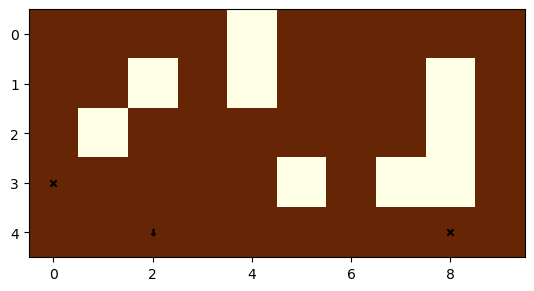

curr_reward 19.23798775673647
accumulated_reward 0
current Design
[(4, 2)]


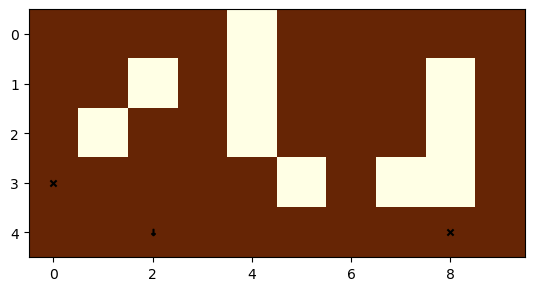

curr_reward 18.753313363681475
accumulated_reward 0
current Design
[(4, 2)]


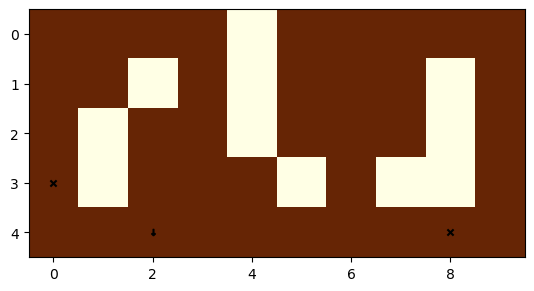

curr_reward 37.661397361071984
accumulated_reward 0
current Design
[(4, 2)]


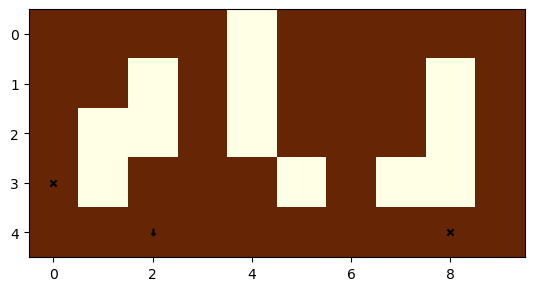

curr_reward 51.44673506869109
accumulated_reward 0
current Design
[(4, 2)]


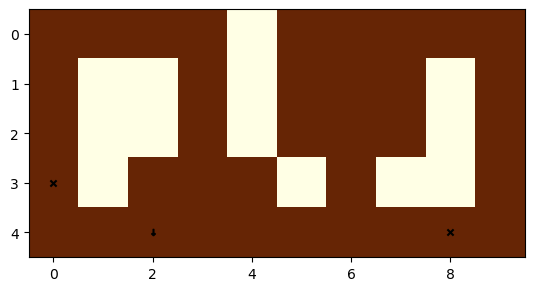

curr_reward 57.134970342732196
accumulated_reward 0
current Design
[(4, 2)]


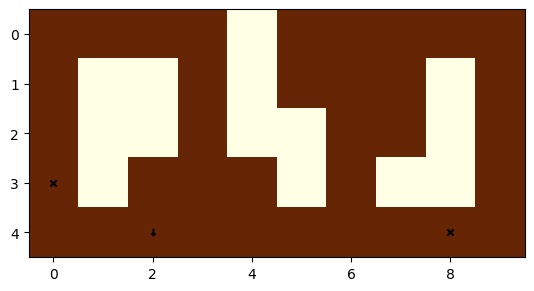

curr_reward 43.78758589935878
accumulated_reward 0
current Design
[(4, 2)]


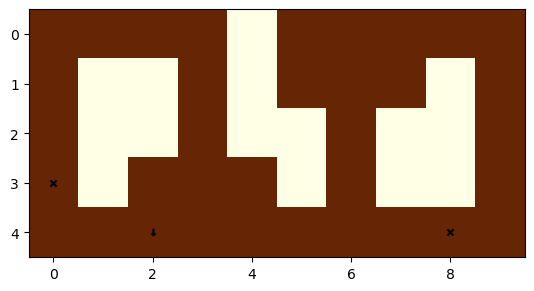

curr_reward 44.299698205343844
accumulated_reward 0
current Design
[(4, 2)]


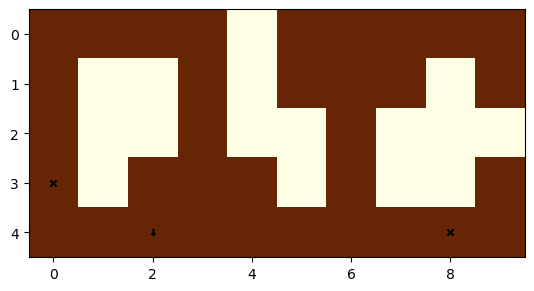

curr_reward 42.064523969593296
accumulated_reward 0
current Design
[(4, 2)]


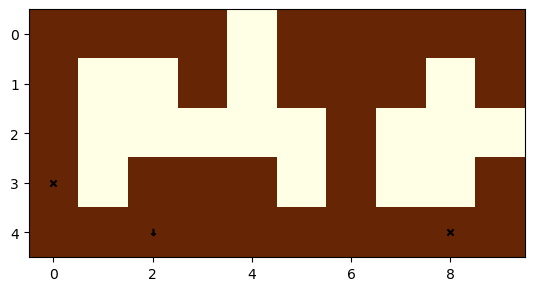

curr_reward 93.22020374323273
accumulated_reward 0
current Design
[(4, 2)]


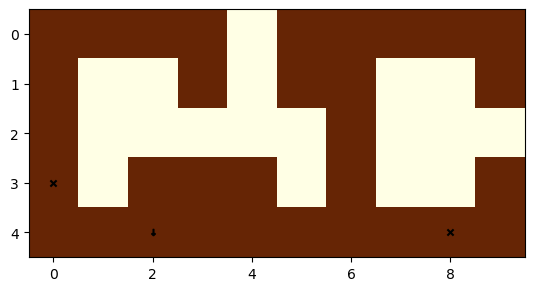

curr_reward 92.77798156292774
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2150000
Best mean reward: 62.07 - Last mean reward per episode: -29.13
current Design
[(4, 9)]


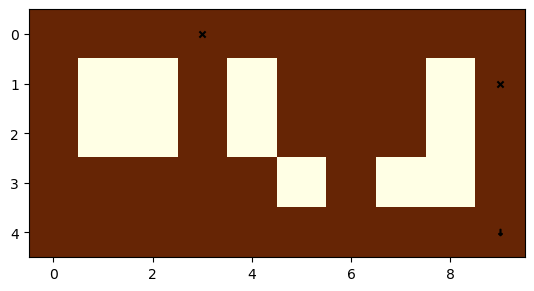

hello hello
--------------------------------------------------
Num timesteps: 2160000
Best mean reward: 62.07 - Last mean reward per episode: -38.63
current Design
[(3, 9)]


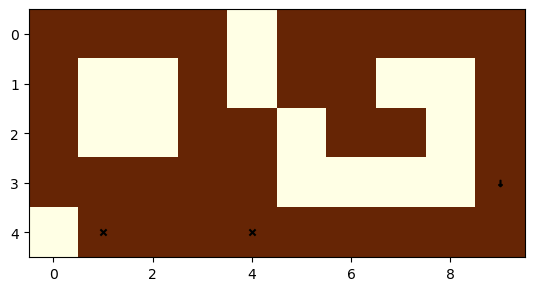

hello hello
--------------------------------------------------
Num timesteps: 2170000
Best mean reward: 62.07 - Last mean reward per episode: 20.79
current Design
[(0, 7)]


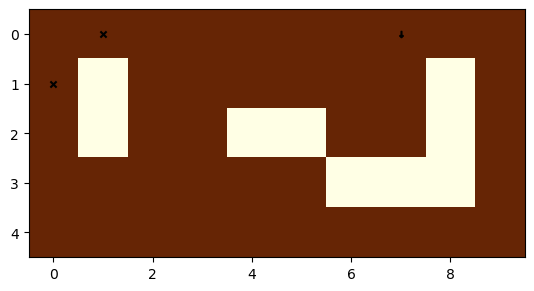

hello hello
--------------------------------------------------
Num timesteps: 2180000
Best mean reward: 62.07 - Last mean reward per episode: -12.23
current Design
[(0, 3)]


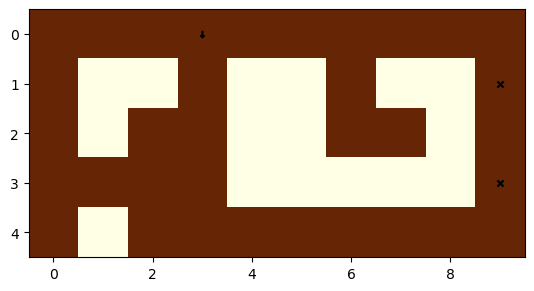

hello hello
--------------------------------------------------
Num timesteps: 2190000
Best mean reward: 62.07 - Last mean reward per episode: 96.62
current Design
[(4, 7)]


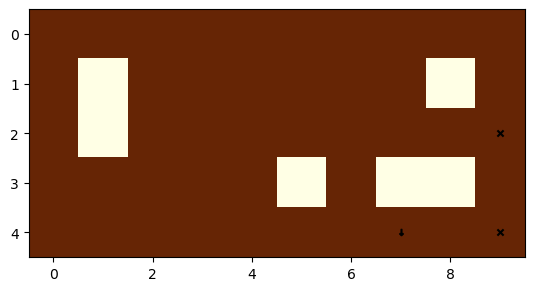

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 2200000
Best mean reward: 96.62 - Last mean reward per episode: 49.33
current Design
[(4, 6)]


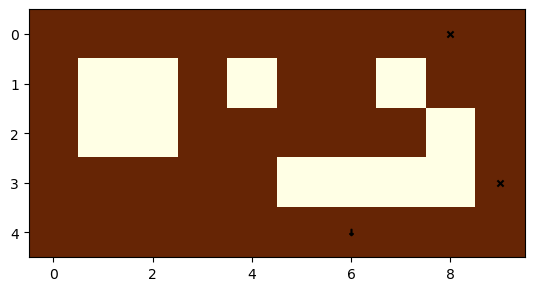

hello hello
--------------------------------------------------
Num timesteps: 2210000
Best mean reward: 96.62 - Last mean reward per episode: 84.65
current Design
[(4, 0)]


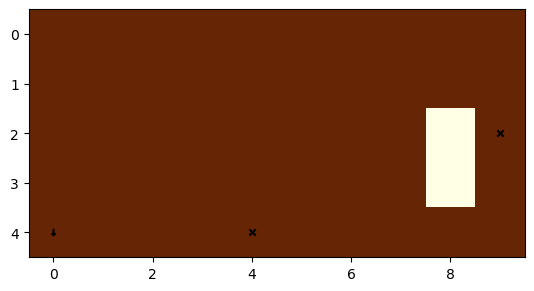

hello hello
--------------------------------------------------
Num timesteps: 2220000
Best mean reward: 96.62 - Last mean reward per episode: 58.70
current Design
[(0, 3)]


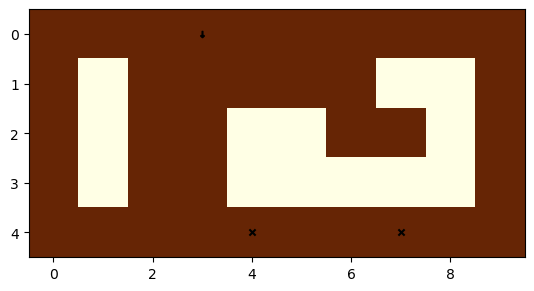

hello hello
--------------------------------------------------
Num timesteps: 2230000
Best mean reward: 96.62 - Last mean reward per episode: -48.03
current Design
[(1, 0)]


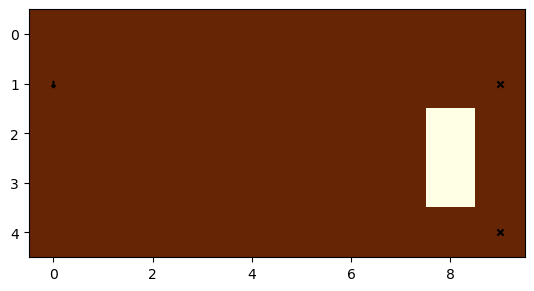

current Design
[(4, 7)]


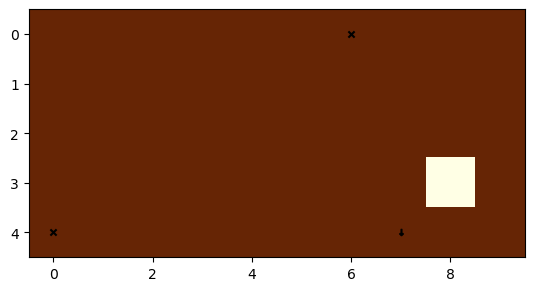

curr_reward 3.9287450602856944
accumulated_reward 0
current Design
[(4, 7)]


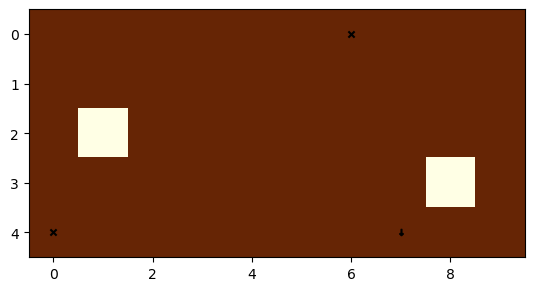

curr_reward 7.561725516279662
accumulated_reward 0
current Design
[(4, 7)]


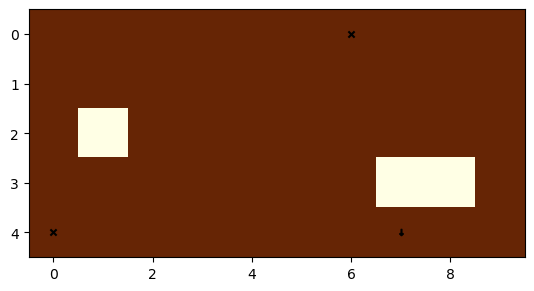

curr_reward 10.944764454056132
accumulated_reward 0
current Design
[(4, 7)]


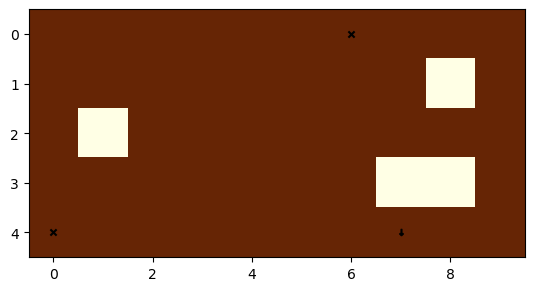

curr_reward 14.07971218773327
accumulated_reward 0
current Design
[(4, 7)]


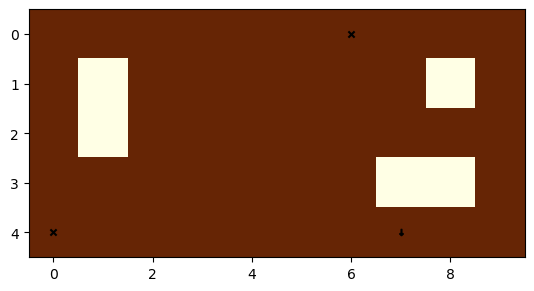

curr_reward 16.866334563885026
accumulated_reward 0
current Design
[(4, 7)]


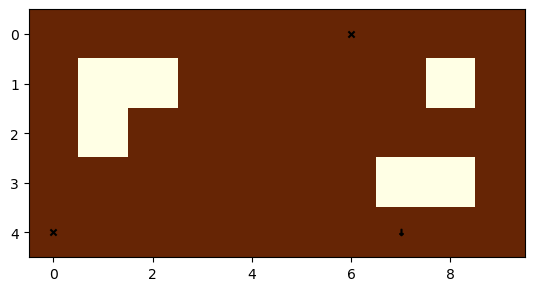

curr_reward 19.33061161736297
accumulated_reward 0
current Design
[(4, 7)]


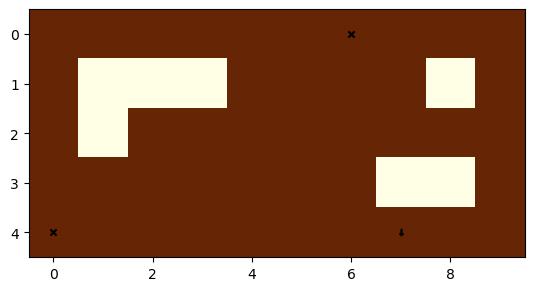

curr_reward 21.373548978766518
accumulated_reward 0
current Design
[(4, 7)]


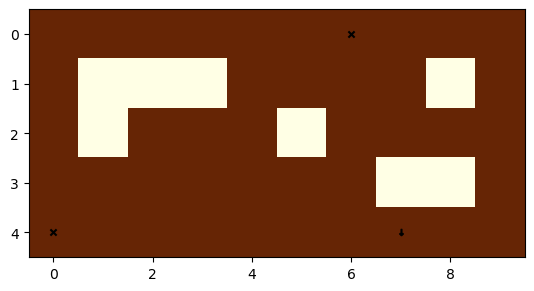

curr_reward 22.84998117400218
accumulated_reward 0
current Design
[(4, 7)]


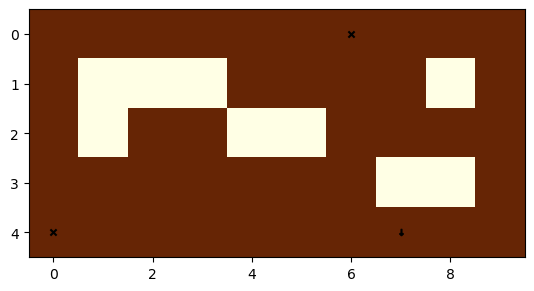

curr_reward 24.200997720218524
accumulated_reward 0
current Design
[(4, 7)]


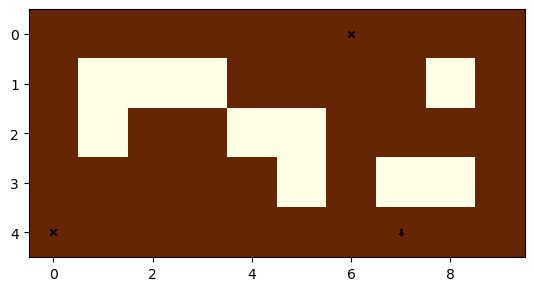

curr_reward 25.812193059751124
accumulated_reward 0
current Design
[(4, 7)]


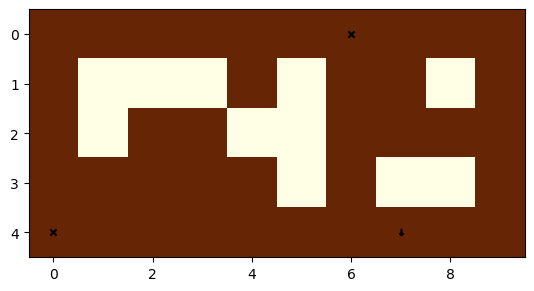

curr_reward 26.23109012531887
accumulated_reward 0
current Design
[(4, 7)]


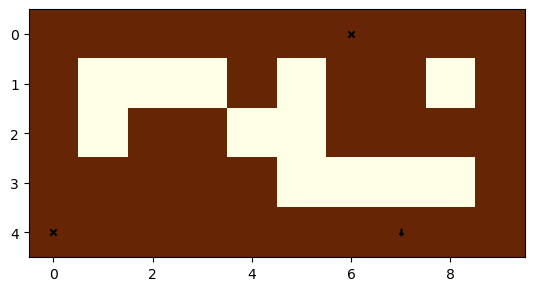

curr_reward 26.3308791388619
accumulated_reward 0
current Design
[(4, 7)]


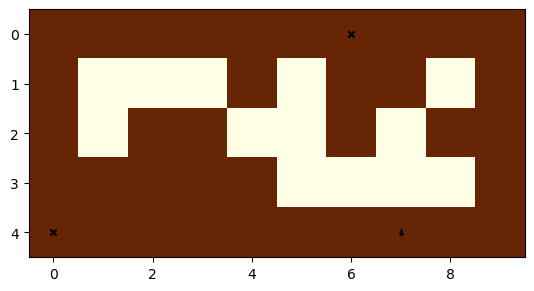

curr_reward 27.703709598097614
accumulated_reward 0
current Design
[(4, 7)]


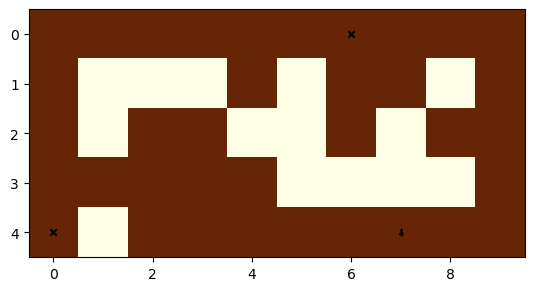

curr_reward 29.405508816418177
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2240000
Best mean reward: 96.62 - Last mean reward per episode: 41.62
current Design
[(1, 9)]


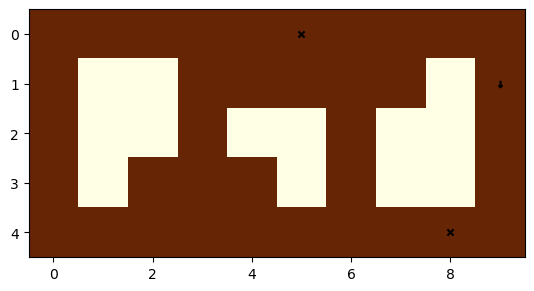

hello hello
--------------------------------------------------
Num timesteps: 2250000
Best mean reward: 96.62 - Last mean reward per episode: 24.01
current Design
[(4, 5)]


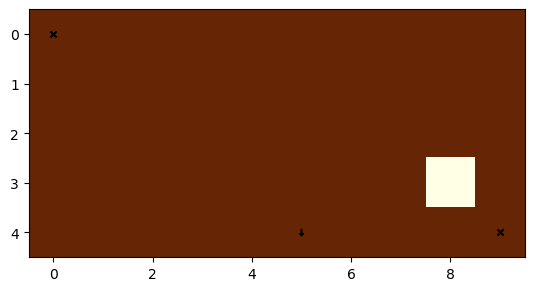

hello hello
--------------------------------------------------
Num timesteps: 2260000
Best mean reward: 96.62 - Last mean reward per episode: -63.27
current Design
[(0, 3)]


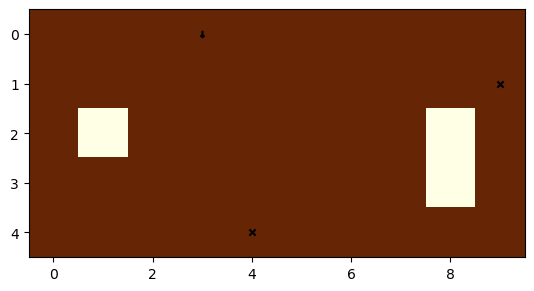

hello hello
--------------------------------------------------
Num timesteps: 2270000
Best mean reward: 96.62 - Last mean reward per episode: 60.08
current Design
[(0, 9)]


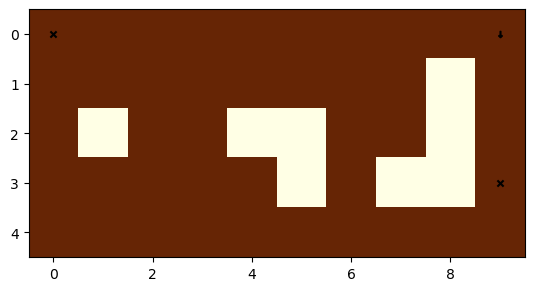

hello hello
--------------------------------------------------
Num timesteps: 2280000
Best mean reward: 96.62 - Last mean reward per episode: -29.86
current Design
[(0, 3)]


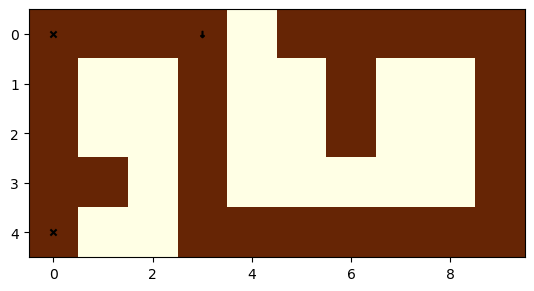

hello hello
--------------------------------------------------
Num timesteps: 2290000
Best mean reward: 96.62 - Last mean reward per episode: 44.96
current Design
[(0, 1)]


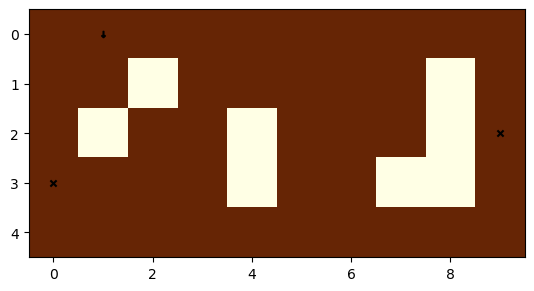

hello hello
--------------------------------------------------
Num timesteps: 2300000
Best mean reward: 96.62 - Last mean reward per episode: 111.35
current Design
[(3, 9)]


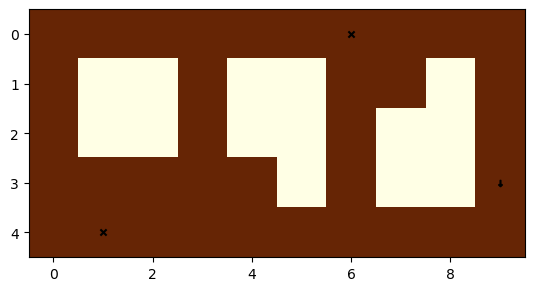

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 2310000
Best mean reward: 111.35 - Last mean reward per episode: -39.68
current Design
[(4, 7)]


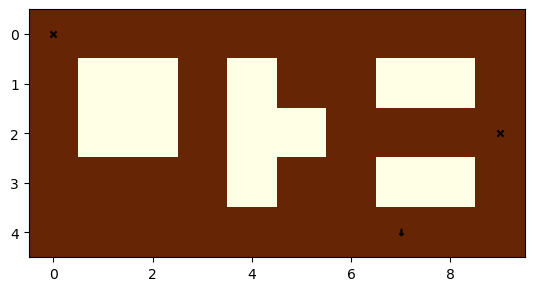

hello hello
--------------------------------------------------
Num timesteps: 2320000
Best mean reward: 111.35 - Last mean reward per episode: 2.43
current Design
[(4, 0)]


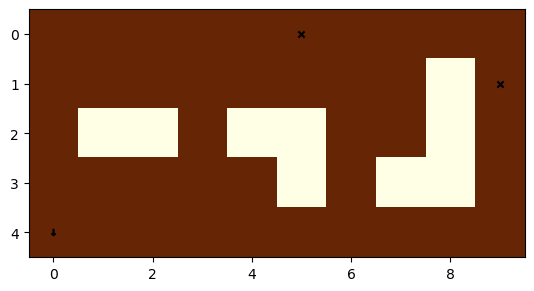

hello hello
--------------------------------------------------
Num timesteps: 2330000
Best mean reward: 111.35 - Last mean reward per episode: 4.74
current Design
[(1, 0)]


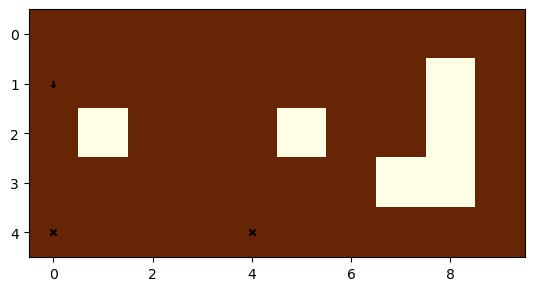

current Design
[(0, 9)]


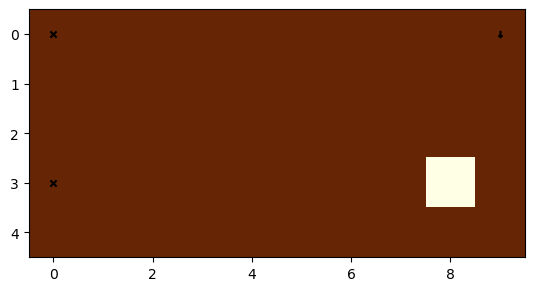

curr_reward 3.858477943793179
accumulated_reward 0
current Design
[(0, 9)]


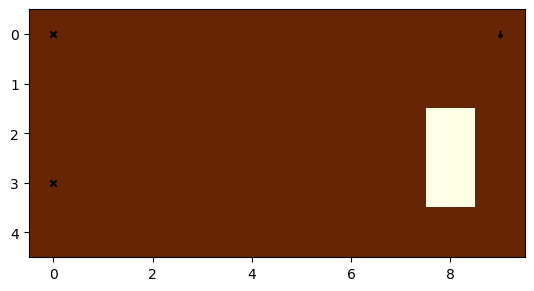

curr_reward 7.4434476622606
accumulated_reward 0
current Design
[(0, 9)]


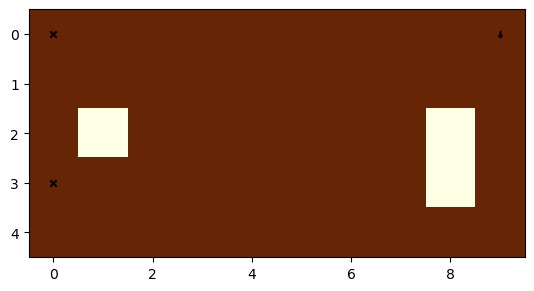

curr_reward 10.831791635616769
accumulated_reward 0
current Design
[(0, 9)]


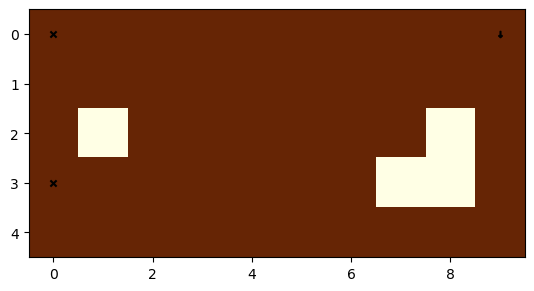

curr_reward 13.835135927873921
accumulated_reward 0
current Design
[(0, 9)]


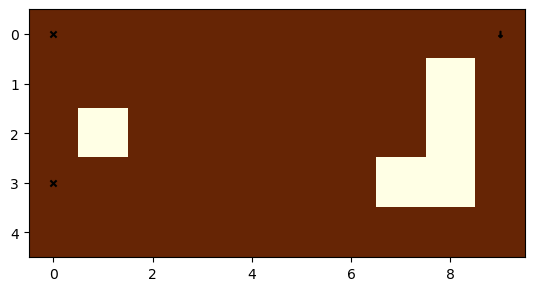

curr_reward 16.64447486908764
accumulated_reward 0
current Design
[(0, 9)]


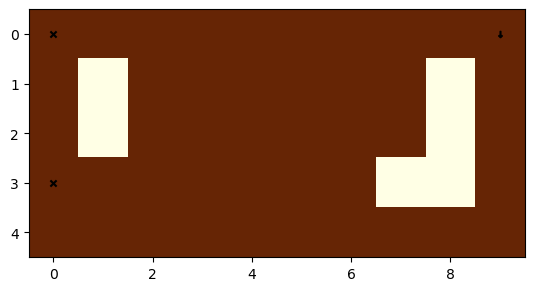

curr_reward 19.40672252581958
accumulated_reward 0
current Design
[(0, 9)]


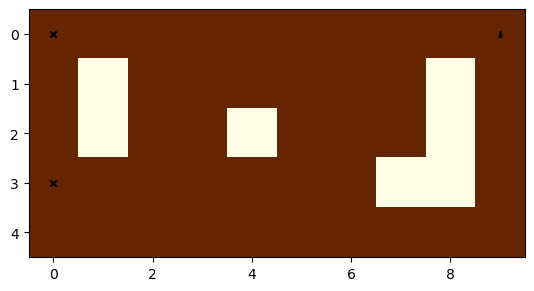

curr_reward 21.79676384828471
accumulated_reward 0
current Design
[(0, 9)]


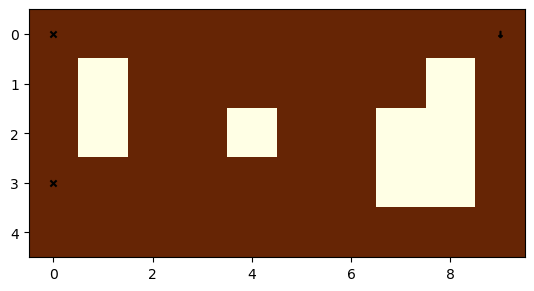

curr_reward 23.875524356714852
accumulated_reward 0
current Design
[(0, 9)]


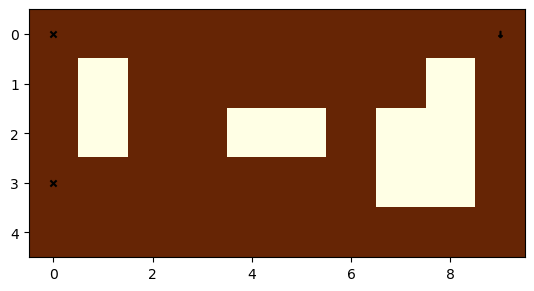

curr_reward 25.585381189336662
accumulated_reward 0
current Design
[(0, 9)]


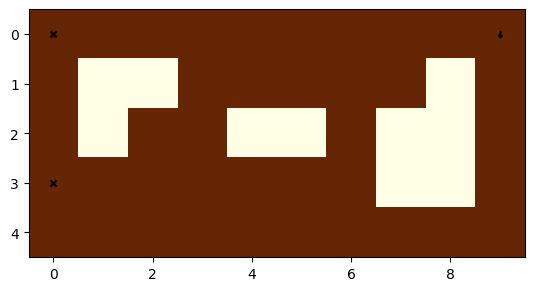

curr_reward 29.023108901568776
accumulated_reward 0
current Design
[(0, 9)]


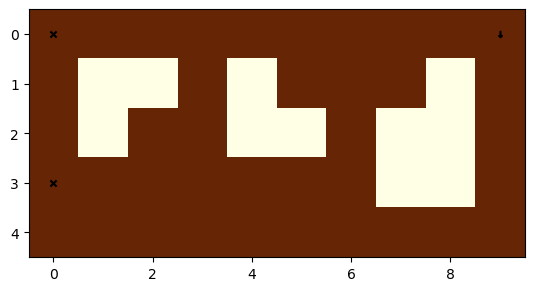

curr_reward 30.073465525591033
accumulated_reward 0
current Design
[(0, 9)]


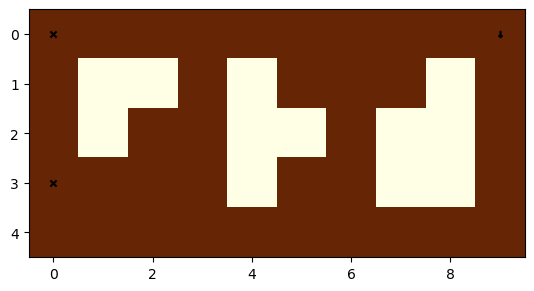

curr_reward 31.715110229790014
accumulated_reward 0
current Design
[(0, 9)]


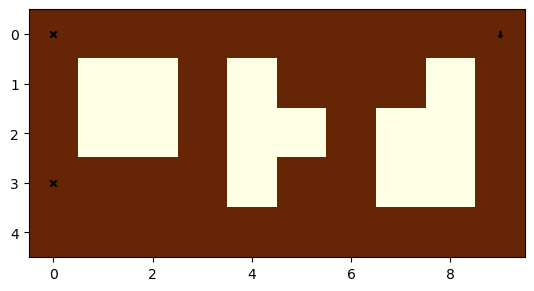

curr_reward 31.895558922506694
accumulated_reward 0
current Design
[(0, 9)]


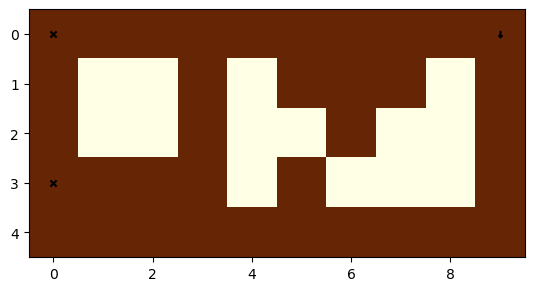

curr_reward 32.46309026048647
accumulated_reward 0
current Design
[(0, 9)]


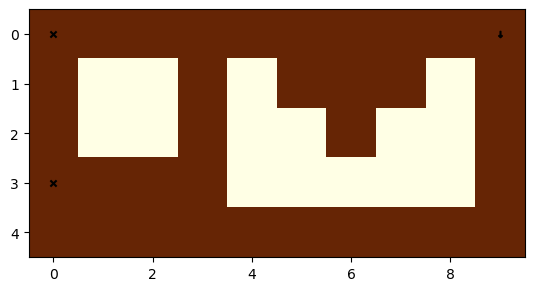

curr_reward 31.376389243131666
accumulated_reward 0
current Design
[(0, 9)]


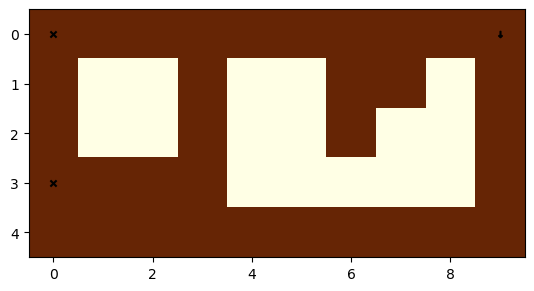

curr_reward 31.975782336054568
accumulated_reward 0
current Design
[(0, 9)]


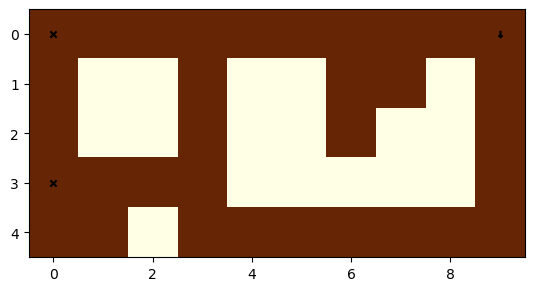

curr_reward 30.844924400191847
accumulated_reward 0
current Design
[(0, 9)]


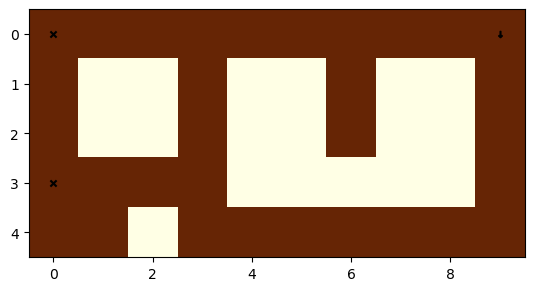

curr_reward 31.024508770881745
accumulated_reward 0
current Design
[(0, 9)]


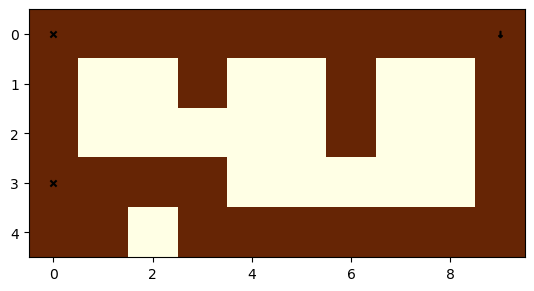

curr_reward 30.471657671071434
accumulated_reward 0
current Design
[(0, 9)]


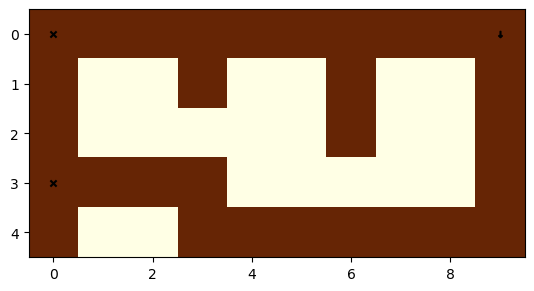

curr_reward 30.0149852608554
accumulated_reward 0
current Design
[(0, 9)]


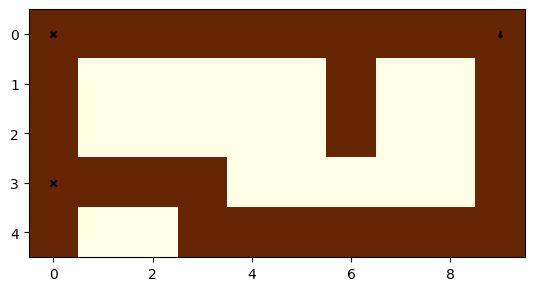

curr_reward 30.30556797461855
accumulated_reward 0
current Design
[(0, 9)]


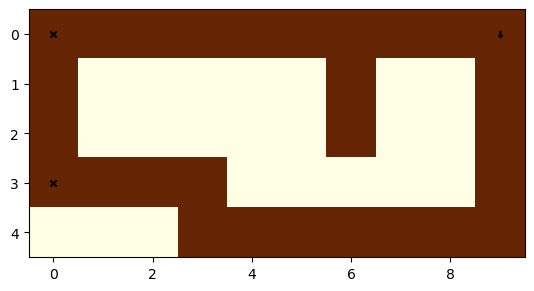

curr_reward 29.596876531692402
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2340000
Best mean reward: 111.35 - Last mean reward per episode: 34.69
current Design
[(4, 5)]


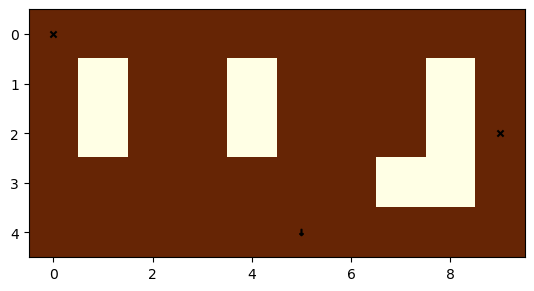

hello hello
--------------------------------------------------
Num timesteps: 2350000
Best mean reward: 111.35 - Last mean reward per episode: 75.20
current Design
[(4, 7)]


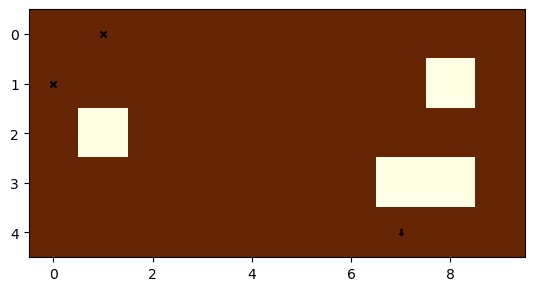

hello hello
--------------------------------------------------
Num timesteps: 2360000
Best mean reward: 111.35 - Last mean reward per episode: 23.23
current Design
[(4, 9)]


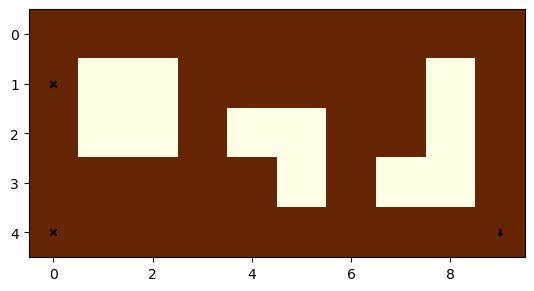

hello hello
--------------------------------------------------
Num timesteps: 2370000
Best mean reward: 111.35 - Last mean reward per episode: -7.19
current Design
[(4, 6)]


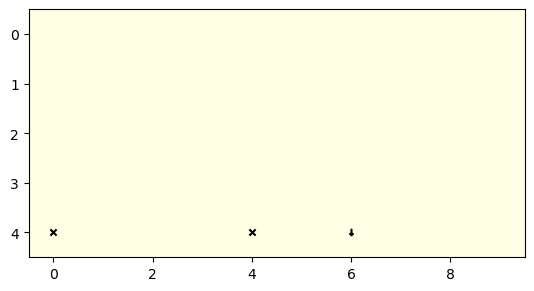

hello hello
--------------------------------------------------
Num timesteps: 2380000
Best mean reward: 111.35 - Last mean reward per episode: -31.30
current Design
[(0, 0)]


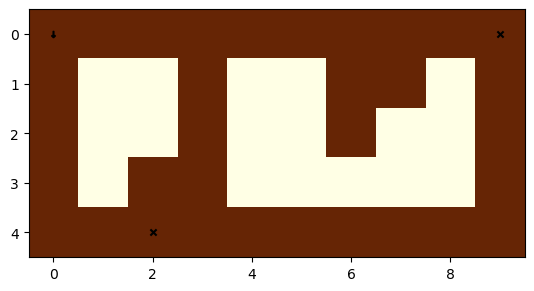

hello hello
--------------------------------------------------
Num timesteps: 2390000
Best mean reward: 111.35 - Last mean reward per episode: -52.49
current Design
[(0, 5)]


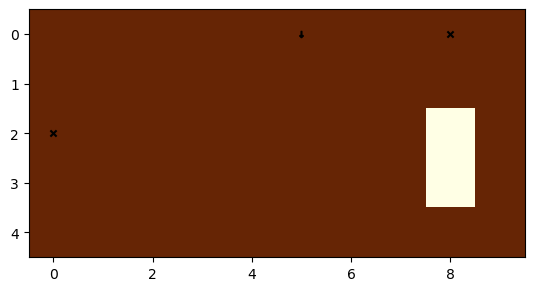

hello hello
--------------------------------------------------
Num timesteps: 2400000
Best mean reward: 111.35 - Last mean reward per episode: -36.72
current Design
[(4, 9)]


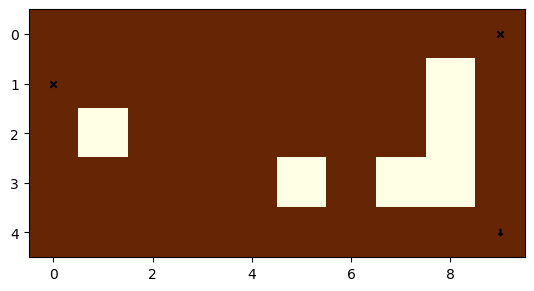

hello hello
--------------------------------------------------
Num timesteps: 2410000
Best mean reward: 111.35 - Last mean reward per episode: 166.16
current Design
[(4, 5)]


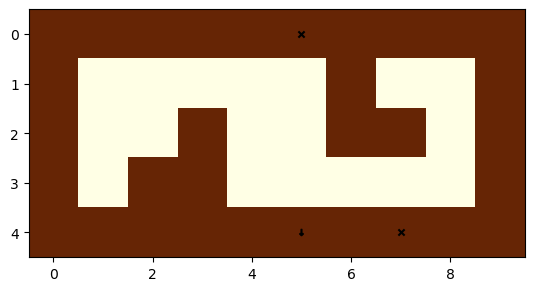

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 2420000
Best mean reward: 166.16 - Last mean reward per episode: 19.54
current Design
[(4, 0)]


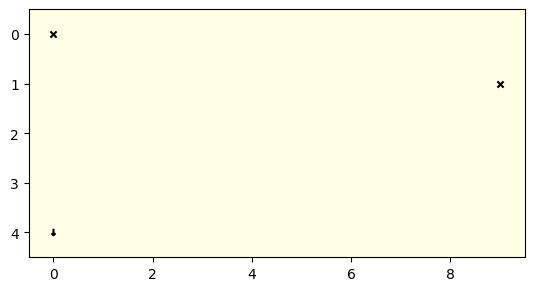

current Design
[(2, 0)]


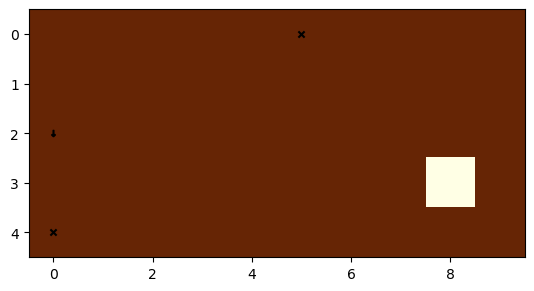

curr_reward 3.8302776666532212
accumulated_reward 0
current Design
[(2, 0)]


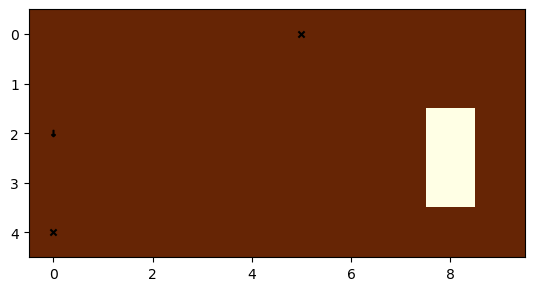

curr_reward 7.335952831144831
accumulated_reward 0
current Design
[(2, 0)]


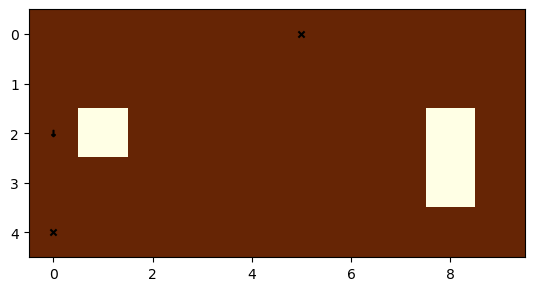

curr_reward 10.930220047767197
accumulated_reward 0
current Design
[(2, 0)]


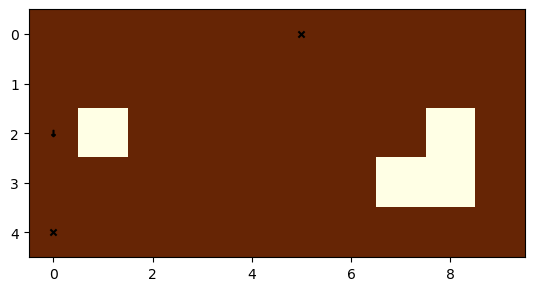

curr_reward 13.939896129686275
accumulated_reward 0
current Design
[(2, 0)]


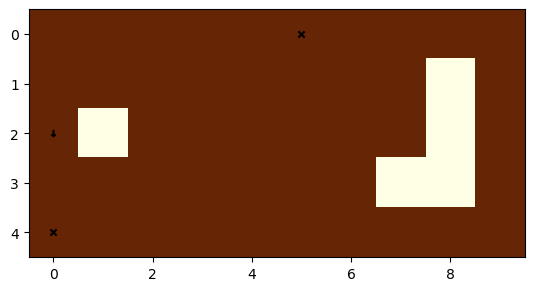

curr_reward 16.690094192653405
accumulated_reward 0
current Design
[(2, 0)]


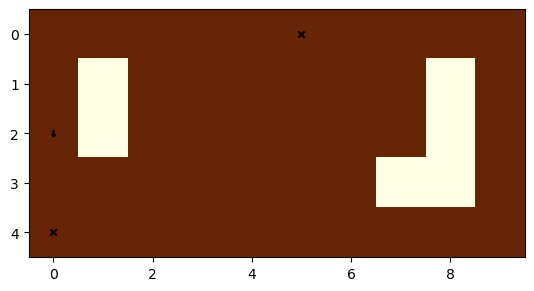

curr_reward 18.767259411902984
accumulated_reward 0
current Design
[(2, 0)]


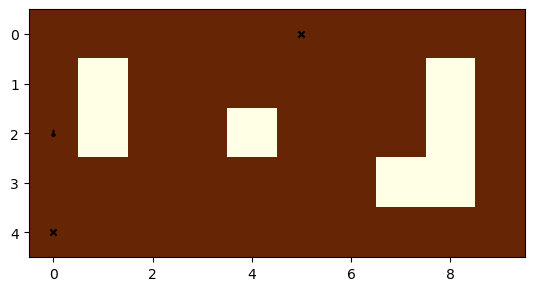

curr_reward 21.1293451802892
accumulated_reward 0
current Design
[(2, 0)]


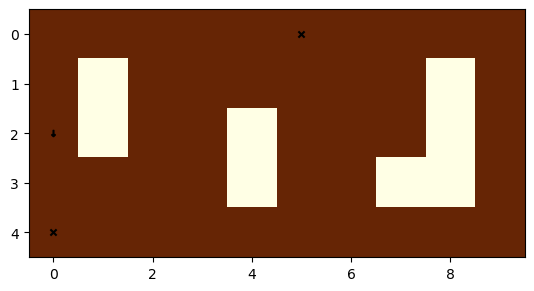

curr_reward 23.269835504854782
accumulated_reward 0
current Design
[(2, 0)]


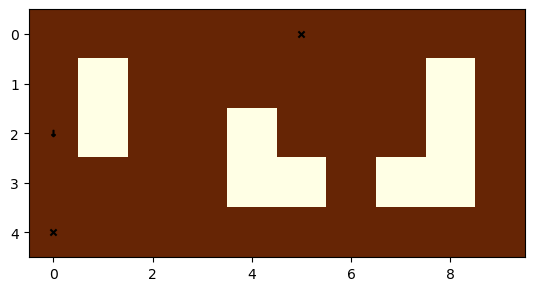

curr_reward 24.776990615948122
accumulated_reward 0
current Design
[(2, 0)]


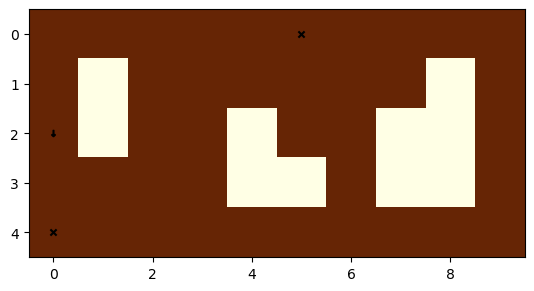

curr_reward 26.112784396080436
accumulated_reward 0
current Design
[(2, 0)]


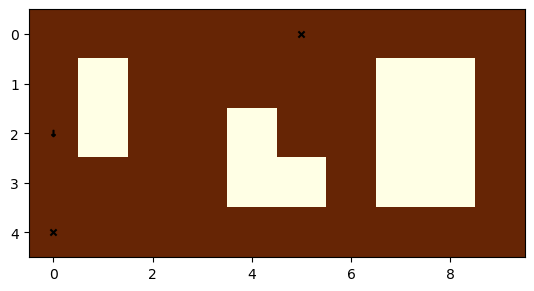

curr_reward 27.249980788516115
accumulated_reward 0
current Design
[(2, 0)]


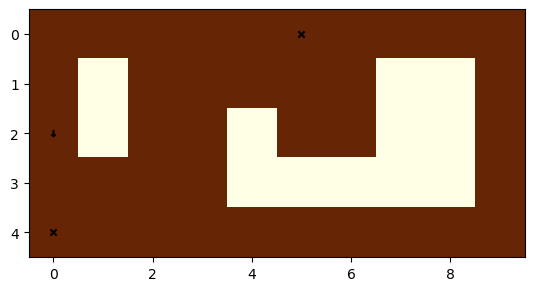

curr_reward 28.461803776317026
accumulated_reward 0
current Design
[(2, 0)]


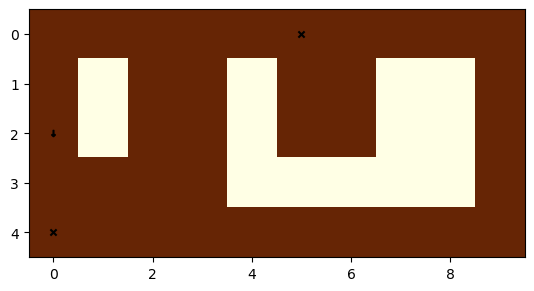

curr_reward 29.633675395484104
accumulated_reward 0
current Design
[(2, 0)]


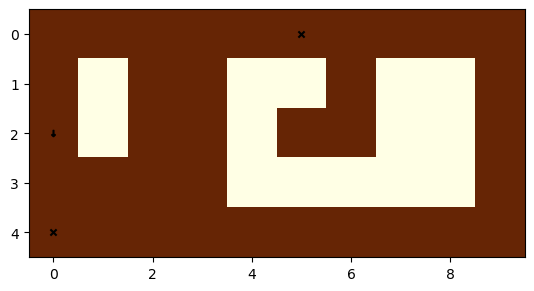

curr_reward 30.210278031138724
accumulated_reward 0
current Design
[(2, 0)]


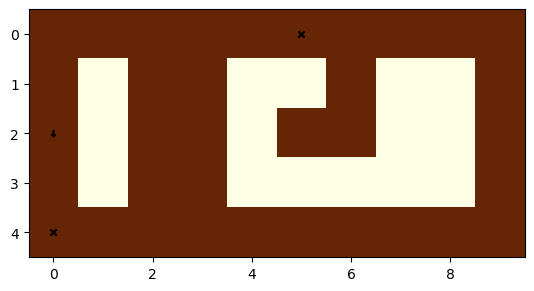

curr_reward 34.29672713705037
accumulated_reward 0
current Design
[(2, 0)]


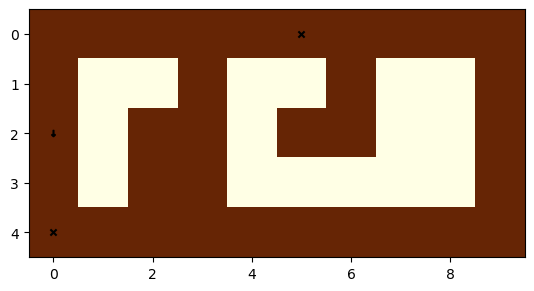

curr_reward 36.36563750619329
accumulated_reward 0
current Design
[(2, 0)]


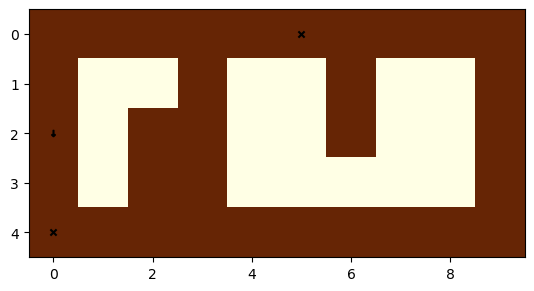

curr_reward 36.3990640635446
accumulated_reward 0
current Design
[(2, 0)]


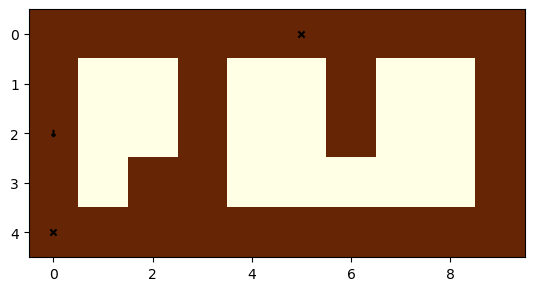

curr_reward 36.06924398616729
accumulated_reward 0
current Design
[(2, 0)]


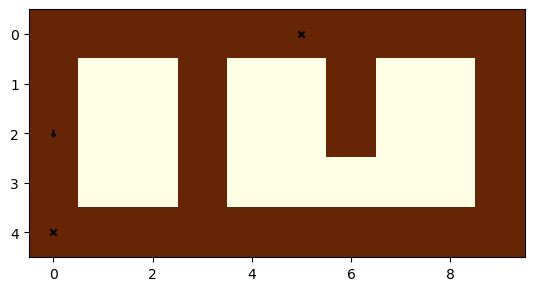

curr_reward 35.587242673729264
accumulated_reward 0
current Design
[(2, 0)]


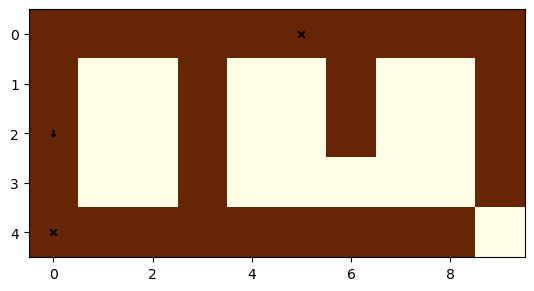

curr_reward 35.17118623112445
accumulated_reward 0
current Design
[(2, 0)]


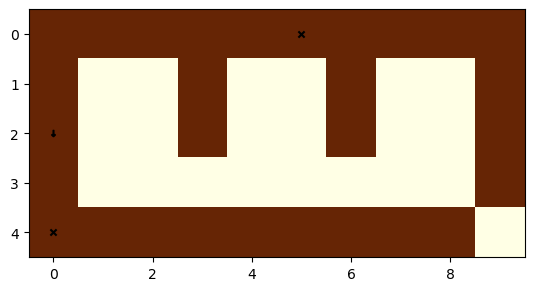

curr_reward 33.99265018990165
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2430000
Best mean reward: 166.16 - Last mean reward per episode: -35.10
current Design
[(0, 0)]


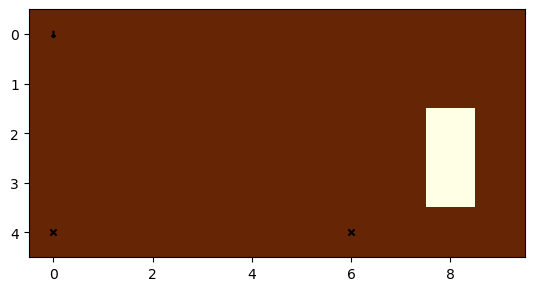

hello hello
--------------------------------------------------
Num timesteps: 2440000
Best mean reward: 166.16 - Last mean reward per episode: -8.24
current Design
[(4, 0)]


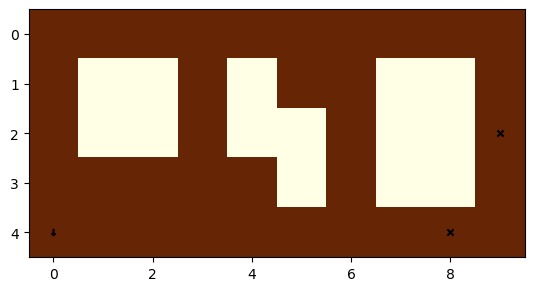

hello hello
--------------------------------------------------
Num timesteps: 2450000
Best mean reward: 166.16 - Last mean reward per episode: 7.79
current Design
[(3, 0)]


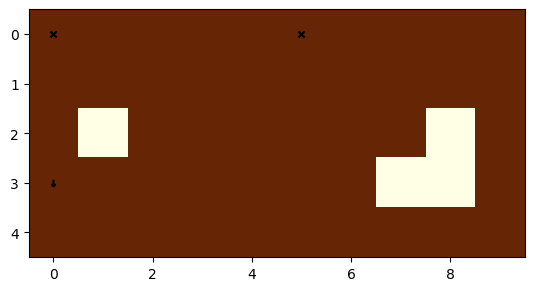

hello hello
--------------------------------------------------
Num timesteps: 2460000
Best mean reward: 166.16 - Last mean reward per episode: 115.89
current Design
[(0, 6)]


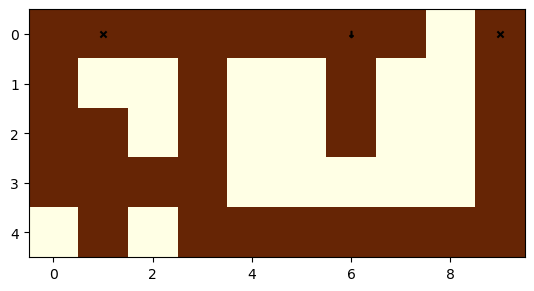

hello hello
--------------------------------------------------
Num timesteps: 2470000
Best mean reward: 166.16 - Last mean reward per episode: 15.57
current Design
[(4, 0)]


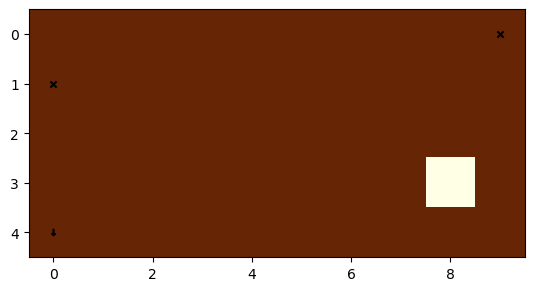

hello hello
--------------------------------------------------
Num timesteps: 2480000
Best mean reward: 166.16 - Last mean reward per episode: 81.63
current Design
[(0, 2)]


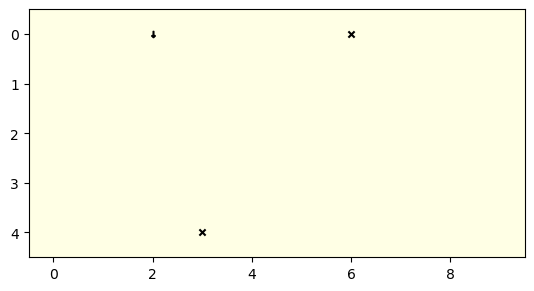

hello hello
--------------------------------------------------
Num timesteps: 2490000
Best mean reward: 166.16 - Last mean reward per episode: 12.40
current Design
[(4, 9)]


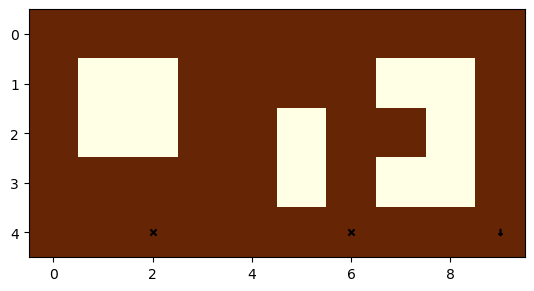

hello hello
--------------------------------------------------
Num timesteps: 2500000
Best mean reward: 166.16 - Last mean reward per episode: 34.12
current Design
[(4, 0)]


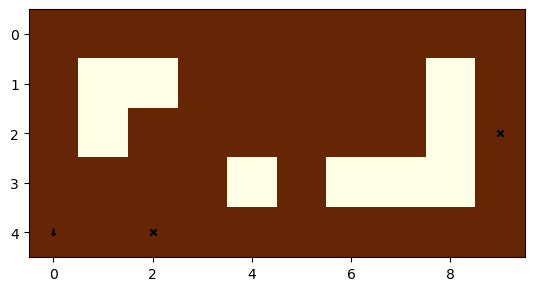

hello hello
--------------------------------------------------
Num timesteps: 2510000
Best mean reward: 166.16 - Last mean reward per episode: -18.59
current Design
[(1, 0)]


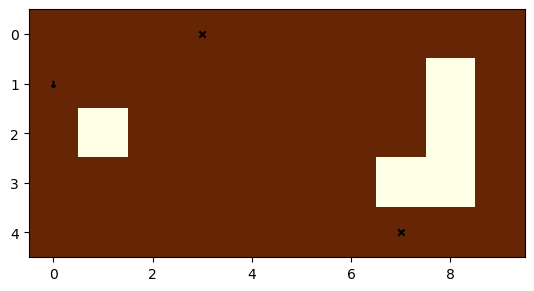

hello hello
--------------------------------------------------
Num timesteps: 2520000
Best mean reward: 166.16 - Last mean reward per episode: 27.25
current Design
[(0, 9)]


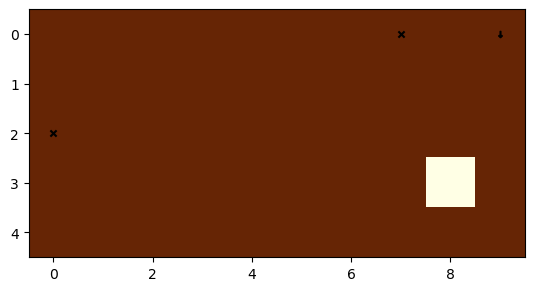

current Design
[(3, 9)]


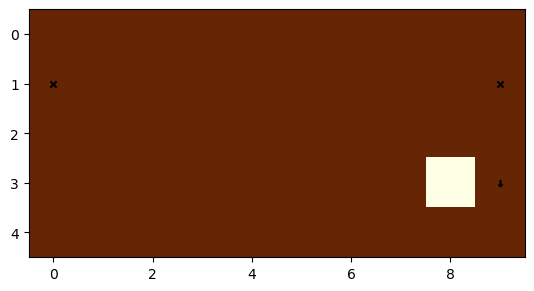

curr_reward 4.017441061284379
accumulated_reward 0
current Design
[(3, 9)]


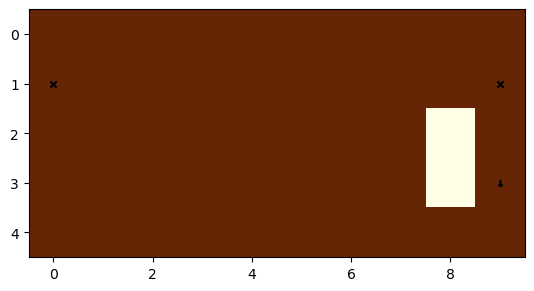

curr_reward 7.350463586312172
accumulated_reward 0
current Design
[(3, 9)]


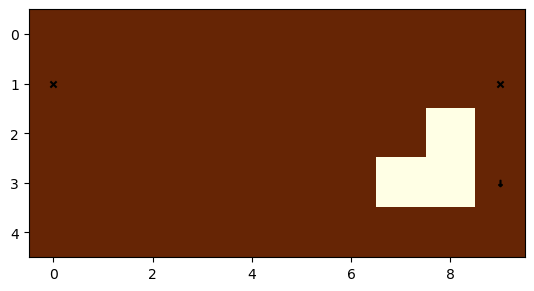

curr_reward 10.80472765218416
accumulated_reward 0
current Design
[(3, 9)]


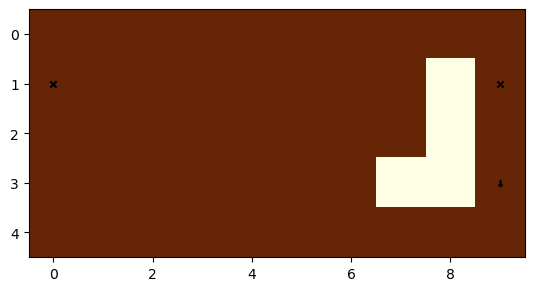

curr_reward 13.141725936011728
accumulated_reward 0
current Design
[(3, 9)]


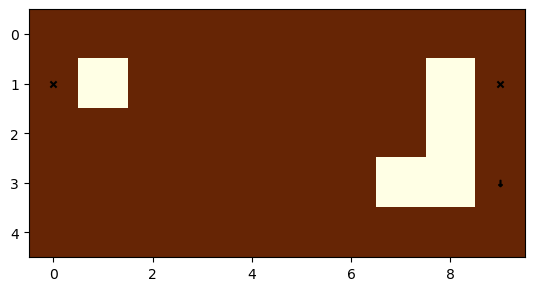

curr_reward 16.255676724017544
accumulated_reward 0
current Design
[(3, 9)]


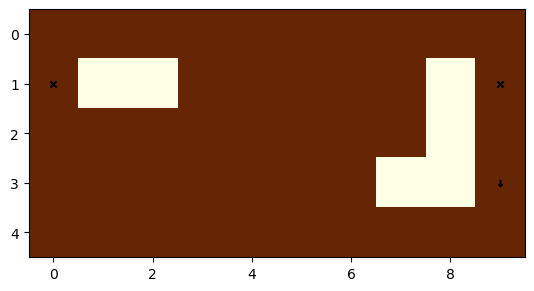

curr_reward 18.824079601423716
accumulated_reward 0
current Design
[(3, 9)]


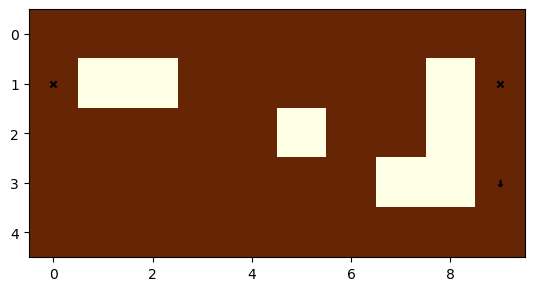

curr_reward 21.015826605747726
accumulated_reward 0
current Design
[(3, 9)]


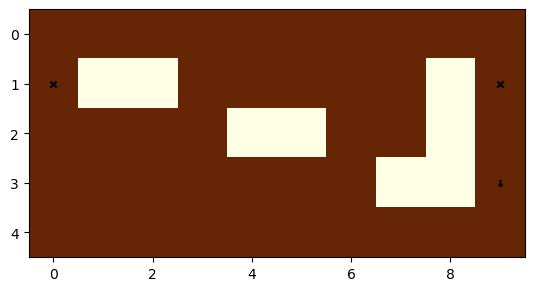

curr_reward 22.981821776824244
accumulated_reward 0
current Design
[(3, 9)]


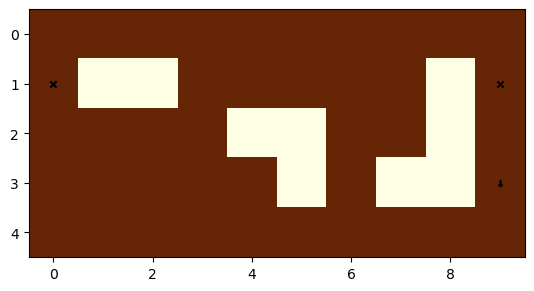

curr_reward 25.542890173467907
accumulated_reward 0
current Design
[(3, 9)]


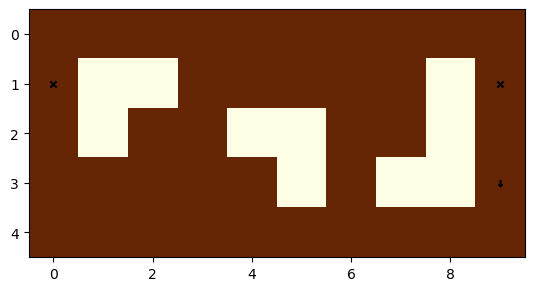

curr_reward 27.728444919404012
accumulated_reward 0
current Design
[(3, 9)]


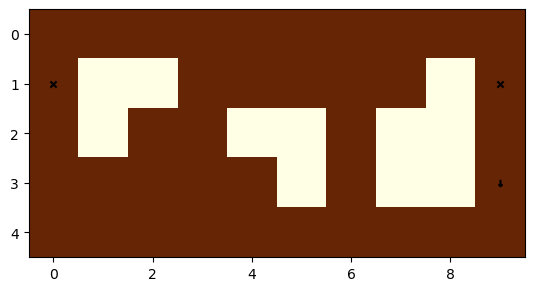

curr_reward 28.988650456855574
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2530000
Best mean reward: 166.16 - Last mean reward per episode: -30.12
current Design
[(2, 9)]


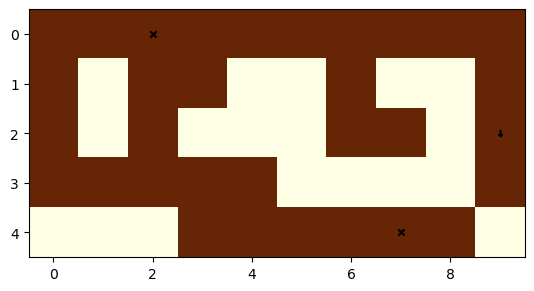

hello hello
--------------------------------------------------
Num timesteps: 2540000
Best mean reward: 166.16 - Last mean reward per episode: 75.28
current Design
[(0, 0)]


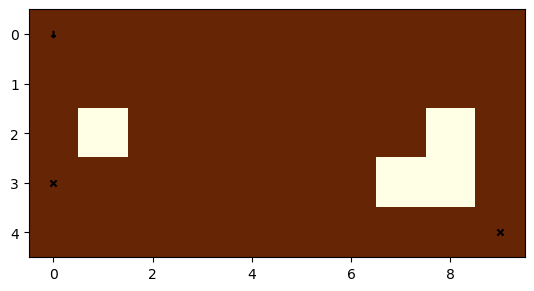

hello hello
--------------------------------------------------
Num timesteps: 2550000
Best mean reward: 166.16 - Last mean reward per episode: 17.56
current Design
[(4, 5)]


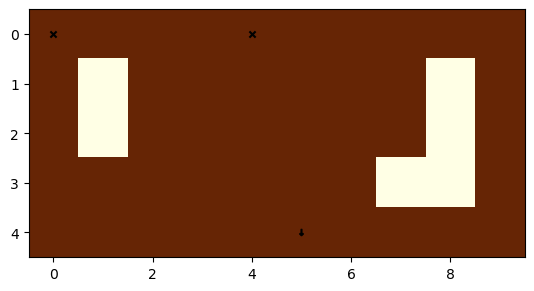

hello hello
--------------------------------------------------
Num timesteps: 2560000
Best mean reward: 166.16 - Last mean reward per episode: 21.23
current Design
[(4, 0)]


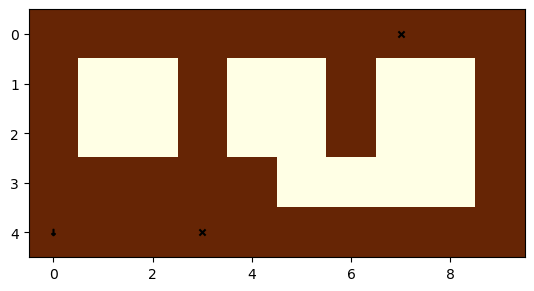

hello hello
--------------------------------------------------
Num timesteps: 2570000
Best mean reward: 166.16 - Last mean reward per episode: 58.77
current Design
[(2, 0)]


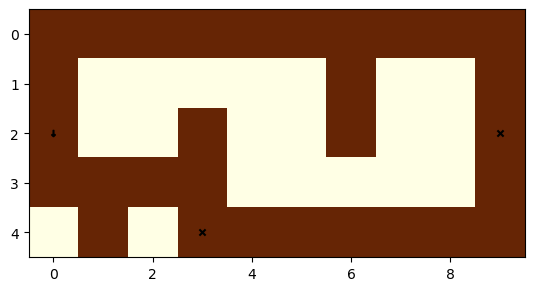

hello hello
--------------------------------------------------
Num timesteps: 2580000
Best mean reward: 166.16 - Last mean reward per episode: 46.56
current Design
[(0, 9)]


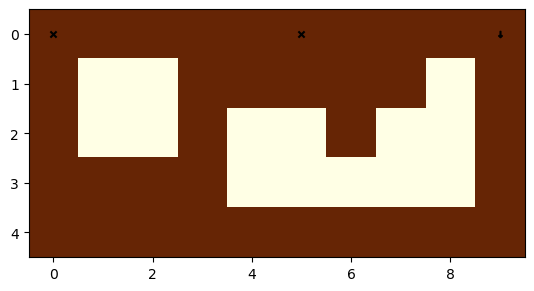

hello hello
--------------------------------------------------
Num timesteps: 2590000
Best mean reward: 166.16 - Last mean reward per episode: 16.19
current Design
[(1, 0)]


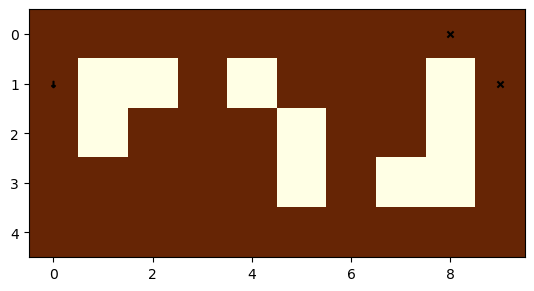

hello hello
--------------------------------------------------
Num timesteps: 2600000
Best mean reward: 166.16 - Last mean reward per episode: 74.08
current Design
[(0, 9)]


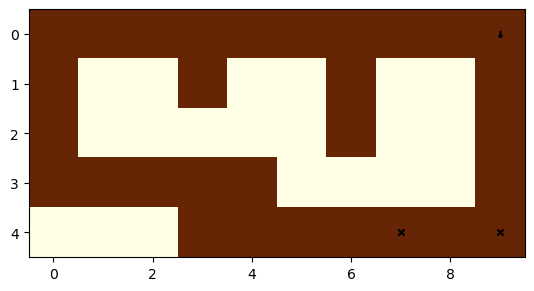

hello hello
--------------------------------------------------
Num timesteps: 2610000
Best mean reward: 166.16 - Last mean reward per episode: 71.32
current Design
[(0, 9)]


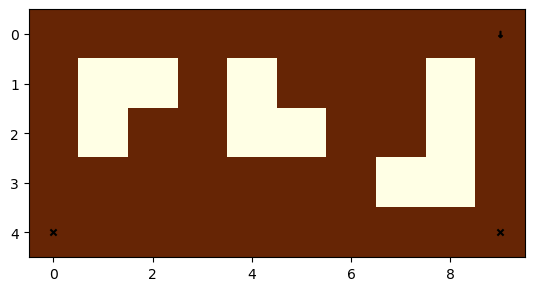

hello hello
--------------------------------------------------
Num timesteps: 2620000
Best mean reward: 166.16 - Last mean reward per episode: 64.36
current Design
[(0, 9)]


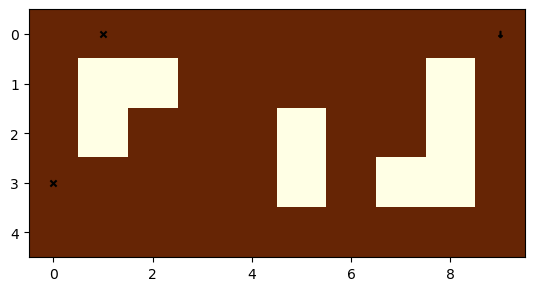

current Design
[(2, 9)]


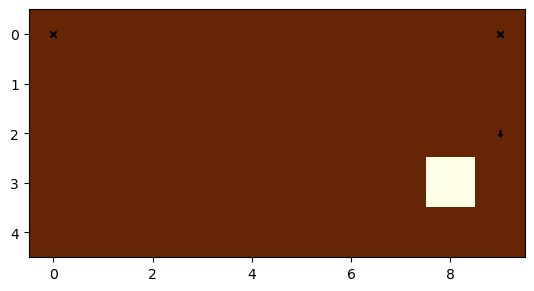

curr_reward 4.042971572733943
accumulated_reward 0
current Design
[(2, 9)]


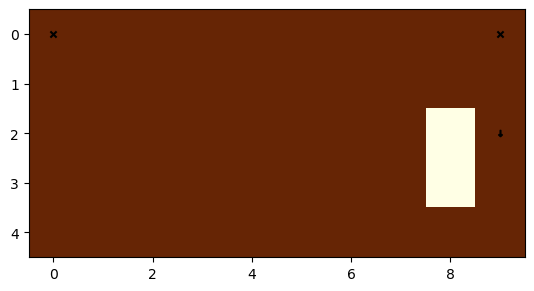

curr_reward 8.299568173909767
accumulated_reward 0
current Design
[(2, 9)]


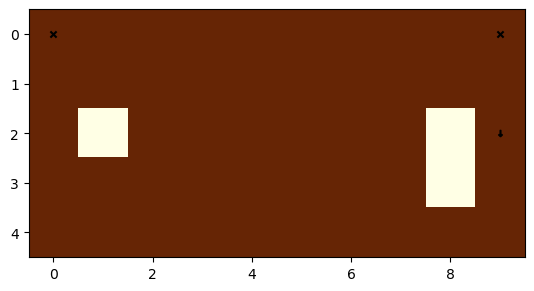

curr_reward 12.075873310839407
accumulated_reward 0
current Design
[(2, 9)]


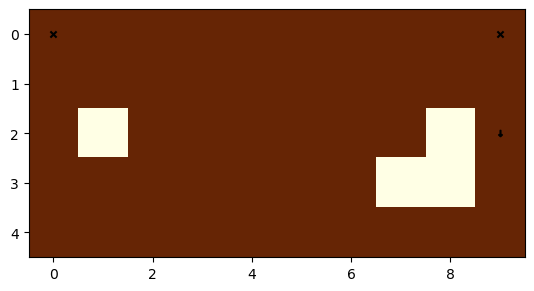

curr_reward 15.560069343014705
accumulated_reward 0
current Design
[(2, 9)]


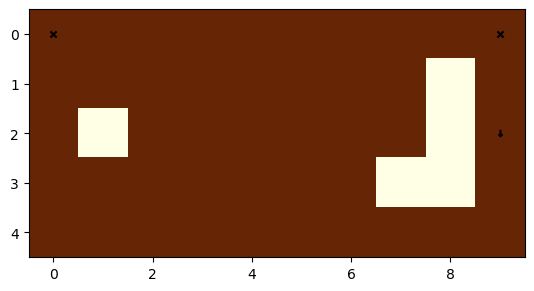

curr_reward 18.258109714677733
accumulated_reward 0
current Design
[(2, 9)]


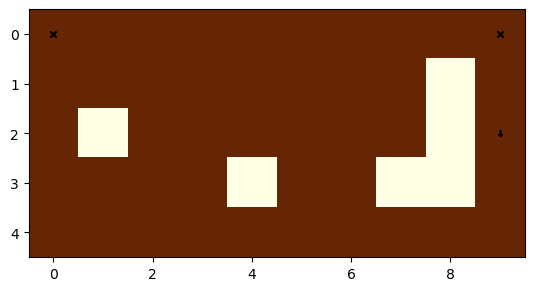

curr_reward 21.24421746375161
accumulated_reward 0
current Design
[(2, 9)]


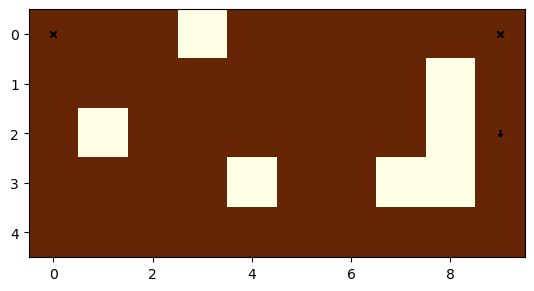

curr_reward 24.149748026401888
accumulated_reward 0
current Design
[(2, 9)]


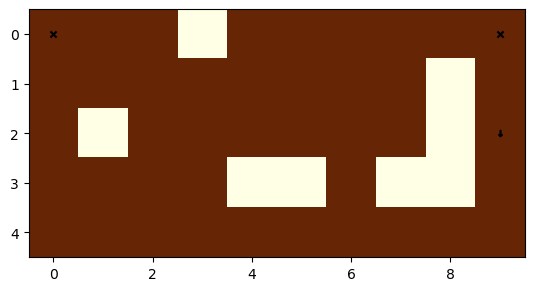

curr_reward 26.685566013405786
accumulated_reward 0
current Design
[(2, 9)]


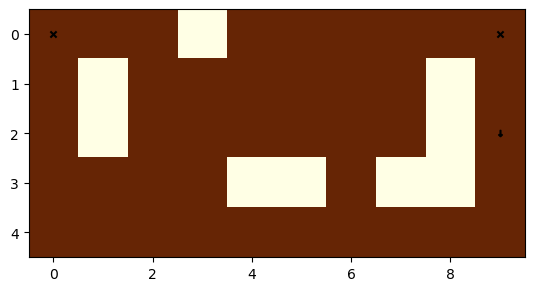

curr_reward 28.849122299701833
accumulated_reward 0
current Design
[(2, 9)]


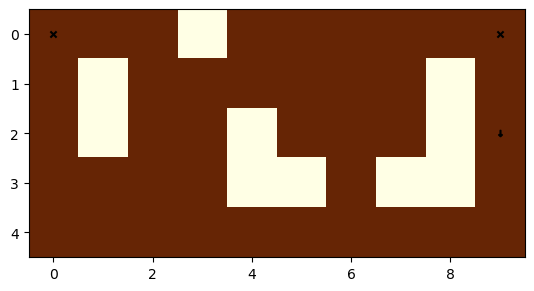

curr_reward 31.26756863920629
accumulated_reward 0
current Design
[(2, 9)]


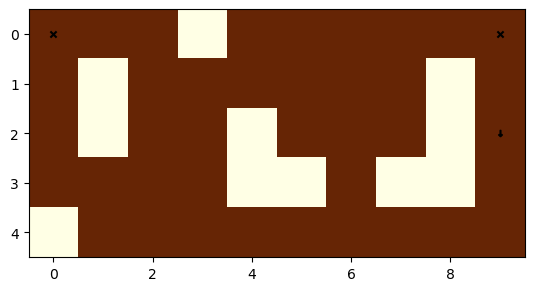

curr_reward 32.72627580164617
accumulated_reward 0
current Design
[(2, 9)]


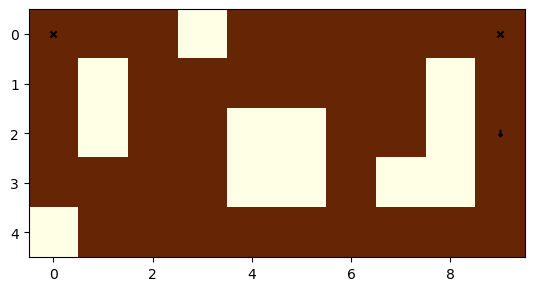

curr_reward 34.30693023635892
accumulated_reward 0
current Design
[(2, 9)]


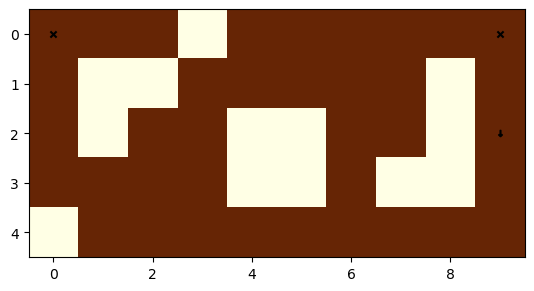

curr_reward 36.68764059811879
accumulated_reward 0
current Design
[(2, 9)]


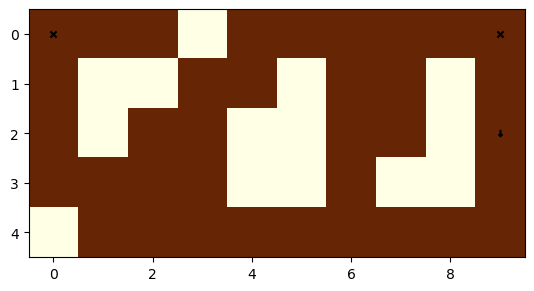

curr_reward 37.63975041127192
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2630000
Best mean reward: 166.16 - Last mean reward per episode: 52.15
current Design
[(0, 7)]


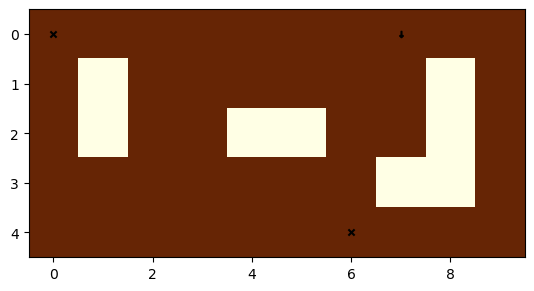

hello hello
--------------------------------------------------
Num timesteps: 2640000
Best mean reward: 166.16 - Last mean reward per episode: 62.82
current Design
[(3, 0)]


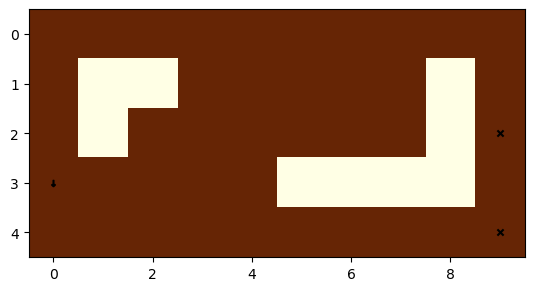

hello hello
--------------------------------------------------
Num timesteps: 2650000
Best mean reward: 166.16 - Last mean reward per episode: 0.89
current Design
[(4, 8)]


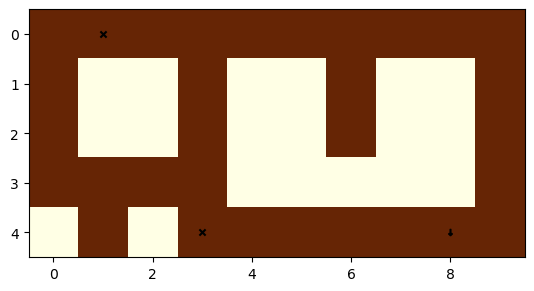

hello hello
--------------------------------------------------
Num timesteps: 2660000
Best mean reward: 166.16 - Last mean reward per episode: 20.24
current Design
[(4, 9)]


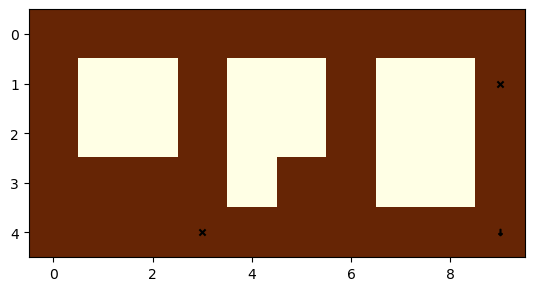

hello hello
--------------------------------------------------
Num timesteps: 2670000
Best mean reward: 166.16 - Last mean reward per episode: 44.42
current Design
[(4, 3)]


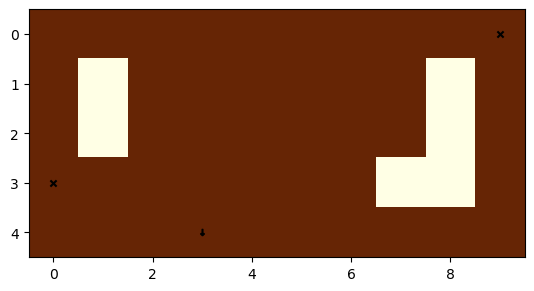

hello hello
--------------------------------------------------
Num timesteps: 2680000
Best mean reward: 166.16 - Last mean reward per episode: 126.42
current Design
[(0, 9)]


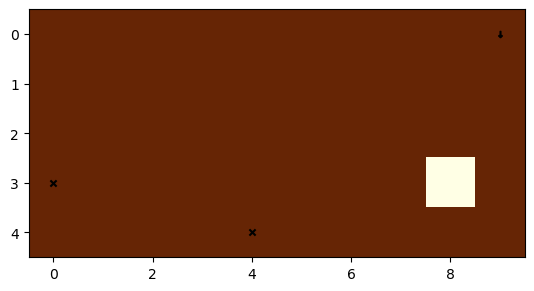

hello hello
--------------------------------------------------
Num timesteps: 2690000
Best mean reward: 166.16 - Last mean reward per episode: 41.61
current Design
[(4, 9)]


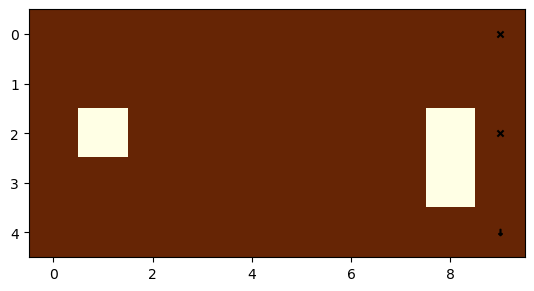

hello hello
--------------------------------------------------
Num timesteps: 2700000
Best mean reward: 166.16 - Last mean reward per episode: 50.67
current Design
[(3, 0)]


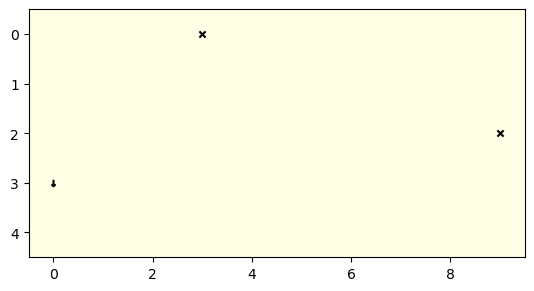

hello hello
--------------------------------------------------
Num timesteps: 2710000
Best mean reward: 166.16 - Last mean reward per episode: 35.76
current Design
[(2, 9)]


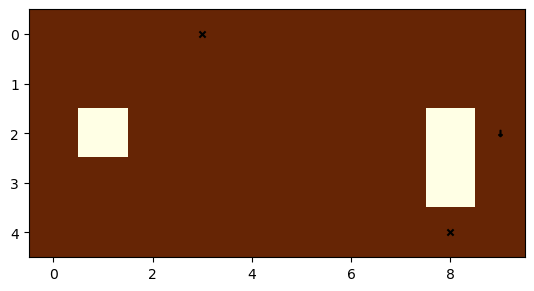

hello hello
--------------------------------------------------
Num timesteps: 2720000
Best mean reward: 166.16 - Last mean reward per episode: 15.74
current Design
[(0, 0)]


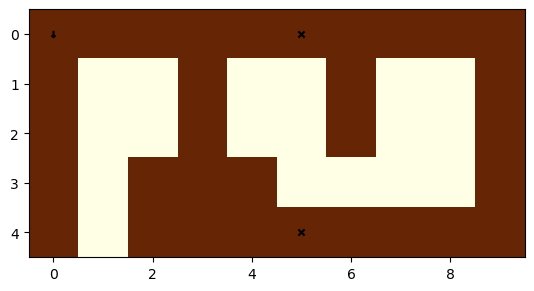

current Design
[(4, 8)]


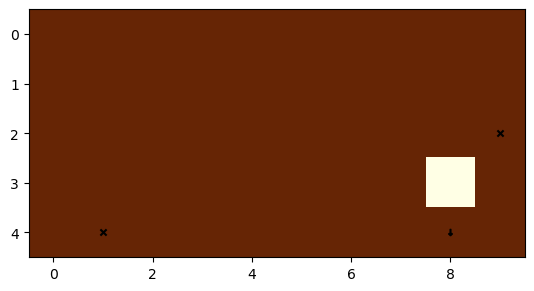

curr_reward 3.4663450366568087
accumulated_reward 0
current Design
[(4, 8)]


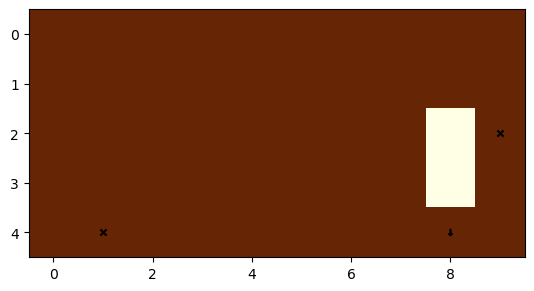

curr_reward 5.907710768737538
accumulated_reward 0
current Design
[(4, 8)]


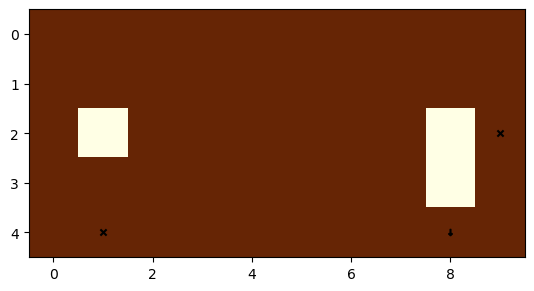

curr_reward 8.695435489927027
accumulated_reward 0
current Design
[(4, 8)]


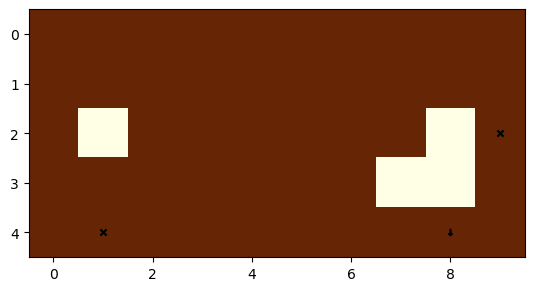

curr_reward 11.814665200452636
accumulated_reward 0
current Design
[(4, 8)]


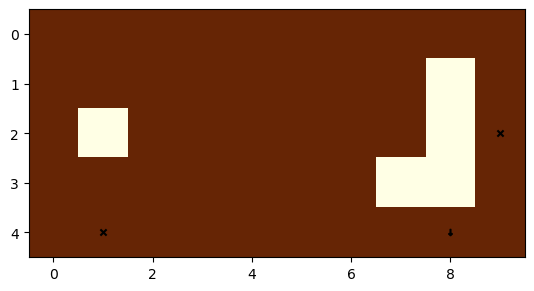

curr_reward 13.430509926453494
accumulated_reward 0
current Design
[(4, 8)]


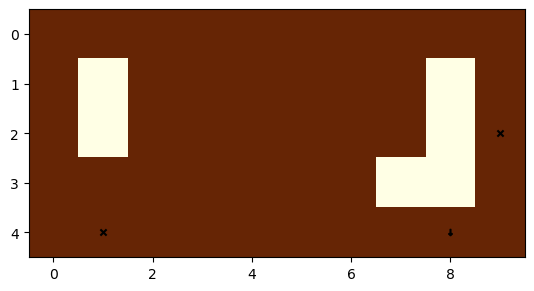

curr_reward 15.627117844566003
accumulated_reward 0
current Design
[(4, 8)]


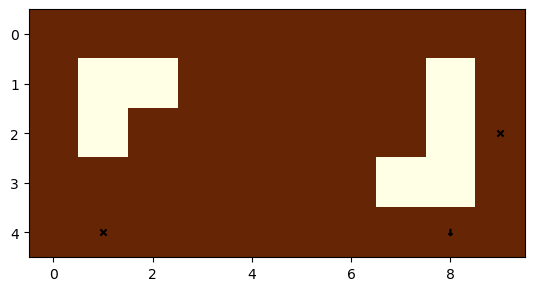

curr_reward 17.547218771264195
accumulated_reward 0
current Design
[(4, 8)]


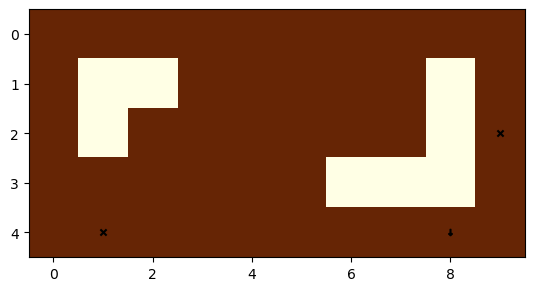

curr_reward 20.206136282961186
accumulated_reward 0
current Design
[(4, 8)]


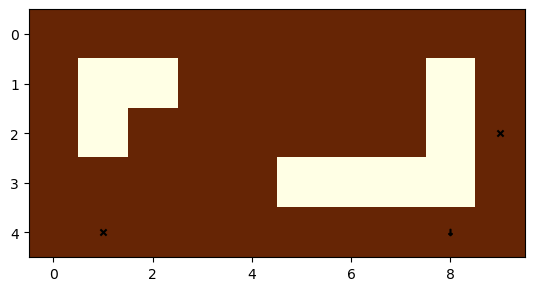

curr_reward 22.31880965840721
accumulated_reward 0
current Design
[(4, 8)]


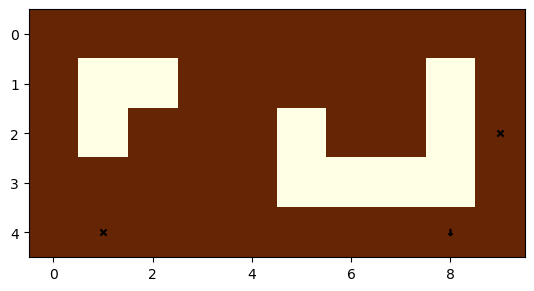

curr_reward 23.655228307099176
accumulated_reward 0
current Design
[(4, 8)]


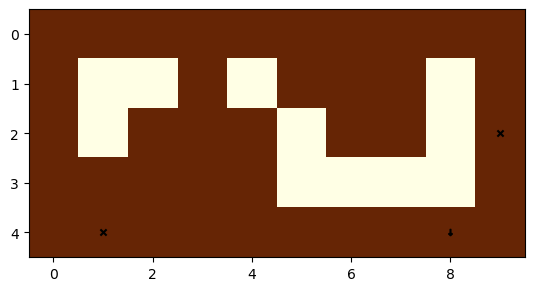

curr_reward 24.460275549137027
accumulated_reward 0
current Design
[(4, 8)]


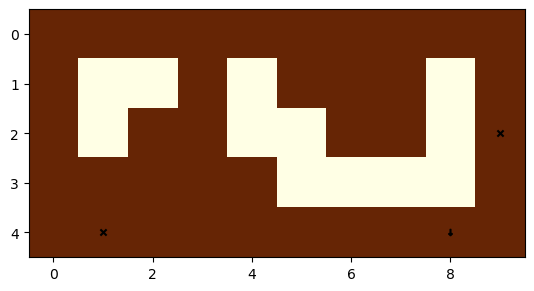

curr_reward 24.80819830941565
accumulated_reward 0
current Design
[(4, 8)]


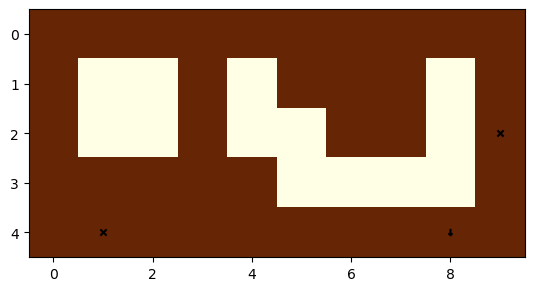

curr_reward 25.52453642572036
accumulated_reward 0
current Design
[(4, 8)]


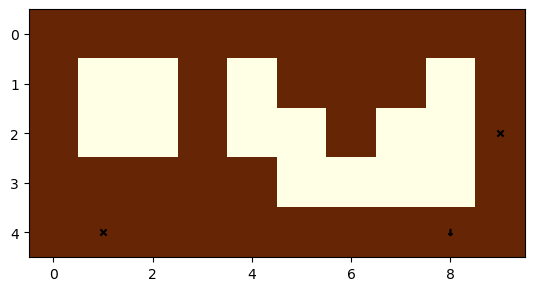

curr_reward 25.957296798072004
accumulated_reward 0
current Design
[(4, 8)]


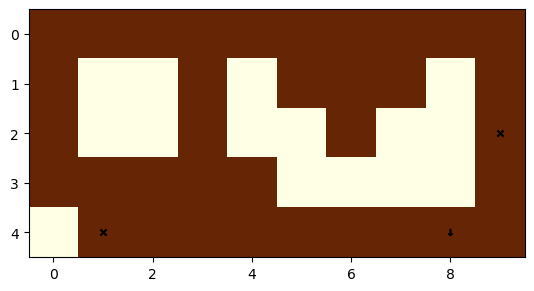

curr_reward 26.207788353674545
accumulated_reward 0
current Design
[(4, 8)]


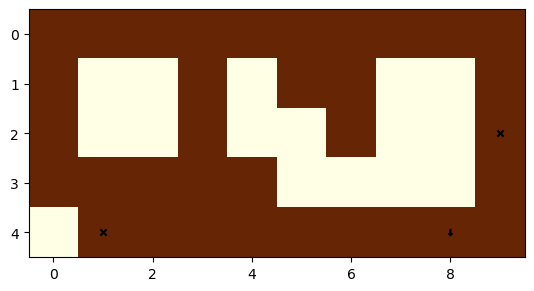

curr_reward 26.201145730631254
accumulated_reward 0
current Design
[(4, 8)]


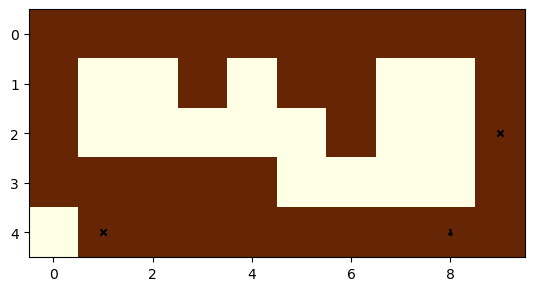

curr_reward 24.422764590645386
accumulated_reward 0
current Design
[(4, 8)]


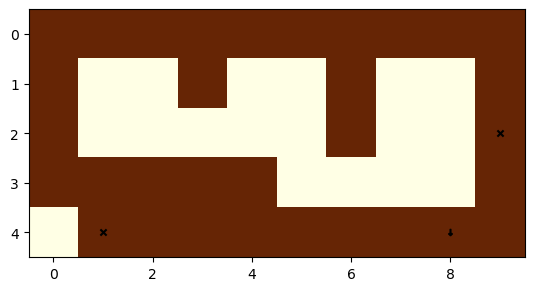

curr_reward 24.310661902938524
accumulated_reward 0
current Design
[(4, 8)]


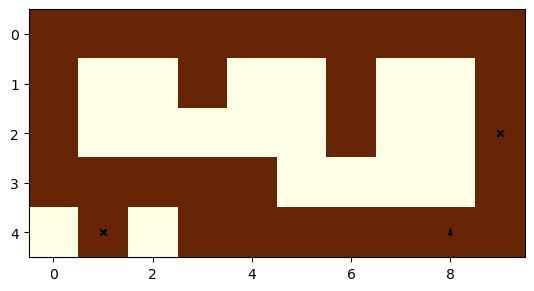

curr_reward 25.59064167666781
accumulated_reward 0
current Design
[(4, 8)]


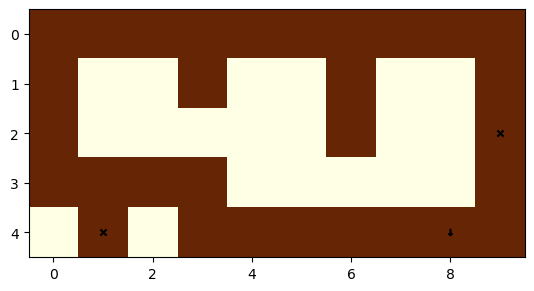

curr_reward 26.310743047892068
accumulated_reward 0
current Design
[(4, 8)]


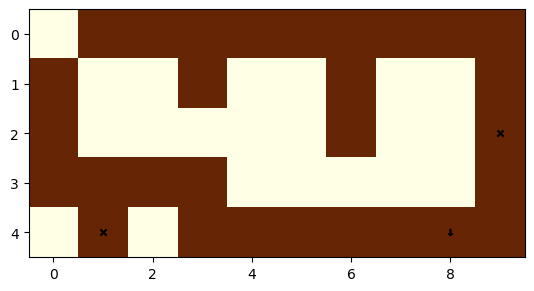

curr_reward 25.788568768031876
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2730000
Best mean reward: 166.16 - Last mean reward per episode: 78.16
current Design
[(0, 3)]


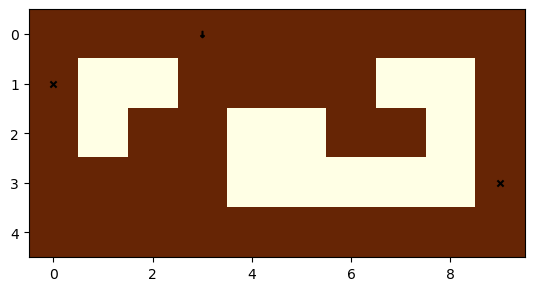

hello hello
--------------------------------------------------
Num timesteps: 2740000
Best mean reward: 166.16 - Last mean reward per episode: 100.92
current Design
[(2, 9)]


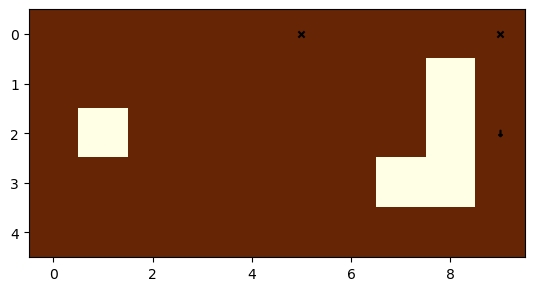

hello hello
--------------------------------------------------
Num timesteps: 2750000
Best mean reward: 166.16 - Last mean reward per episode: -2.53
current Design
[(4, 9)]


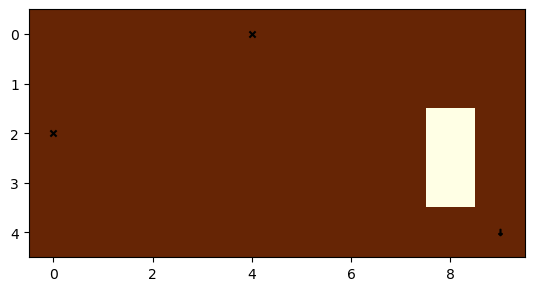

hello hello
--------------------------------------------------
Num timesteps: 2760000
Best mean reward: 166.16 - Last mean reward per episode: 61.57
current Design
[(0, 8)]


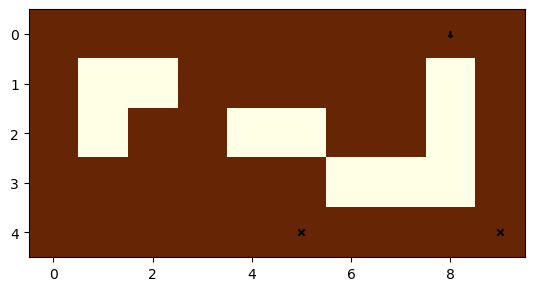

hello hello
--------------------------------------------------
Num timesteps: 2770000
Best mean reward: 166.16 - Last mean reward per episode: 69.18
current Design
[(0, 9)]


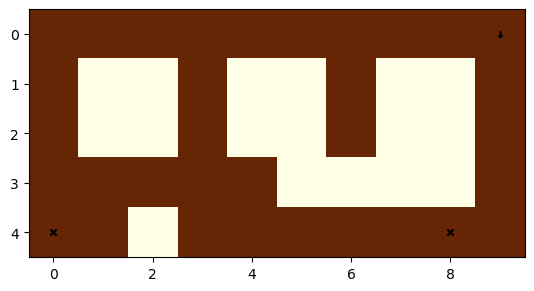

hello hello
--------------------------------------------------
Num timesteps: 2780000
Best mean reward: 166.16 - Last mean reward per episode: 123.59
current Design
[(4, 2)]


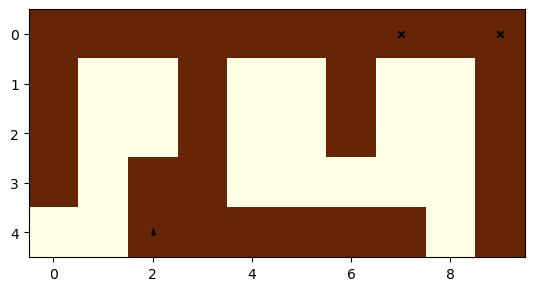

hello hello
--------------------------------------------------
Num timesteps: 2790000
Best mean reward: 166.16 - Last mean reward per episode: 54.48
current Design
[(4, 7)]


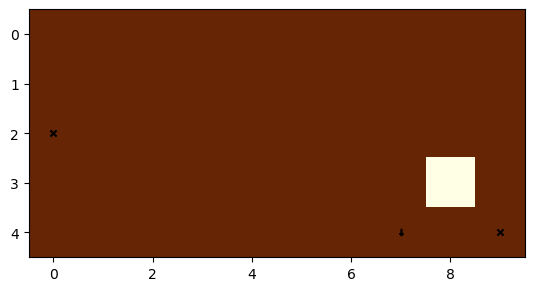

hello hello
--------------------------------------------------
Num timesteps: 2800000
Best mean reward: 166.16 - Last mean reward per episode: 110.35
current Design
[(1, 9)]


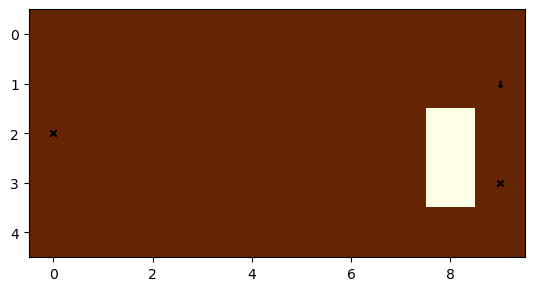

hello hello
--------------------------------------------------
Num timesteps: 2810000
Best mean reward: 166.16 - Last mean reward per episode: 55.91
current Design
[(4, 2)]


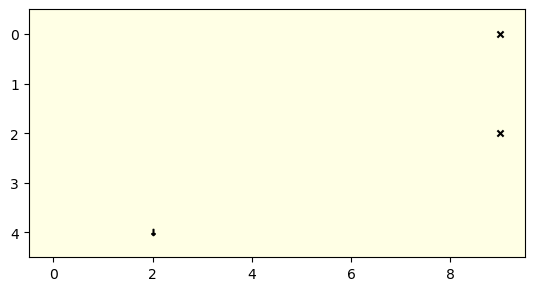

hello hello
--------------------------------------------------
Num timesteps: 2820000
Best mean reward: 166.16 - Last mean reward per episode: 59.17
current Design
[(4, 0)]


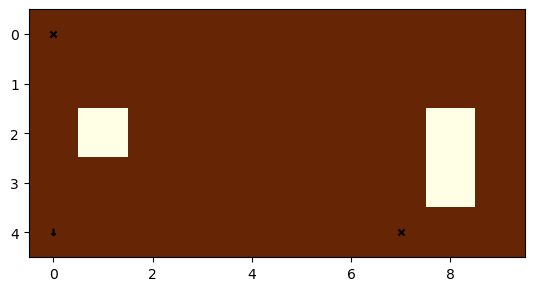

current Design
[(3, 0)]


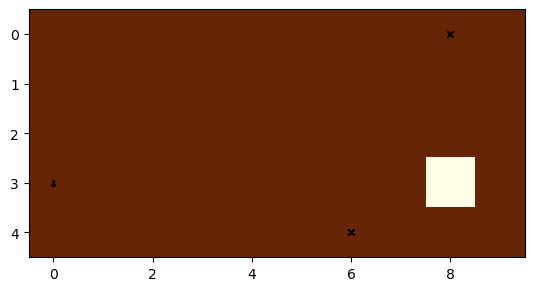

curr_reward 3.8560888402453273
accumulated_reward 0
current Design
[(3, 0)]


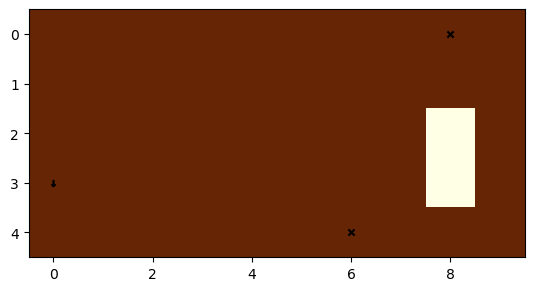

curr_reward 7.409174448593274
accumulated_reward 0
current Design
[(3, 0)]


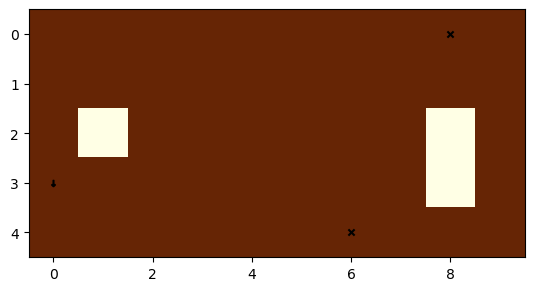

curr_reward 10.628970243768544
accumulated_reward 0
current Design
[(3, 0)]


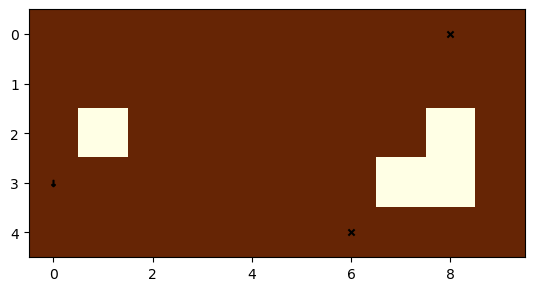

curr_reward 13.807527368914894
accumulated_reward 0
current Design
[(3, 0)]


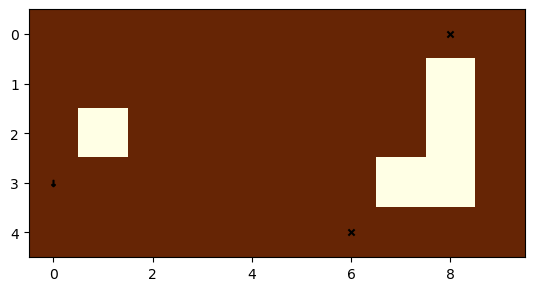

curr_reward 16.36982022159479
accumulated_reward 0
current Design
[(3, 0)]


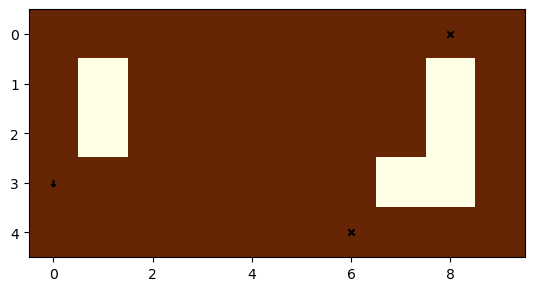

curr_reward 18.659486576545483
accumulated_reward 0
current Design
[(3, 0)]


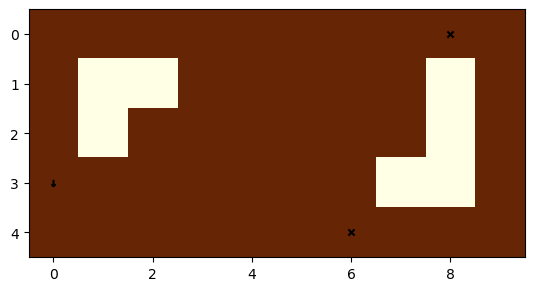

curr_reward 20.7461852988192
accumulated_reward 0
current Design
[(3, 0)]


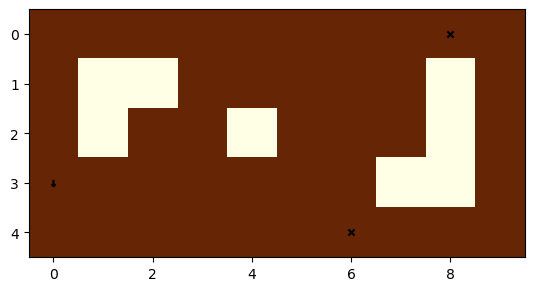

curr_reward 22.37632578681956
accumulated_reward 0
current Design
[(3, 0)]


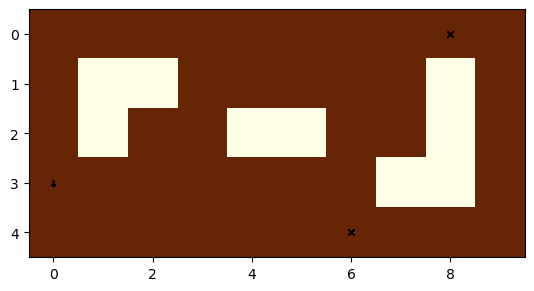

curr_reward 23.94212950065619
accumulated_reward 0
current Design
[(3, 0)]


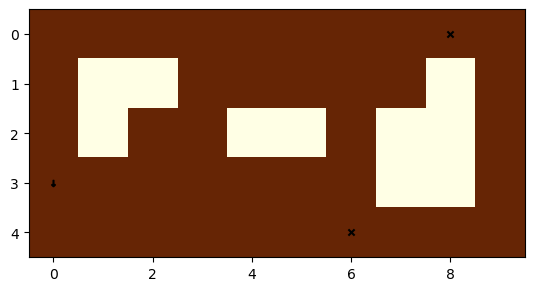

curr_reward 25.49966436835629
accumulated_reward 0
current Design
[(3, 0)]


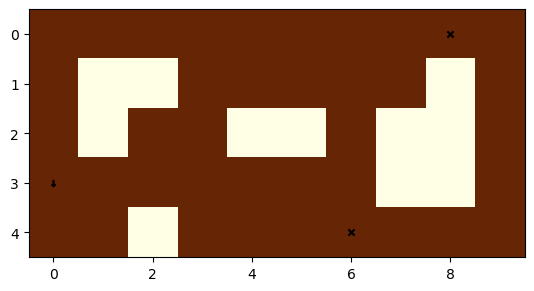

curr_reward 25.956422434726854
accumulated_reward 0
current Design
[(3, 0)]


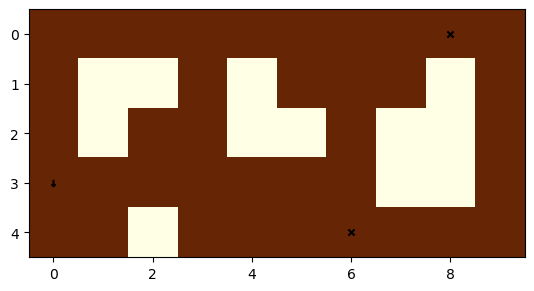

curr_reward 26.59831977308095
accumulated_reward 0
current Design
[(3, 0)]


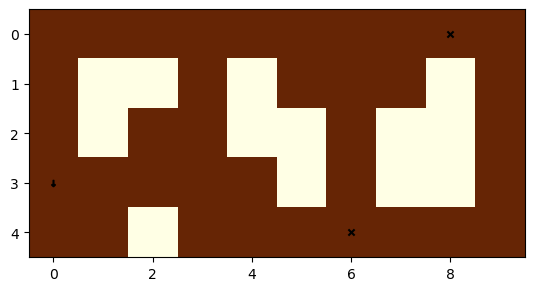

curr_reward 26.899987856714645
accumulated_reward 0
current Design
[(3, 0)]


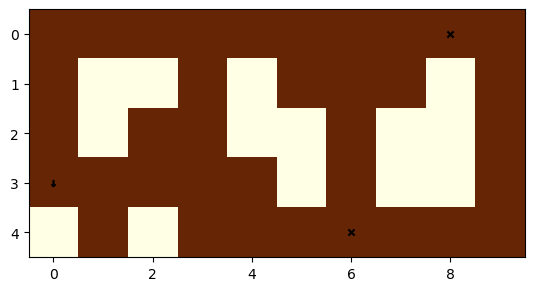

curr_reward 28.880757104855302
accumulated_reward 0
current Design
[(3, 0)]


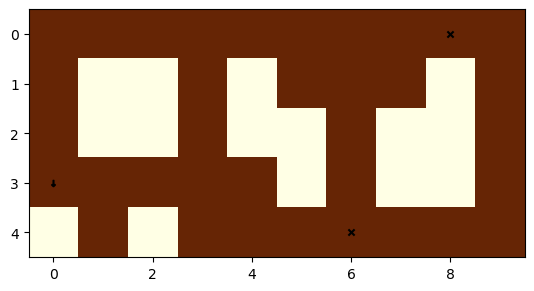

curr_reward 28.54502013503743
accumulated_reward 0
current Design
[(3, 0)]


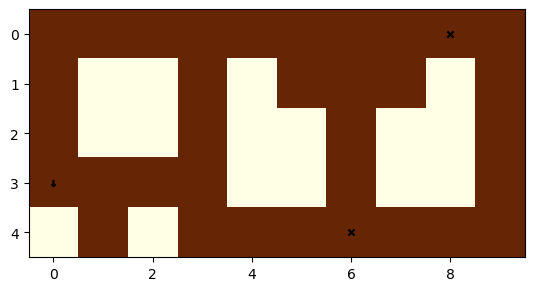

curr_reward 27.9654892741409
accumulated_reward 0
current Design
[(3, 0)]


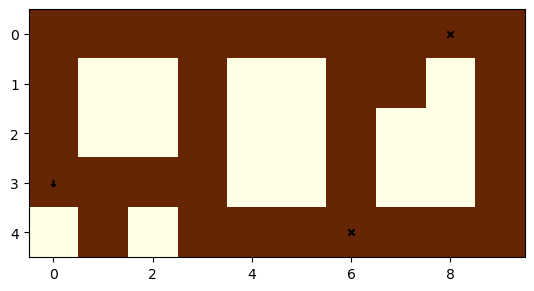

curr_reward 28.14458461363207
accumulated_reward 0
current Design
[(3, 0)]


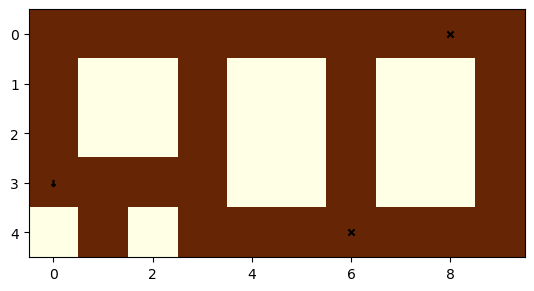

curr_reward 28.164292178285304
accumulated_reward 0
current Design
[(3, 0)]


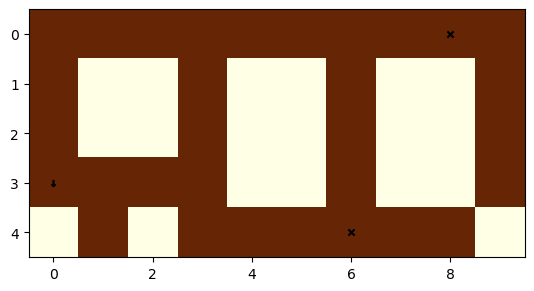

curr_reward 27.89994633698545
accumulated_reward 0
current Design
[(3, 0)]


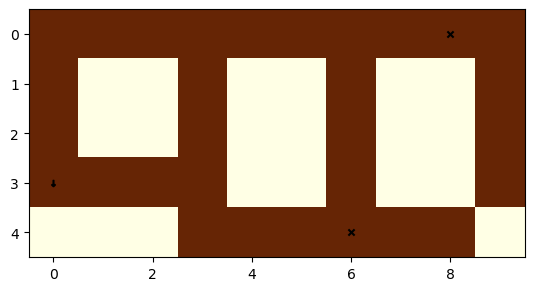

curr_reward 28.989165816699188
accumulated_reward 0
current Design
[(3, 0)]


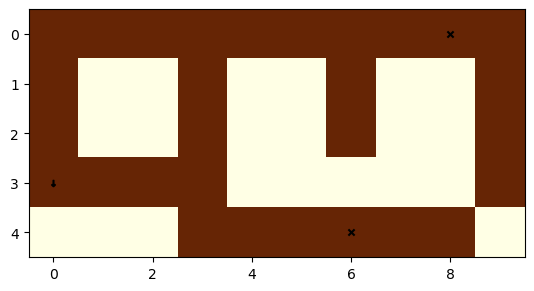

curr_reward 29.35897363034765
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2830000
Best mean reward: 166.16 - Last mean reward per episode: 4.09
current Design
[(4, 5)]


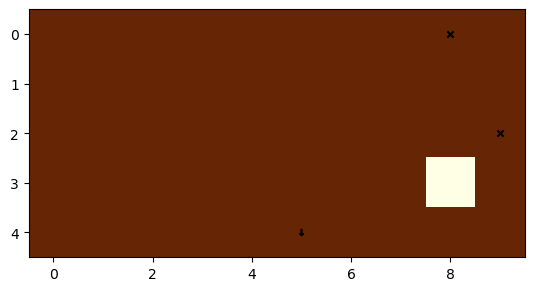

hello hello
--------------------------------------------------
Num timesteps: 2840000
Best mean reward: 166.16 - Last mean reward per episode: 35.32
current Design
[(0, 6)]


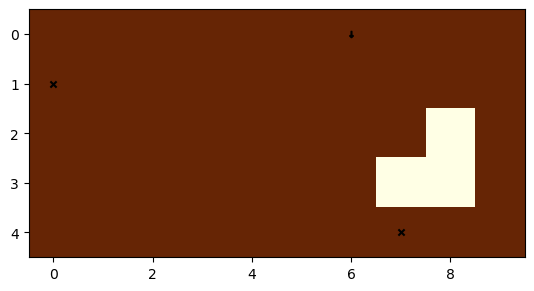

hello hello
--------------------------------------------------
Num timesteps: 2850000
Best mean reward: 166.16 - Last mean reward per episode: 14.54
current Design
[(1, 9)]


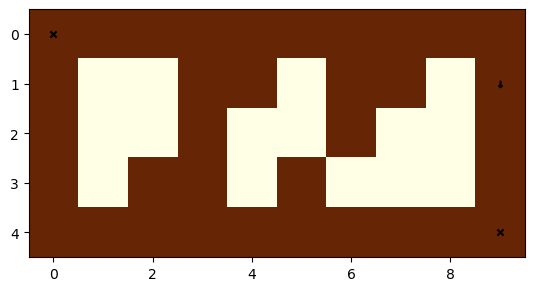

hello hello
--------------------------------------------------
Num timesteps: 2860000
Best mean reward: 166.16 - Last mean reward per episode: 106.36
current Design
[(3, 0)]


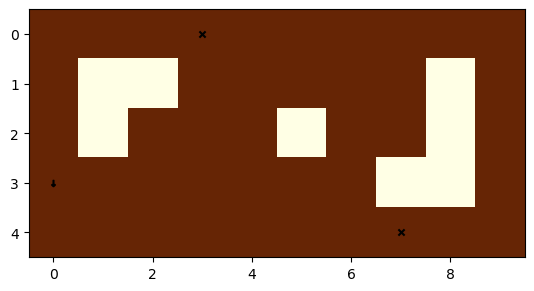

hello hello
--------------------------------------------------
Num timesteps: 2870000
Best mean reward: 166.16 - Last mean reward per episode: 60.53
current Design
[(4, 4)]


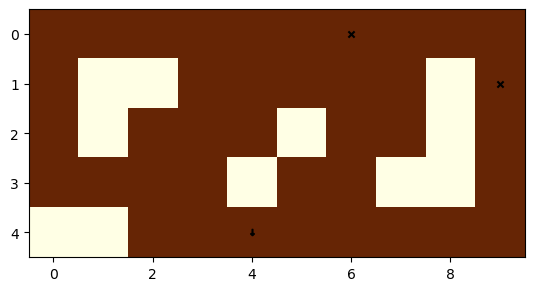

hello hello
--------------------------------------------------
Num timesteps: 2880000
Best mean reward: 166.16 - Last mean reward per episode: 36.15
current Design
[(2, 9)]


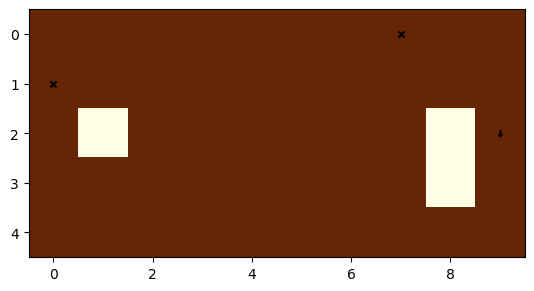

hello hello
--------------------------------------------------
Num timesteps: 2890000
Best mean reward: 166.16 - Last mean reward per episode: 53.71
current Design
[(4, 0)]


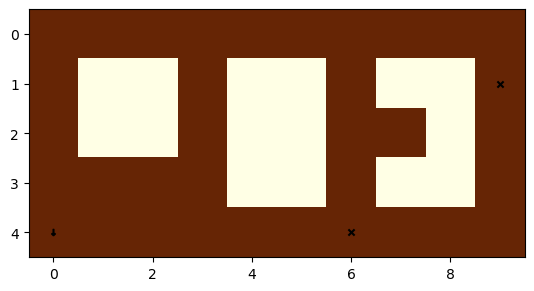

hello hello
--------------------------------------------------
Num timesteps: 2900000
Best mean reward: 166.16 - Last mean reward per episode: 108.35
current Design
[(1, 0)]


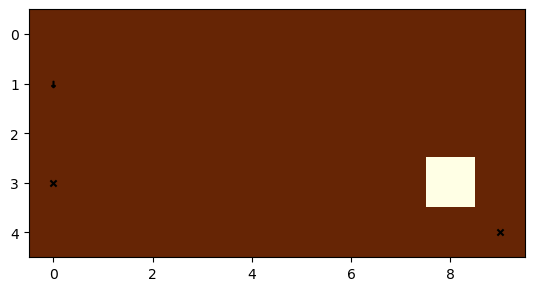

hello hello
--------------------------------------------------
Num timesteps: 2910000
Best mean reward: 166.16 - Last mean reward per episode: 31.39
current Design
[(4, 1)]


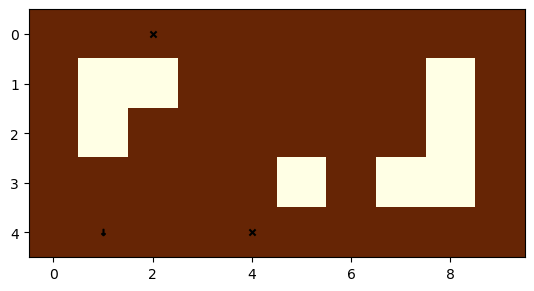

hello hello
--------------------------------------------------
Num timesteps: 2920000
Best mean reward: 166.16 - Last mean reward per episode: 44.96
current Design
[(0, 1)]


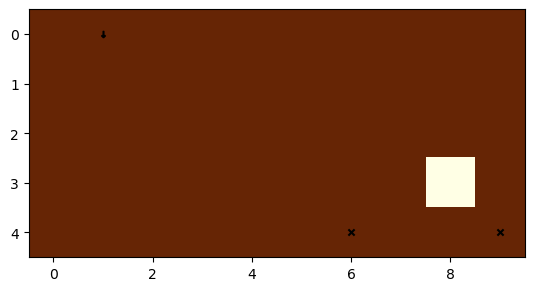

current Design
[(0, 3)]


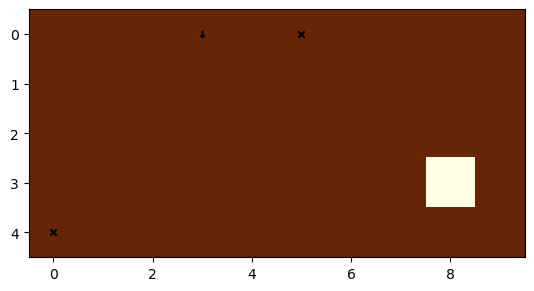

curr_reward 3.8134608549363147
accumulated_reward 0
current Design
[(0, 3)]


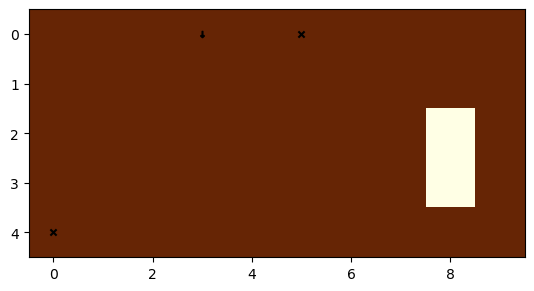

curr_reward 7.280259686690384
accumulated_reward 0
current Design
[(0, 3)]


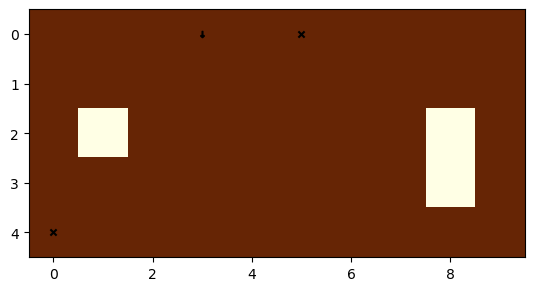

curr_reward 10.381383343074134
accumulated_reward 0
current Design
[(0, 3)]


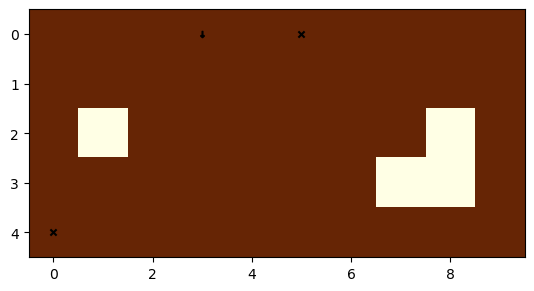

curr_reward 13.23272436601902
accumulated_reward 0
current Design
[(0, 3)]


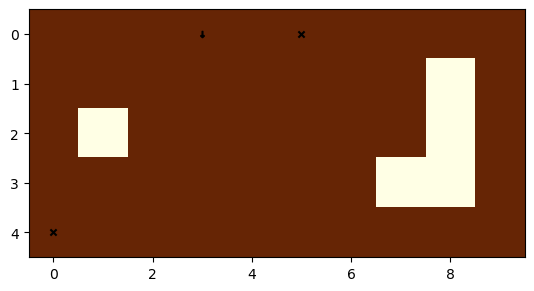

curr_reward 15.863531762835203
accumulated_reward 0
current Design
[(0, 3)]


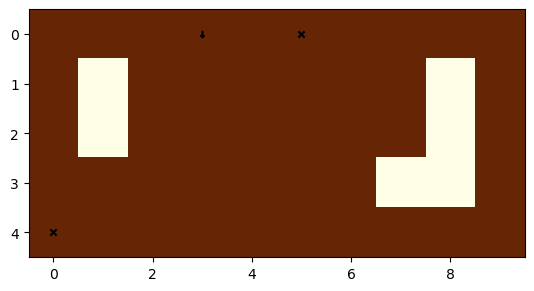

curr_reward 17.992761362747093
accumulated_reward 0
current Design
[(0, 3)]


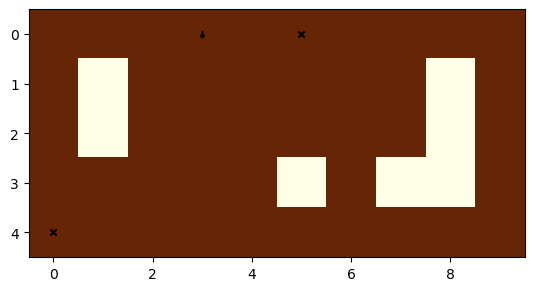

curr_reward 20.767262343030346
accumulated_reward 0
current Design
[(0, 3)]


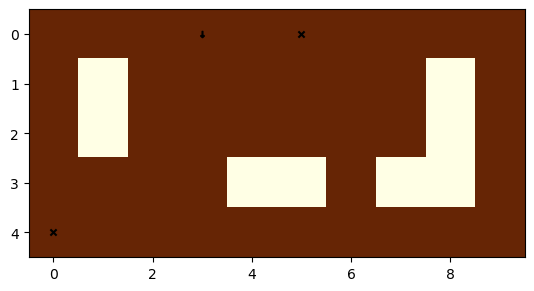

curr_reward 22.960457800506788
accumulated_reward 0
current Design
[(0, 3)]


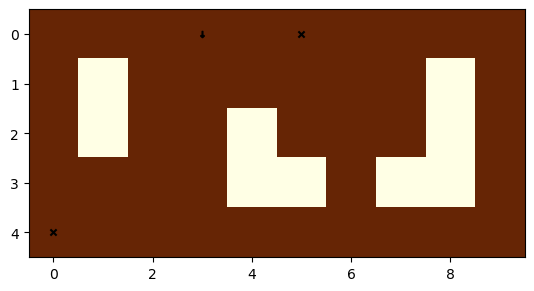

curr_reward 26.061651405034198
accumulated_reward 0
current Design
[(0, 3)]


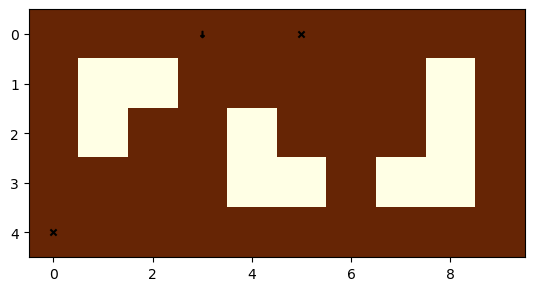

curr_reward 26.91443286019091
accumulated_reward 0
current Design
[(0, 3)]


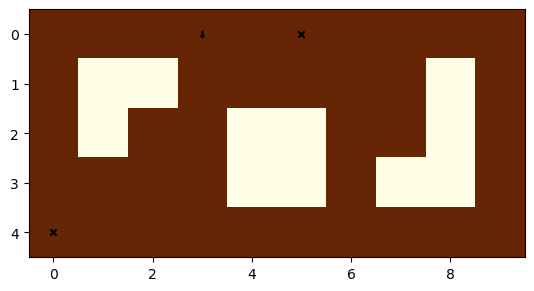

curr_reward 30.02882645843948
accumulated_reward 0
current Design
[(0, 3)]


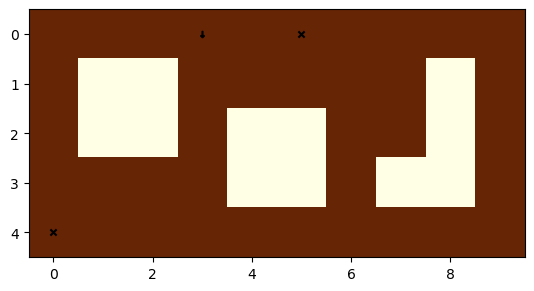

curr_reward 30.425009300922266
accumulated_reward 0
current Design
[(0, 3)]


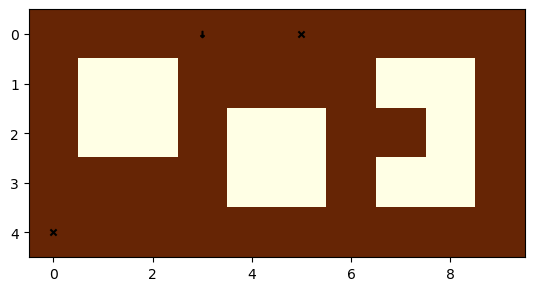

curr_reward 31.159550699608843
accumulated_reward 0
current Design
[(0, 3)]


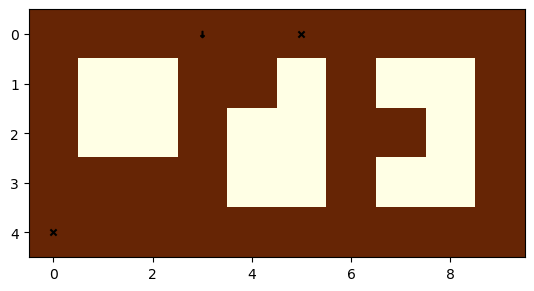

curr_reward 27.92056896396597
accumulated_reward 0
current Design
[(0, 3)]


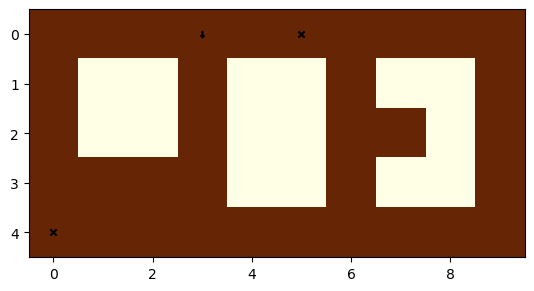

curr_reward 37.708235540822365
accumulated_reward 0
current Design
[(0, 3)]


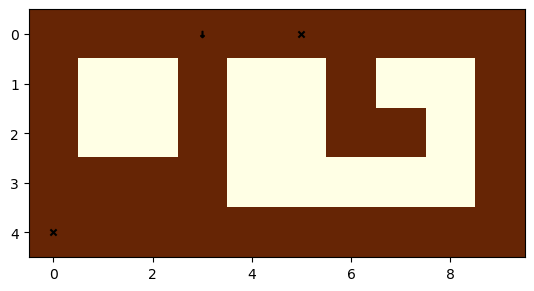

curr_reward 38.42875416398764
accumulated_reward 0
current Design
[(0, 3)]


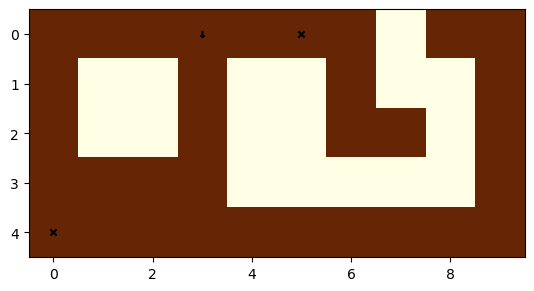

curr_reward 38.8843066444371
accumulated_reward 0
current Design
[(0, 3)]


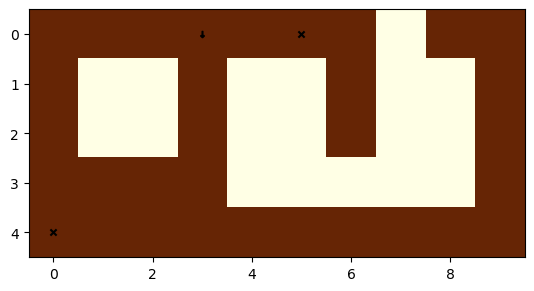

curr_reward 38.714175988233706
accumulated_reward 0
current Design
[(0, 3)]


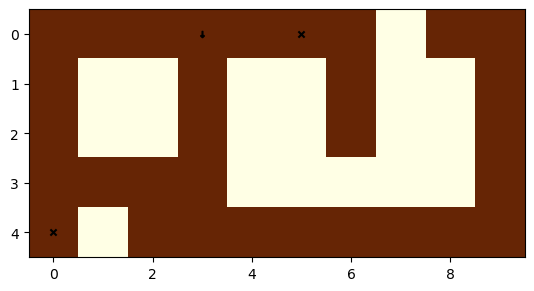

curr_reward 35.85134281153049
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 2930000
Best mean reward: 166.16 - Last mean reward per episode: 156.20
current Design
[(0, 0)]


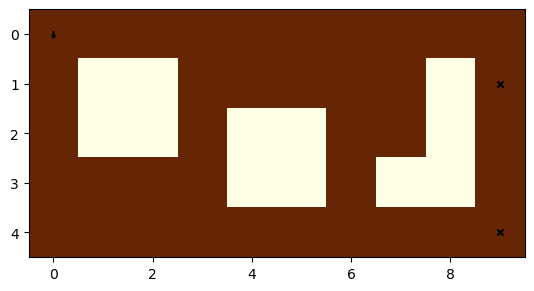

hello hello
--------------------------------------------------
Num timesteps: 2940000
Best mean reward: 166.16 - Last mean reward per episode: 129.62
current Design
[(0, 0)]


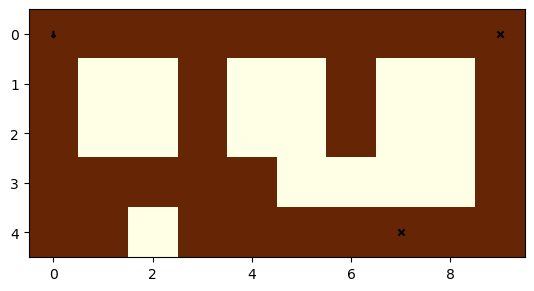

hello hello
--------------------------------------------------
Num timesteps: 2950000
Best mean reward: 166.16 - Last mean reward per episode: 135.07
current Design
[(3, 9)]


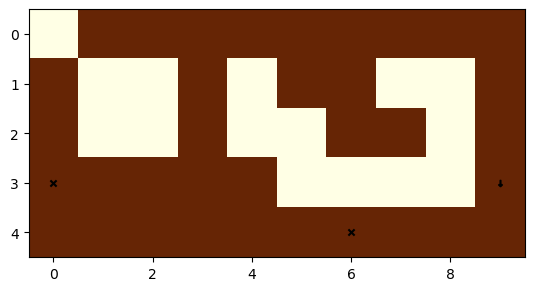

hello hello
--------------------------------------------------
Num timesteps: 2960000
Best mean reward: 166.16 - Last mean reward per episode: 31.36
current Design
[(0, 9)]


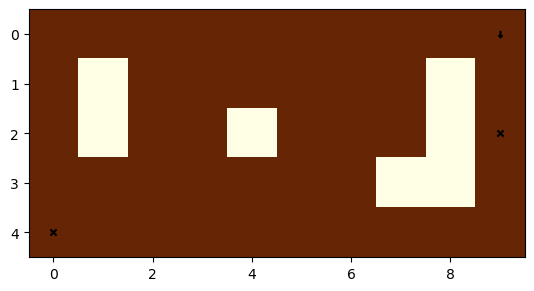

hello hello
--------------------------------------------------
Num timesteps: 2970000
Best mean reward: 166.16 - Last mean reward per episode: 40.73
current Design
[(2, 9)]


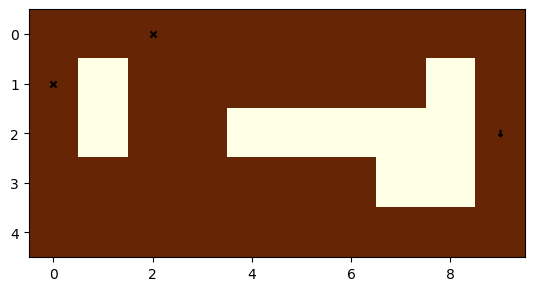

hello hello
--------------------------------------------------
Num timesteps: 2980000
Best mean reward: 166.16 - Last mean reward per episode: 22.89
current Design
[(4, 4)]


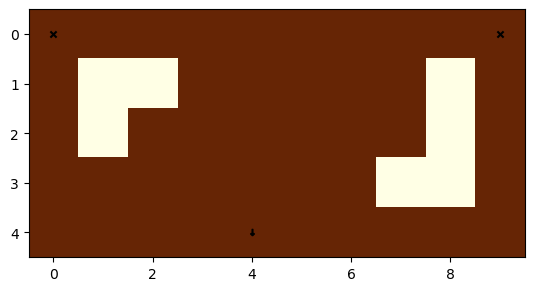

hello hello
--------------------------------------------------
Num timesteps: 2990000
Best mean reward: 166.16 - Last mean reward per episode: 97.88
current Design
[(3, 0)]


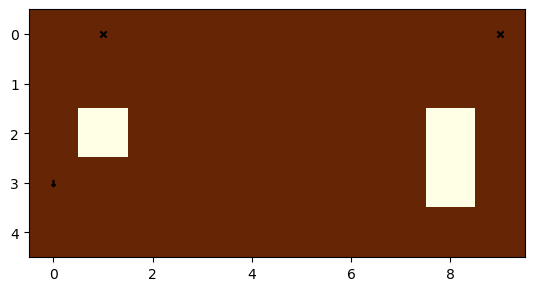

hello hello
--------------------------------------------------
Num timesteps: 3000000
Best mean reward: 166.16 - Last mean reward per episode: 76.97
current Design
[(4, 4)]


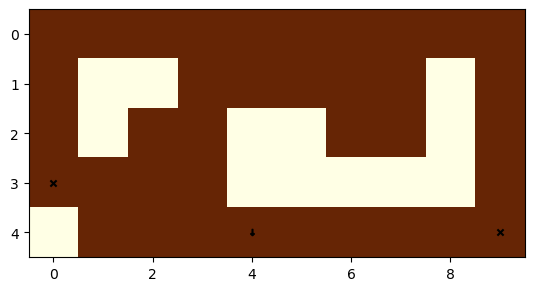

hello hello
--------------------------------------------------
Num timesteps: 3010000
Best mean reward: 166.16 - Last mean reward per episode: 39.43
current Design
[(4, 1)]


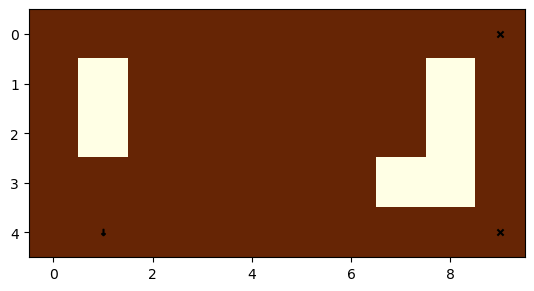

hello hello
--------------------------------------------------
Num timesteps: 3020000
Best mean reward: 166.16 - Last mean reward per episode: 95.97
current Design
[(4, 2)]


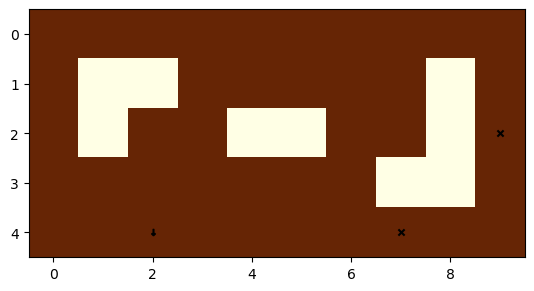

current Design
[(1, 9)]


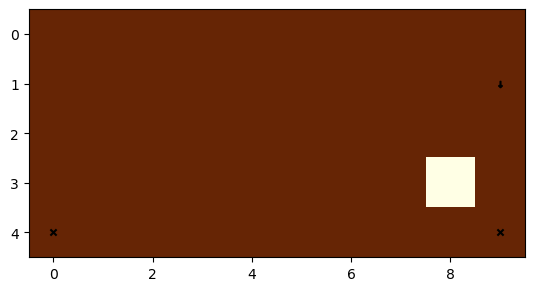

curr_reward 4.596984155072583
accumulated_reward 0
current Design
[(1, 9)]


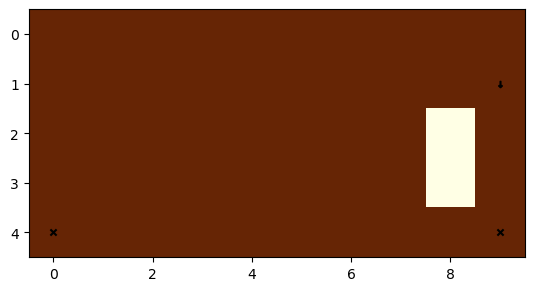

curr_reward 9.664141730253483
accumulated_reward 0
current Design
[(1, 9)]


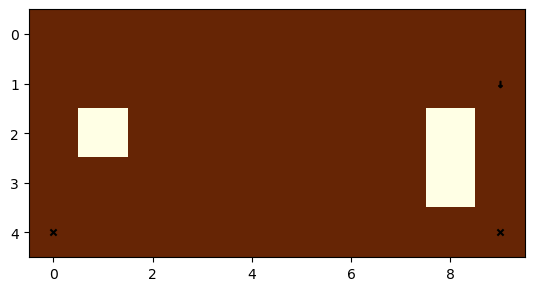

curr_reward 13.109965705288275
accumulated_reward 0
current Design
[(1, 9)]


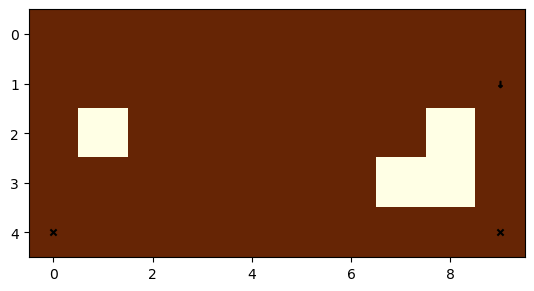

curr_reward 28.46412793689757
accumulated_reward 0
current Design
[(1, 9)]


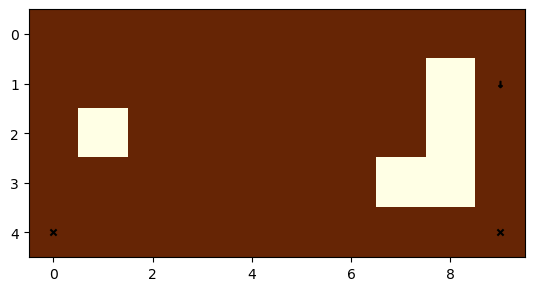

curr_reward 20.977056503099313
accumulated_reward 0
current Design
[(1, 9)]


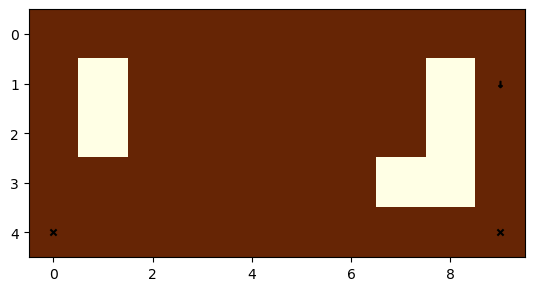

curr_reward 22.86911892419739
accumulated_reward 0
current Design
[(1, 9)]


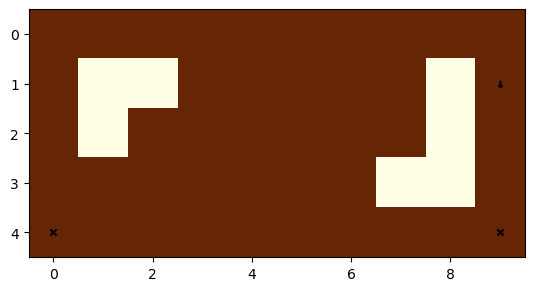

curr_reward 24.58275337774544
accumulated_reward 0
current Design
[(1, 9)]


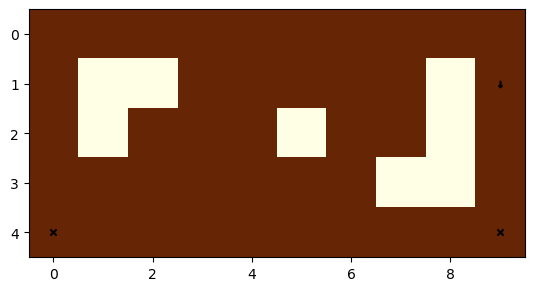

curr_reward 25.39108485396515
accumulated_reward 0
current Design
[(1, 9)]


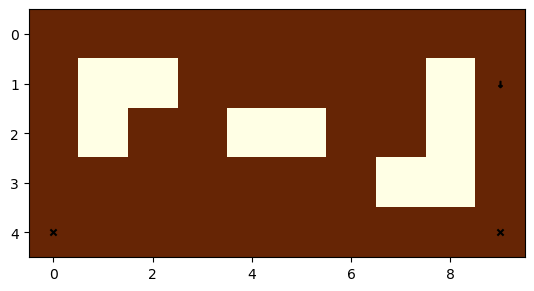

curr_reward 26.30864982516918
accumulated_reward 0
current Design
[(1, 9)]


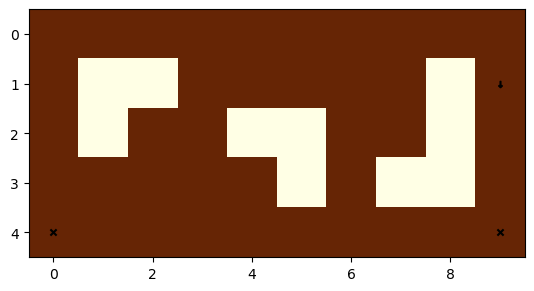

curr_reward 25.095888743877904
accumulated_reward 0
current Design
[(1, 9)]


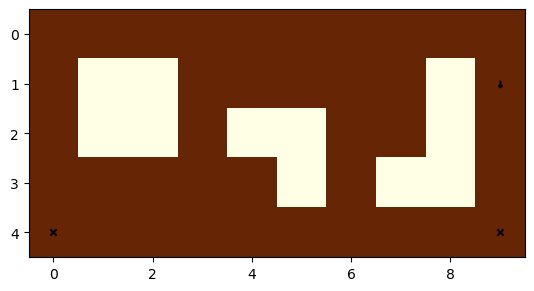

curr_reward 25.055443380805187
accumulated_reward 0
current Design
[(1, 9)]


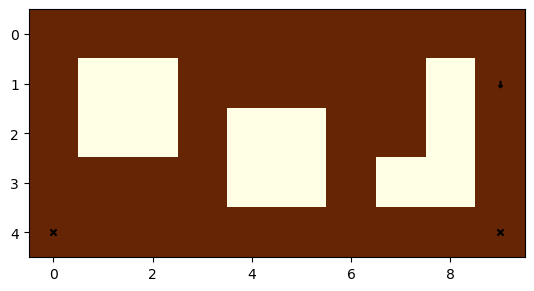

curr_reward 26.58846778786119
accumulated_reward 0
current Design
[(1, 9)]


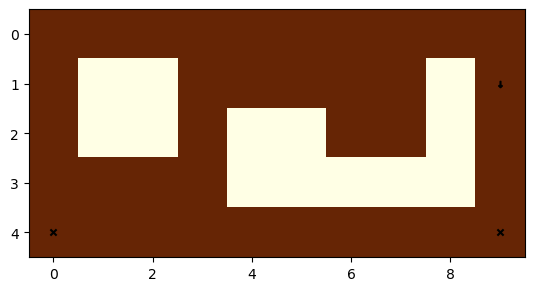

curr_reward 40.08155383745472
accumulated_reward 0
current Design
[(1, 9)]


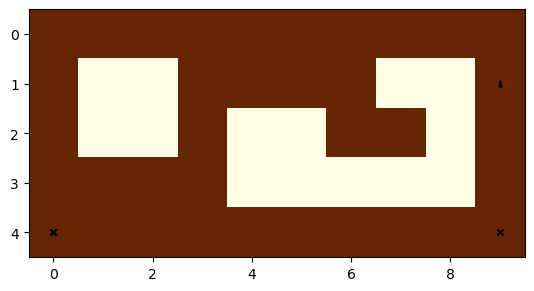

curr_reward 31.394398965095757
accumulated_reward 0
current Design
[(1, 9)]


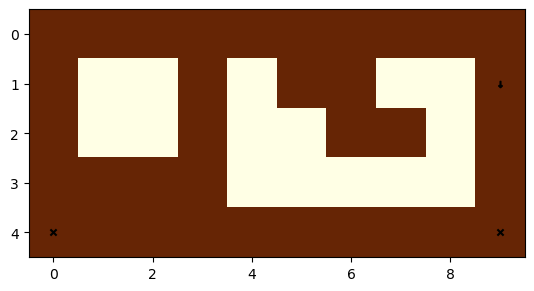

curr_reward 29.445928213299634
accumulated_reward 0
current Design
[(1, 9)]


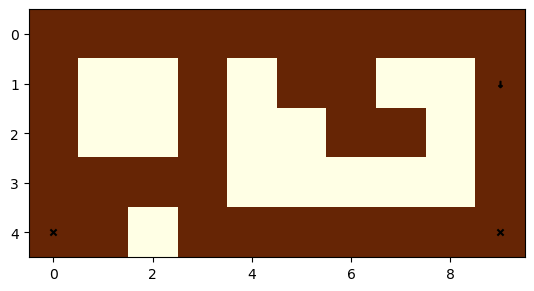

curr_reward 27.960837951233135
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 3030000
Best mean reward: 166.16 - Last mean reward per episode: 31.28
current Design
[(4, 9)]


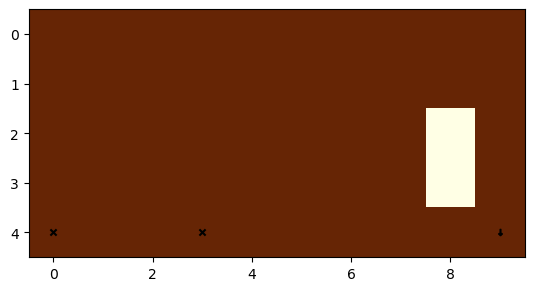

hello hello
--------------------------------------------------
Num timesteps: 3040000
Best mean reward: 166.16 - Last mean reward per episode: 74.87
current Design
[(0, 0)]


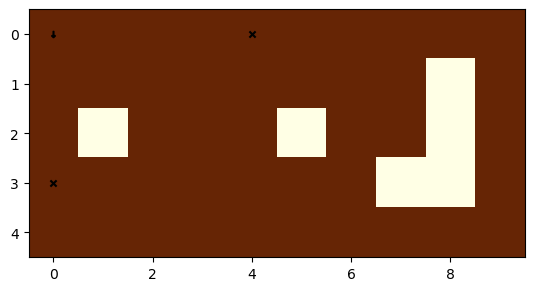

hello hello
--------------------------------------------------
Num timesteps: 3050000
Best mean reward: 166.16 - Last mean reward per episode: 31.23
current Design
[(4, 0)]


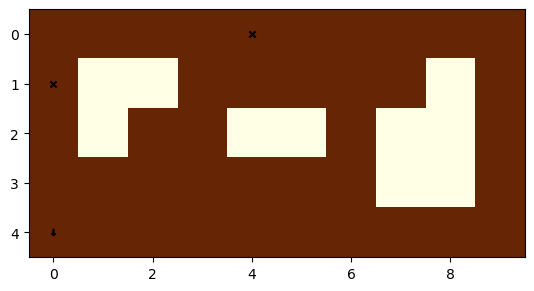

hello hello
--------------------------------------------------
Num timesteps: 3060000
Best mean reward: 166.16 - Last mean reward per episode: 60.56
current Design
[(4, 5)]


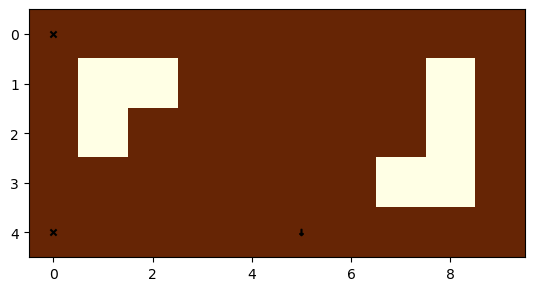

hello hello
--------------------------------------------------
Num timesteps: 3070000
Best mean reward: 166.16 - Last mean reward per episode: 61.36
current Design
[(0, 9)]


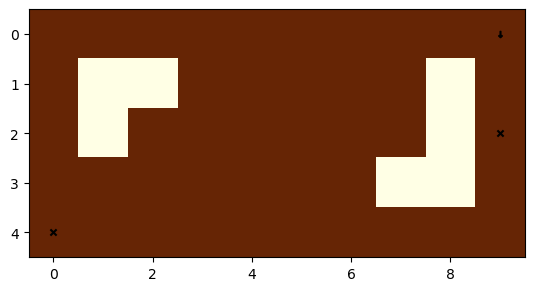

hello hello
--------------------------------------------------
Num timesteps: 3080000
Best mean reward: 166.16 - Last mean reward per episode: 75.74
current Design
[(2, 9)]


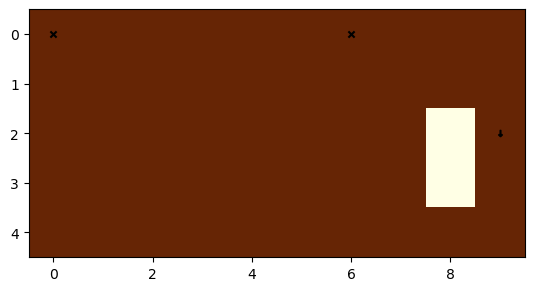

hello hello
--------------------------------------------------
Num timesteps: 3090000
Best mean reward: 166.16 - Last mean reward per episode: 49.63
current Design
[(0, 6)]


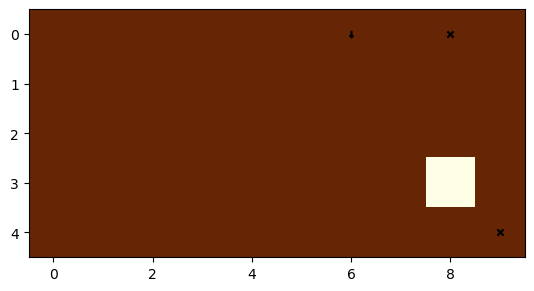

hello hello
--------------------------------------------------
Num timesteps: 3100000
Best mean reward: 166.16 - Last mean reward per episode: 21.50
current Design
[(0, 2)]


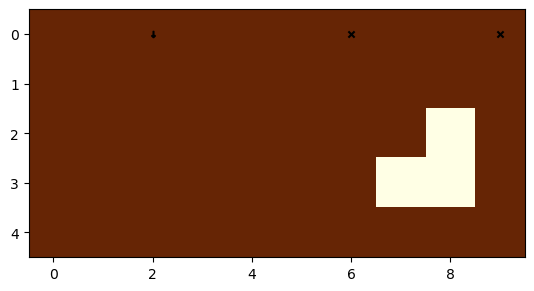

hello hello
--------------------------------------------------
Num timesteps: 3110000
Best mean reward: 166.16 - Last mean reward per episode: 81.32
current Design
[(0, 1)]


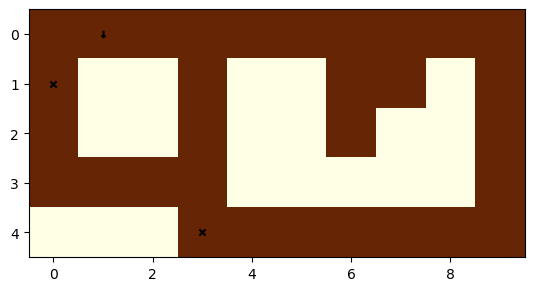

hello hello
--------------------------------------------------
Num timesteps: 3120000
Best mean reward: 166.16 - Last mean reward per episode: 56.58
current Design
[(0, 0)]


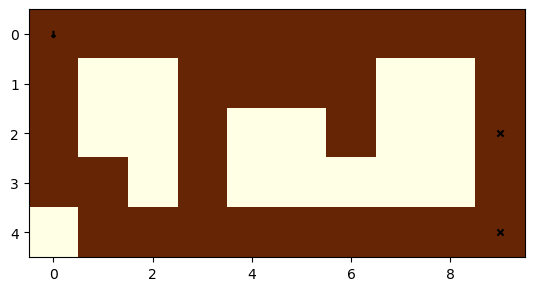

current Design
[(2, 0)]


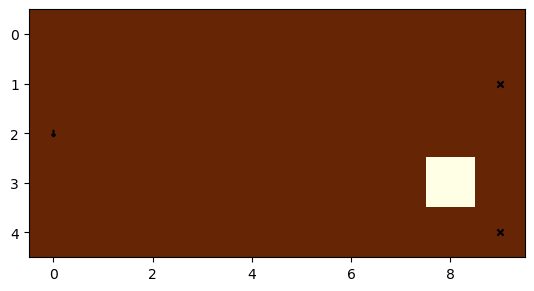

curr_reward 3.893520749116937
accumulated_reward 0
current Design
[(2, 0)]


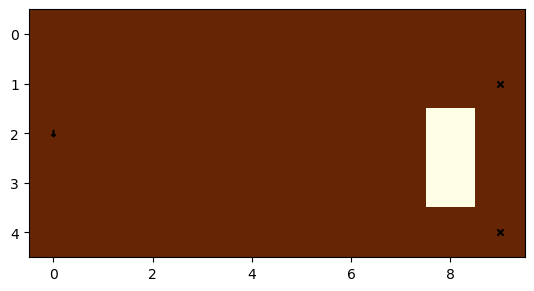

curr_reward 7.556712979004089
accumulated_reward 0
current Design
[(2, 0)]


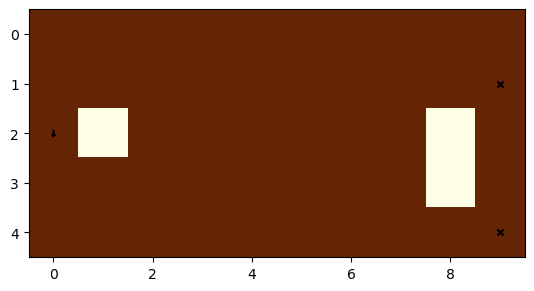

curr_reward 10.962189201133224
accumulated_reward 0
current Design
[(2, 0)]


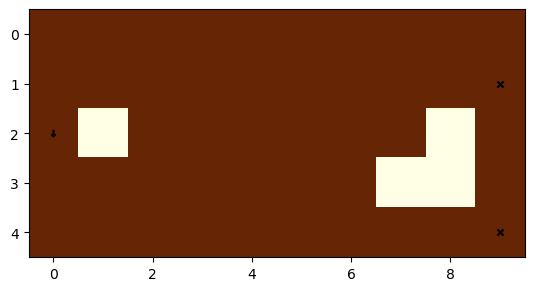

curr_reward 14.399826287160161
accumulated_reward 0
current Design
[(2, 0)]


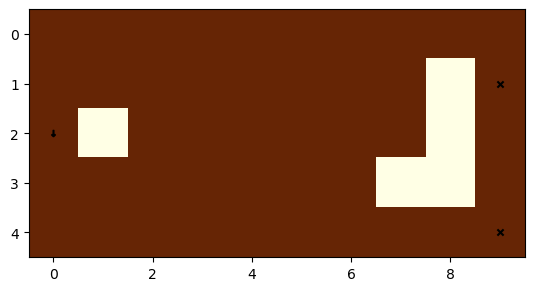

curr_reward 16.728512333247885
accumulated_reward 0
current Design
[(2, 0)]


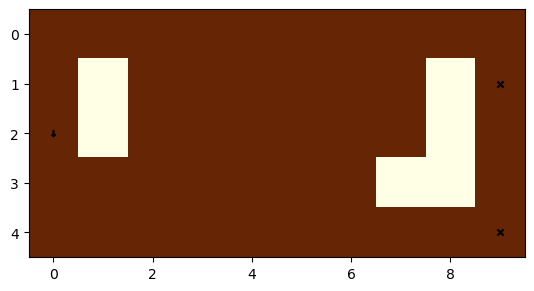

curr_reward 18.98579035232015
accumulated_reward 0
current Design
[(2, 0)]


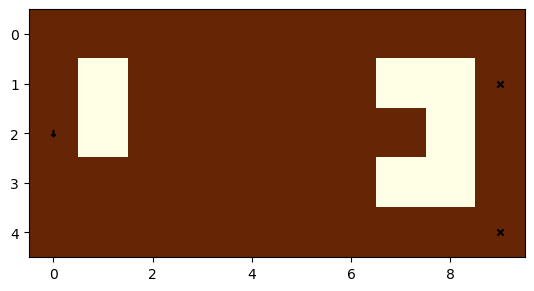

curr_reward 21.047789704645837
accumulated_reward 0
current Design
[(2, 0)]


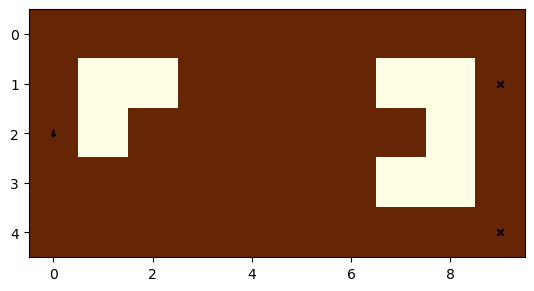

curr_reward 23.011548347697772
accumulated_reward 0
current Design
[(2, 0)]


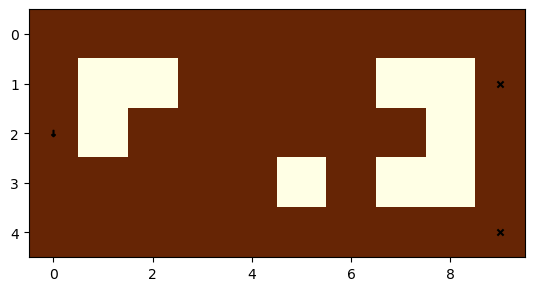

curr_reward 24.85117234052776
accumulated_reward 0
current Design
[(2, 0)]


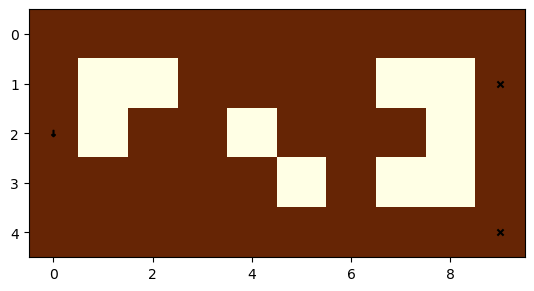

curr_reward 26.561098428274324
accumulated_reward 0
current Design
[(2, 0)]


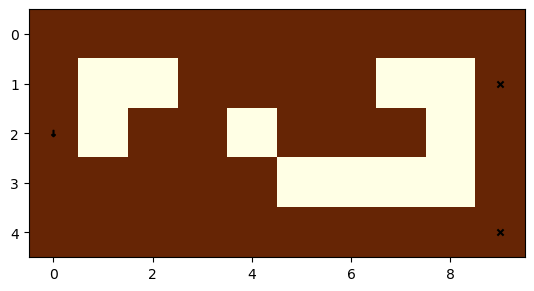

curr_reward 28.10078765482988
accumulated_reward 0
current Design
[(2, 0)]


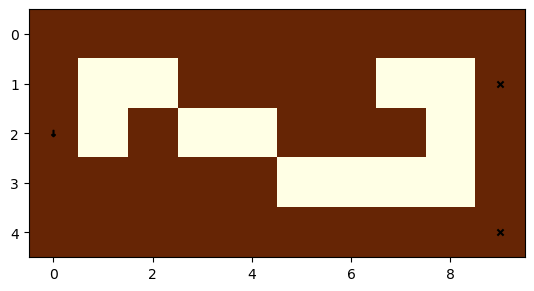

curr_reward 29.13826487488218
accumulated_reward 0
current Design
[(2, 0)]


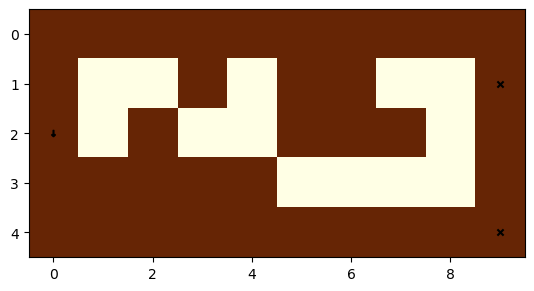

curr_reward 29.525125047547583
accumulated_reward 0
current Design
[(2, 0)]


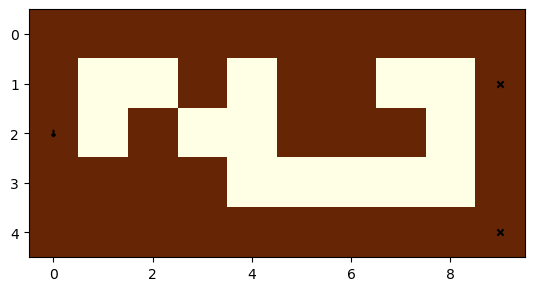

curr_reward 29.420403681073417
accumulated_reward 0
current Design
[(2, 0)]


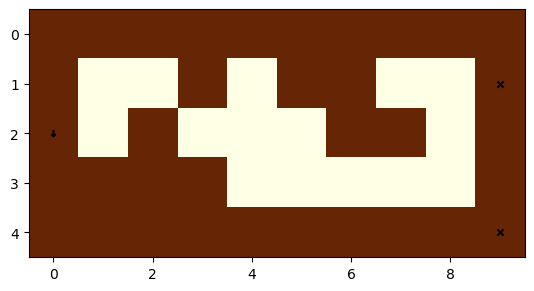

curr_reward 29.952837694149046
accumulated_reward 0
current Design
[(2, 0)]


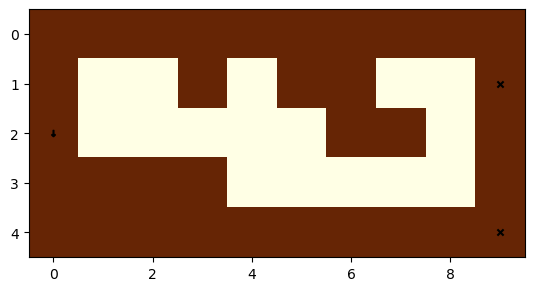

curr_reward 29.09677609270761
accumulated_reward 0
current Design
[(2, 0)]


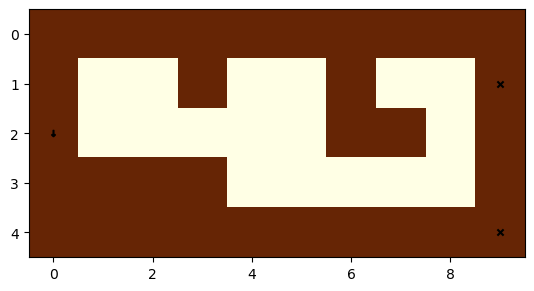

curr_reward 29.055856755186344
accumulated_reward 0
current Design
[(2, 0)]


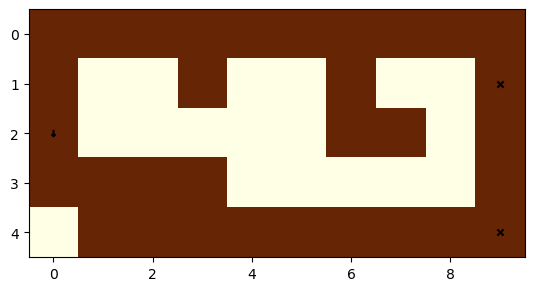

curr_reward 29.143119890038445
accumulated_reward 0
current Design
[(2, 0)]


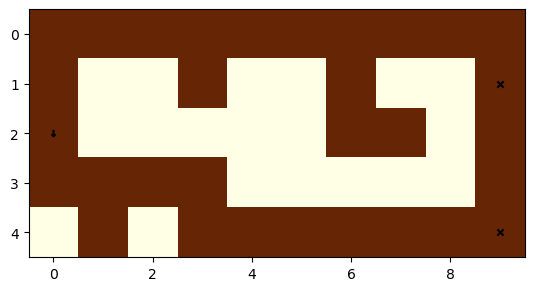

curr_reward 28.703969205767372
accumulated_reward 0
current Design
[(2, 0)]


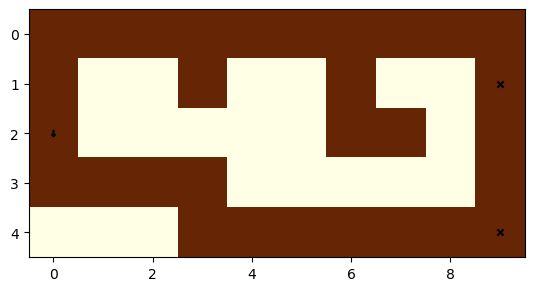

curr_reward 28.850161736676945
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 3130000
Best mean reward: 166.16 - Last mean reward per episode: 96.95
current Design
[(1, 0)]


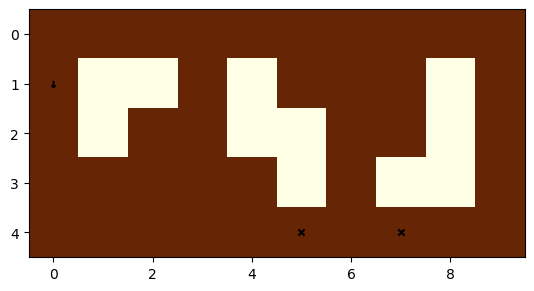

hello hello
--------------------------------------------------
Num timesteps: 3140000
Best mean reward: 166.16 - Last mean reward per episode: 145.25
current Design
[(0, 3)]


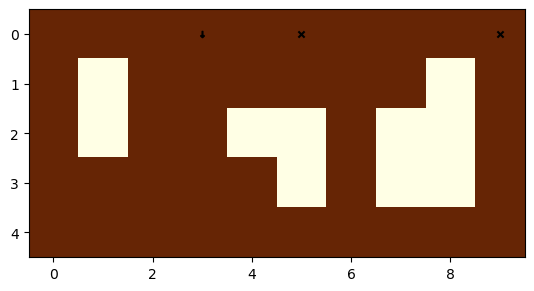

hello hello
--------------------------------------------------
Num timesteps: 3150000
Best mean reward: 166.16 - Last mean reward per episode: 161.06
current Design
[(1, 9)]


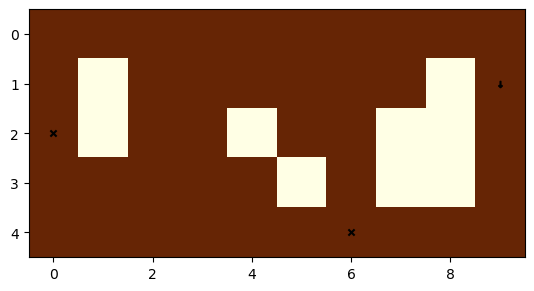

hello hello
--------------------------------------------------
Num timesteps: 3160000
Best mean reward: 166.16 - Last mean reward per episode: 221.00
current Design
[(0, 9)]


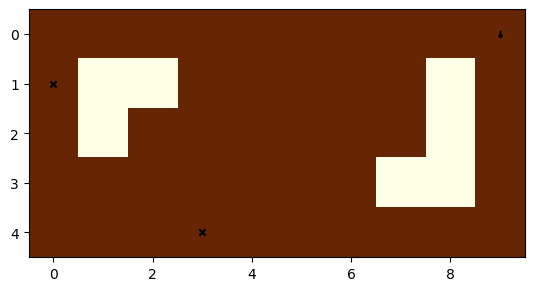

Saving new best model to log/best_model.zip
hello hello
--------------------------------------------------
Num timesteps: 3170000
Best mean reward: 221.00 - Last mean reward per episode: 6.05
current Design
[(0, 0)]


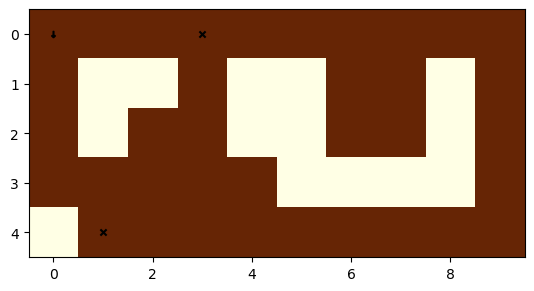

hello hello
--------------------------------------------------
Num timesteps: 3180000
Best mean reward: 221.00 - Last mean reward per episode: 10.37
current Design
[(0, 0)]


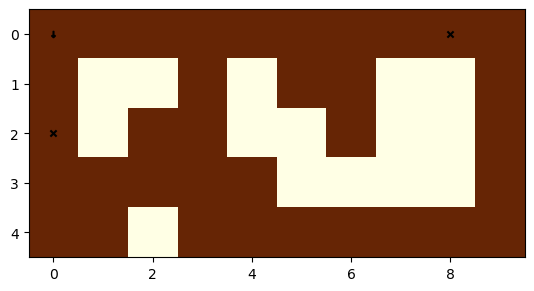

hello hello
--------------------------------------------------
Num timesteps: 3190000
Best mean reward: 221.00 - Last mean reward per episode: 143.09
current Design
[(0, 6)]


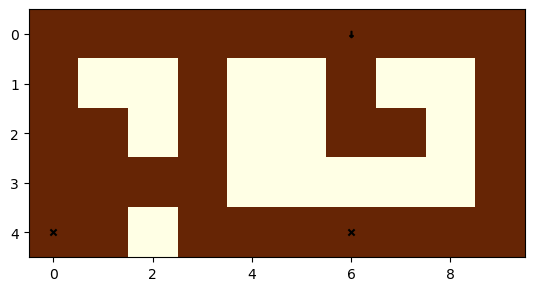

hello hello
--------------------------------------------------
Num timesteps: 3200000
Best mean reward: 221.00 - Last mean reward per episode: 175.59
current Design
[(4, 1)]


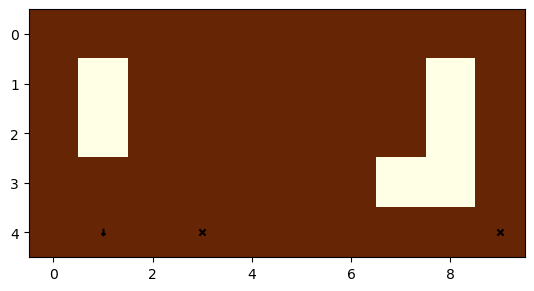

hello hello
--------------------------------------------------
Num timesteps: 3210000
Best mean reward: 221.00 - Last mean reward per episode: 129.62
current Design
[(3, 0)]


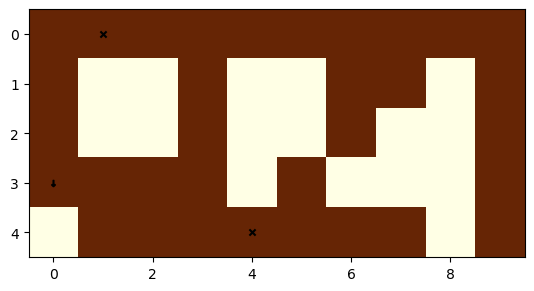

hello hello
--------------------------------------------------
Num timesteps: 3220000
Best mean reward: 221.00 - Last mean reward per episode: 106.13
current Design
[(3, 0)]


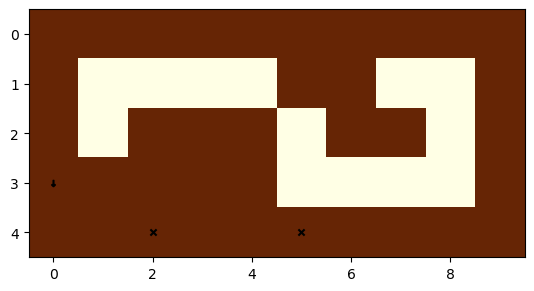

hello hello
--------------------------------------------------
Num timesteps: 3230000
Best mean reward: 221.00 - Last mean reward per episode: 111.66
current Design
[(0, 9)]


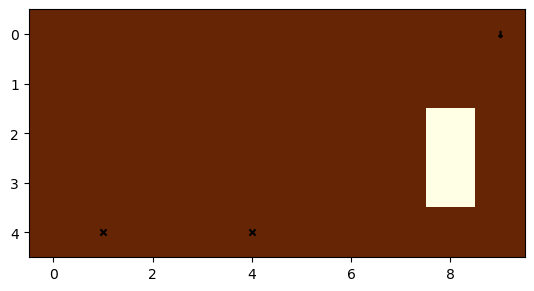

current Design
[(3, 9)]


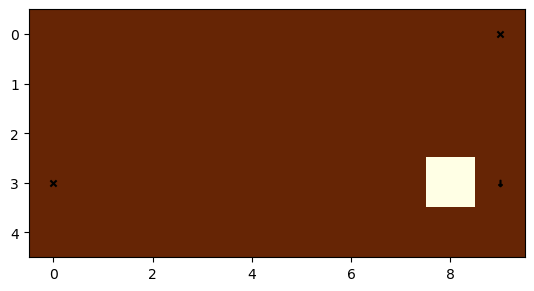

curr_reward 3.961383431405183
accumulated_reward 0
current Design
[(3, 9)]


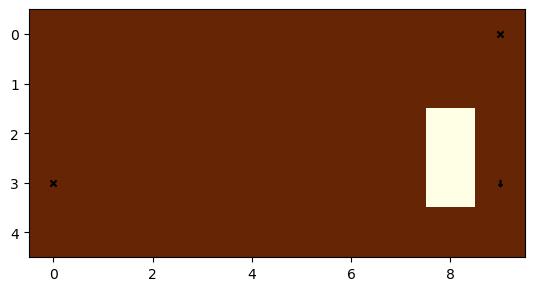

curr_reward 7.648182824214122
accumulated_reward 0
current Design
[(3, 9)]


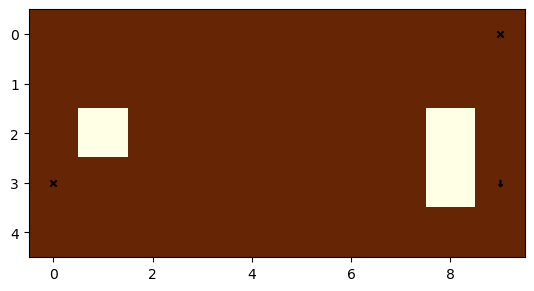

curr_reward 11.14569195941365
accumulated_reward 0
current Design
[(3, 9)]


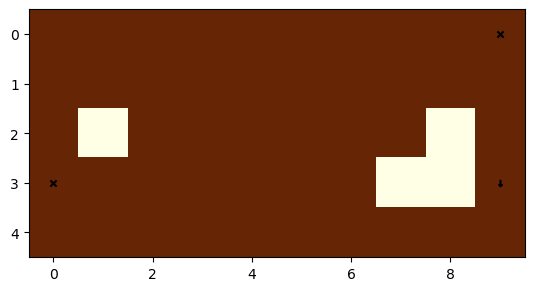

curr_reward 14.216051258627118
accumulated_reward 0
current Design
[(3, 9)]


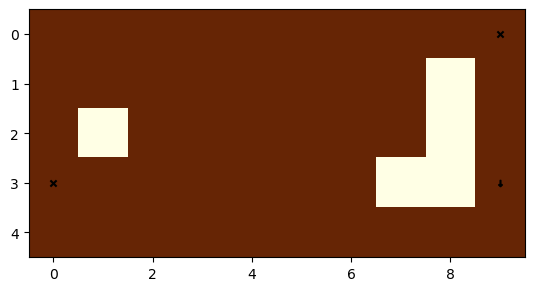

curr_reward 16.215547886246636
accumulated_reward 0
current Design
[(3, 9)]


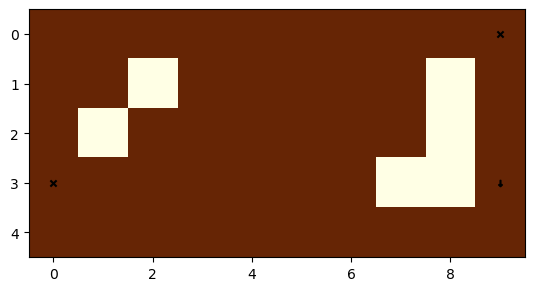

curr_reward 18.725010476886844
accumulated_reward 0
current Design
[(3, 9)]


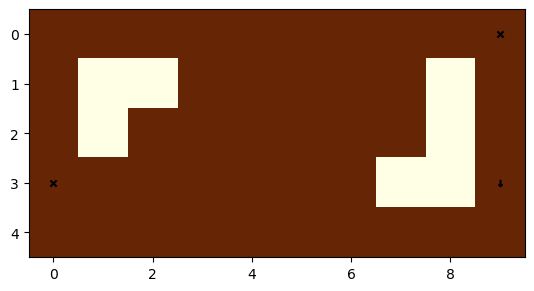

curr_reward 21.00899180406716
accumulated_reward 0
current Design
[(3, 9)]


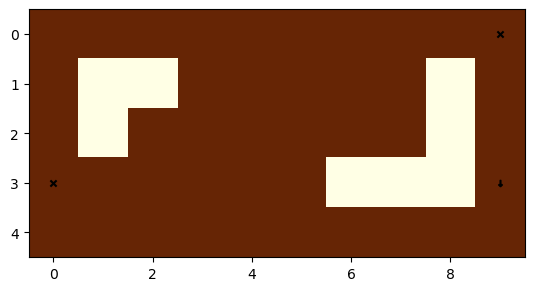

curr_reward 23.06304258475636
accumulated_reward 0
current Design
[(3, 9)]


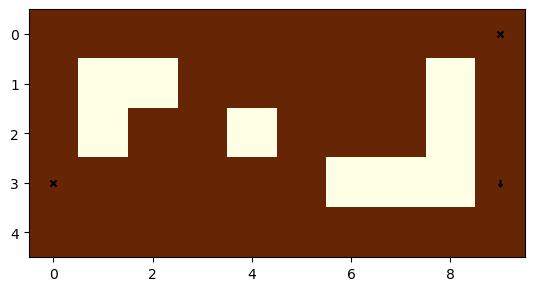

curr_reward 24.614789372190266
accumulated_reward 0
current Design
[(3, 9)]


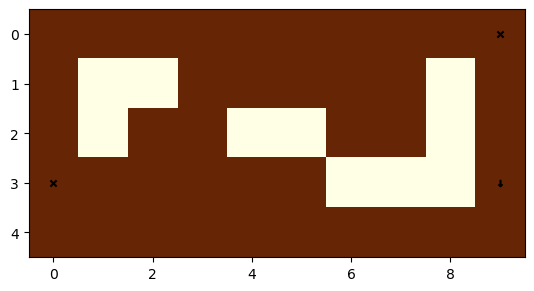

curr_reward 25.64928766634055
accumulated_reward 0
current Design
[(3, 9)]


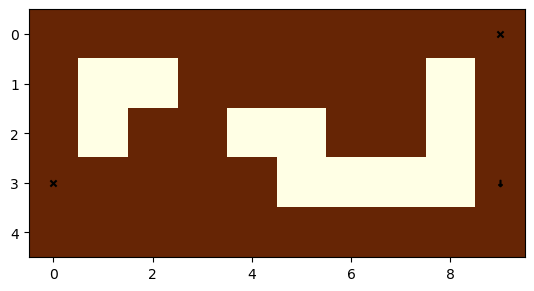

curr_reward 26.965841079930776
accumulated_reward 0
current Design
[(3, 9)]


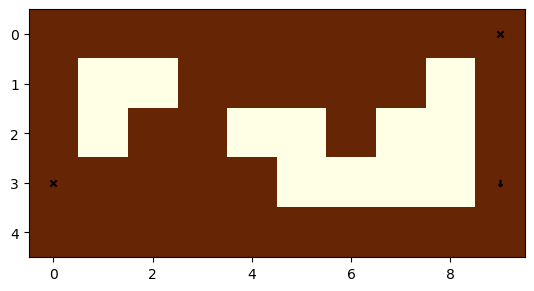

curr_reward 27.882194195297522
accumulated_reward 0
current Design
[(3, 9)]


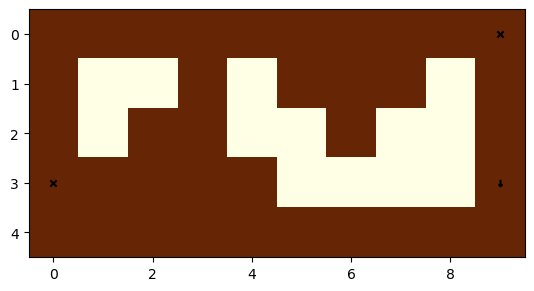

curr_reward 28.58099007464741
accumulated_reward 0
current Design
[(3, 9)]


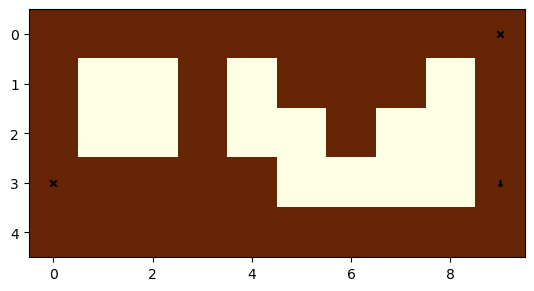

curr_reward 29.09658754341785
accumulated_reward 0
current Design
[(3, 9)]


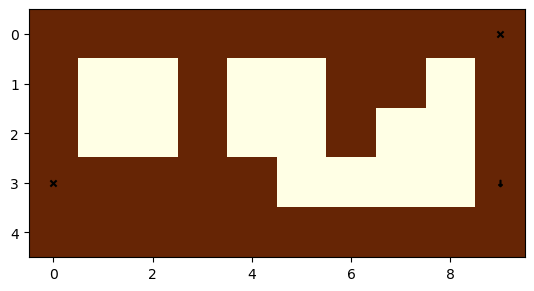

curr_reward 29.318695646531804
accumulated_reward 0
current Design
[(3, 9)]


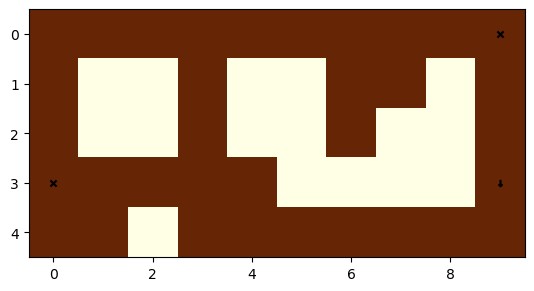

curr_reward 29.79024206698282
accumulated_reward 0
current Design
[(3, 9)]


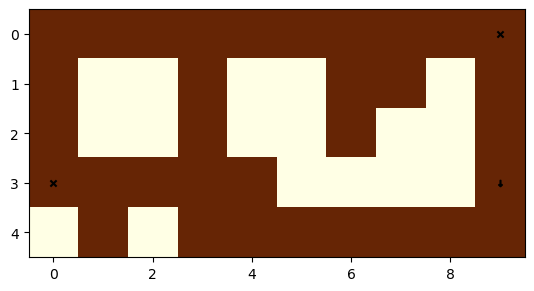

curr_reward 29.81515013481667
accumulated_reward 0
current Design
[(3, 9)]


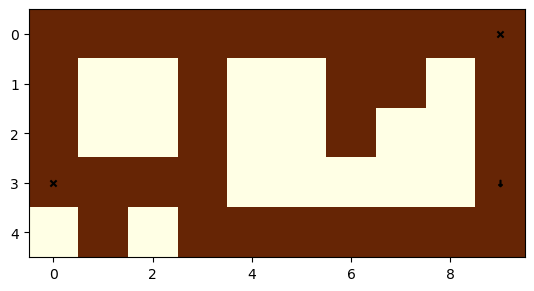

curr_reward 29.943134606855253
accumulated_reward 0
current Design
[(3, 9)]


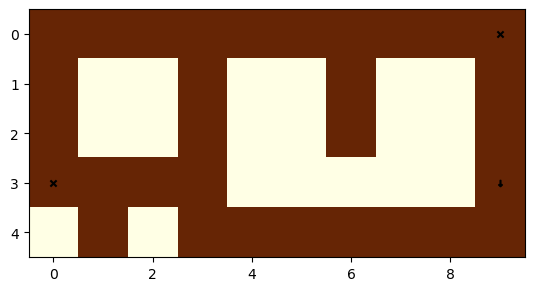

curr_reward 29.5563817202975
accumulated_reward 0
current Design
[(3, 9)]


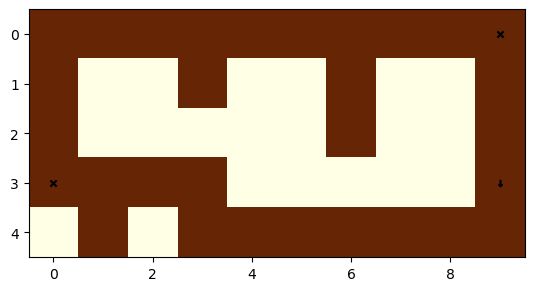

curr_reward 28.264684545937293
accumulated_reward 0
current Design
[(3, 9)]


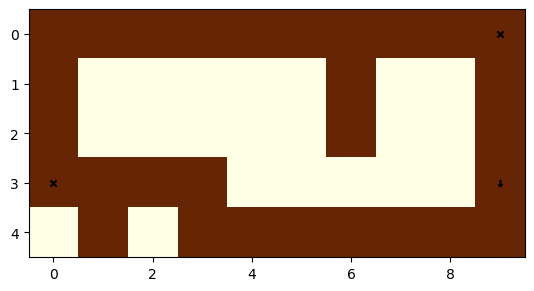

curr_reward 27.732366320321486
accumulated_reward 0
current Design
[(3, 9)]


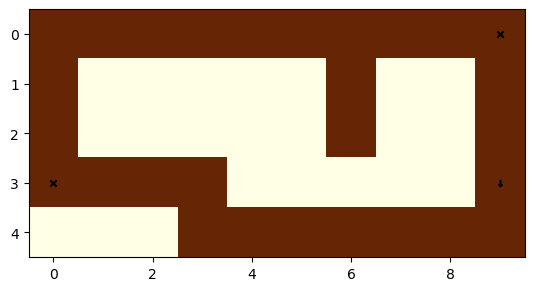

curr_reward 27.16048010565206
accumulated_reward 0
current Design
[(3, 9)]


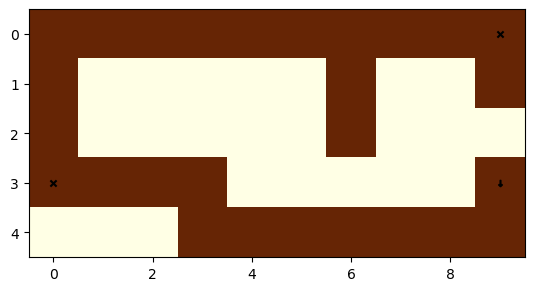

curr_reward 10.971589861145334
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 3240000
Best mean reward: 221.00 - Last mean reward per episode: 67.50
current Design
[(0, 6)]


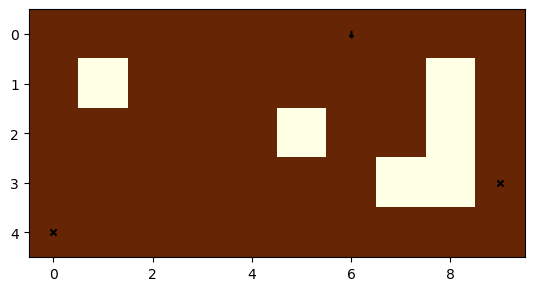

hello hello
--------------------------------------------------
Num timesteps: 3250000
Best mean reward: 221.00 - Last mean reward per episode: 63.80
current Design
[(4, 5)]


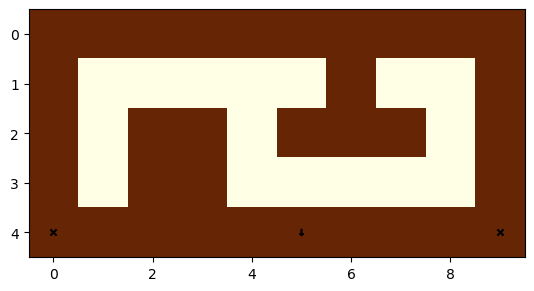

hello hello
--------------------------------------------------
Num timesteps: 3260000
Best mean reward: 221.00 - Last mean reward per episode: 103.32
current Design
[(0, 2)]


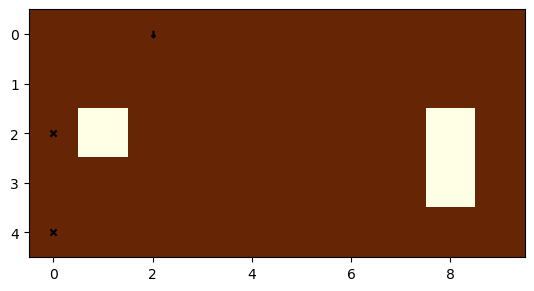

hello hello
--------------------------------------------------
Num timesteps: 3270000
Best mean reward: 221.00 - Last mean reward per episode: 128.94
current Design
[(4, 6)]


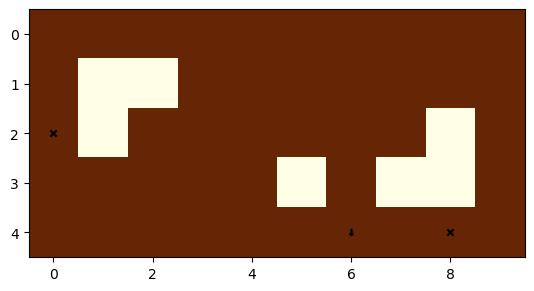

hello hello
--------------------------------------------------
Num timesteps: 3280000
Best mean reward: 221.00 - Last mean reward per episode: 86.50
current Design
[(4, 7)]


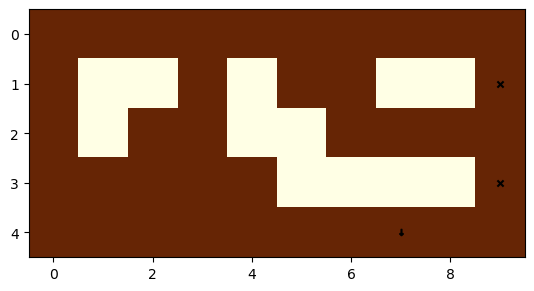

hello hello
--------------------------------------------------
Num timesteps: 3290000
Best mean reward: 221.00 - Last mean reward per episode: 153.28
current Design
[(0, 0)]


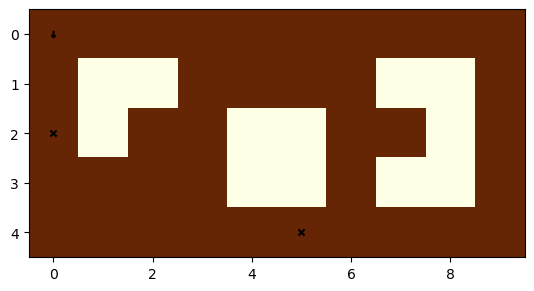

hello hello
--------------------------------------------------
Num timesteps: 3300000
Best mean reward: 221.00 - Last mean reward per episode: 181.14
current Design
[(0, 0)]


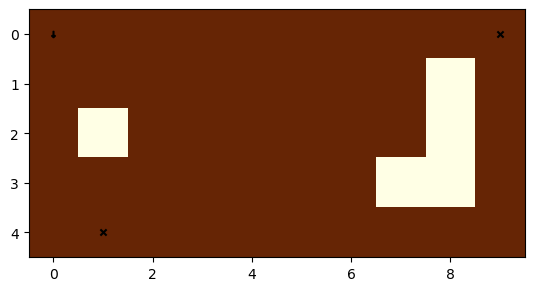

hello hello
--------------------------------------------------
Num timesteps: 3310000
Best mean reward: 221.00 - Last mean reward per episode: 88.01
current Design
[(3, 0)]


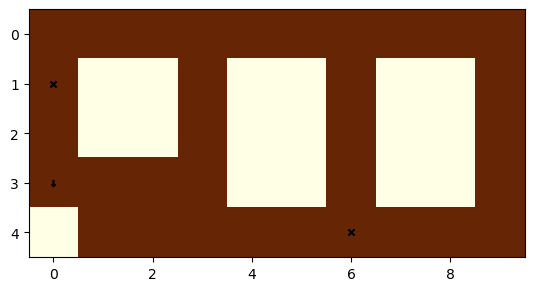

hello hello
--------------------------------------------------
Num timesteps: 3320000
Best mean reward: 221.00 - Last mean reward per episode: 89.70
current Design
[(4, 9)]


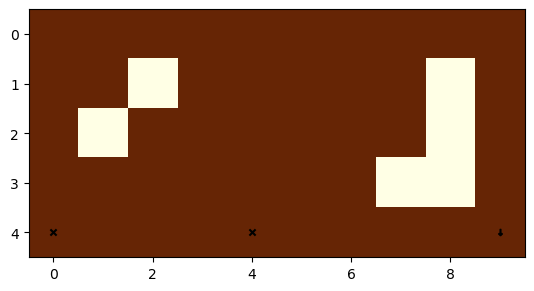

hello hello
--------------------------------------------------
Num timesteps: 3330000
Best mean reward: 221.00 - Last mean reward per episode: 46.86
current Design
[(0, 6)]


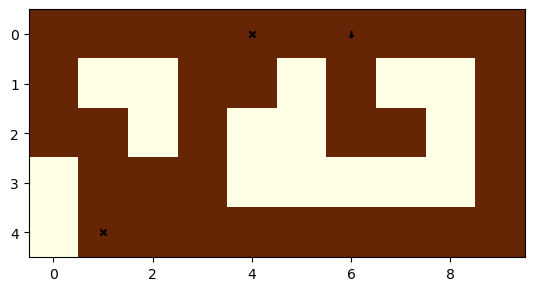

current Design
[(1, 9)]


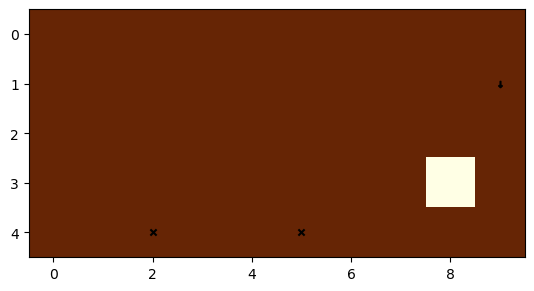

curr_reward 3.8942914567255946
accumulated_reward 0
current Design
[(1, 9)]


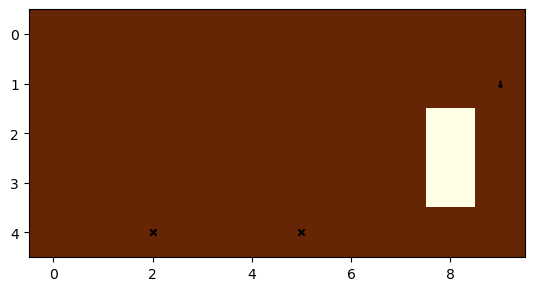

curr_reward 7.735601859894648
accumulated_reward 0
current Design
[(1, 9)]


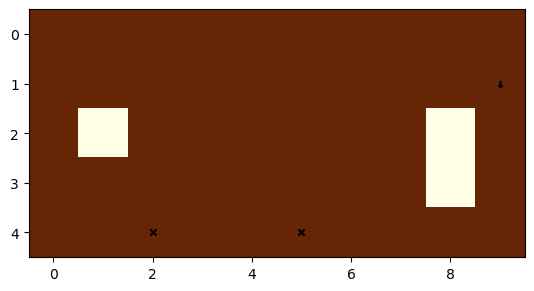

curr_reward 11.312334709888608
accumulated_reward 0
current Design
[(1, 9)]


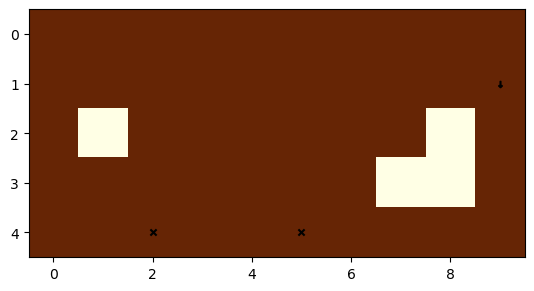

curr_reward 14.13759688611236
accumulated_reward 0
current Design
[(1, 9)]


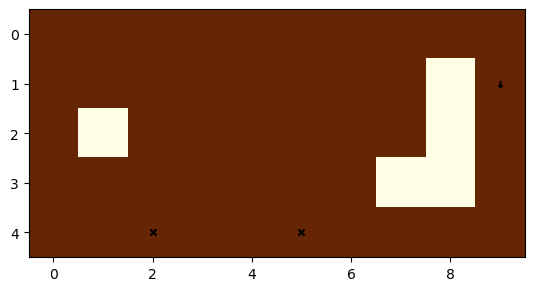

curr_reward 17.086285799573595
accumulated_reward 0
current Design
[(1, 9)]


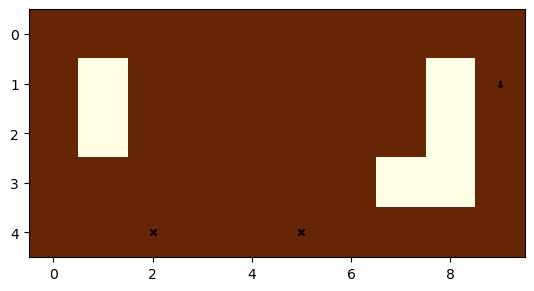

curr_reward 19.853906570218466
accumulated_reward 0
current Design
[(1, 9)]


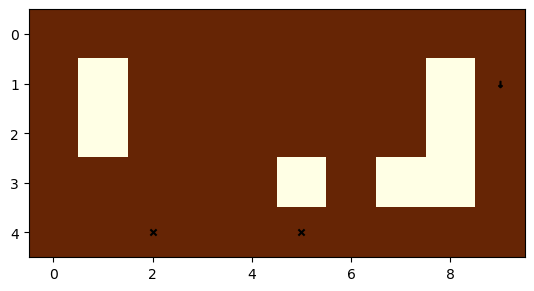

curr_reward 21.63869109165227
accumulated_reward 0
current Design
[(1, 9)]


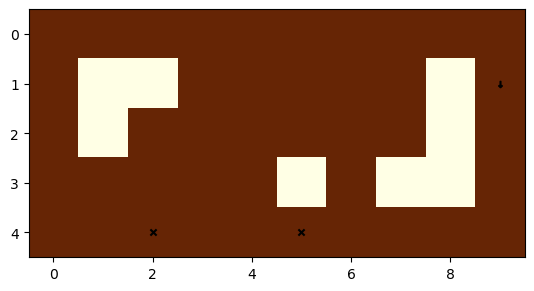

curr_reward 24.160985505799196
accumulated_reward 0
current Design
[(1, 9)]


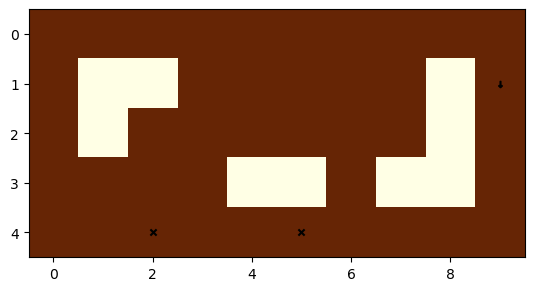

curr_reward 25.93205491131943
accumulated_reward 0
current Design
[(1, 9)]


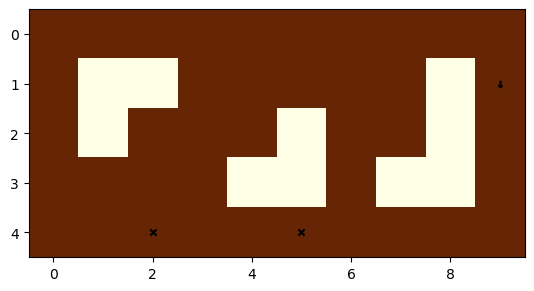

curr_reward 28.261185176550796
accumulated_reward 0
current Design
[(1, 9)]


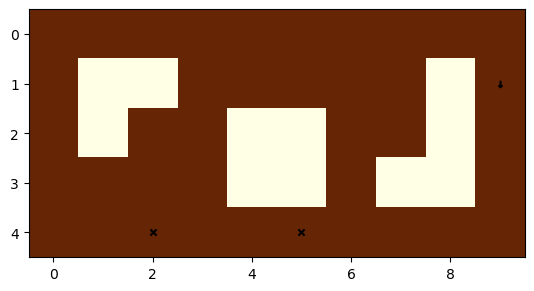

curr_reward 30.261880854324904
accumulated_reward 0
current Design
[(1, 9)]


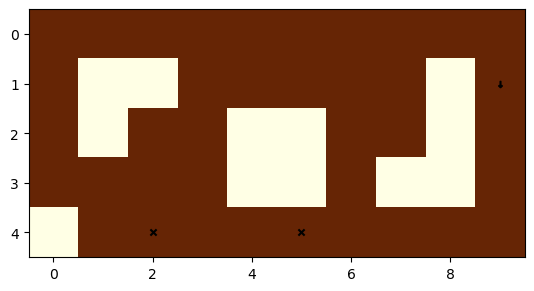

curr_reward 31.24095297455904
accumulated_reward 0
current Design
[(1, 9)]


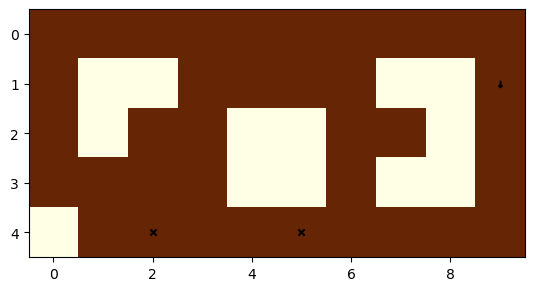

curr_reward 34.5796042488419
accumulated_reward 0
current Design
[(1, 9)]


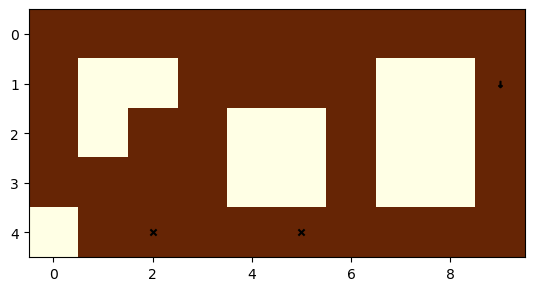

curr_reward 33.01916959059831
accumulated_reward 0
current Design
[(1, 9)]


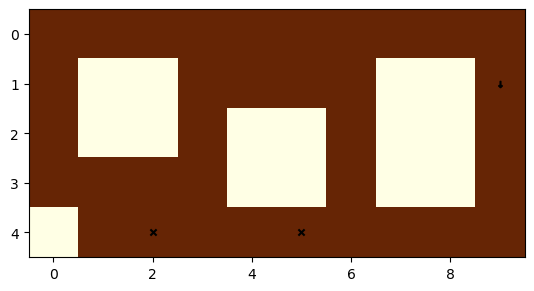

curr_reward 35.13425681166124
accumulated_reward 0
current Design
[(1, 9)]


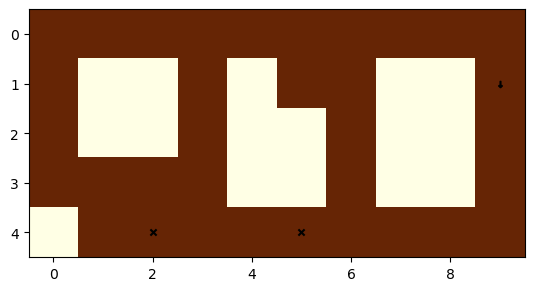

curr_reward 35.97117423532018
accumulated_reward 0
current Design
[(1, 9)]


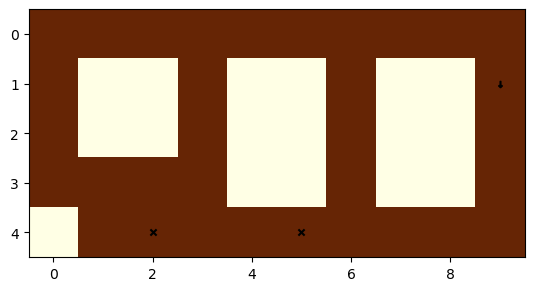

curr_reward 39.19553922187868
accumulated_reward 0
current Design
[(1, 9)]


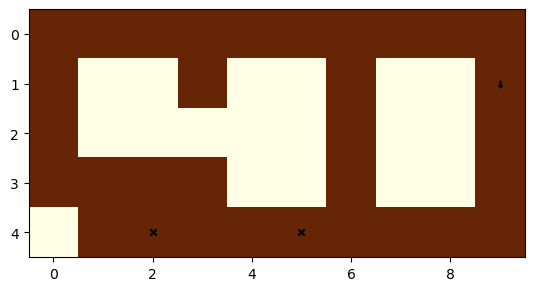

curr_reward 42.91600043812464
accumulated_reward 0
current Design
[(1, 9)]


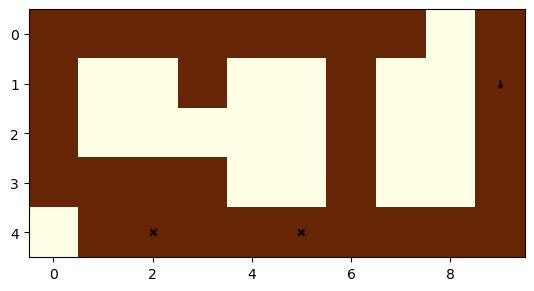

curr_reward 87.85368526384397
accumulated_reward 0
current Design
[(1, 9)]


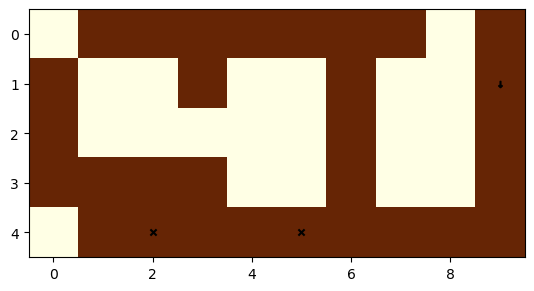

curr_reward 93.6262386383372
accumulated_reward 0
current Design
[(1, 9)]


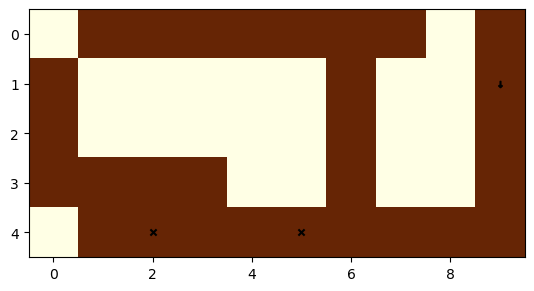

curr_reward 94.9052995176179
accumulated_reward 0
hello hello
--------------------------------------------------
Num timesteps: 3340000
Best mean reward: 221.00 - Last mean reward per episode: 85.70
current Design
[(0, 8)]


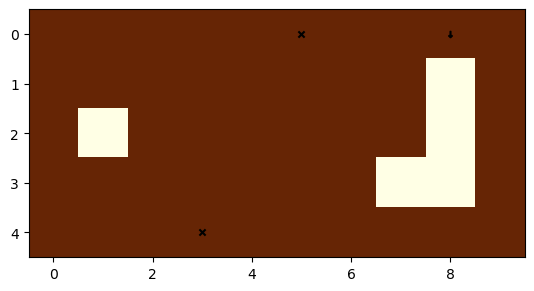

hello hello
--------------------------------------------------
Num timesteps: 3350000
Best mean reward: 221.00 - Last mean reward per episode: 153.37
current Design
[(0, 0)]


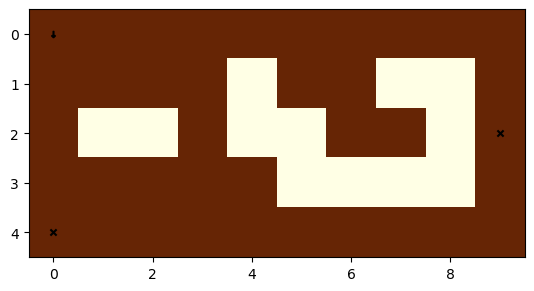

KeyboardInterrupt: 

In [27]:
start=time.time()
try:
    model = PPO("MlpPolicy", env, tensorboard_log=TS_BOARD_DIR).learn(total_timesteps=TIMESTEPS, callback=callback)
except ValueError as e:
    print("reward" + str(env.current_reward))
    print("DESIGN" + str(env.design_space[DESIGN, :, :]))
    print("bound" + str(env.design_space[BOUND, :, :]))
    print("force" + str(env.design_space[LOADED_Y, :, :]))
    print(e)
end=time.time()   
print("Elapsed Time = " + str(end-start))

In [ ]:
#TODO REWARD FUNCTION : LESS CHANGE IN STRAIN OR STRESS BETWEEN STEPS THE BETTER

In [ ]:
#TODO CATCH singular Matrices before they happen

#TODO DESIGN SPACE KLEINER
#TODO LERNPROZESS SIMILIEREN
#TODO 

Step 1
Action:  38
Reward:  3.849892007172121
current Design
[(4, 9)]


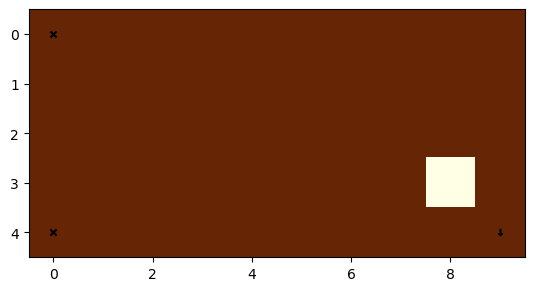

Step 2
Action:  28
Reward:  7.373449909102722
current Design
[(4, 9)]


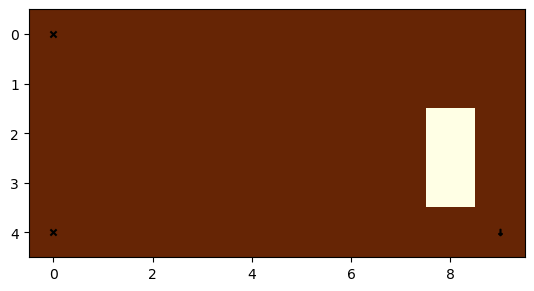

Step 3
Action:  21
Reward:  10.759952611184252
current Design
[(4, 9)]


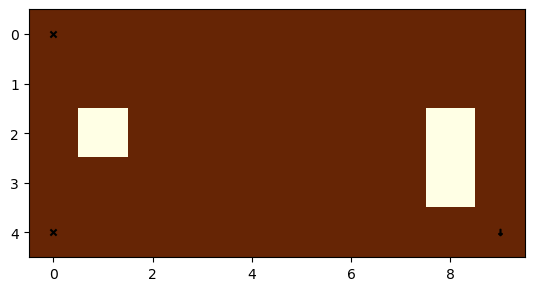

Step 4
Action:  37
Reward:  13.633684083196906
current Design
[(4, 9)]


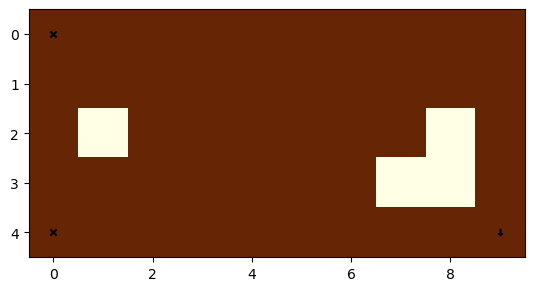

Step 5
Action:  18
Reward:  16.159608194348905
current Design
[(4, 9)]


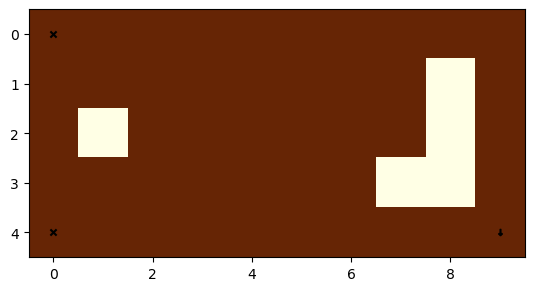

Step 6
Action:  11
Reward:  18.746945232073053
current Design
[(4, 9)]


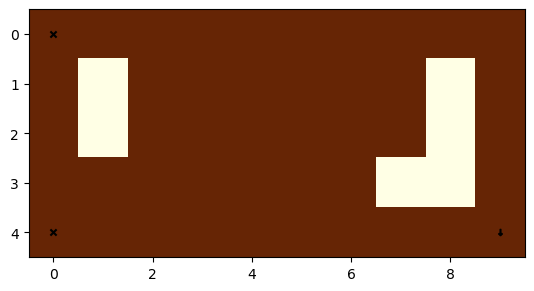

Step 7
Action:  12
Reward:  22.083274789505975
current Design
[(4, 9)]


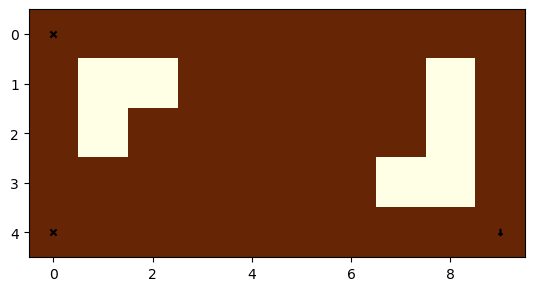

Step 8
Action:  35
Reward:  24.189646358186597
current Design
[(4, 9)]


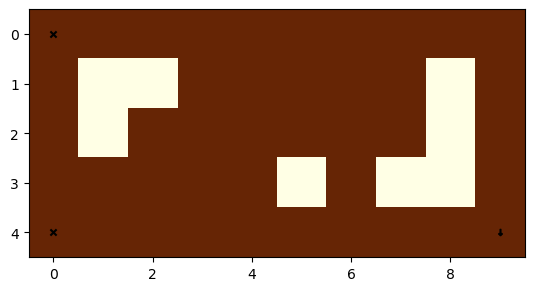

Step 9
Action:  24
Reward:  26.20828850199683
current Design
[(4, 9)]


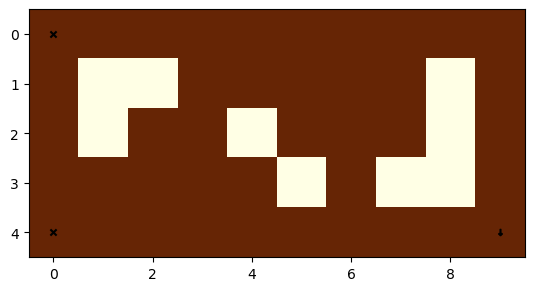

Step 10
Action:  25
Reward:  27.6786607592077
current Design
[(4, 9)]


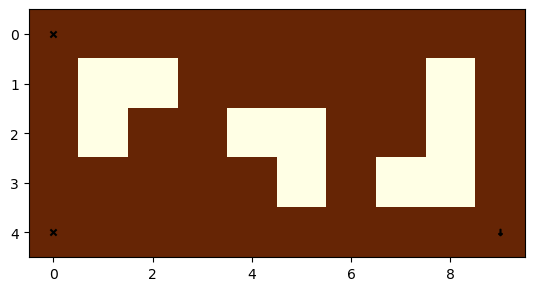

Step 11
Action:  31
Reward:  29.19683820762326
current Design
[(4, 9)]


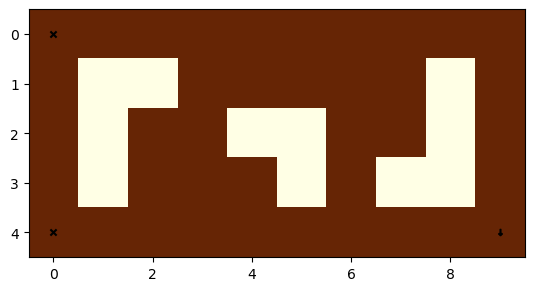

Step 12
Action:  36
Reward:  29.78870984827425
current Design
[(4, 9)]


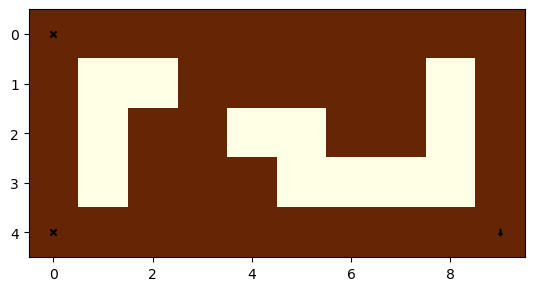

Step 13
Action:  22
Reward:  30.252525042882798
current Design
[(4, 9)]


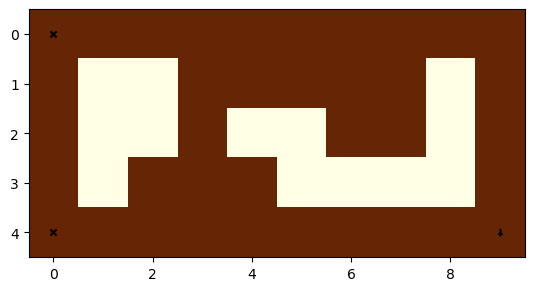

Step 14
Action:  27
Reward:  30.936981605517417
current Design
[(4, 9)]


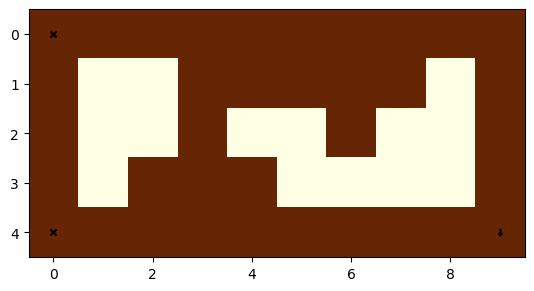

Step 15
Action:  14
Reward:  31.148771012878182
current Design
[(4, 9)]


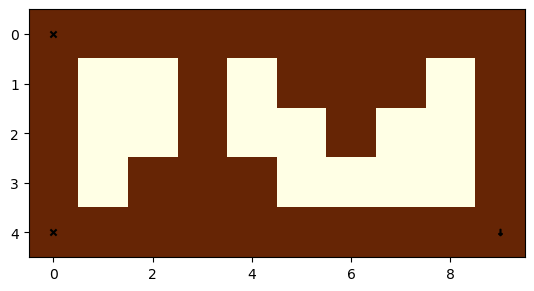

Step 16
Action:  34
Reward:  31.216819850322963
current Design
[(4, 9)]


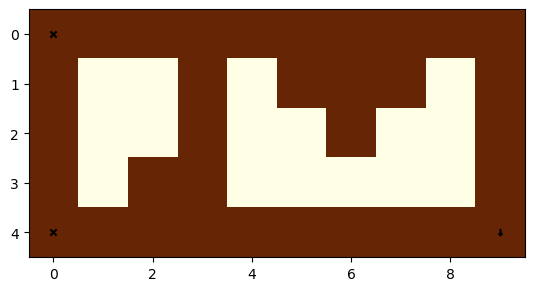

Step 17
Action:  17
Reward:  31.364857766078146
current Design
[(4, 9)]


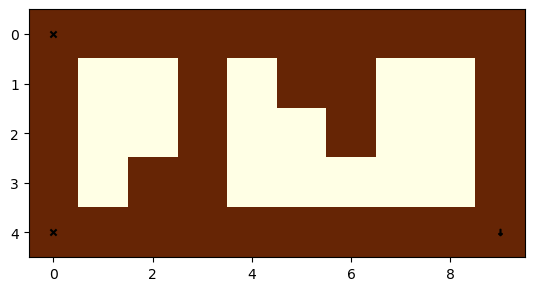

Step 18
Action:  15
Reward:  31.535864766575248
current Design
[(4, 9)]


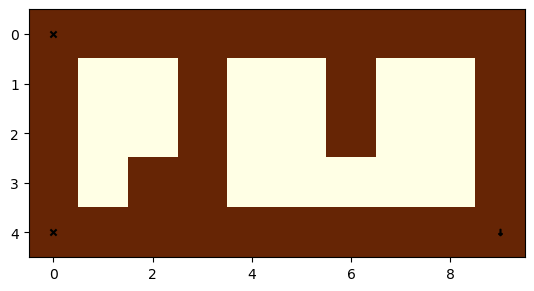

Step 19
Action:  23
Reward:  32.0337814009145
current Design
[(4, 9)]


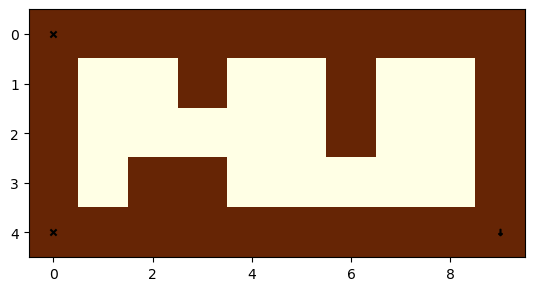

Action already performed
Step 20
Action:  23
Reward:  -500
current Design
[(4, 9)]


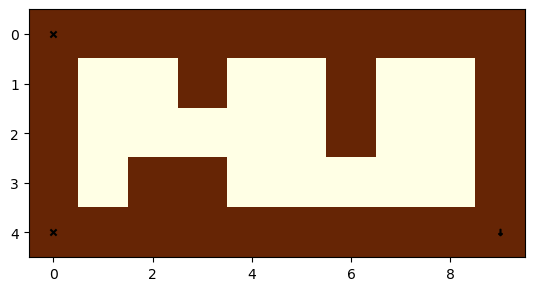

Goal reached! reward= -500
current Design
[(4, 9)]


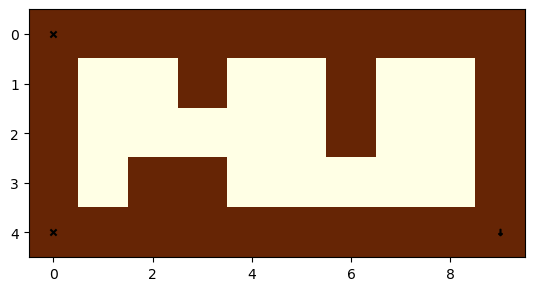

In [28]:

# Ensure the environment is properly closed before reinitializing
env.close()
bound_nodes_list = [(0, 0), (HEIGHT-1, 0)]
"""A list containing the coordinates of the nodes that are bound in the 
design space."""

loaded_nodes_list = [(HEIGHT-1, WIDTH-1)]

# Initialize the environment
env = TopOptEnv(mode="eval", threshold=0.5,bound_nodes_list=bound_nodes_list, force_nodes_list=loaded_nodes_list)

# Define the model path using a raw string
model_path = r"./log/best_model.zip"

# Check if the file exists and is accessible
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The model file {model_path} does not exist.")
if not os.access(model_path, os.R_OK):
    raise PermissionError(f"The model file {model_path} is not readable.")

# Load the model
try:
    model_best = PPO.load(model_path, env=env)
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Please check the file permissions and ensure no other application is using the file.")
    raise

# Reset the environment
obs, _ = env.reset()
i = 0

# Run the evaluation loop
while i < 1000:
    action, _states = model_best.predict(obs)
    action = action.item()

    obs, rewards, dones, _, info = env.step(action)
    if i % 1 == 0:
        print(f"Step {i + 1}")
        print("Action: ", action)  # added Console Outputs for better understanding
        print("Reward: ", rewards)
        env.print_design()
    if dones:
        print("Goal reached!", "reward=", rewards)
        env.print_design()
        break
    i += 1

In [ ]:
#TODO: Reward nicht Akummulierend
#TODO: 4x4 kleine Matrix Debuggen


In [ ]:
env = TopOptEnv(mode = eval, threshold=0.2)
print(env.design_space[DESIGN, :, :])
env.print_design()


In [ ]:
def normalized_element_count(height, width, element_count):
    max_allowed_elements = height * width * 2
    return (max_allowed_elements - element_count) / max_allowed_elements

def print_env_stats(env, rounding = 50, reward= 0):
    print("init:strain:\t\t", round(env.init_strain, rounding))
    print("max:strain:\t\t", round(env.emax, rounding))
    print("average_strain:\t\t", round(env.average_strain, rounding))
    print("strain ratio:\t\t", round(env.init_strain, rounding), "/", round(env.average_strain,rounding), " = ", round(env.init_strain/abs(env.average_strain),rounding))
    print("Material ratio:\t\t" , round((env.height * env.width * 2), rounding), "-", round(env.element_count,rounding), "/", round((env.height * env.width* 2), rounding), " = ", round(normalized_element_count(env.height, env.width, env.element_count),rounding ))
    print("reward =\t\t", reward_function(env.smax, env.emax, env.avg_u1, env.avg_u2, env.element_count, env.average_stress, env.average_strain, env.init_strain, env.max_displacement_1, env.max_displacement_2, env.init_stress))
    print("current returned Reward:\t\t", round(reward, rounding))
    print("current self.reward:\t\t", round(env.reward, rounding))

env = TopOptEnv(mode = eval, threshold=0.2)

obs, reward, dones, _, info = env.step(WIDTH-2)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH-1)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(2*WIDTH-1)
print_env_stats(env, reward=reward)
env.print_design()
env.close()


env = TopOptEnv(mode = eval, threshold=0.2)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2)))
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2))- WIDTH)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2))+ WIDTH)
print_env_stats(env, reward=reward)
env.print_design()
env.close()


env = TopOptEnv(mode = eval, threshold=0.2)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-3)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-3-WIDTH)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-2-WIDTH)
print_env_stats(env, reward=reward)
env.print_design()
env.close()

In [ ]:
env = TopOptEnv(mode = eval, threshold=0.2)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(10)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(91)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(98)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.print_design()

In [ ]:
matrix = [[1, 1, 1, 1],
          [1, 1, 0, 0],
          [0, 1, 0, 1],
          [1, 1, 0, 1]]
print(is_continuous(matrix, [(0, 0), (0, 3), (3, 3)]))  # True

In [ ]:
#TODO remove illegal actions from the actions space
